In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv

Анализ данных

In [ ]:
print('Columns: {}'.format(list(train.columns.values)))

In [ ]:
print(F'Список колонок в train.csv ({len(list(train.columns.values))}): {list(train.columns.values)}\n')
print(F'Список колонок в test.csv ({len(list(test.columns.values))}): {list(test.columns.values)}')

In [ ]:
train.head()

Выделяем все столбцы с данными типа object

In [ ]:
binary_columns = [x for x in train.columns if train[x].dtype.name == 'object']

Столбец Total_Payment имеет тип object, чтобы сохранить зависимость результата от размера платы, значения просто приводятся к числовому типу

In [ ]:
binary_columns.remove('Total_Payment')
train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')

Проверяем данные на наличие нулевых значений

In [ ]:
train[train.isnull().any(axis=1)]

Замена отсутствующих значений на среднее не улучшило результат

In [ ]:
#mean = train['Total_Payment'].mean()
#train = train.fillna({'Total_Payment': mean})

#### Находятся столбцы, которые лучше преобразовать, используя OneHotEncoder
Общий альтернативный подход называется унитарным кодированием (One Hot Encoding). Основная стратегия состоит в том, чтобы преобразовать значение каждой категории в новый столбец и присвоить столбцу значение 1 или 0 (Истина / Ложь). Это дает преимущество в том, что значение не взвешивается неправильно.
(range подбирается вручную на основании проверки более общих предположений, т.к. проверка абсолютно всех вариантов займет много времени)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

p = 0
max_auc =0
max_auc_col_list = []
train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv

start_columns = [c for c in train.columns if train[c].dtype.name == 'object']
list_col = [[[x[1] for x in f] for f in partition(lambda x: x[0], zip(pattern, start_columns))] for pattern in product([True, False], repeat=len(start_columns))]
categorical_columns = []
for i in list_col:
    binary_columns = start_columns
    categorical_columns = []
    for x in i[0]:
        binary_columns.remove(x)
        categorical_columns.append(x)
    
    for y in (False, True):
        train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
        test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv
        start_columns = [x for x in train.columns if train[x].dtype.name == 'object']
        if y:
            if 'Total_Payment' in binary_columns:
                binary_columns.remove('Total_Payment')
            else:
                categorical_columns.remove('Total_Payment')
            train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
            test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')
        
        for col in binary_columns:
            le = LabelEncoder().fit(list(train[col].values) + list(test[col].values))
            train[col] = le.transform(train[col].values)
            test[col] = le.transform(test[col].values)

        for col in categorical_columns:
            oe_style = OneHotEncoder()
            oe_results = oe_style.fit_transform(train[[col]])
            train = train.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
            train = train.drop(col, axis=1)

            oe_results = oe_style.fit_transform(test[[col]])
            test = test.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
            test = test.drop(col, axis=1)
        
        features = list(train.columns.values)
        features.remove('id')
        features.remove('Leave_Next_Month')
        
        train = pd.DataFrame(train, dtype=float)
        test = pd.DataFrame(test, dtype=float)
        test['Leave_Next_Month'] = 0
        X = train[features]
        y = pd.concat((train['id'], train['Leave_Next_Month']), axis=1)

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 11)
        
        
        params_xgb = {
            "objective": "binary:logistic",
            "eval_metric": 'logloss',
            "eta": 0.12,
            "max_depth": 3,
            "subsample": 0.69,
            "colsample_bytree": 0.7,
            "verbosity": 0,
            "silent": True,
        }
        num_boost_round = 70
        early_stopping_rounds = 10
        
        dtrain = xgb.DMatrix(X_train.values, y_train['Leave_Next_Month'].values)
        dvalid = xgb.DMatrix(X_valid.values, y_valid['Leave_Next_Month'].values)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(params_xgb, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

        pred = model.predict(xgb.DMatrix(X_valid.values), ntree_limit=model.best_iteration + 1)
        prediction = np.round(pred)
        #print(prediction)
        accuracy = accuracy_score(y_valid['Leave_Next_Month'].values, prediction)
        auc = roc_auc_score(y_valid['Leave_Next_Month'].values, prediction)
        print('Accuracy: {:.2f} %, ROC AUC: {:.2f}'.format(100*accuracy, auc))
        if auc == max_auc:
            max_auc_col_list.append([binary_columns, categorical_columns])
        elif auc > max_auc:
            max_auc = auc 
            max_auc_col_list = []
            max_auc_col_list.append([binary_columns, categorical_columns])
        print(p)
        p=p+1
        print('List of col: {:.2f} of {:.2f}'.format(p/2, len(list_col)))
        

По итогам пред. categorical_columns будут преобразованы с использованием OneHotEncoder, а binary_columns - только LabelEncoder 

In [ ]:
categorical_columns = ['Device_Protection', 'Type_contract', 'Paperless_Billing', 'Payment_Method']
for x in categorical_columns:
    binary_columns.remove(x)

Подготовка данных

In [ ]:
for col in binary_columns:
    
    le = LabelEncoder().fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(train[col].values)
    test[col] = le.transform(test[col].values)

for col in categorical_columns:
    
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(train[[col]])
    train = train.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    train = train.drop(col, axis=1)

    oe_results = oe_style.fit_transform(test[[col]])
    test = test.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    test = test.drop(col, axis=1)

In [ ]:
features = list(test.columns.values)
features.remove('id')

In [ ]:
print('Описание тренировочных данных:')
for f in features:
    print('Feature: {}'.format(f))
    print(train[f].describe())
    uni = sorted(train[f].unique())
    if len(uni) < 100:
        print('Уникальные записи в колонке:', uni)
    print('')

In [ ]:
train = pd.DataFrame(train, dtype=float)
test = pd.DataFrame(test, dtype=float)
test['Leave_Next_Month'] = 0
X = train[features]
y = pd.concat((train['id'], train['Leave_Next_Month']), axis=1)

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

#### Экспериментально подбираются параметры модели
(range подбирается вручную на основании проверки более общих предположений, т.к. проверка абсолютно всех вариантов займет много времени)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

t_list= []
tt_list=[]
auc_list=[]
p = 0
max_auc =0
max_auc_col_list = []
train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv

binary_columns = [x for x in train.columns if train[x].dtype.name == 'object']
categorical_columns = ['Device_Protection', 'Type_contract', 'Paperless_Billing', 'Payment_Method']
for x in categorical_columns:
    binary_columns.remove(x)

binary_columns.remove('Total_Payment')
train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')

for col in binary_columns:
    le = LabelEncoder().fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(train[col].values)
    test[col] = le.transform(test[col].values)

for col in categorical_columns:
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(train[[col]])
    train = train.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    train = train.drop(col, axis=1)

    oe_results = oe_style.fit_transform(test[[col]])
    test = test.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    test = test.drop(col, axis=1)

features = list(train.columns.values)
features.remove('id')
features.remove('Leave_Next_Month')

train = pd.DataFrame(train, dtype=float)
test = pd.DataFrame(test, dtype=float)
test['Leave_Next_Month'] = 0
X = train[features]
y = pd.concat((train['id'], train['Leave_Next_Month']), axis=1)

for t in np.arange(0.01, 0.9, 0.1):
    for tt in np.arange(1, 9, 1):
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 1700)
        
        
        params_xgb = {
            "objective": "binary:logistic",
            "eval_metric": 'logloss',
            "eta": t,
            "max_depth": tt,
            "subsample": 0.7,
            "colsample_bytree": 0.7,
            "verbosity": 0,
            "silent": True,
        }
        num_boost_round = 70
        early_stopping_rounds = 10
        
        dtrain = xgb.DMatrix(X_train.values, y_train['Leave_Next_Month'].values)
        dvalid = xgb.DMatrix(X_valid.values, y_valid['Leave_Next_Month'].values)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(params_xgb, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

        pred = model.predict(xgb.DMatrix(X_valid.values), ntree_limit=model.best_iteration + 1)
        prediction = np.round(pred)
        accuracy = accuracy_score(y_valid['Leave_Next_Month'].values, prediction)
        auc = roc_auc_score(y_valid['Leave_Next_Month'].values, prediction)
        print('Accuracy: {:.2f} %, ROC AUC: {:.2f}'.format(100*accuracy, auc))
        print('test_size: {:.2f}, random_state: {:.2f}'.format(t, tt))
        t_list.append(t)
        tt_list.append(tt)
        auc_list.append(auc)
        if auc == max_auc:
            max_auc_col_list.append([binary_columns, categorical_columns])
        elif auc > max_auc:
            max_auc = auc 
            max_auc_col_list = []
            max_auc_col_list.append([t, tt])
        print(p)
        p=p+1
        print('List of col: {:.2f} of 790 000'.format(p))

In [ ]:
print(max_auc)
max_auc_col_list

In [ ]:
import matplotlib.pyplot as plt
plt.plot(auc_list, t_list, 'ro')
plt.show()

"eval_metric": auc - Площадь под кривой.
"objective": 'binary:hinge' -  делает прогнозы 0 или 1, а не производит вероятности. 
"gamma": минимальное снижение потерь
"max_depth": максимальная глубина дерева.
"subsample": коэффициент подвыборки обучающего экземпляра. Установка значения 0,5 означает, что xgboost случайным образом собрал половину экземпляров данных для выращивания деревьев, и это предотвратит перенастройку. Это делает вычисления короче.

In [ ]:
params_xgb = {
    "objective": "binary:logistic",
    "eval_metric": 'acu',
    "eta": 0.12,
    "gamma": 4,
    "max_depth": 4,
    "subsample": 0.69,
    "colsample_bytree": 0.8,
    "verbosity": 0,
    "silent": True,
}

In [ ]:
dtrain = xgb.DMatrix(X_train.values, y_train['Leave_Next_Month'].values)
dvalid = xgb.DMatrix(X_valid.values, y_valid['Leave_Next_Month'].values)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params_xgb, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

#### Подбираются параметры кросс валидации
(range подбирается вручную на основании проверки более общих предположений, т.к. проверка абсолютно всех вариантов займет много времени)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

t_list= []
tt_list=[]
auc_list=[]
p = 0
max_auc =0
max_auc_col_list = []
train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv

binary_columns = [x for x in train.columns if train[x].dtype.name == 'object']
categorical_columns = ['Device_Protection', 'Type_contract', 'Paperless_Billing', 'Payment_Method']
for x in categorical_columns:
    binary_columns.remove(x)

binary_columns.remove('Total_Payment')
train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')

for col in binary_columns:
    le = LabelEncoder().fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(train[col].values)
    test[col] = le.transform(test[col].values)

for col in categorical_columns:
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(train[[col]])
    train = train.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    train = train.drop(col, axis=1)

    oe_results = oe_style.fit_transform(test[[col]])
    test = test.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    test = test.drop(col, axis=1)

features = list(train.columns.values)
features.remove('id')
features.remove('Leave_Next_Month')

train = pd.DataFrame(train, dtype=float)
test = pd.DataFrame(test, dtype=float)
test['Leave_Next_Month'] = 0
X = train[features]
y = pd.concat((train['id'], train['Leave_Next_Month']), axis=1)

split_n = range(2, )

for splt in np.arange(10, 15, 20):
    for rndm in np.arange(1, 2000, 1):
        
        #, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 1700)
        kf = KFold(n_splits=splt, shuffle=True, random_state=rndm)
        kf.get_n_splits(X)

        for train_index, test_index in kf.split(X):
            X_train, X_valid = X.iloc[train_i], X.iloc[test_i]
            y_train, y_valid = y.iloc[train_i], y.iloc[test_i]
        
        params_xgb = {
            "objective": "binary:logistic",
            "eval_metric": 'logloss',
            "eta": 0.12,
            "gamma": 4,
            "max_depth": 2,
            "subsample": 0.7,
            "colsample_bytree": 0.7,
            "verbosity": 0,
            "silent": True,
        }
        num_boost_round = 100
        early_stopping_rounds = 100
        
        dtrain = xgb.DMatrix(X_train.values, y_train['Leave_Next_Month'].values)
        dvalid = xgb.DMatrix(X_valid.values, y_valid['Leave_Next_Month'].values)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(params_xgb, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

        pred = model.predict(xgb.DMatrix(X_valid.values), ntree_limit=model.best_iteration + 1)
        prediction = np.round(pred)
        accuracy = accuracy_score(y_valid['Leave_Next_Month'].values, prediction)
        auc = roc_auc_score(y_valid['Leave_Next_Month'].values, prediction)
        print('Accuracy: {:.2f} %, ROC AUC: {:.2f}'.format(100*accuracy, auc))
        print('n_splits: {0}, random_state: {1}'.format(splt, rndm))
        t_list.append(splt)
        tt_list.append(rndm)
        auc_list.append(auc)
        if auc == max_auc:
            max_auc_col_list.append([binary_columns, categorical_columns])
        elif auc > max_auc:
            max_auc = auc 
            max_auc_col_list = []
            max_auc_col_list.append([splt, rndm])
        print(p)
        p=p+1
        print('List of col: {0} of 87500'.format(p))

In [ ]:
print(max_auc)
max_auc_col_list

Общий процесс кросс-валидации:

1. Перемешайть датасет случайным образом

2. Разделите датасет на k-групп

3. Для каждой уникальной выборки:

Взять группу в качестве тестирования датасета
Взять остальные группы в качестве выборки учебных данных
Приготовить модель на обучаемых выборках и оцените ее на тестовой выборке
Сохранить оценку модели и отбросить модель

Количество выборок на которое надо разбить датасет (n_splits=204), следует ли перетасовывать датасет (shuffle=True), и числовую затравку для псевдослучайного генератора чисел, используемого до перетасовки датасета (random_state=24).

In [ ]:
kf = KFold(n_splits=204, shuffle=True, random_state=24)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

Предсказание и сохранение результата

In [ ]:
pred = model.predict(xgb.DMatrix(test[features].values), ntree_limit=model.best_iteration + 1)
submission = pd.read_csv('miem-hse-ais-2022-lab-01/sample_submission.csv')
submission['id'] = test['id'].astype(int)
submission['Leave_Next_Month'] = pred
submission.to_csv('submission.csv', index = False)

---------------------------------------------------------

# DRAFT

------------------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [706]:
train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv

In [817]:
print('Columns: {}'.format(list(train.columns.values)))

Columns: ['id', 'Leave_Next_Month', 'Gender', 'Pensioner', 'Married', 'Children', 'Months_with_company', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Type_contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Payment', 'Total_Payment']


In [ ]:
train.head(376)

In [57]:
train.head(376)

,id,Leave_Next_Month,Gender,Pensioner,Married,Children,Months_with_company,Phone_Service,Multiple_Lines,Internet_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Type_contract,Paperless_Billing,Payment_Method,Monthly_Payment,Total_Payment
0,4,1,F,0,N,N,2,Y,N,Fiber optic,...,N,N,N,N,N,Per_month,Y,Check_electron,70.70,151.65
1,7,0,F,0,N,N,10,N,No_phone,DSL,...,N,N,N,N,N,Per_month,N,Check_mailed,29.75,301.9
2,8,1,F,0,Y,N,28,Y,Y,Fiber optic,...,N,Y,Y,Y,Y,Per_month,Y,Check_electron,104.80,3046.05
3,9,0,M,0,N,Y,62,Y,N,DSL,...,Y,N,N,N,N,Year-1,N,Bank_transfer_auto,56.15,3487.95
4,11,0,M,0,N,N,16,Y,N,N,...,No_internet,No_internet,No_internet,No_internet,No_internet,Year-2,N,Credit_card_auto,18.95,326.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,748,0,M,0,Y,N,48,Y,N,N,...,No_internet,No_internet,No_internet,No_internet,No_internet,Year-2,N,Check_mailed,19.25,855.1
372,750,0,F,0,N,N,27,Y,N,DSL,...,Y,N,N,N,N,Per_month,Y,Check_mailed,56.70,1652.95
373,751,0,M,0,Y,Y,70,Y,N,DSL,...,Y,Y,N,Y,Y,Year-2,Y,Credit_card_auto,80.15,5600.15
374,752,0,M,0,Y,Y,7,Y,N,DSL,...,N,Y,Y,N,Y,Per_month,Y,Credit_card_auto,71.35,515.75


In [618]:
train[train.isnull().any(axis=1)]

,id,Leave_Next_Month,Gender,Pensioner,Married,Children,Months_with_company,Phone_Service,Multiple_Lines,Internet_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Type_contract,Paperless_Billing,Payment_Method,Monthly_Payment,Total_Payment


#### Gender

In [246]:
le = LabelEncoder().fit(list(train['Gender'].values) + list(test['Gender'].values))
train['Gender'] = le.transform(train['Gender'].values)
test['Gender'] = le.transform(test['Gender'].values)

In [247]:
print("le.classes: ", le.classes_)
print("train[\'Gender\'].values: ", train['Gender'].values)

le.classes:  ['F' 'M']
train['Gender'].values:  [0 0 0 ... 1 0 1]


#### Married

In [88]:
le = LabelEncoder().fit(list(train['Married'].values) + list(test['Married'].values))
train['Married'] = le.transform(train['Married'].values)
test['Married'] = le.transform(test['Married'].values)

In [89]:
print("le.classes: ", le.classes_)
print("train[\'Married\'].values: ", train['Married'].values[0:20])

le.classes:  ['N' 'Y']
train['Married'].values:  [0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0]


#### Children

In [90]:
le = LabelEncoder().fit(list(train['Children'].values) + list(test['Children'].values))
train['Children'] = le.transform(train['Children'].values)
test['Children'] = le.transform(test['Children'].values)

In [91]:
print("le.classes: ", le.classes_)
print("train[\'Children\'].values: ", train['Children'].values[0:20])

le.classes:  ['N' 'Y']
train['Children'].values:  [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]


#### Phone_Service

In [92]:
le = LabelEncoder().fit(list(train['Phone_Service'].values) + list(test['Phone_Service'].values))
train['Phone_Service'] = le.transform(train['Phone_Service'].values)
test['Phone_Service'] = le.transform(test['Phone_Service'].values)

In [93]:
print("le.classes: ", le.classes_)
print("train[\'Phone_Service\'].values: ", train['Phone_Service'].values[0:20])

le.classes:  ['N' 'Y']
train['Phone_Service'].values:  [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


#### Multiple_Lines

In [94]:
le = LabelEncoder().fit(list(train['Multiple_Lines'].values) + list(test['Multiple_Lines'].values))
train['Multiple_Lines'] = le.transform(train['Multiple_Lines'].values)
test['Multiple_Lines'] = le.transform(test['Multiple_Lines'].values)

In [95]:
print("le.classes: ", le.classes_)
print("train[\'Multiple_Lines\'].values: ", train['Multiple_Lines'].values[0:20])

le.classes:  ['N' 'No_phone' 'Y']
train['Multiple_Lines'].values:  [0 1 2 0 0 0 0 0 0 2 0 2 0 0 0 2 0 2 2 0]


#### Internet_Service

In [96]:
le = LabelEncoder().fit(list(train['Internet_Service'].values) + list(test['Internet_Service'].values))
train['Internet_Service'] = le.transform(train['Internet_Service'].values)
test['Internet_Service'] = le.transform(test['Internet_Service'].values)

In [97]:
print("le.classes: ", le.classes_)
print("train[\'Internet_Service\'].values: ", train['Internet_Service'].values[0:20])

le.classes:  ['DSL' 'Fiber optic' 'N']
train['Internet_Service'].values:  [1 0 1 0 2 1 2 1 2 0 0 1 1 2 0 1 1 1 0 0]


#### Online_Security

In [98]:
le = LabelEncoder().fit(list(train['Online_Security'].values) + list(test['Online_Security'].values))
train['Online_Security'] = le.transform(train['Online_Security'].values)
test['Online_Security'] = le.transform(test['Online_Security'].values)

In [99]:
print("le.classes: ", le.classes_)
print("train[\'Online_Security\'].values: ", train['Online_Security'].values[0:20])

le.classes:  ['N' 'No_internet' 'Y']
train['Online_Security'].values:  [0 2 0 2 1 2 1 0 1 0 2 2 0 1 0 2 0 0 2 0]


#### Online_Backup

In [100]:
le = LabelEncoder().fit(list(train['Online_Backup'].values) + list(test['Online_Backup'].values))
train['Online_Backup'] = le.transform(train['Online_Backup'].values)
test['Online_Backup'] = le.transform(test['Online_Backup'].values)

In [101]:
print("le.classes: ", le.classes_)
print("train[\'Online_Backup\'].values: ", train['Online_Backup'].values[0:20])

le.classes:  ['N' 'No_internet' 'Y']
train['Online_Backup'].values:  [0 0 0 2 1 0 1 2 1 2 2 2 0 1 0 2 0 2 2 2]


#### Device_Protection

In [102]:
le = LabelEncoder().fit(list(train['Device_Protection'].values) + list(test['Device_Protection'].values))
train['Device_Protection'] = le.transform(train['Device_Protection'].values)
test['Device_Protection'] = le.transform(test['Device_Protection'].values)

In [103]:
print("le.classes: ", le.classes_)
print("train[\'Device_Protection\'].values: ", train['Device_Protection'].values[0:20])

le.classes:  ['N' 'No_internet' 'Y']
train['Device_Protection'].values:  [0 0 2 0 1 2 1 2 1 0 0 2 2 1 0 0 2 2 2 0]


#### Tech_Support

In [104]:
le = LabelEncoder().fit(list(train['Tech_Support'].values) + list(test['Tech_Support'].values))
train['Tech_Support'] = le.transform(train['Tech_Support'].values)
test['Tech_Support'] = le.transform(test['Tech_Support'].values)

In [105]:
print("le.classes: ", le.classes_)
print("train[\'Tech_Support\'].values: ", train['Tech_Support'].values[0:20])

le.classes:  ['N' 'No_internet' 'Y']
train['Tech_Support'].values:  [0 0 2 0 1 2 1 0 1 2 2 2 0 1 0 2 0 0 2 0]


#### Streaming_TV

In [106]:
le = LabelEncoder().fit(list(train['Streaming_TV'].values) + list(test['Streaming_TV'].values))
train['Streaming_TV'] = le.transform(train['Streaming_TV'].values)
test['Streaming_TV'] = le.transform(test['Streaming_TV'].values)

print("le.classes: ", le.classes_)
print("train[\'Streaming_TV\'].values: ", train['Streaming_TV'].values[0:20])

le.classes:  ['N' 'No_internet' 'Y']
train['Streaming_TV'].values:  [0 0 2 0 1 2 1 0 1 0 0 0 2 1 0 2 0 2 2 0]


#### Streaming_Movies

In [107]:
le = LabelEncoder().fit(list(train['Streaming_Movies'].values) + list(test['Streaming_Movies'].values))
train['Streaming_Movies'] = le.transform(train['Streaming_Movies'].values)
test['Streaming_Movies'] = le.transform(test['Streaming_Movies'].values)

print("le.classes: ", le.classes_)
print("train[\'Streaming_Movies\'].values: ", train['Streaming_Movies'].values[0:20])

le.classes:  ['N' 'No_internet' 'Y']
train['Streaming_Movies'].values:  [0 0 2 0 1 2 1 2 1 0 0 0 2 1 0 0 0 2 0 0]


#### Type_contract

In [108]:
le = LabelEncoder().fit(list(train['Type_contract'].values) + list(test['Type_contract'].values))
train['Type_contract'] = le.transform(train['Type_contract'].values)
test['Type_contract'] = le.transform(test['Type_contract'].values)

print("le.classes: ", le.classes_)
print("train[\'Type_contract\'].values: ", train['Type_contract'].values[0:20])

le.classes:  ['Per_month' 'Year-1' 'Year-2']
train['Type_contract'].values:  [0 0 0 1 2 0 1 0 1 2 0 2 0 0 0 2 0 0 2 0]


#### Paperless_Billing

In [109]:
le = LabelEncoder().fit(list(train['Paperless_Billing'].values) + list(test['Paperless_Billing'].values))
train['Paperless_Billing'] = le.transform(train['Paperless_Billing'].values)
test['Paperless_Billing'] = le.transform(test['Paperless_Billing'].values)

print("le.classes: ", le.classes_)
print("train[\'Paperless_Billing\'].values: ", train['Paperless_Billing'].values[0:20])

le.classes:  ['N' 'Y']
train['Paperless_Billing'].values:  [1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0]


#### Payment_Method

In [110]:
le = LabelEncoder().fit(list(train['Payment_Method'].values) + list(test['Payment_Method'].values))
train['Payment_Method'] = le.transform(train['Payment_Method'].values)
test['Payment_Method'] = le.transform(test['Payment_Method'].values)

print("le.classes: ", le.classes_)
print("train[\'Payment_Method\'].values: ", train['Payment_Method'].values[0:20])

le.classes:  ['Bank_transfer_auto' 'Check_electron' 'Check_mailed' 'Credit_card_auto']
train['Payment_Method'].values:  [1 2 1 0 3 1 2 1 0 3 3 3 3 0 0 0 3 1 3 2]


#### Total_Payment

In [111]:
le = LabelEncoder().fit(list(train['Total_Payment'].values) + list(test['Total_Payment'].values))
train['Total_Payment'] = le.transform(train['Total_Payment'].values)
test['Total_Payment'] = le.transform(test['Total_Payment'].values)

print("le.classes: ", le.classes_)
print("train[\'Total_Payment\'].values: ", train['Total_Payment'].values[0:20])

le.classes:  [' ' '100.2' '100.25' ... '999.45' '999.8' '999.9']
train['Total_Payment'].values:  [ 925 2609 2646 3022 2836 2337   46 1433 1651 3041 2567 5354 1360 1610
 3815 5644 3073 3074 4105 6481]


In [976]:
num_col = []

In [127]:
binary_columns = [x for x in train.columns if train[x].dtype.name == 'object']
categorical_columns = []

In [1072]:
categorical_columns = ['Payment_Method', 'Internet_Service']

In [94]:
binary_columns.remove('Total_Payment')   #-
num_col = ['Total_Payment']

In [91]:
categorical_columns.remove('Payment_Method')  #+

ValueError: list.remove(x): x not in list

In [1034]:
categorical_columns

[]

In [707]:
binary_columns = [x for x in train.columns if train[x].dtype.name == 'object']
categorical_columns = ['Device_Protection', 'Type_contract', 'Paperless_Billing', 'Payment_Method']
for x in categorical_columns:
    binary_columns.remove(x)

binary_columns.remove('Total_Payment')
train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')

In [708]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

for col in binary_columns:
    
    le = LabelEncoder().fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(train[col].values)
    test[col] = le.transform(test[col].values)

for col in categorical_columns:
    
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(train[[col]])
    train = train.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    train = train.drop(col, axis=1)

    oe_results = oe_style.fit_transform(test[[col]])
    test = test.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    test = test.drop(col, axis=1)

In [709]:

train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')

In [131]:
#mean = train['Total_Payment'].mean()
#train = train.fillna({'Total_Payment': mean})

In [124]:
col = map(str, oe_style.categories_)
col = [str(x) for x in oe_style.categories_[0]]
print(col)
print(type(oe_style.categories_))
print(oe_style.categories_[0])

['Bank_transfer_auto', 'Check_electron', 'Check_mailed', 'Credit_card_auto']
<class 'list'>
['Bank_transfer_auto' 'Check_electron' 'Check_mailed' 'Credit_card_auto']


In [125]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(train[['Payment_Method']])
train = train.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_[0]))
train = train.drop('Payment_Method', axis=1)

oe_results = oe_style.fit_transform(test[['Payment_Method']])
test = test.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_[0]))
test = test.drop('Payment_Method', axis=1)

KeyError: "None of [Index(['Payment_Method'], dtype='object')] are in the [columns]"

In [710]:
features = list(train.columns.values)
features.remove('id')
features.remove('Leave_Next_Month')
print(features)

['Gender', 'Pensioner', 'Married', 'Children', 'Months_with_company', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Online_Security', 'Online_Backup', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Monthly_Payment', 'Total_Payment', 'N_Device_Protection', 'No_internet_Device_Protection', 'Y_Device_Protection', 'Per_month_Type_contract', 'Year-1_Type_contract', 'Year-2_Type_contract', 'N_Paperless_Billing', 'Y_Paperless_Billing', 'Bank_transfer_auto_Payment_Method', 'Check_electron_Payment_Method', 'Check_mailed_Payment_Method', 'Credit_card_auto_Payment_Method']


In [711]:
train = pd.DataFrame(train, dtype=float)
test = pd.DataFrame(test, dtype=float)
test['Leave_Next_Month'] = 0
X = train[features]
y = pd.concat((train['id'], train['Leave_Next_Month']), axis=1)

#X_test = test[features]

In [1078]:
print(train.shape)


(3521, 26)


In [597]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

In [598]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 1700)

In [731]:
kf = KFold(n_splits=204, shuffle=True, random_state=24)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

In [732]:
params_xgb = {
    "objective": "binary:logistic",
    "eval_metric": 'logloss',
    "eta": 0.12,
    "max_depth": 2,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "verbosity": 0,
    "silent": True,
}
num_boost_round = 100
early_stopping_rounds = 70

In [733]:
dtrain = xgb.DMatrix(X_train.values, y_train['Leave_Next_Month'].values)
dvalid = xgb.DMatrix(X_valid.values, y_valid['Leave_Next_Month'].values)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params_xgb, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

[0]	train-logloss:0.67428	eval-logloss:0.66962
[10]	train-logloss:0.55302	eval-logloss:0.52580
[20]	train-logloss:0.49390	eval-logloss:0.44837
[30]	train-logloss:0.46087	eval-logloss:0.39260
[40]	train-logloss:0.44102	eval-logloss:0.35712
[50]	train-logloss:0.42808	eval-logloss:0.33898
[60]	train-logloss:0.41885	eval-logloss:0.32177
[70]	train-logloss:0.41222	eval-logloss:0.30806
[80]	train-logloss:0.40723	eval-logloss:0.29958
[90]	train-logloss:0.40326	eval-logloss:0.29293
[100]	train-logloss:0.40023	eval-logloss:0.28790
[110]	train-logloss:0.39751	eval-logloss:0.28167
[120]	train-logloss:0.39506	eval-logloss:0.27587
[130]	train-logloss:0.39332	eval-logloss:0.27171
[140]	train-logloss:0.39171	eval-logloss:0.26804
[150]	train-logloss:0.39028	eval-logloss:0.26579
[160]	train-logloss:0.38891	eval-logloss:0.26132
[170]	train-logloss:0.38764	eval-logloss:0.25893
[180]	train-logloss:0.38637	eval-logloss:0.25848
[190]	train-logloss:0.38509	eval-logloss:0.25509
[200]	train-logloss:0.38401	eva

In [734]:
pred = model.predict(xgb.DMatrix(X_valid.values), ntree_limit=model.best_iteration + 1)
prediction = np.round(pred)
accuracy = accuracy_score(y_valid['Leave_Next_Month'].values, prediction)
auc = roc_auc_score(y_valid['Leave_Next_Month'].values, prediction)
print('Accuracy: {:.2f} %, ROC AUC: {:.5f}'.format(100*accuracy, auc))

Accuracy: 100.00 %, ROC AUC: 1.00000


In [735]:
pred = model.predict(xgb.DMatrix(test[features].values), ntree_limit=model.best_iteration + 1)
prediction = pred
submission = pd.read_csv('miem-hse-ais-2022-lab-01/sample_submission.csv')
submission['id'] = test['id'].astype(int)
submission['Leave_Next_Month'] = prediction
submission.to_csv('submission.csv', index = False)

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [733]:
train.to_csv('submission.csv', index = False)

In [11]:
from itertools import *

facs = ['one','two','three']

l1 = []
l2 = []
for pattern in product([True,False],repeat=len(facs)):
    l1.append([x[1] for x in izip(pattern,facs) if x[0]])
    l2.append([x[1] for x in izip(pattern,facs) if not x[0]])

NameError: name 'izip' is not defined

In [36]:
del list

In [54]:
import itertools as it

def partition(pred, iterable):
    t1, t2 = it.tee(iterable)
    return it.filterfalse(pred, t1), filter(pred, t2)

list_n = [[[x[1] for x in f] for f in partition(lambda x: x[0], zip(pattern, binary_columns))] for pattern in product([True, False], repeat=len(binary_columns))]
len(list_n)

1024

In [586]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

p = 0
max_auc =0
max_auc_col_list = []
train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv

start_columns = [c for c in train.columns if train[c].dtype.name == 'object']
list_col = [[[x[1] for x in f] for f in partition(lambda x: x[0], zip(pattern, start_columns))] for pattern in product([True, False], repeat=len(start_columns))]
categorical_columns = []
for i in list_col:
    binary_columns = start_columns
    categorical_columns = []
    for x in i[0]:
        binary_columns.remove(x)
        categorical_columns.append(x)
    
    for y in (False, True):
        train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
        test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv
        start_columns = [x for x in train.columns if train[x].dtype.name == 'object']
        if y:
            if 'Total_Payment' in binary_columns:
                binary_columns.remove('Total_Payment')
            else:
                categorical_columns.remove('Total_Payment')
            train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
            test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')
        
        for col in binary_columns:
            le = LabelEncoder().fit(list(train[col].values) + list(test[col].values))
            train[col] = le.transform(train[col].values)
            test[col] = le.transform(test[col].values)

        for col in categorical_columns:
            oe_style = OneHotEncoder()
            oe_results = oe_style.fit_transform(train[[col]])
            train = train.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
            train = train.drop(col, axis=1)

            oe_results = oe_style.fit_transform(test[[col]])
            test = test.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
            test = test.drop(col, axis=1)
        
        features = list(train.columns.values)
        features.remove('id')
        features.remove('Leave_Next_Month')
        
        train = pd.DataFrame(train, dtype=float)
        test = pd.DataFrame(test, dtype=float)
        test['Leave_Next_Month'] = 0
        X = train[features]
        y = pd.concat((train['id'], train['Leave_Next_Month']), axis=1)

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 11)
        
        
        params_xgb = {
            "objective": "binary:logistic",
            "eval_metric": 'logloss',
            "eta": 0.12,
            "max_depth": 3,
            "subsample": 0.69,
            "colsample_bytree": 0.7,
            "verbosity": 0,
            "silent": True,
        }
        num_boost_round = 70
        early_stopping_rounds = 10
        
        dtrain = xgb.DMatrix(X_train.values, y_train['Leave_Next_Month'].values)
        dvalid = xgb.DMatrix(X_valid.values, y_valid['Leave_Next_Month'].values)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(params_xgb, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

        pred = model.predict(xgb.DMatrix(X_valid.values), ntree_limit=model.best_iteration + 1)
        prediction = np.round(pred)
        #print(prediction)
        accuracy = accuracy_score(y_valid['Leave_Next_Month'].values, prediction)
        auc = roc_auc_score(y_valid['Leave_Next_Month'].values, prediction)
        print('Accuracy: {:.2f} %, ROC AUC: {:.2f}'.format(100*accuracy, auc))
        if auc == max_auc:
            max_auc_col_list.append([binary_columns, categorical_columns])
        elif auc > max_auc:
            max_auc = auc 
            max_auc_col_list = []
            max_auc_col_list.append([binary_columns, categorical_columns])
        print(p)
        p=p+1
        print('List of col: {:.2f} of {:.2f}'.format(p/2, len(list_col)))
        

[0]	train-logloss:0.65211	eval-logloss:0.65179
[10]	train-logloss:0.45127	eval-logloss:0.46706
[20]	train-logloss:0.40464	eval-logloss:0.43156
[30]	train-logloss:0.38713	eval-logloss:0.42302
[40]	train-logloss:0.37700	eval-logloss:0.42240
[49]	train-logloss:0.36999	eval-logloss:0.42321
Accuracy: 79.68 %, ROC AUC: 0.69
0
List of col: 0.50 of 65536.00
[0]	train-logloss:0.64583	eval-logloss:0.64878
[10]	train-logloss:0.45078	eval-logloss:0.46688

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.40358	eval-logloss:0.43106
[30]	train-logloss:0.38460	eval-logloss:0.42021
[40]	train-logloss:0.37365	eval-logloss:0.42061
[43]	train-logloss:0.37142	eval-logloss:0.42165
Accuracy: 80.14 %, ROC AUC: 0.69
1
List of col: 1.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45191	eval-logloss:0.46850
[20]	train-logloss:0.40471	eval-logloss:0.43497
[30]	train-logloss:0.38689	eval-logloss:0.42542
[40]	train-logloss:0.37755	eval-logloss:0.42388
[50]	train-logloss:0.37016	eval-logloss:0.42405
[54]	train-logloss:0.36696	eval-logloss:0.42323
Accuracy: 80.14 %, ROC AUC: 0.70
2
List of col: 1.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64583	eval-logloss:0.64878
[10]	train-logloss:0.45078	eval-logloss:0.46688
[20]	train-logloss:0.40358	eval-logloss:0.43106
[30]	train-logloss:0.38460	eval-logloss:0.42021
[40]	train-logloss:0.37365	eval-logloss:0.42061
[42]	train-logloss:0.37225	eval-logloss:0.42073
Accuracy: 80.14 %, ROC AUC: 0.69
3
List of col: 2.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64626	eval-logloss:0.64833
[10]	train-logloss:0.44800	eval-logloss:0.46436
[20]	train-logloss:0.40117	eval-logloss:0.42780
[30]	train-logloss:0.38366	eval-logloss:0.42005
[40]	train-logloss:0.37426	eval-logloss:0.42161
Accuracy: 80.70 %, ROC AUC: 0.71
4
List of col: 2.50 of 65536.00
[0]	train-logloss:0.64626	eval-logloss:0.64833
[10]	train-logloss:0.44730	eval-logloss:0.46512

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.40060	eval-logloss:0.42754
[30]	train-logloss:0.38238	eval-logloss:0.41791
[38]	train-logloss:0.37443	eval-logloss:0.41800
Accuracy: 80.14 %, ROC AUC: 0.71
5
List of col: 3.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45198	eval-logloss:0.46966
[20]	train-logloss:0.40329	eval-logloss:0.43179
[30]	train-logloss:0.38575	eval-logloss:0.42054
[40]	train-logloss:0.37714	eval-logloss:0.42069
Accuracy: 80.25 %, ROC AUC: 0.71
6
List of col: 3.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64626	eval-logloss:0.64833
[10]	train-logloss:0.44730	eval-logloss:0.46512
[20]	train-logloss:0.40060	eval-logloss:0.42754
[30]	train-logloss:0.38238	eval-logloss:0.41791
[38]	train-logloss:0.37443	eval-logloss:0.41800
Accuracy: 80.14 %, ROC AUC: 0.71
7
List of col: 4.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64637	eval-logloss:0.64863
[10]	train-logloss:0.45046	eval-logloss:0.46519
[20]	train-logloss:0.40335	eval-logloss:0.43008
[30]	train-logloss:0.38348	eval-logloss:0.42112
[39]	train-logloss:0.37427	eval-logloss:0.42092
Accuracy: 80.36 %, ROC AUC: 0.70
8
List of col: 4.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64637	eval-logloss:0.64863
[10]	train-logloss:0.45052	eval-logloss:0.46527
[20]	train-logloss:0.40366	eval-logloss:0.43151
[30]	train-logloss:0.38397	eval-logloss:0.42300
[39]	train-logloss:0.37397	eval-logloss:0.42346
Accuracy: 80.25 %, ROC AUC: 0.70
9
List of col: 5.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45398	eval-logloss:0.47339
[20]	train-logloss:0.40607	eval-logloss:0.43646
[30]	train-logloss:0.38858	eval-logloss:0.42321
[40]	train-logloss:0.37950	eval-logloss:0.42222
Accuracy: 80.02 %, ROC AUC: 0.70
10
List of col: 5.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64637	eval-logloss:0.64863
[10]	train-logloss:0.45052	eval-logloss:0.46527
[20]	train-logloss:0.40366	eval-logloss:0.43151
[30]	train-logloss:0.38397	eval-logloss:0.42300
[38]	train-logloss:0.37495	eval-logloss:0.42434
Accuracy: 80.25 %, ROC AUC: 0.70
11
List of col: 6.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64626	eval-logloss:0.64833
[10]	train-logloss:0.44924	eval-logloss:0.46540
[20]	train-logloss:0.40141	eval-logloss:0.42864
[30]	train-logloss:0.38430	eval-logloss:0.41912
[40]	train-logloss:0.37434	eval-logloss:0.41807
[50]	train-logloss:0.36690	eval-logloss:0.41641
[55]	train-logloss:0.36324	eval-logloss:0.41741
Accuracy: 80.14 %, ROC AUC: 0.71
12
List of col: 6.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64626	eval-logloss:0.64833
[10]	train-logloss:0.44886	eval-logloss:0.46582
[20]	train-logloss:0.39956	eval-logloss:0.42972
[30]	train-logloss:0.38142	eval-logloss:0.42205
[40]	train-logloss:0.37206	eval-logloss:0.42213
[50]	train-logloss:0.36510	eval-logloss:0.42075
[60]	train-logloss:0.35800	eval-logloss:0.42001
[63]	train-logloss:0.35614	eval-logloss:0.42122
Accuracy: 79.34 %, ROC AUC: 0.70
13
List of col: 7.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45053	eval-logloss:0.46909
[20]	train-logloss:0.40245	eval-logloss:0.43117
[30]	train-logloss:0.38472	eval-logloss:0.42176
[40]	train-logloss:0.37470	eval-logloss:0.41952
[50]	train-logloss:0.36789	eval-logloss:0.42041
Accuracy: 79.91 %, ROC AUC: 0.70
14
List of col: 7.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64626	eval-logloss:0.64833
[10]	train-logloss:0.44886	eval-logloss:0.46582
[20]	train-logloss:0.39956	eval-logloss:0.42972
[30]	train-logloss:0.38142	eval-logloss:0.42205
[40]	train-logloss:0.37206	eval-logloss:0.42213
[50]	train-logloss:0.36510	eval-logloss:0.42075
[60]	train-logloss:0.35800	eval-logloss:0.42001
[63]	train-logloss:0.35614	eval-logloss:0.42122
Accuracy: 79.34 %, ROC AUC: 0.70
15
List of col: 8.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64580	eval-logloss:0.64895
[10]	train-logloss:0.45213	eval-logloss:0.46901
[20]	train-logloss:0.40400	eval-logloss:0.43445
[30]	train-logloss:0.38560	eval-logloss:0.42430
[40]	train-logloss:0.37546	eval-logloss:0.42186
[50]	train-logloss:0.36901	eval-logloss:0.42098
[55]	train-logloss:0.36531	eval-logloss:0.42343
Accuracy: 80.48 %, ROC AUC: 0.70
16
List of col: 8.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64580	eval-logloss:0.64895
[10]	train-logloss:0.45083	eval-logloss:0.46964
[20]	train-logloss:0.40322	eval-logloss:0.43516
[30]	train-logloss:0.38452	eval-logloss:0.42125
[40]	train-logloss:0.37490	eval-logloss:0.42017
[50]	train-logloss:0.36839	eval-logloss:0.42013
[57]	train-logloss:0.36429	eval-logloss:0.42105
Accuracy: 80.02 %, ROC AUC: 0.70
17
List of col: 9.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45509	eval-logloss:0.47099
[20]	train-logloss:0.40642	eval-logloss:0.43626
[30]	train-logloss:0.38799	eval-logloss:0.42449
[40]	train-logloss:0.37809	eval-logloss:0.42237
[50]	train-logloss:0.37045	eval-logloss:0.42119
[55]	train-logloss:0.36743	eval-logloss:0.42095
Accuracy: 79.57 %, ROC AUC: 0.70
18
List of col: 9.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64580	eval-logloss:0.64895
[10]	train-logloss:0.45083	eval-logloss:0.46964
[20]	train-logloss:0.40322	eval-logloss:0.43516
[30]	train-logloss:0.38452	eval-logloss:0.42125
[40]	train-logloss:0.37490	eval-logloss:0.42017
[50]	train-logloss:0.36839	eval-logloss:0.42013
[56]	train-logloss:0.36476	eval-logloss:0.42076
Accuracy: 80.02 %, ROC AUC: 0.70
19
List of col: 10.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64626	eval-logloss:0.64816
[10]	train-logloss:0.44930	eval-logloss:0.46396
[20]	train-logloss:0.40258	eval-logloss:0.42719
[30]	train-logloss:0.38542	eval-logloss:0.41749
[40]	train-logloss:0.37514	eval-logloss:0.41682
[50]	train-logloss:0.36731	eval-logloss:0.41557
[57]	train-logloss:0.36200	eval-logloss:0.41914
Accuracy: 79.91 %, ROC AUC: 0.71
20
List of col: 10.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64620	eval-logloss:0.64825
[10]	train-logloss:0.44973	eval-logloss:0.46587
[20]	train-logloss:0.40144	eval-logloss:0.43080
[30]	train-logloss:0.38369	eval-logloss:0.42114
[40]	train-logloss:0.37364	eval-logloss:0.42013
[50]	train-logloss:0.36619	eval-logloss:0.42053
[54]	train-logloss:0.36296	eval-logloss:0.41943
Accuracy: 79.34 %, ROC AUC: 0.70
21
List of col: 11.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45211	eval-logloss:0.46933
[20]	train-logloss:0.40325	eval-logloss:0.43003
[30]	train-logloss:0.38534	eval-logloss:0.42027
[40]	train-logloss:0.37553	eval-logloss:0.42039
[50]	train-logloss:0.36845	eval-logloss:0.42069
[51]	train-logloss:0.36803	eval-logloss:0.42034
Accuracy: 79.80 %, ROC AUC: 0.70
22
List of col: 11.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64620	eval-logloss:0.64825
[10]	train-logloss:0.44973	eval-logloss:0.46587
[20]	train-logloss:0.40144	eval-logloss:0.43080
[30]	train-logloss:0.38369	eval-logloss:0.42114
[40]	train-logloss:0.37364	eval-logloss:0.42013
[50]	train-logloss:0.36619	eval-logloss:0.42053
[53]	train-logloss:0.36350	eval-logloss:0.42023
Accuracy: 79.34 %, ROC AUC: 0.70
23
List of col: 12.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64572	eval-logloss:0.64856
[10]	train-logloss:0.44977	eval-logloss:0.46795
[20]	train-logloss:0.40326	eval-logloss:0.43033
[30]	train-logloss:0.38574	eval-logloss:0.42096
[40]	train-logloss:0.37555	eval-logloss:0.42204
Accuracy: 79.46 %, ROC AUC: 0.69
24
List of col: 12.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64572	eval-logloss:0.64856
[10]	train-logloss:0.44958	eval-logloss:0.46790
[20]	train-logloss:0.40196	eval-logloss:0.43113
[30]	train-logloss:0.38470	eval-logloss:0.42133
[40]	train-logloss:0.37474	eval-logloss:0.42073
Accuracy: 79.68 %, ROC AUC: 0.69
25
List of col: 13.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45204	eval-logloss:0.46891
[20]	train-logloss:0.40442	eval-logloss:0.43266
[30]	train-logloss:0.38631	eval-logloss:0.42142
[40]	train-logloss:0.37651	eval-logloss:0.42071
[50]	train-logloss:0.37013	eval-logloss:0.42212
[52]	train-logloss:0.36903	eval-logloss:0.42163
Accuracy: 80.59 %, ROC AUC: 0.71
26
List of col: 13.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64572	eval-logloss:0.64856
[10]	train-logloss:0.44958	eval-logloss:0.46790
[20]	train-logloss:0.40196	eval-logloss:0.43113
[30]	train-logloss:0.38470	eval-logloss:0.42133
[40]	train-logloss:0.37474	eval-logloss:0.42073
[41]	train-logloss:0.37375	eval-logloss:0.42107
Accuracy: 79.68 %, ROC AUC: 0.69
27
List of col: 14.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64592	eval-logloss:0.64757
[10]	train-logloss:0.44868	eval-logloss:0.46408
[20]	train-logloss:0.40242	eval-logloss:0.42896
[30]	train-logloss:0.38575	eval-logloss:0.42080
[40]	train-logloss:0.37459	eval-logloss:0.41979
[50]	train-logloss:0.36670	eval-logloss:0.41870
[57]	train-logloss:0.36148	eval-logloss:0.42194
Accuracy: 80.25 %, ROC AUC: 0.71
28
List of col: 14.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64597	eval-logloss:0.64753
[10]	train-logloss:0.44911	eval-logloss:0.46491
[20]	train-logloss:0.40179	eval-logloss:0.42849
[30]	train-logloss:0.38367	eval-logloss:0.42144
[40]	train-logloss:0.37265	eval-logloss:0.42161
[42]	train-logloss:0.37159	eval-logloss:0.42102
Accuracy: 80.59 %, ROC AUC: 0.71
29
List of col: 15.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45281	eval-logloss:0.47219
[20]	train-logloss:0.40306	eval-logloss:0.43403
[30]	train-logloss:0.38625	eval-logloss:0.42176
[40]	train-logloss:0.37637	eval-logloss:0.41935
[50]	train-logloss:0.36851	eval-logloss:0.41957
[52]	train-logloss:0.36740	eval-logloss:0.42037
Accuracy: 80.02 %, ROC AUC: 0.70
30
List of col: 15.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64597	eval-logloss:0.64753
[10]	train-logloss:0.44911	eval-logloss:0.46491
[20]	train-logloss:0.40179	eval-logloss:0.42849
[30]	train-logloss:0.38367	eval-logloss:0.42144
[40]	train-logloss:0.37265	eval-logloss:0.42161
[42]	train-logloss:0.37159	eval-logloss:0.42102
Accuracy: 80.59 %, ROC AUC: 0.71
31
List of col: 16.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64651	eval-logloss:0.64860
[10]	train-logloss:0.45096	eval-logloss:0.46816
[20]	train-logloss:0.40307	eval-logloss:0.43149
[30]	train-logloss:0.38454	eval-logloss:0.42131
[40]	train-logloss:0.37453	eval-logloss:0.42121
[50]	train-logloss:0.36758	eval-logloss:0.42015
[56]	train-logloss:0.36365	eval-logloss:0.42135
Accuracy: 80.14 %, ROC AUC: 0.70
32
List of col: 16.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64651	eval-logloss:0.64860
[10]	train-logloss:0.45043	eval-logloss:0.46764
[20]	train-logloss:0.40217	eval-logloss:0.43093
[30]	train-logloss:0.38348	eval-logloss:0.42153
[40]	train-logloss:0.37395	eval-logloss:0.42087
[50]	train-logloss:0.36731	eval-logloss:0.42027
[56]	train-logloss:0.36280	eval-logloss:0.42189
Accuracy: 80.25 %, ROC AUC: 0.71
33
List of col: 17.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64782	eval-logloss:0.65050
[10]	train-logloss:0.45407	eval-logloss:0.46978
[20]	train-logloss:0.40627	eval-logloss:0.43512
[30]	train-logloss:0.38743	eval-logloss:0.42267
[40]	train-logloss:0.37814	eval-logloss:0.41995
[50]	train-logloss:0.37060	eval-logloss:0.41853
[55]	train-logloss:0.36775	eval-logloss:0.41880
Accuracy: 79.57 %, ROC AUC: 0.70
34
List of col: 17.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64651	eval-logloss:0.64860
[10]	train-logloss:0.45043	eval-logloss:0.46764
[20]	train-logloss:0.40217	eval-logloss:0.43093
[30]	train-logloss:0.38348	eval-logloss:0.42153
[40]	train-logloss:0.37395	eval-logloss:0.42087
[50]	train-logloss:0.36731	eval-logloss:0.42027
[57]	train-logloss:0.36214	eval-logloss:0.42232
Accuracy: 80.25 %, ROC AUC: 0.71
35
List of col: 18.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64635	eval-logloss:0.64864
[10]	train-logloss:0.44914	eval-logloss:0.46473
[20]	train-logloss:0.40203	eval-logloss:0.42957
[30]	train-logloss:0.38506	eval-logloss:0.42169
[40]	train-logloss:0.37507	eval-logloss:0.42065
[50]	train-logloss:0.36715	eval-logloss:0.41943
[54]	train-logloss:0.36384	eval-logloss:0.41953
Accuracy: 80.59 %, ROC AUC: 0.71
36
List of col: 18.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64629	eval-logloss:0.64874
[10]	train-logloss:0.44944	eval-logloss:0.46628
[20]	train-logloss:0.40130	eval-logloss:0.43181
[30]	train-logloss:0.38301	eval-logloss:0.42323
[40]	train-logloss:0.37278	eval-logloss:0.42155
[50]	train-logloss:0.36559	eval-logloss:0.41959
[60]	train-logloss:0.35930	eval-logloss:0.41935
[63]	train-logloss:0.35712	eval-logloss:0.42011
Accuracy: 79.34 %, ROC AUC: 0.70
37
List of col: 19.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64782	eval-logloss:0.65050
[10]	train-logloss:0.45128	eval-logloss:0.46812
[20]	train-logloss:0.40274	eval-logloss:0.43068
[30]	train-logloss:0.38522	eval-logloss:0.42101
[40]	train-logloss:0.37534	eval-logloss:0.41745
[50]	train-logloss:0.36940	eval-logloss:0.41940
[51]	train-logloss:0.36890	eval-logloss:0.41891
Accuracy: 79.68 %, ROC AUC: 0.70
38
List of col: 19.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64629	eval-logloss:0.64874
[10]	train-logloss:0.44944	eval-logloss:0.46628
[20]	train-logloss:0.40130	eval-logloss:0.43181
[30]	train-logloss:0.38301	eval-logloss:0.42323
[40]	train-logloss:0.37278	eval-logloss:0.42155
[50]	train-logloss:0.36559	eval-logloss:0.41959
[60]	train-logloss:0.35930	eval-logloss:0.41935
[64]	train-logloss:0.35669	eval-logloss:0.42047
Accuracy: 79.34 %, ROC AUC: 0.70
39
List of col: 20.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64637	eval-logloss:0.64863
[10]	train-logloss:0.45081	eval-logloss:0.46697
[20]	train-logloss:0.40251	eval-logloss:0.42998
[30]	train-logloss:0.38495	eval-logloss:0.42062
[40]	train-logloss:0.37439	eval-logloss:0.41909
[50]	train-logloss:0.36736	eval-logloss:0.41768
[57]	train-logloss:0.36209	eval-logloss:0.42052
Accuracy: 80.14 %, ROC AUC: 0.71
40
List of col: 20.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64637	eval-logloss:0.64863
[10]	train-logloss:0.45009	eval-logloss:0.46846
[20]	train-logloss:0.40206	eval-logloss:0.43278
[30]	train-logloss:0.38531	eval-logloss:0.42450
[40]	train-logloss:0.37519	eval-logloss:0.42297
[50]	train-logloss:0.36811	eval-logloss:0.42144
[60]	train-logloss:0.36124	eval-logloss:0.42222
[63]	train-logloss:0.35898	eval-logloss:0.42433
Accuracy: 79.34 %, ROC AUC: 0.70
41
List of col: 21.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64782	eval-logloss:0.65050
[10]	train-logloss:0.45276	eval-logloss:0.46869
[20]	train-logloss:0.40534	eval-logloss:0.43320
[30]	train-logloss:0.38729	eval-logloss:0.42292
[40]	train-logloss:0.37728	eval-logloss:0.42020
[50]	train-logloss:0.37046	eval-logloss:0.42223
[52]	train-logloss:0.36910	eval-logloss:0.42116
Accuracy: 80.93 %, ROC AUC: 0.71
42
List of col: 21.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64637	eval-logloss:0.64863
[10]	train-logloss:0.45009	eval-logloss:0.46846
[20]	train-logloss:0.40206	eval-logloss:0.43278
[30]	train-logloss:0.38531	eval-logloss:0.42450
[40]	train-logloss:0.37519	eval-logloss:0.42297
[50]	train-logloss:0.36811	eval-logloss:0.42144
[60]	train-logloss:0.36124	eval-logloss:0.42222
[63]	train-logloss:0.35898	eval-logloss:0.42433
Accuracy: 79.34 %, ROC AUC: 0.70
43
List of col: 22.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64592	eval-logloss:0.64757
[10]	train-logloss:0.44853	eval-logloss:0.46406
[20]	train-logloss:0.40139	eval-logloss:0.42848
[30]	train-logloss:0.38493	eval-logloss:0.42166
[40]	train-logloss:0.37424	eval-logloss:0.41963
[50]	train-logloss:0.36649	eval-logloss:0.41864
[57]	train-logloss:0.36092	eval-logloss:0.42239
Accuracy: 80.82 %, ROC AUC: 0.71
44
List of col: 22.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64597	eval-logloss:0.64753
[10]	train-logloss:0.44816	eval-logloss:0.46572
[20]	train-logloss:0.40073	eval-logloss:0.42756
[30]	train-logloss:0.38248	eval-logloss:0.42090
[40]	train-logloss:0.37244	eval-logloss:0.42021
[49]	train-logloss:0.36633	eval-logloss:0.42110
Accuracy: 79.57 %, ROC AUC: 0.70
45
List of col: 23.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64782	eval-logloss:0.65050
[10]	train-logloss:0.45256	eval-logloss:0.46786
[20]	train-logloss:0.40269	eval-logloss:0.43128
[30]	train-logloss:0.38520	eval-logloss:0.42151
[40]	train-logloss:0.37633	eval-logloss:0.41874
[50]	train-logloss:0.36881	eval-logloss:0.41876
[54]	train-logloss:0.36677	eval-logloss:0.41888
Accuracy: 79.80 %, ROC AUC: 0.70
46
List of col: 23.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64597	eval-logloss:0.64753
[10]	train-logloss:0.44816	eval-logloss:0.46572
[20]	train-logloss:0.40073	eval-logloss:0.42756
[30]	train-logloss:0.38248	eval-logloss:0.42090
[40]	train-logloss:0.37244	eval-logloss:0.42021
[49]	train-logloss:0.36633	eval-logloss:0.42110
Accuracy: 79.57 %, ROC AUC: 0.70
47
List of col: 24.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64572	eval-logloss:0.64856
[10]	train-logloss:0.45027	eval-logloss:0.46561
[20]	train-logloss:0.40309	eval-logloss:0.42724
[30]	train-logloss:0.38529	eval-logloss:0.41769
[40]	train-logloss:0.37495	eval-logloss:0.41588
[50]	train-logloss:0.36721	eval-logloss:0.41454
[53]	train-logloss:0.36451	eval-logloss:0.41658
Accuracy: 80.70 %, ROC AUC: 0.71
48
List of col: 24.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64572	eval-logloss:0.64856
[10]	train-logloss:0.44963	eval-logloss:0.46846
[20]	train-logloss:0.40263	eval-logloss:0.43095
[30]	train-logloss:0.38529	eval-logloss:0.42193
[40]	train-logloss:0.37519	eval-logloss:0.42084
[50]	train-logloss:0.36799	eval-logloss:0.42203
[53]	train-logloss:0.36559	eval-logloss:0.42263
Accuracy: 79.91 %, ROC AUC: 0.70
49
List of col: 25.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64690	eval-logloss:0.65057
[10]	train-logloss:0.45273	eval-logloss:0.46801
[20]	train-logloss:0.40497	eval-logloss:0.43171
[30]	train-logloss:0.38652	eval-logloss:0.42056
[40]	train-logloss:0.37627	eval-logloss:0.41919
[50]	train-logloss:0.36968	eval-logloss:0.42000
[51]	train-logloss:0.36925	eval-logloss:0.41925
Accuracy: 80.82 %, ROC AUC: 0.71
50
List of col: 25.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64572	eval-logloss:0.64856
[10]	train-logloss:0.44963	eval-logloss:0.46846
[20]	train-logloss:0.40263	eval-logloss:0.43095
[30]	train-logloss:0.38529	eval-logloss:0.42193
[40]	train-logloss:0.37519	eval-logloss:0.42084
[50]	train-logloss:0.36799	eval-logloss:0.42203
[53]	train-logloss:0.36559	eval-logloss:0.42263
Accuracy: 79.91 %, ROC AUC: 0.70
51
List of col: 26.00 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	train-logloss:0.64626	eval-logloss:0.64833
[10]	train-logloss:0.44923	eval-logloss:0.46493
[20]	train-logloss:0.40183	eval-logloss:0.42717
[30]	train-logloss:0.38522	eval-logloss:0.41817
[40]	train-logloss:0.37464	eval-logloss:0.41597
[50]	train-logloss:0.36709	eval-logloss:0.41576
[57]	train-logloss:0.36204	eval-logloss:0.42027
Accuracy: 80.25 %, ROC AUC: 0.71
52
List of col: 26.50 of 65536.00


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


KeyboardInterrupt: 

In [587]:
print(max_auc)
max_auc_col_list

0.7125137300077692


[[['Gender',
   'Married',
   'Children',
   'Phone_Service',
   'Multiple_Lines',
   'Internet_Service',
   'Online_Security',
   'Online_Backup',
   'Device_Protection',
   'Tech_Support',
   'Streaming_TV',
   'Type_contract',
   'Payment_Method'],
  ['Streaming_Movies', 'Paperless_Billing']]]

In [282]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

t_list= []
tt_list=[]
auc_list=[]
p = 0
max_auc =0
max_auc_col_list = []
train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv

binary_columns = [x for x in train.columns if train[x].dtype.name == 'object']
categorical_columns = ['Device_Protection', 'Type_contract', 'Paperless_Billing', 'Payment_Method']
for x in categorical_columns:
    binary_columns.remove(x)

binary_columns.remove('Total_Payment')
train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')

for col in binary_columns:
    le = LabelEncoder().fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(train[col].values)
    test[col] = le.transform(test[col].values)

for col in categorical_columns:
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(train[[col]])
    train = train.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    train = train.drop(col, axis=1)

    oe_results = oe_style.fit_transform(test[[col]])
    test = test.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    test = test.drop(col, axis=1)

features = list(train.columns.values)
features.remove('id')
features.remove('Leave_Next_Month')

train = pd.DataFrame(train, dtype=float)
test = pd.DataFrame(test, dtype=float)
test['Leave_Next_Month'] = 0
X = train[features]
y = pd.concat((train['id'], train['Leave_Next_Month']), axis=1)

for t in np.arange(0.01, 0.9, 0.1):
    for tt in np.arange(1, 9, 1):
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 1700)
        
        
        params_xgb = {
            "objective": "binary:logistic",
            "eval_metric": 'logloss',
            "eta": t,
            "max_depth": tt,
            "subsample": 0.7,
            "colsample_bytree": 0.7,
            "verbosity": 0,
            "silent": True,
        }
        num_boost_round = 70
        early_stopping_rounds = 10
        
        dtrain = xgb.DMatrix(X_train.values, y_train['Leave_Next_Month'].values)
        dvalid = xgb.DMatrix(X_valid.values, y_valid['Leave_Next_Month'].values)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(params_xgb, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

        pred = model.predict(xgb.DMatrix(X_valid.values), ntree_limit=model.best_iteration + 1)
        prediction = np.round(pred)
        accuracy = accuracy_score(y_valid['Leave_Next_Month'].values, prediction)
        auc = roc_auc_score(y_valid['Leave_Next_Month'].values, prediction)
        print('Accuracy: {:.2f} %, ROC AUC: {:.2f}'.format(100*accuracy, auc))
        print('test_size: {:.2f}, random_state: {:.2f}'.format(t, tt))
        t_list.append(t)
        tt_list.append(tt)
        auc_list.append(auc)
        if auc == max_auc:
            max_auc_col_list.append([binary_columns, categorical_columns])
        elif auc > max_auc:
            max_auc = auc 
            max_auc_col_list = []
            max_auc_col_list.append([t, tt])
        print(p)
        p=p+1
        print('List of col: {:.2f} of 790 000'.format(p))
        

[0]	train-logloss:0.66139	eval-logloss:0.65867
[10]	train-logloss:0.47615	eval-logloss:0.45747
[20]	train-logloss:0.42599	eval-logloss:0.40632
[30]	train-logloss:0.40416	eval-logloss:0.39319
[40]	train-logloss:0.39604	eval-logloss:0.38976
[50]	train-logloss:0.38810	eval-logloss:0.38835
[51]	train-logloss:0.38710	eval-logloss:0.38795
Accuracy: 82.80 %, ROC AUC: 0.76
test_size: 0.20, random_state: 0.20
0
List of col: 1.00 of 790 000
[0]	train-logloss:0.65777	eval-logloss:0.65729
[10]	train-logloss:0.47073	eval-logloss:0.45900
[20]	train-logloss:0.41999	eval-logloss:0.40513
[30]	train-logloss:0.40121	eval-logloss:0.39428
[40]	train-logloss:0.39262	eval-logloss:0.39043
[50]	train-logloss:0.38528	eval-logloss:0.38833
[56]	train-logloss:0.38105	eval-logloss:0.39116
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.20, random_state: 0.25
1
List of col: 2.00 of 790 000
[0]	train-logloss:0.65289	eval-logloss:0.65325
[10]	train-logloss:0.46203	eval-logloss:0.44316

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.41214	eval-logloss:0.39636
[30]	train-logloss:0.39418	eval-logloss:0.38597
[40]	train-logloss:0.38626	eval-logloss:0.38605
[50]	train-logloss:0.37971	eval-logloss:0.38312
[56]	train-logloss:0.37491	eval-logloss:0.38500
Accuracy: 83.93 %, ROC AUC: 0.79
test_size: 0.20, random_state: 0.30
2
List of col: 3.00 of 790 000
[0]	train-logloss:0.65259	eval-logloss:0.65277
[10]	train-logloss:0.45953	eval-logloss:0.43971
[20]	train-logloss:0.41165	eval-logloss:0.39269
[30]	train-logloss:0.39464	eval-logloss:0.38312
[40]	train-logloss:0.38489	eval-logloss:0.38609
[43]	train-logloss:0.38228	eval-logloss:0.38417
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.20, random_state: 0.35
3
List of col: 4.00 of 790 000
[0]	train-logloss:0.65294	eval-logloss:0.65257


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.45594	eval-logloss:0.43775
[20]	train-logloss:0.41038	eval-logloss:0.39540
[30]	train-logloss:0.39329	eval-logloss:0.38718
[40]	train-logloss:0.38396	eval-logloss:0.38970
[44]	train-logloss:0.38148	eval-logloss:0.38818
Accuracy: 83.74 %, ROC AUC: 0.78
test_size: 0.20, random_state: 0.40
4
List of col: 5.00 of 790 000
[0]	train-logloss:0.65084	eval-logloss:0.65130
[10]	train-logloss:0.45255	eval-logloss:0.44184
[20]	train-logloss:0.40531	eval-logloss:0.39841
[30]	train-logloss:0.39021	eval-logloss:0.39251
[36]	train-logloss:0.38571	eval-logloss:0.39352
Accuracy: 82.61 %, ROC AUC: 0.78
test_size: 0.20, random_state: 0.45
5
List of col: 6.00 of 790 000
[0]	train-logloss:0.65043	eval-logloss:0.65108
[10]	train-logloss:0.45017	eval-logloss:0.43568


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.40302	eval-logloss:0.39337
[30]	train-logloss:0.38848	eval-logloss:0.39036
[34]	train-logloss:0.38555	eval-logloss:0.39065
Accuracy: 82.61 %, ROC AUC: 0.77
test_size: 0.20, random_state: 0.50
6
List of col: 7.00 of 790 000
[0]	train-logloss:0.64814	eval-logloss:0.64689
[10]	train-logloss:0.45064	eval-logloss:0.43356
[20]	train-logloss:0.40197	eval-logloss:0.39206
[30]	train-logloss:0.38658	eval-logloss:0.38651
[40]	train-logloss:0.37775	eval-logloss:0.38284
[44]	train-logloss:0.37584	eval-logloss:0.38287
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.20, random_state: 0.55
7
List of col: 8.00 of 790 000
[0]	train-logloss:0.64814	eval-logloss:0.64689


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.44872	eval-logloss:0.43827
[20]	train-logloss:0.40167	eval-logloss:0.39105
[30]	train-logloss:0.38715	eval-logloss:0.38388
[40]	train-logloss:0.37488	eval-logloss:0.38311
[45]	train-logloss:0.37205	eval-logloss:0.38728
Accuracy: 82.04 %, ROC AUC: 0.77
test_size: 0.20, random_state: 0.60
8
List of col: 9.00 of 790 000
[0]	train-logloss:0.64658	eval-logloss:0.64419
[10]	train-logloss:0.44708	eval-logloss:0.43715
[20]	train-logloss:0.40058	eval-logloss:0.39042
[30]	train-logloss:0.38765	eval-logloss:0.38609
[40]	train-logloss:0.37576	eval-logloss:0.38252
[50]	train-logloss:0.36896	eval-logloss:0.38923
[52]	train-logloss:0.36732	eval-logloss:0.39058


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 81.85 %, ROC AUC: 0.77
test_size: 0.20, random_state: 0.65
9
List of col: 10.00 of 790 000
[0]	train-logloss:0.64674	eval-logloss:0.64417
[10]	train-logloss:0.44659	eval-logloss:0.43565
[20]	train-logloss:0.40086	eval-logloss:0.39069
[30]	train-logloss:0.38669	eval-logloss:0.38490
[40]	train-logloss:0.37672	eval-logloss:0.38259
[45]	train-logloss:0.37160	eval-logloss:0.39193
Accuracy: 82.61 %, ROC AUC: 0.77
test_size: 0.20, random_state: 0.70
10
List of col: 11.00 of 790 000
[0]	train-logloss:0.64674	eval-logloss:0.64417
[10]	train-logloss:0.44664	eval-logloss:0.43559
[20]	train-logloss:0.39991	eval-logloss:0.39327
[30]	train-logloss:0.38494	eval-logloss:0.38908
[40]	train-logloss:0.37259	eval-logloss:0.38668
[45]	train-logloss:0.36934	eval-logloss:0.39031
Accuracy: 82.42 %, ROC AUC: 0.77
test_size: 0.20, random_state: 0.75
11
List of col: 12.00 of 790 000
[0]	train-logloss:0.64674	eval-logloss:0.64417
[10]	train-logloss:0.44519	eval-logloss:0.43557

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.39806	eval-logloss:0.39308
[30]	train-logloss:0.38355	eval-logloss:0.38812
[40]	train-logloss:0.37255	eval-logloss:0.38697
[44]	train-logloss:0.36995	eval-logloss:0.39004
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.20, random_state: 0.80
12
List of col: 13.00 of 790 000
[0]	train-logloss:0.64674	eval-logloss:0.64417
[10]	train-logloss:0.44348	eval-logloss:0.43619
[20]	train-logloss:0.39784	eval-logloss:0.39500
[30]	train-logloss:0.38312	eval-logloss:0.38665
[40]	train-logloss:0.37350	eval-logloss:0.38597
[45]	train-logloss:0.36973	eval-logloss:0.39131
Accuracy: 83.74 %, ROC AUC: 0.79
test_size: 0.20, random_state: 0.85
13
List of col: 14.00 of 790 000
[0]	train-logloss:0.66052	eval-logloss:0.65829
[10]	train-logloss:0.47299	eval-logloss:0.45504

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.42355	eval-logloss:0.40396
[30]	train-logloss:0.40298	eval-logloss:0.38907
[40]	train-logloss:0.39488	eval-logloss:0.38404
[50]	train-logloss:0.38540	eval-logloss:0.38608
Accuracy: 82.61 %, ROC AUC: 0.76
test_size: 0.25, random_state: 0.20
14
List of col: 15.00 of 790 000
[0]	train-logloss:0.65712	eval-logloss:0.65647
[10]	train-logloss:0.46815	eval-logloss:0.45360
[20]	train-logloss:0.41756	eval-logloss:0.39903
[30]	train-logloss:0.39900	eval-logloss:0.38574
[40]	train-logloss:0.38960	eval-logloss:0.38050
[50]	train-logloss:0.38057	eval-logloss:0.37996
[56]	train-logloss:0.37621	eval-logloss:0.38263


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.18 %, ROC AUC: 0.77
test_size: 0.25, random_state: 0.25
15
List of col: 16.00 of 790 000
[0]	train-logloss:0.65227	eval-logloss:0.65214
[10]	train-logloss:0.45969	eval-logloss:0.44519
[20]	train-logloss:0.40907	eval-logloss:0.39721
[30]	train-logloss:0.39254	eval-logloss:0.38631
[40]	train-logloss:0.38358	eval-logloss:0.39049
[42]	train-logloss:0.38137	eval-logloss:0.38821
Accuracy: 82.42 %, ROC AUC: 0.77
test_size: 0.25, random_state: 0.30
16
List of col: 17.00 of 790 000
[0]	train-logloss:0.65199	eval-logloss:0.65178
[10]	train-logloss:0.45708	eval-logloss:0.44178
[20]	train-logloss:0.40718	eval-logloss:0.39501
[30]	train-logloss:0.39028	eval-logloss:0.38717
[40]	train-logloss:0.37931	eval-logloss:0.38772
[42]	train-logloss:0.37685	eval-logloss:0.38581
Accuracy: 82.42 %, ROC AUC: 0.77
test_size: 0.25, random_state: 0.35
17
List of col: 18.00 of 790 000
[0]	train-logloss:0.65168	eval-logloss:0.65158
[10]	train-logloss:0.45462	eval-logloss:0.44204

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.40585	eval-logloss:0.39422
[30]	train-logloss:0.38984	eval-logloss:0.38569
[40]	train-logloss:0.37891	eval-logloss:0.38601
[44]	train-logloss:0.37572	eval-logloss:0.38608
Accuracy: 83.74 %, ROC AUC: 0.79
test_size: 0.25, random_state: 0.40
18
List of col: 19.00 of 790 000
[0]	train-logloss:0.65017	eval-logloss:0.65071
[10]	train-logloss:0.45079	eval-logloss:0.43906
[20]	train-logloss:0.40519	eval-logloss:0.39309
[30]	train-logloss:0.38863	eval-logloss:0.38417
[40]	train-logloss:0.37864	eval-logloss:0.38089
[49]	train-logloss:0.37123	eval-logloss:0.38492
Accuracy: 82.04 %, ROC AUC: 0.77
test_size: 0.25, random_state: 0.45
19
List of col: 20.00 of 790 000
[0]	train-logloss:0.64986	eval-logloss:0.65075


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.45078	eval-logloss:0.44049
[20]	train-logloss:0.40426	eval-logloss:0.39819
[30]	train-logloss:0.38847	eval-logloss:0.38665
[40]	train-logloss:0.37843	eval-logloss:0.38401
[44]	train-logloss:0.37545	eval-logloss:0.38717
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.25, random_state: 0.50
20
List of col: 21.00 of 790 000
[0]	train-logloss:0.64698	eval-logloss:0.64627
[10]	train-logloss:0.44932	eval-logloss:0.43824
[20]	train-logloss:0.40219	eval-logloss:0.39563
[30]	train-logloss:0.38737	eval-logloss:0.38751
[40]	train-logloss:0.37800	eval-logloss:0.38464
[48]	train-logloss:0.37331	eval-logloss:0.38669
Accuracy: 82.61 %, ROC AUC: 0.79
test_size: 0.25, random_state: 0.55
21
List of col: 22.00 of 790 000
[0]	train-logloss:0.64698	eval-logloss:0.64627


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.44805	eval-logloss:0.43971
[20]	train-logloss:0.40131	eval-logloss:0.39736
[30]	train-logloss:0.38574	eval-logloss:0.38948
[40]	train-logloss:0.37492	eval-logloss:0.38718
[50]	train-logloss:0.36461	eval-logloss:0.39176
[52]	train-logloss:0.36330	eval-logloss:0.39493
Accuracy: 81.29 %, ROC AUC: 0.77
test_size: 0.25, random_state: 0.60
22
List of col: 23.00 of 790 000
[0]	train-logloss:0.64606	eval-logloss:0.64315
[10]	train-logloss:0.44734	eval-logloss:0.43972
[20]	train-logloss:0.39973	eval-logloss:0.39628
[30]	train-logloss:0.38443	eval-logloss:0.38405
[40]	train-logloss:0.37147	eval-logloss:0.38145
[50]	train-logloss:0.36158	eval-logloss:0.38390


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[55]	train-logloss:0.35864	eval-logloss:0.38664
Accuracy: 83.36 %, ROC AUC: 0.79
test_size: 0.25, random_state: 0.65
23
List of col: 24.00 of 790 000
[0]	train-logloss:0.64594	eval-logloss:0.64343
[10]	train-logloss:0.44528	eval-logloss:0.43351
[20]	train-logloss:0.40066	eval-logloss:0.39367
[30]	train-logloss:0.38586	eval-logloss:0.38464
[40]	train-logloss:0.37401	eval-logloss:0.38461
[42]	train-logloss:0.37298	eval-logloss:0.38452
Accuracy: 82.80 %, ROC AUC: 0.79
test_size: 0.25, random_state: 0.70
24
List of col: 25.00 of 790 000
[0]	train-logloss:0.64594	eval-logloss:0.64343

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.44402	eval-logloss:0.43424
[20]	train-logloss:0.39764	eval-logloss:0.39062
[30]	train-logloss:0.38342	eval-logloss:0.38602
[40]	train-logloss:0.37192	eval-logloss:0.38015
[50]	train-logloss:0.36182	eval-logloss:0.38157
[51]	train-logloss:0.36127	eval-logloss:0.38374
Accuracy: 82.80 %, ROC AUC: 0.79
test_size: 0.25, random_state: 0.75
25
List of col: 26.00 of 790 000
[0]	train-logloss:0.64594	eval-logloss:0.64343
[10]	train-logloss:0.44516	eval-logloss:0.43450
[20]	train-logloss:0.40107	eval-logloss:0.39738
[30]	train-logloss:0.38545	eval-logloss:0.38670
[40]	train-logloss:0.37396	eval-logloss:0.38086
[50]	train-logloss:0.36375	eval-logloss:0.38359
[53]	train-logloss:0.36205	eval-logloss:0.38590


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.25, random_state: 0.80
26
List of col: 27.00 of 790 000
[0]	train-logloss:0.64594	eval-logloss:0.64343
[10]	train-logloss:0.44371	eval-logloss:0.43417
[20]	train-logloss:0.39903	eval-logloss:0.39782
[30]	train-logloss:0.38383	eval-logloss:0.39069
[40]	train-logloss:0.37237	eval-logloss:0.39055
[42]	train-logloss:0.37120	eval-logloss:0.38946
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.25, random_state: 0.85
27
List of col: 28.00 of 790 000
[0]	train-logloss:0.65941	eval-logloss:0.65703
[10]	train-logloss:0.47441	eval-logloss:0.45489
[20]	train-logloss:0.42456	eval-logloss:0.40553
[30]	train-logloss:0.40159	eval-logloss:0.38961
[40]	train-logloss:0.39375	eval-logloss:0.38855
[50]	train-logloss:0.38333	eval-logloss:0.39045
[51]	train-logloss:0.38181	eval-logloss:0.39077
Accuracy: 82.04 %, ROC AUC: 0.76
test_size: 0.30, random_state: 0.20
28
List of col: 29.00 of 790 000
[0]	train-logloss:0.65595	eval-logloss:0.65508


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.46804	eval-logloss:0.45348
[20]	train-logloss:0.41655	eval-logloss:0.39969
[30]	train-logloss:0.39602	eval-logloss:0.38573
[40]	train-logloss:0.38605	eval-logloss:0.38201
[50]	train-logloss:0.37592	eval-logloss:0.38574
[52]	train-logloss:0.37363	eval-logloss:0.38772
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.30, random_state: 0.25
29
List of col: 30.00 of 790 000
[0]	train-logloss:0.65115	eval-logloss:0.65066
[10]	train-logloss:0.45756	eval-logloss:0.44284
[20]	train-logloss:0.40764	eval-logloss:0.39247
[30]	train-logloss:0.38858	eval-logloss:0.38398
[40]	train-logloss:0.37937	eval-logloss:0.38396
[42]	train-logloss:0.37670	eval-logloss:0.38354
Accuracy: 82.80 %, ROC AUC: 0.77
test_size: 0.30, random_state: 0.30
30
List of col: 31.00 of 790 000
[0]	train-logloss:0.65003	eval-logloss:0.64973
[10]	train-logloss:0.45508	eval-logloss:0.43687

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.40506	eval-logloss:0.38956
[30]	train-logloss:0.38854	eval-logloss:0.38397
[40]	train-logloss:0.37782	eval-logloss:0.38610
[45]	train-logloss:0.37115	eval-logloss:0.39028
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.30, random_state: 0.35
31
List of col: 32.00 of 790 000
[0]	train-logloss:0.65003	eval-logloss:0.64973
[10]	train-logloss:0.45380	eval-logloss:0.43874
[20]	train-logloss:0.40515	eval-logloss:0.39455
[30]	train-logloss:0.38691	eval-logloss:0.38478
[40]	train-logloss:0.37615	eval-logloss:0.38377
[45]	train-logloss:0.37048	eval-logloss:0.38757
Accuracy: 82.04 %, ROC AUC: 0.76
test_size: 0.30, random_state: 0.40
32
List of col: 33.00 of 790 000
[0]	train-logloss:0.64897	eval-logloss:0.64807


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.45058	eval-logloss:0.44212
[20]	train-logloss:0.40195	eval-logloss:0.39399
[30]	train-logloss:0.38520	eval-logloss:0.38784
[40]	train-logloss:0.37494	eval-logloss:0.38569
[42]	train-logloss:0.37316	eval-logloss:0.38546
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.30, random_state: 0.45
33
List of col: 34.00 of 790 000
[0]	train-logloss:0.64925	eval-logloss:0.64871
[10]	train-logloss:0.45112	eval-logloss:0.44087
[20]	train-logloss:0.40256	eval-logloss:0.39043
[30]	train-logloss:0.38530	eval-logloss:0.38309
[40]	train-logloss:0.37411	eval-logloss:0.38072
[50]	train-logloss:0.36410	eval-logloss:0.38531
[51]	train-logloss:0.36308	eval-logloss:0.38664


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.30, random_state: 0.50
34
List of col: 35.00 of 790 000
[0]	train-logloss:0.64764	eval-logloss:0.64452
[10]	train-logloss:0.44873	eval-logloss:0.43767
[20]	train-logloss:0.40084	eval-logloss:0.38993
[30]	train-logloss:0.38513	eval-logloss:0.38407
[40]	train-logloss:0.37400	eval-logloss:0.38220
[50]	train-logloss:0.36445	eval-logloss:0.38770
[52]	train-logloss:0.36241	eval-logloss:0.38983
Accuracy: 81.85 %, ROC AUC: 0.77
test_size: 0.30, random_state: 0.55
35
List of col: 36.00 of 790 000
[0]	train-logloss:0.64764	eval-logloss:0.64452
[10]	train-logloss:0.44814	eval-logloss:0.43513
[20]	train-logloss:0.40015	eval-logloss:0.38717
[30]	train-logloss:0.38221	eval-logloss:0.38170
[40]	train-logloss:0.37063	eval-logloss:0.38108
[50]	train-logloss:0.36081	eval-logloss:0.38176
[51]	train-logloss:0.35975	eval-logloss:0.38204
Accuracy: 83.74 %, ROC AUC: 0.79
test_size: 0.30, random_state: 0.60
36
List of col: 37.00 of 790 000
[0]	train-logloss:0.6450

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.44484	eval-logloss:0.43614
[20]	train-logloss:0.39639	eval-logloss:0.38846
[30]	train-logloss:0.38090	eval-logloss:0.38422
[40]	train-logloss:0.36962	eval-logloss:0.38460
[41]	train-logloss:0.36914	eval-logloss:0.38425
Accuracy: 82.04 %, ROC AUC: 0.77
test_size: 0.30, random_state: 0.65
37
List of col: 38.00 of 790 000
[0]	train-logloss:0.64446	eval-logloss:0.64325
[10]	train-logloss:0.44223	eval-logloss:0.43397
[20]	train-logloss:0.39560	eval-logloss:0.38777
[30]	train-logloss:0.38085	eval-logloss:0.38575
[35]	train-logloss:0.37404	eval-logloss:0.38572
Accuracy: 82.23 %, ROC AUC: 0.77
test_size: 0.30, random_state: 0.70
38
List of col: 39.00 of 790 000
[0]	train-logloss:0.64446	eval-logloss:0.64325
[10]	train-logloss:0.44337	eval-logloss:0.42894

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.39677	eval-logloss:0.38498
[30]	train-logloss:0.38129	eval-logloss:0.38173
[36]	train-logloss:0.37273	eval-logloss:0.38585
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.30, random_state: 0.75
39
List of col: 40.00 of 790 000
[0]	train-logloss:0.64446	eval-logloss:0.64325
[10]	train-logloss:0.44331	eval-logloss:0.43205
[20]	train-logloss:0.39587	eval-logloss:0.38720
[30]	train-logloss:0.37930	eval-logloss:0.38576
[34]	train-logloss:0.37393	eval-logloss:0.38431
Accuracy: 83.74 %, ROC AUC: 0.78
test_size: 0.30, random_state: 0.80
40
List of col: 41.00 of 790 000
[0]	train-logloss:0.64347	eval-logloss:0.64315


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.44315	eval-logloss:0.43157
[20]	train-logloss:0.39604	eval-logloss:0.39160
[30]	train-logloss:0.38092	eval-logloss:0.38512
[40]	train-logloss:0.36996	eval-logloss:0.38636
[43]	train-logloss:0.36813	eval-logloss:0.38488
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.30, random_state: 0.85
41
List of col: 42.00 of 790 000
[0]	train-logloss:0.65940	eval-logloss:0.65698
[10]	train-logloss:0.47307	eval-logloss:0.45679
[20]	train-logloss:0.42361	eval-logloss:0.40439
[30]	train-logloss:0.40127	eval-logloss:0.39226
[40]	train-logloss:0.39300	eval-logloss:0.38948
[50]	train-logloss:0.38324	eval-logloss:0.39167
Accuracy: 82.99 %, ROC AUC: 0.77
test_size: 0.35, random_state: 0.20
42
List of col: 43.00 of 790 000
[0]	train-logloss:0.65590	eval-logloss:0.65504


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.46835	eval-logloss:0.45249
[20]	train-logloss:0.41745	eval-logloss:0.39867
[30]	train-logloss:0.39653	eval-logloss:0.38799
[40]	train-logloss:0.38605	eval-logloss:0.38517
[50]	train-logloss:0.37613	eval-logloss:0.39024
[52]	train-logloss:0.37412	eval-logloss:0.38848
Accuracy: 82.80 %, ROC AUC: 0.77
test_size: 0.35, random_state: 0.25
43
List of col: 44.00 of 790 000
[0]	train-logloss:0.65138	eval-logloss:0.65118
[10]	train-logloss:0.45721	eval-logloss:0.44405
[20]	train-logloss:0.40744	eval-logloss:0.39507
[30]	train-logloss:0.38830	eval-logloss:0.38965
[40]	train-logloss:0.37870	eval-logloss:0.38870
[44]	train-logloss:0.37406	eval-logloss:0.39031
Accuracy: 81.85 %, ROC AUC: 0.76
test_size: 0.35, random_state: 0.30
44
List of col: 45.00 of 790 000
[0]	train-logloss:0.65017	eval-logloss:0.64970
[10]	train-logloss:0.45448	eval-logloss:0.44311

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.40605	eval-logloss:0.39293
[30]	train-logloss:0.38790	eval-logloss:0.38651
[40]	train-logloss:0.37764	eval-logloss:0.38607
[43]	train-logloss:0.37409	eval-logloss:0.38723
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.35, random_state: 0.35
45
List of col: 46.00 of 790 000
[0]	train-logloss:0.65017	eval-logloss:0.64970
[10]	train-logloss:0.45246	eval-logloss:0.43985
[20]	train-logloss:0.40394	eval-logloss:0.39150
[30]	train-logloss:0.38640	eval-logloss:0.38271
[40]	train-logloss:0.37598	eval-logloss:0.38040
[48]	train-logloss:0.36894	eval-logloss:0.38656
Accuracy: 82.99 %, ROC AUC: 0.78

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



test_size: 0.35, random_state: 0.40
46
List of col: 47.00 of 790 000
[0]	train-logloss:0.64998	eval-logloss:0.64949
[10]	train-logloss:0.44949	eval-logloss:0.43719
[20]	train-logloss:0.40198	eval-logloss:0.38964
[30]	train-logloss:0.38553	eval-logloss:0.38315
[40]	train-logloss:0.37459	eval-logloss:0.37651
[50]	train-logloss:0.36388	eval-logloss:0.38112
[52]	train-logloss:0.36191	eval-logloss:0.38266
Accuracy: 83.93 %, ROC AUC: 0.80
test_size: 0.35, random_state: 0.45
47
List of col: 48.00 of 790 000
[0]	train-logloss:0.64977	eval-logloss:0.64933
[10]	train-logloss:0.44883	eval-logloss:0.43834
[20]	train-logloss:0.39981	eval-logloss:0.38594
[30]	train-logloss:0.38298	eval-logloss:0.37929
[40]	train-logloss:0.37254	eval-logloss:0.37250
[49]	train-logloss:0.36433	eval-logloss:0.37793
Accuracy: 83.93 %, ROC AUC: 0.80
test_size: 0.35, random_state: 0.50
48
List of col: 49.00 of 790 000
[0]	train-logloss:0.64635	eval-logloss:0.64308

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.44785	eval-logloss:0.43466
[20]	train-logloss:0.39873	eval-logloss:0.38896
[30]	train-logloss:0.38205	eval-logloss:0.38419
[40]	train-logloss:0.37147	eval-logloss:0.37897
[50]	train-logloss:0.36250	eval-logloss:0.38588
[52]	train-logloss:0.36029	eval-logloss:0.38724
Accuracy: 84.69 %, ROC AUC: 0.80
test_size: 0.35, random_state: 0.55
49
List of col: 50.00 of 790 000
[0]	train-logloss:0.64635	eval-logloss:0.64308
[10]	train-logloss:0.44677	eval-logloss:0.43469
[20]	train-logloss:0.39713	eval-logloss:0.38848
[30]	train-logloss:0.38040	eval-logloss:0.38100
[40]	train-logloss:0.36750	eval-logloss:0.37983
[43]	train-logloss:0.36480	eval-logloss:0.38292
Accuracy: 82.61 %, ROC AUC: 0.78
test_size: 0.35, random_state: 0.60
50
List of col: 51.00 of 790 000
[0]	train-logloss:0.64604	eval-logloss:0.64270


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.44521	eval-logloss:0.43595
[20]	train-logloss:0.39663	eval-logloss:0.39255
[30]	train-logloss:0.38013	eval-logloss:0.38508
[40]	train-logloss:0.36817	eval-logloss:0.38184
[49]	train-logloss:0.35856	eval-logloss:0.38521
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.35, random_state: 0.65
51
List of col: 52.00 of 790 000
[0]	train-logloss:0.64571	eval-logloss:0.64144
[10]	train-logloss:0.44366	eval-logloss:0.43450
[20]	train-logloss:0.39481	eval-logloss:0.39049
[30]	train-logloss:0.37946	eval-logloss:0.38353
[40]	train-logloss:0.36656	eval-logloss:0.37782
[49]	train-logloss:0.35842	eval-logloss:0.38113


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.35, random_state: 0.70
52
List of col: 53.00 of 790 000
[0]	train-logloss:0.64566	eval-logloss:0.64207
[10]	train-logloss:0.44373	eval-logloss:0.43178
[20]	train-logloss:0.39594	eval-logloss:0.39118
[30]	train-logloss:0.37820	eval-logloss:0.38823
[40]	train-logloss:0.36548	eval-logloss:0.38541
[50]	train-logloss:0.35693	eval-logloss:0.39391
Accuracy: 82.61 %, ROC AUC: 0.78
test_size: 0.35, random_state: 0.75
53
List of col: 54.00 of 790 000
[0]	train-logloss:0.64566	eval-logloss:0.64207
[10]	train-logloss:0.44255	eval-logloss:0.43054
[20]	train-logloss:0.39421	eval-logloss:0.38986
[30]	train-logloss:0.37753	eval-logloss:0.38687
[40]	train-logloss:0.36458	eval-logloss:0.38199


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[49]	train-logloss:0.35829	eval-logloss:0.38405
Accuracy: 83.93 %, ROC AUC: 0.79
test_size: 0.35, random_state: 0.80
54
List of col: 55.00 of 790 000
[0]	train-logloss:0.64436	eval-logloss:0.64416
[10]	train-logloss:0.44218	eval-logloss:0.43299
[20]	train-logloss:0.39320	eval-logloss:0.39215
[30]	train-logloss:0.37686	eval-logloss:0.38673
[40]	train-logloss:0.36473	eval-logloss:0.38129
[50]	train-logloss:0.35623	eval-logloss:0.38614


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.35, random_state: 0.85
55
List of col: 56.00 of 790 000
[0]	train-logloss:0.65926	eval-logloss:0.65688
[10]	train-logloss:0.47163	eval-logloss:0.45710
[20]	train-logloss:0.42127	eval-logloss:0.40551
[30]	train-logloss:0.39891	eval-logloss:0.39229
[40]	train-logloss:0.39120	eval-logloss:0.39110
[50]	train-logloss:0.38054	eval-logloss:0.39138
[60]	train-logloss:0.37388	eval-logloss:0.38913
[69]	train-logloss:0.36766	eval-logloss:0.39104
Accuracy: 82.23 %, ROC AUC: 0.77
test_size: 0.40, random_state: 0.20
56
List of col: 57.00 of 790 000
[0]	train-logloss:0.65555	eval-logloss:0.65452
[10]	train-logloss:0.46622	eval-logloss:0.45075
[20]	train-logloss:0.41539	eval-logloss:0.39815
[30]	train-logloss:0.39408	eval-logloss:0.38832
[40]	train-logloss:0.38546	eval-logloss:0.38824
[50]	train-logloss:0.37536	eval-logloss:0.39166
[51]	train-logloss:0.37428	eval-logloss:0.39104
Accuracy: 82.80 %, ROC AUC: 0.77
test_size: 0.40, random_state: 0.25
57
List o

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.45766	eval-logloss:0.44710
[20]	train-logloss:0.40723	eval-logloss:0.39611
[30]	train-logloss:0.38853	eval-logloss:0.38807
[40]	train-logloss:0.37943	eval-logloss:0.39134
[43]	train-logloss:0.37510	eval-logloss:0.39131
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.40, random_state: 0.30
58
List of col: 59.00 of 790 000
[0]	train-logloss:0.64975	eval-logloss:0.64916
[10]	train-logloss:0.45439	eval-logloss:0.44285
[20]	train-logloss:0.40502	eval-logloss:0.39387
[30]	train-logloss:0.38742	eval-logloss:0.38862
[40]	train-logloss:0.37659	eval-logloss:0.39054
[44]	train-logloss:0.37123	eval-logloss:0.39284
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.40, random_state: 0.35
59
List of col: 60.00 of 790 000
[0]	train-logloss:0.64975	eval-logloss:0.64916

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.45185	eval-logloss:0.44144
[20]	train-logloss:0.40230	eval-logloss:0.39469
[30]	train-logloss:0.38531	eval-logloss:0.38823
[35]	train-logloss:0.38049	eval-logloss:0.38740
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.40, random_state: 0.40
60
List of col: 61.00 of 790 000
[0]	train-logloss:0.64904	eval-logloss:0.64875
[10]	train-logloss:0.44814	eval-logloss:0.43721
[20]	train-logloss:0.39839	eval-logloss:0.38918
[30]	train-logloss:0.38095	eval-logloss:0.38173
[40]	train-logloss:0.36966	eval-logloss:0.38129
[46]	train-logloss:0.36337	eval-logloss:0.38592
Accuracy: 83.36 %, ROC AUC: 0.79

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



test_size: 0.40, random_state: 0.45
61
List of col: 62.00 of 790 000
[0]	train-logloss:0.64846	eval-logloss:0.64743
[10]	train-logloss:0.44627	eval-logloss:0.43512
[20]	train-logloss:0.39683	eval-logloss:0.39023
[30]	train-logloss:0.37996	eval-logloss:0.38213
[40]	train-logloss:0.36786	eval-logloss:0.37976
[50]	train-logloss:0.35844	eval-logloss:0.38591
[51]	train-logloss:0.35717	eval-logloss:0.38642
Accuracy: 83.55 %, ROC AUC: 0.79
test_size: 0.40, random_state: 0.50
62
List of col: 63.00 of 790 000
[0]	train-logloss:0.64623	eval-logloss:0.64415
[10]	train-logloss:0.44599	eval-logloss:0.43507
[20]	train-logloss:0.39531	eval-logloss:0.38940
[30]	train-logloss:0.37899	eval-logloss:0.38379
[40]	train-logloss:0.36644	eval-logloss:0.38241
[49]	train-logloss:0.35769	eval-logloss:0.38792

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 83.36 %, ROC AUC: 0.79
test_size: 0.40, random_state: 0.55
63
List of col: 64.00 of 790 000
[0]	train-logloss:0.64623	eval-logloss:0.64415
[10]	train-logloss:0.44540	eval-logloss:0.43637
[20]	train-logloss:0.39502	eval-logloss:0.39273
[30]	train-logloss:0.37785	eval-logloss:0.38704
[34]	train-logloss:0.37179	eval-logloss:0.38639
Accuracy: 82.23 %, ROC AUC: 0.77
test_size: 0.40, random_state: 0.60
64
List of col: 65.00 of 790 000
[0]	train-logloss:0.64474	eval-logloss:0.64160
[10]	train-logloss:0.44438	eval-logloss:0.43769

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.39431	eval-logloss:0.39504
[30]	train-logloss:0.37758	eval-logloss:0.38683
[36]	train-logloss:0.36989	eval-logloss:0.38699
Accuracy: 82.42 %, ROC AUC: 0.78
test_size: 0.40, random_state: 0.65
65
List of col: 66.00 of 790 000
[0]	train-logloss:0.64447	eval-logloss:0.64092
[10]	train-logloss:0.44308	eval-logloss:0.43187
[20]	train-logloss:0.39373	eval-logloss:0.39104
[30]	train-logloss:0.37650	eval-logloss:0.38568
[40]	train-logloss:0.36345	eval-logloss:0.38565
[45]	train-logloss:0.35793	eval-logloss:0.39130
Accuracy: 83.18 %, ROC AUC: 0.79
test_size: 0.40, random_state: 0.70
66
List of col: 67.00 of 790 000
[0]	train-logloss:0.64447	eval-logloss:0.64092

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.44150	eval-logloss:0.43207
[20]	train-logloss:0.39196	eval-logloss:0.39193
[30]	train-logloss:0.37410	eval-logloss:0.38586
[40]	train-logloss:0.36229	eval-logloss:0.38498
[43]	train-logloss:0.35911	eval-logloss:0.38684
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.40, random_state: 0.75
67
List of col: 68.00 of 790 000
[0]	train-logloss:0.64447	eval-logloss:0.64092
[10]	train-logloss:0.44105	eval-logloss:0.42892
[20]	train-logloss:0.39286	eval-logloss:0.38846
[30]	train-logloss:0.37619	eval-logloss:0.38484
[35]	train-logloss:0.36820	eval-logloss:0.38599
Accuracy: 83.93 %, ROC AUC: 0.79
test_size: 0.40, random_state: 0.80
68
List of col: 69.00 of 790 000
[0]	train-logloss:0.64447	eval-logloss:0.64092
[10]	train-logloss:0.44185	eval-logloss:0.42939

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[20]	train-logloss:0.39329	eval-logloss:0.39008
[30]	train-logloss:0.37659	eval-logloss:0.38427
[40]	train-logloss:0.36372	eval-logloss:0.38453
[43]	train-logloss:0.36161	eval-logloss:0.38523
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.40, random_state: 0.85
69
List of col: 70.00 of 790 000
[0]	train-logloss:0.65846	eval-logloss:0.65576
[10]	train-logloss:0.47158	eval-logloss:0.45484
[20]	train-logloss:0.42187	eval-logloss:0.40202
[30]	train-logloss:0.39872	eval-logloss:0.38648
[40]	train-logloss:0.39094	eval-logloss:0.38583
[50]	train-logloss:0.38101	eval-logloss:0.38574
[55]	train-logloss:0.37854	eval-logloss:0.38684


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.77
test_size: 0.45, random_state: 0.20
70
List of col: 71.00 of 790 000
[0]	train-logloss:0.65510	eval-logloss:0.65410
[10]	train-logloss:0.46662	eval-logloss:0.45184
[20]	train-logloss:0.41547	eval-logloss:0.39823
[30]	train-logloss:0.39410	eval-logloss:0.38746
[40]	train-logloss:0.38455	eval-logloss:0.38639
[50]	train-logloss:0.37496	eval-logloss:0.38748
[55]	train-logloss:0.37084	eval-logloss:0.38740


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.42 %, ROC AUC: 0.78
test_size: 0.45, random_state: 0.25
71
List of col: 72.00 of 790 000
[0]	train-logloss:0.65038	eval-logloss:0.65083
[10]	train-logloss:0.45611	eval-logloss:0.44684
[20]	train-logloss:0.40519	eval-logloss:0.39607
[30]	train-logloss:0.38610	eval-logloss:0.38641
[40]	train-logloss:0.37620	eval-logloss:0.38467
[49]	train-logloss:0.36714	eval-logloss:0.38541


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.76
test_size: 0.45, random_state: 0.30
72
List of col: 73.00 of 790 000
[0]	train-logloss:0.64952	eval-logloss:0.64868
[10]	train-logloss:0.45380	eval-logloss:0.44201
[20]	train-logloss:0.40427	eval-logloss:0.39280
[30]	train-logloss:0.38673	eval-logloss:0.38436
[40]	train-logloss:0.37624	eval-logloss:0.38513
[43]	train-logloss:0.37253	eval-logloss:0.38769
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.45, random_state: 0.35
73
List of col: 74.00 of 790 000
[0]	train-logloss:0.64952	eval-logloss:0.64868
[10]	train-logloss:0.45159	eval-logloss:0.44021
[20]	train-logloss:0.40118	eval-logloss:0.39200
[30]	train-logloss:0.38245	eval-logloss:0.38066
[40]	train-logloss:0.37278	eval-logloss:0.38136
[48]	train-logloss:0.36401	eval-logloss:0.38458


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.45, random_state: 0.40
74
List of col: 75.00 of 790 000
[0]	train-logloss:0.64868	eval-logloss:0.64686
[10]	train-logloss:0.44836	eval-logloss:0.43518
[20]	train-logloss:0.39810	eval-logloss:0.38820
[30]	train-logloss:0.37953	eval-logloss:0.37786
[40]	train-logloss:0.36856	eval-logloss:0.37670
[46]	train-logloss:0.36174	eval-logloss:0.38065


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.79
test_size: 0.45, random_state: 0.45
75
List of col: 76.00 of 790 000
[0]	train-logloss:0.64868	eval-logloss:0.64686
[10]	train-logloss:0.44754	eval-logloss:0.43361
[20]	train-logloss:0.39787	eval-logloss:0.38881
[30]	train-logloss:0.37900	eval-logloss:0.37825
[40]	train-logloss:0.36842	eval-logloss:0.37689
[50]	train-logloss:0.35757	eval-logloss:0.38257
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.45, random_state: 0.50
76
List of col: 77.00 of 790 000
[0]	train-logloss:0.64665	eval-logloss:0.64517
[10]	train-logloss:0.44650	eval-logloss:0.43293
[20]	train-logloss:0.39482	eval-logloss:0.38928
[30]	train-logloss:0.37623	eval-logloss:0.38050
[40]	train-logloss:0.36393	eval-logloss:0.37735
[50]	train-logloss:0.35491	eval-logloss:0.38103


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[51]	train-logloss:0.35374	eval-logloss:0.38139
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.45, random_state: 0.55
77
List of col: 78.00 of 790 000
[0]	train-logloss:0.64641	eval-logloss:0.64489
[10]	train-logloss:0.44600	eval-logloss:0.43451
[20]	train-logloss:0.39441	eval-logloss:0.38935
[30]	train-logloss:0.37606	eval-logloss:0.38139
[40]	train-logloss:0.36387	eval-logloss:0.38116
[43]	train-logloss:0.36052	eval-logloss:0.38208


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.45, random_state: 0.60
78
List of col: 79.00 of 790 000
[0]	train-logloss:0.64510	eval-logloss:0.64172
[10]	train-logloss:0.44553	eval-logloss:0.43564
[20]	train-logloss:0.39436	eval-logloss:0.39207
[30]	train-logloss:0.37535	eval-logloss:0.38417
[40]	train-logloss:0.36237	eval-logloss:0.38323
[43]	train-logloss:0.35896	eval-logloss:0.38395
Accuracy: 82.61 %, ROC AUC: 0.77
test_size: 0.45, random_state: 0.65
79
List of col: 80.00 of 790 000
[0]	train-logloss:0.64475	eval-logloss:0.64082
[10]	train-logloss:0.44223	eval-logloss:0.42963
[20]	train-logloss:0.39203	eval-logloss:0.38814
[30]	train-logloss:0.37620	eval-logloss:0.38156
[40]	train-logloss:0.36333	eval-logloss:0.37846


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[47]	train-logloss:0.35534	eval-logloss:0.38034
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.45, random_state: 0.70
80
List of col: 81.00 of 790 000
[0]	train-logloss:0.64475	eval-logloss:0.64082
[10]	train-logloss:0.44218	eval-logloss:0.43389
[20]	train-logloss:0.39238	eval-logloss:0.39101
[30]	train-logloss:0.37401	eval-logloss:0.38363
[40]	train-logloss:0.35890	eval-logloss:0.38053
[44]	train-logloss:0.35390	eval-logloss:0.38313

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 83.18 %, ROC AUC: 0.79
test_size: 0.45, random_state: 0.75
81
List of col: 82.00 of 790 000
[0]	train-logloss:0.64475	eval-logloss:0.64082
[10]	train-logloss:0.44147	eval-logloss:0.43008
[20]	train-logloss:0.39192	eval-logloss:0.38939
[30]	train-logloss:0.37372	eval-logloss:0.38046
[40]	train-logloss:0.36016	eval-logloss:0.38107
[44]	train-logloss:0.35600	eval-logloss:0.38237

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.45, random_state: 0.80
82
List of col: 83.00 of 790 000
[0]	train-logloss:0.64475	eval-logloss:0.64082
[10]	train-logloss:0.44186	eval-logloss:0.43007
[20]	train-logloss:0.39129	eval-logloss:0.38921
[30]	train-logloss:0.37438	eval-logloss:0.38229
[40]	train-logloss:0.36056	eval-logloss:0.38024
[43]	train-logloss:0.35732	eval-logloss:0.38302


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.93 %, ROC AUC: 0.79
test_size: 0.45, random_state: 0.85
83
List of col: 84.00 of 790 000
[0]	train-logloss:0.65884	eval-logloss:0.65643
[10]	train-logloss:0.47241	eval-logloss:0.45619
[20]	train-logloss:0.42136	eval-logloss:0.40461
[30]	train-logloss:0.39900	eval-logloss:0.38942
[40]	train-logloss:0.39073	eval-logloss:0.38727
[50]	train-logloss:0.38031	eval-logloss:0.38686
[60]	train-logloss:0.37246	eval-logloss:0.38660

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[61]	train-logloss:0.37183	eval-logloss:0.38691
Accuracy: 82.42 %, ROC AUC: 0.76
test_size: 0.50, random_state: 0.20
84
List of col: 85.00 of 790 000
[0]	train-logloss:0.65514	eval-logloss:0.65409
[10]	train-logloss:0.46645	eval-logloss:0.45369
[20]	train-logloss:0.41397	eval-logloss:0.39903
[30]	train-logloss:0.39333	eval-logloss:0.38862
[40]	train-logloss:0.38439	eval-logloss:0.38724
[50]	train-logloss:0.37447	eval-logloss:0.38828
[51]	train-logloss:0.37394	eval-logloss:0.38879
Accuracy: 82.80 %, ROC AUC: 0.77

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



test_size: 0.50, random_state: 0.25
85
List of col: 86.00 of 790 000
[0]	train-logloss:0.65019	eval-logloss:0.65042
[10]	train-logloss:0.45566	eval-logloss:0.44941
[20]	train-logloss:0.40480	eval-logloss:0.39835
[30]	train-logloss:0.38620	eval-logloss:0.39033
[40]	train-logloss:0.37712	eval-logloss:0.38999
[50]	train-logloss:0.36799	eval-logloss:0.39101
[57]	train-logloss:0.36246	eval-logloss:0.39075
Accuracy: 82.04 %, ROC AUC: 0.77
test_size: 0.50, random_state: 0.30
86
List of col: 87.00 of 790 000
[0]	train-logloss:0.64920	eval-logloss:0.64788
[10]	train-logloss:0.45325	eval-logloss:0.44277
[20]	train-logloss:0.40294	eval-logloss:0.39203
[30]	train-logloss:0.38586	eval-logloss:0.38302
[40]	train-logloss:0.37598	eval-logloss:0.38228
[48]	train-logloss:0.36645	eval-logloss:0.38324


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.99 %, ROC AUC: 0.77
test_size: 0.50, random_state: 0.35
87
List of col: 88.00 of 790 000
[0]	train-logloss:0.64920	eval-logloss:0.64788
[10]	train-logloss:0.45040	eval-logloss:0.44028
[20]	train-logloss:0.40021	eval-logloss:0.39277
[30]	train-logloss:0.38219	eval-logloss:0.38238
[40]	train-logloss:0.37145	eval-logloss:0.38090
[47]	train-logloss:0.36386	eval-logloss:0.38323


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.61 %, ROC AUC: 0.77
test_size: 0.50, random_state: 0.40
88
List of col: 89.00 of 790 000
[0]	train-logloss:0.64832	eval-logloss:0.64687
[10]	train-logloss:0.44768	eval-logloss:0.43581
[20]	train-logloss:0.39822	eval-logloss:0.38787
[30]	train-logloss:0.38072	eval-logloss:0.37993
[40]	train-logloss:0.36893	eval-logloss:0.37866
[50]	train-logloss:0.35971	eval-logloss:0.38178
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.50, random_state: 0.45
89
List of col: 90.00 of 790 000
[0]	train-logloss:0.64832	eval-logloss:0.64687
[10]	train-logloss:0.44695	eval-logloss:0.43530
[20]	train-logloss:0.39694	eval-logloss:0.38757
[30]	train-logloss:0.37926	eval-logloss:0.37825
[40]	train-logloss:0.36739	eval-logloss:0.37776
[50]	train-logloss:0.35826	eval-logloss:0.37930


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[51]	train-logloss:0.35696	eval-logloss:0.37877
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.50, random_state: 0.50
90
List of col: 91.00 of 790 000
[0]	train-logloss:0.64549	eval-logloss:0.64180
[10]	train-logloss:0.44589	eval-logloss:0.43267
[20]	train-logloss:0.39545	eval-logloss:0.38636
[30]	train-logloss:0.37716	eval-logloss:0.37719
[40]	train-logloss:0.36400	eval-logloss:0.37591
[43]	train-logloss:0.36046	eval-logloss:0.37877


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.50, random_state: 0.55
91
List of col: 92.00 of 790 000
[0]	train-logloss:0.64544	eval-logloss:0.64173
[10]	train-logloss:0.44483	eval-logloss:0.43633
[20]	train-logloss:0.39528	eval-logloss:0.38756
[30]	train-logloss:0.37794	eval-logloss:0.38063
[35]	train-logloss:0.37008	eval-logloss:0.38186
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.50, random_state: 0.60
92
List of col: 93.00 of 790 000
[0]	train-logloss:0.64484	eval-logloss:0.64184


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.44367	eval-logloss:0.43672
[20]	train-logloss:0.39426	eval-logloss:0.38721
[30]	train-logloss:0.37562	eval-logloss:0.37813
[40]	train-logloss:0.36172	eval-logloss:0.37652
[41]	train-logloss:0.36061	eval-logloss:0.37698
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.50, random_state: 0.65
93
List of col: 94.00 of 790 000
[0]	train-logloss:0.64484	eval-logloss:0.64184
[10]	train-logloss:0.44154	eval-logloss:0.43373
[20]	train-logloss:0.39329	eval-logloss:0.38892
[30]	train-logloss:0.37516	eval-logloss:0.38015
[40]	train-logloss:0.36230	eval-logloss:0.37883
[42]	train-logloss:0.36098	eval-logloss:0.37893


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.50, random_state: 0.70
94
List of col: 95.00 of 790 000
[0]	train-logloss:0.64484	eval-logloss:0.64184
[10]	train-logloss:0.44270	eval-logloss:0.43662
[20]	train-logloss:0.39313	eval-logloss:0.39357
[30]	train-logloss:0.37449	eval-logloss:0.38546
[40]	train-logloss:0.36078	eval-logloss:0.37887
[50]	train-logloss:0.35214	eval-logloss:0.38246
[51]	train-logloss:0.35089	eval-logloss:0.38307
Accuracy: 83.36 %, ROC AUC: 0.79
test_size: 0.50, random_state: 0.75
95
List of col: 96.00 of 790 000
[0]	train-logloss:0.64484	eval-logloss:0.64184
[10]	train-logloss:0.44203	eval-logloss:0.43337
[20]	train-logloss:0.39369	eval-logloss:0.38939
[30]	train-logloss:0.37469	eval-logloss:0.38333
[38]	train-logloss:0.36378	eval-logloss:0.38303


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.36 %, ROC AUC: 0.79
test_size: 0.50, random_state: 0.80
96
List of col: 97.00 of 790 000
[0]	train-logloss:0.64484	eval-logloss:0.64184
[10]	train-logloss:0.44163	eval-logloss:0.43239
[20]	train-logloss:0.39260	eval-logloss:0.38851
[30]	train-logloss:0.37472	eval-logloss:0.38063
[40]	train-logloss:0.36189	eval-logloss:0.37723
[49]	train-logloss:0.35218	eval-logloss:0.38048
Accuracy: 84.12 %, ROC AUC: 0.80
test_size: 0.50, random_state: 0.85
97
List of col: 98.00 of 790 000
[0]	train-logloss:0.65838	eval-logloss:0.65597
[10]	train-logloss:0.47229	eval-logloss:0.45543
[20]	train-logloss:0.42013	eval-logloss:0.40326
[30]	train-logloss:0.39718	eval-logloss:0.38791
[40]	train-logloss:0.38934	eval-logloss:0.38563
[48]	train-logloss:0.38016	eval-logloss:0.38844


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.42 %, ROC AUC: 0.76
test_size: 0.55, random_state: 0.20
98
List of col: 99.00 of 790 000
[0]	train-logloss:0.65444	eval-logloss:0.65297
[10]	train-logloss:0.46671	eval-logloss:0.45295
[20]	train-logloss:0.41460	eval-logloss:0.39784
[30]	train-logloss:0.39326	eval-logloss:0.38814
[40]	train-logloss:0.38387	eval-logloss:0.38665
[50]	train-logloss:0.37259	eval-logloss:0.38959
[52]	train-logloss:0.37053	eval-logloss:0.38843


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.42 %, ROC AUC: 0.76
test_size: 0.55, random_state: 0.25
99
List of col: 100.00 of 790 000
[0]	train-logloss:0.64950	eval-logloss:0.64980
[10]	train-logloss:0.45668	eval-logloss:0.44687
[20]	train-logloss:0.40505	eval-logloss:0.39672
[30]	train-logloss:0.38651	eval-logloss:0.38869
[40]	train-logloss:0.37797	eval-logloss:0.38614
[50]	train-logloss:0.36606	eval-logloss:0.38815


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.55, random_state: 0.30
100
List of col: 101.00 of 790 000
[0]	train-logloss:0.64861	eval-logloss:0.64737
[10]	train-logloss:0.45322	eval-logloss:0.44278
[20]	train-logloss:0.40192	eval-logloss:0.39508
[30]	train-logloss:0.38427	eval-logloss:0.38736
[35]	train-logloss:0.37993	eval-logloss:0.38796
Accuracy: 82.99 %, ROC AUC: 0.77
test_size: 0.55, random_state: 0.35
101
List of col: 102.00 of 790 000
[0]	train-logloss:0.64861	eval-logloss:0.64737


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.45086	eval-logloss:0.44058
[20]	train-logloss:0.39988	eval-logloss:0.39206
[30]	train-logloss:0.38190	eval-logloss:0.38292
[40]	train-logloss:0.37117	eval-logloss:0.37911
[50]	train-logloss:0.36082	eval-logloss:0.38193
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.55, random_state: 0.40
102
List of col: 103.00 of 790 000
[0]	train-logloss:0.64803	eval-logloss:0.64629
[10]	train-logloss:0.44806	eval-logloss:0.43612
[20]	train-logloss:0.39684	eval-logloss:0.38991
[30]	train-logloss:0.37944	eval-logloss:0.37962
[40]	train-logloss:0.36695	eval-logloss:0.37950
[42]	train-logloss:0.36451	eval-logloss:0.38021


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.55, random_state: 0.45
103
List of col: 104.00 of 790 000
[0]	train-logloss:0.64803	eval-logloss:0.64629
[10]	train-logloss:0.44787	eval-logloss:0.43611
[20]	train-logloss:0.39751	eval-logloss:0.39021
[30]	train-logloss:0.37915	eval-logloss:0.37963
[40]	train-logloss:0.36685	eval-logloss:0.38024
[42]	train-logloss:0.36438	eval-logloss:0.38018
Accuracy: 82.99 %, ROC AUC: 0.77
test_size: 0.55, random_state: 0.50
104
List of col: 105.00 of 790 000
[0]	train-logloss:0.64556	eval-logloss:0.64199
[10]	train-logloss:0.44682	eval-logloss:0.43708
[20]	train-logloss:0.39662	eval-logloss:0.38819
[30]	train-logloss:0.37803	eval-logloss:0.38106
[40]	train-logloss:0.36459	eval-logloss:0.37847
[50]	train-logloss:0.35491	eval-logloss:0.38051

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 82.04 %, ROC AUC: 0.77
test_size: 0.55, random_state: 0.55
105
List of col: 106.00 of 790 000
[0]	train-logloss:0.64552	eval-logloss:0.64192
[10]	train-logloss:0.44584	eval-logloss:0.43703
[20]	train-logloss:0.39410	eval-logloss:0.38912
[30]	train-logloss:0.37540	eval-logloss:0.37954
[40]	train-logloss:0.36246	eval-logloss:0.37710
[43]	train-logloss:0.35849	eval-logloss:0.37766


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.93 %, ROC AUC: 0.79
test_size: 0.55, random_state: 0.60
106
List of col: 107.00 of 790 000
[0]	train-logloss:0.64490	eval-logloss:0.64200
[10]	train-logloss:0.44434	eval-logloss:0.43792
[20]	train-logloss:0.39373	eval-logloss:0.39164
[30]	train-logloss:0.37524	eval-logloss:0.38440
[36]	train-logloss:0.36499	eval-logloss:0.38461
Accuracy: 83.36 %, ROC AUC: 0.79
test_size: 0.55, random_state: 0.65
107
List of col: 108.00 of 790 000
[0]	train-logloss:0.64482	eval-logloss:0.64156

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.44279	eval-logloss:0.43317
[20]	train-logloss:0.39228	eval-logloss:0.38756
[30]	train-logloss:0.37533	eval-logloss:0.37819
[40]	train-logloss:0.36178	eval-logloss:0.37811
Accuracy: 83.74 %, ROC AUC: 0.79
test_size: 0.55, random_state: 0.70
108
List of col: 109.00 of 790 000
[0]	train-logloss:0.64482	eval-logloss:0.64156
[10]	train-logloss:0.44259	eval-logloss:0.43529
[20]	train-logloss:0.39158	eval-logloss:0.39150
[30]	train-logloss:0.37294	eval-logloss:0.38741
[40]	train-logloss:0.35982	eval-logloss:0.38049


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.34936	eval-logloss:0.38384
[51]	train-logloss:0.34857	eval-logloss:0.38463
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.55, random_state: 0.75
109
List of col: 110.00 of 790 000
[0]	train-logloss:0.64482	eval-logloss:0.64156
[10]	train-logloss:0.44247	eval-logloss:0.43584
[20]	train-logloss:0.39240	eval-logloss:0.39433
[30]	train-logloss:0.37255	eval-logloss:0.38656
[40]	train-logloss:0.35883	eval-logloss:0.38187


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[48]	train-logloss:0.34958	eval-logloss:0.38443
Accuracy: 83.18 %, ROC AUC: 0.79
test_size: 0.55, random_state: 0.80
110
List of col: 111.00 of 790 000
[0]	train-logloss:0.64434	eval-logloss:0.64309
[10]	train-logloss:0.44108	eval-logloss:0.43313
[20]	train-logloss:0.39114	eval-logloss:0.38958
[30]	train-logloss:0.37148	eval-logloss:0.38255


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35869	eval-logloss:0.37810
[48]	train-logloss:0.35080	eval-logloss:0.38070
Accuracy: 83.18 %, ROC AUC: 0.79
test_size: 0.55, random_state: 0.85
111
List of col: 112.00 of 790 000
[0]	train-logloss:0.65798	eval-logloss:0.65522
[10]	train-logloss:0.47062	eval-logloss:0.45699
[20]	train-logloss:0.41955	eval-logloss:0.40678
[30]	train-logloss:0.39675	eval-logloss:0.39027
[40]	train-logloss:0.38870	eval-logloss:0.38847
[50]	train-logloss:0.37688	eval-logloss:0.38922


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.04 %, ROC AUC: 0.76
test_size: 0.60, random_state: 0.20
112
List of col: 113.00 of 790 000
[0]	train-logloss:0.65431	eval-logloss:0.65292
[10]	train-logloss:0.46466	eval-logloss:0.45273
[20]	train-logloss:0.41344	eval-logloss:0.40050
[30]	train-logloss:0.39251	eval-logloss:0.38891
[40]	train-logloss:0.38264	eval-logloss:0.38800
[50]	train-logloss:0.37114	eval-logloss:0.38699
[60]	train-logloss:0.36312	eval-logloss:0.38700
[68]	train-logloss:0.35781	eval-logloss:0.38862
Accuracy: 82.23 %, ROC AUC: 0.76
test_size: 0.60, random_state: 0.25
113
List of col: 114.00 of 790 000
[0]	train-logloss:0.64936	eval-logloss:0.64965
[10]	train-logloss:0.45576	eval-logloss:0.44791
[20]	train-logloss:0.40441	eval-logloss:0.39591
[30]	train-logloss:0.38498	eval-logloss:0.38779
[40]	train-logloss:0.37591	eval-logloss:0.38655
[43]	train-logloss:0.37170	eval-logloss:0.38767


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.99 %, ROC AUC: 0.77
test_size: 0.60, random_state: 0.30
114
List of col: 115.00 of 790 000
[0]	train-logloss:0.64849	eval-logloss:0.64714
[10]	train-logloss:0.45174	eval-logloss:0.44109
[20]	train-logloss:0.40107	eval-logloss:0.39224
[30]	train-logloss:0.38262	eval-logloss:0.38454
[40]	train-logloss:0.37236	eval-logloss:0.38315
[46]	train-logloss:0.36506	eval-logloss:0.38408
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.60, random_state: 0.35
115
List of col: 116.00 of 790 000
[0]	train-logloss:0.64849	eval-logloss:0.64714
[10]	train-logloss:0.44990	eval-logloss:0.43888
[20]	train-logloss:0.40023	eval-logloss:0.38934
[30]	train-logloss:0.38146	eval-logloss:0.37925
[40]	train-logloss:0.37092	eval-logloss:0.37824


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[43]	train-logloss:0.36724	eval-logloss:0.38016
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.60, random_state: 0.40
116
List of col: 117.00 of 790 000
[0]	train-logloss:0.64752	eval-logloss:0.64592
[10]	train-logloss:0.44684	eval-logloss:0.43586
[20]	train-logloss:0.39662	eval-logloss:0.39084
[30]	train-logloss:0.37806	eval-logloss:0.38115
[40]	train-logloss:0.36675	eval-logloss:0.37777
[49]	train-logloss:0.35724	eval-logloss:0.38006

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 83.93 %, ROC AUC: 0.79
test_size: 0.60, random_state: 0.45
117
List of col: 118.00 of 790 000
[0]	train-logloss:0.64754	eval-logloss:0.64564
[10]	train-logloss:0.44638	eval-logloss:0.43602
[20]	train-logloss:0.39584	eval-logloss:0.38969
[30]	train-logloss:0.37696	eval-logloss:0.38030
[40]	train-logloss:0.36562	eval-logloss:0.37947
[42]	train-logloss:0.36323	eval-logloss:0.37972


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 84.31 %, ROC AUC: 0.80
test_size: 0.60, random_state: 0.50
118
List of col: 119.00 of 790 000
[0]	train-logloss:0.64542	eval-logloss:0.64157
[10]	train-logloss:0.44577	eval-logloss:0.43525
[20]	train-logloss:0.39510	eval-logloss:0.38967
[30]	train-logloss:0.37570	eval-logloss:0.37990
[40]	train-logloss:0.36349	eval-logloss:0.38161


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.60, random_state: 0.55
119
List of col: 120.00 of 790 000
[0]	train-logloss:0.64545	eval-logloss:0.64200
[10]	train-logloss:0.44762	eval-logloss:0.43755
[20]	train-logloss:0.39738	eval-logloss:0.39159
[30]	train-logloss:0.37832	eval-logloss:0.38083
[40]	train-logloss:0.36456	eval-logloss:0.38142
[41]	train-logloss:0.36339	eval-logloss:0.38174
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.60, random_state: 0.60
120
List of col: 121.00 of 790 000
[0]	train-logloss:0.64476	eval-logloss:0.64194
[10]	train-logloss:0.44400	eval-logloss:0.43424
[20]	train-logloss:0.39480	eval-logloss:0.38963
[30]	train-logloss:0.37641	eval-logloss:0.38331
[40]	train-logloss:0.36281	eval-logloss:0.38038


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[49]	train-logloss:0.35384	eval-logloss:0.38385
Accuracy: 83.74 %, ROC AUC: 0.78
test_size: 0.60, random_state: 0.65
121
List of col: 122.00 of 790 000
[0]	train-logloss:0.64476	eval-logloss:0.64194
[10]	train-logloss:0.44508	eval-logloss:0.43407
[20]	train-logloss:0.39520	eval-logloss:0.39011
[30]	train-logloss:0.37703	eval-logloss:0.38065
[40]	train-logloss:0.36387	eval-logloss:0.37924

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[42]	train-logloss:0.36168	eval-logloss:0.37950
Accuracy: 83.18 %, ROC AUC: 0.79
test_size: 0.60, random_state: 0.70
122
List of col: 123.00 of 790 000
[0]	train-logloss:0.64476	eval-logloss:0.64194
[10]	train-logloss:0.44319	eval-logloss:0.43701
[20]	train-logloss:0.39347	eval-logloss:0.39130
[30]	train-logloss:0.37342	eval-logloss:0.38335
[40]	train-logloss:0.36050	eval-logloss:0.38166

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.35025	eval-logloss:0.38457
Accuracy: 82.61 %, ROC AUC: 0.78
test_size: 0.60, random_state: 0.75
123
List of col: 124.00 of 790 000
[0]	train-logloss:0.64476	eval-logloss:0.64194
[10]	train-logloss:0.44290	eval-logloss:0.43062
[20]	train-logloss:0.39392	eval-logloss:0.38909
[30]	train-logloss:0.37427	eval-logloss:0.38305


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36168	eval-logloss:0.38067
[50]	train-logloss:0.35130	eval-logloss:0.38357
[52]	train-logloss:0.34911	eval-logloss:0.38341
Accuracy: 83.36 %, ROC AUC: 0.79
test_size: 0.60, random_state: 0.80
124
List of col: 125.00 of 790 000
[0]	train-logloss:0.64413	eval-logloss:0.64417
[10]	train-logloss:0.44164	eval-logloss:0.43344
[20]	train-logloss:0.39206	eval-logloss:0.39002
[30]	train-logloss:0.37193	eval-logloss:0.38360


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35956	eval-logloss:0.38299
[44]	train-logloss:0.35340	eval-logloss:0.38332
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.60, random_state: 0.85
125
List of col: 126.00 of 790 000
[0]	train-logloss:0.65769	eval-logloss:0.65492
[10]	train-logloss:0.47082	eval-logloss:0.45731
[20]	train-logloss:0.41954	eval-logloss:0.40795
[30]	train-logloss:0.39728	eval-logloss:0.39075
[40]	train-logloss:0.38791	eval-logloss:0.38857
[50]	train-logloss:0.37725	eval-logloss:0.38846
[56]	train-logloss:0.37262	eval-logloss:0.38946


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 81.66 %, ROC AUC: 0.76
test_size: 0.65, random_state: 0.20
126
List of col: 127.00 of 790 000
[0]	train-logloss:0.65412	eval-logloss:0.65278
[10]	train-logloss:0.46487	eval-logloss:0.45436
[20]	train-logloss:0.41318	eval-logloss:0.40193
[30]	train-logloss:0.39086	eval-logloss:0.39000
[40]	train-logloss:0.38153	eval-logloss:0.38794
[50]	train-logloss:0.37059	eval-logloss:0.38842

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 82.80 %, ROC AUC: 0.76
test_size: 0.65, random_state: 0.25
127
List of col: 128.00 of 790 000
[0]	train-logloss:0.64953	eval-logloss:0.64883
[10]	train-logloss:0.45563	eval-logloss:0.44549
[20]	train-logloss:0.40479	eval-logloss:0.39656
[30]	train-logloss:0.38459	eval-logloss:0.38620
[40]	train-logloss:0.37300	eval-logloss:0.38782
[42]	train-logloss:0.37025	eval-logloss:0.38756


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.77
test_size: 0.65, random_state: 0.30
128
List of col: 129.00 of 790 000
[0]	train-logloss:0.64848	eval-logloss:0.64713
[10]	train-logloss:0.45163	eval-logloss:0.44019
[20]	train-logloss:0.40104	eval-logloss:0.39368
[30]	train-logloss:0.38321	eval-logloss:0.38381
[40]	train-logloss:0.37182	eval-logloss:0.38448
[44]	train-logloss:0.36706	eval-logloss:0.38527
Accuracy: 82.80 %, ROC AUC: 0.77
test_size: 0.65, random_state: 0.35
129
List of col: 130.00 of 790 000
[0]	train-logloss:0.64848	eval-logloss:0.64713
[10]	train-logloss:0.44936	eval-logloss:0.43709
[20]	train-logloss:0.39929	eval-logloss:0.39111
[30]	train-logloss:0.38060	eval-logloss:0.38010
[40]	train-logloss:0.36942	eval-logloss:0.37748
[47]	train-logloss:0.36229	eval-logloss:0.37725

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.65, random_state: 0.40
130
List of col: 131.00 of 790 000
[0]	train-logloss:0.64762	eval-logloss:0.64583
[10]	train-logloss:0.44683	eval-logloss:0.43550
[20]	train-logloss:0.39764	eval-logloss:0.38784
[30]	train-logloss:0.37867	eval-logloss:0.37901
[40]	train-logloss:0.36545	eval-logloss:0.37750


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[49]	train-logloss:0.35714	eval-logloss:0.38066
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.65, random_state: 0.45
131
List of col: 132.00 of 790 000
[0]	train-logloss:0.64762	eval-logloss:0.64583
[10]	train-logloss:0.44712	eval-logloss:0.43554
[20]	train-logloss:0.39743	eval-logloss:0.38971
[30]	train-logloss:0.37876	eval-logloss:0.38051
[40]	train-logloss:0.36564	eval-logloss:0.37734


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.35749	eval-logloss:0.37927
[53]	train-logloss:0.35380	eval-logloss:0.38095
Accuracy: 84.12 %, ROC AUC: 0.79
test_size: 0.65, random_state: 0.50
132
List of col: 133.00 of 790 000
[0]	train-logloss:0.64599	eval-logloss:0.64374
[10]	train-logloss:0.44567	eval-logloss:0.43648
[20]	train-logloss:0.39504	eval-logloss:0.38868
[30]	train-logloss:0.37602	eval-logloss:0.38222
[40]	train-logloss:0.36397	eval-logloss:0.37887


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.35504	eval-logloss:0.37966
[56]	train-logloss:0.34963	eval-logloss:0.38322
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.65, random_state: 0.55
133
List of col: 134.00 of 790 000
[0]	train-logloss:0.64596	eval-logloss:0.64354
[10]	train-logloss:0.44785	eval-logloss:0.43966
[20]	train-logloss:0.39513	eval-logloss:0.39291
[30]	train-logloss:0.37664	eval-logloss:0.38440


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36290	eval-logloss:0.38400
[50]	train-logloss:0.35374	eval-logloss:0.38460
[52]	train-logloss:0.35146	eval-logloss:0.38445
Accuracy: 82.61 %, ROC AUC: 0.78
test_size: 0.65, random_state: 0.60
134
List of col: 135.00 of 790 000
[0]	train-logloss:0.64436	eval-logloss:0.64179
[10]	train-logloss:0.44522	eval-logloss:0.43806
[20]	train-logloss:0.39440	eval-logloss:0.39030
[30]	train-logloss:0.37600	eval-logloss:0.38219
[40]	train-logloss:0.36164	eval-logloss:0.38214

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.65, random_state: 0.65
135
List of col: 136.00 of 790 000
[0]	train-logloss:0.64417	eval-logloss:0.64191
[10]	train-logloss:0.44405	eval-logloss:0.43560
[20]	train-logloss:0.39288	eval-logloss:0.38834
[30]	train-logloss:0.37507	eval-logloss:0.38076


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36140	eval-logloss:0.37995
[50]	train-logloss:0.35135	eval-logloss:0.38077
Accuracy: 82.23 %, ROC AUC: 0.77
test_size: 0.65, random_state: 0.70
136
List of col: 137.00 of 790 000
[0]	train-logloss:0.64417	eval-logloss:0.64191
[10]	train-logloss:0.44285	eval-logloss:0.43570
[20]	train-logloss:0.39125	eval-logloss:0.39131
[30]	train-logloss:0.37078	eval-logloss:0.38204
[40]	train-logloss:0.35822	eval-logloss:0.38013

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.34864	eval-logloss:0.38220
[52]	train-logloss:0.34625	eval-logloss:0.38285
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.65, random_state: 0.75
137
List of col: 138.00 of 790 000
[0]	train-logloss:0.64417	eval-logloss:0.64191
[10]	train-logloss:0.44084	eval-logloss:0.43213
[20]	train-logloss:0.39090	eval-logloss:0.39005
[30]	train-logloss:0.37010	eval-logloss:0.38215
[40]	train-logloss:0.35682	eval-logloss:0.37906


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.34699	eval-logloss:0.38185
[51]	train-logloss:0.34575	eval-logloss:0.38127
Accuracy: 83.55 %, ROC AUC: 0.79
test_size: 0.65, random_state: 0.80
138
List of col: 139.00 of 790 000
[0]	train-logloss:0.64398	eval-logloss:0.64395
[10]	train-logloss:0.43933	eval-logloss:0.43647
[20]	train-logloss:0.38928	eval-logloss:0.39211
[30]	train-logloss:0.37016	eval-logloss:0.38633


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35669	eval-logloss:0.38412
[50]	train-logloss:0.34704	eval-logloss:0.38526
[53]	train-logloss:0.34420	eval-logloss:0.38641
Accuracy: 82.61 %, ROC AUC: 0.77
test_size: 0.65, random_state: 0.85
139
List of col: 140.00 of 790 000
[0]	train-logloss:0.65741	eval-logloss:0.65463
[10]	train-logloss:0.47133	eval-logloss:0.45722
[20]	train-logloss:0.41979	eval-logloss:0.40877
[30]	train-logloss:0.39683	eval-logloss:0.39239
[40]	train-logloss:0.38833	eval-logloss:0.39182
[50]	train-logloss:0.37783	eval-logloss:0.38970


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[60]	train-logloss:0.36897	eval-logloss:0.39059
[62]	train-logloss:0.36783	eval-logloss:0.39009
Accuracy: 81.85 %, ROC AUC: 0.76
test_size: 0.70, random_state: 0.20
140
List of col: 141.00 of 790 000
[0]	train-logloss:0.65386	eval-logloss:0.65230
[10]	train-logloss:0.46513	eval-logloss:0.45349
[20]	train-logloss:0.41349	eval-logloss:0.40277
[30]	train-logloss:0.39124	eval-logloss:0.38976
[40]	train-logloss:0.38109	eval-logloss:0.38938
[50]	train-logloss:0.36985	eval-logloss:0.38701
[60]	train-logloss:0.36148	eval-logloss:0.38777

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[63]	train-logloss:0.36002	eval-logloss:0.38780
Accuracy: 83.18 %, ROC AUC: 0.77
test_size: 0.70, random_state: 0.25
141
List of col: 142.00 of 790 000
[0]	train-logloss:0.64913	eval-logloss:0.64923
[10]	train-logloss:0.45569	eval-logloss:0.44853
[20]	train-logloss:0.40428	eval-logloss:0.39850
[30]	train-logloss:0.38283	eval-logloss:0.38974
[40]	train-logloss:0.37196	eval-logloss:0.38966


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.36113	eval-logloss:0.39010
[56]	train-logloss:0.35687	eval-logloss:0.39123
Accuracy: 82.99 %, ROC AUC: 0.77
test_size: 0.70, random_state: 0.30
142
List of col: 143.00 of 790 000
[0]	train-logloss:0.64811	eval-logloss:0.64652
[10]	train-logloss:0.45208	eval-logloss:0.44031
[20]	train-logloss:0.40193	eval-logloss:0.39158
[30]	train-logloss:0.38193	eval-logloss:0.38437
[40]	train-logloss:0.37126	eval-logloss:0.38424


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.36003	eval-logloss:0.38462
[51]	train-logloss:0.35869	eval-logloss:0.38511
Accuracy: 81.85 %, ROC AUC: 0.76
test_size: 0.70, random_state: 0.35
143
List of col: 144.00 of 790 000
[0]	train-logloss:0.64811	eval-logloss:0.64652
[10]	train-logloss:0.45002	eval-logloss:0.43977
[20]	train-logloss:0.39904	eval-logloss:0.39234
[30]	train-logloss:0.37956	eval-logloss:0.38071
[40]	train-logloss:0.36761	eval-logloss:0.38067


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.35778	eval-logloss:0.38179
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.70, random_state: 0.40
144
List of col: 145.00 of 790 000
[0]	train-logloss:0.64753	eval-logloss:0.64536
[10]	train-logloss:0.44786	eval-logloss:0.43666
[20]	train-logloss:0.39712	eval-logloss:0.38904
[30]	train-logloss:0.37789	eval-logloss:0.37710
[40]	train-logloss:0.36586	eval-logloss:0.37875


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.55 %, ROC AUC: 0.79
test_size: 0.70, random_state: 0.45
145
List of col: 146.00 of 790 000
[0]	train-logloss:0.64748	eval-logloss:0.64497
[10]	train-logloss:0.44716	eval-logloss:0.43690
[20]	train-logloss:0.39609	eval-logloss:0.39212
[30]	train-logloss:0.37750	eval-logloss:0.38351
[40]	train-logloss:0.36540	eval-logloss:0.38394


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.23 %, ROC AUC: 0.77
test_size: 0.70, random_state: 0.50
146
List of col: 147.00 of 790 000
[0]	train-logloss:0.64542	eval-logloss:0.64188
[10]	train-logloss:0.44637	eval-logloss:0.43580
[20]	train-logloss:0.39447	eval-logloss:0.38730
[30]	train-logloss:0.37643	eval-logloss:0.37867
[40]	train-logloss:0.36372	eval-logloss:0.37955


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.23 %, ROC AUC: 0.77
test_size: 0.70, random_state: 0.55
147
List of col: 148.00 of 790 000
[0]	train-logloss:0.64534	eval-logloss:0.64189
[10]	train-logloss:0.44672	eval-logloss:0.43719
[20]	train-logloss:0.39444	eval-logloss:0.39299
[30]	train-logloss:0.37566	eval-logloss:0.38520
[40]	train-logloss:0.36387	eval-logloss:0.38372
[44]	train-logloss:0.35768	eval-logloss:0.38625
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.70, random_state: 0.60
148
List of col: 149.00 of 790 000
[0]	train-logloss:0.64450	eval-logloss:0.64131
[10]	train-logloss:0.44520	eval-logloss:0.43629
[20]	train-logloss:0.39312	eval-logloss:0.38990
[30]	train-logloss:0.37400	eval-logloss:0.38107


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36112	eval-logloss:0.38125
[50]	train-logloss:0.35240	eval-logloss:0.38141
[54]	train-logloss:0.34717	eval-logloss:0.38358
Accuracy: 82.61 %, ROC AUC: 0.78
test_size: 0.70, random_state: 0.65
149
List of col: 150.00 of 790 000
[0]	train-logloss:0.64446	eval-logloss:0.64122
[10]	train-logloss:0.44386	eval-logloss:0.43366
[20]	train-logloss:0.39181	eval-logloss:0.38985
[30]	train-logloss:0.37258	eval-logloss:0.38049


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36088	eval-logloss:0.37875
[50]	train-logloss:0.35245	eval-logloss:0.38128
[51]	train-logloss:0.35115	eval-logloss:0.38150
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.70, random_state: 0.70
150
List of col: 151.00 of 790 000
[0]	train-logloss:0.64446	eval-logloss:0.64122
[10]	train-logloss:0.44377	eval-logloss:0.43457
[20]	train-logloss:0.39153	eval-logloss:0.39000
[30]	train-logloss:0.37131	eval-logloss:0.37889


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35886	eval-logloss:0.37550
[50]	train-logloss:0.35079	eval-logloss:0.37639
[54]	train-logloss:0.34631	eval-logloss:0.37837
Accuracy: 83.55 %, ROC AUC: 0.79
test_size: 0.70, random_state: 0.75
151
List of col: 152.00 of 790 000
[0]	train-logloss:0.64446	eval-logloss:0.64122
[10]	train-logloss:0.44300	eval-logloss:0.43385
[20]	train-logloss:0.39094	eval-logloss:0.39164
[30]	train-logloss:0.37104	eval-logloss:0.38259


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35960	eval-logloss:0.37923
[50]	train-logloss:0.34993	eval-logloss:0.37994
[51]	train-logloss:0.34879	eval-logloss:0.38060
Accuracy: 82.80 %, ROC AUC: 0.77
test_size: 0.70, random_state: 0.80
152
List of col: 153.00 of 790 000
[0]	train-logloss:0.64446	eval-logloss:0.64102
[10]	train-logloss:0.44227	eval-logloss:0.43219
[20]	train-logloss:0.39014	eval-logloss:0.39005
[30]	train-logloss:0.36974	eval-logloss:0.37973


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35782	eval-logloss:0.38034
[43]	train-logloss:0.35375	eval-logloss:0.38103
Accuracy: 82.99 %, ROC AUC: 0.78
test_size: 0.70, random_state: 0.85
153
List of col: 154.00 of 790 000
[0]	train-logloss:0.65733	eval-logloss:0.65465
[10]	train-logloss:0.47104	eval-logloss:0.45651
[20]	train-logloss:0.41959	eval-logloss:0.40840
[30]	train-logloss:0.39601	eval-logloss:0.39121
[40]	train-logloss:0.38749	eval-logloss:0.38964
[50]	train-logloss:0.37725	eval-logloss:0.38716


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[60]	train-logloss:0.36895	eval-logloss:0.38576
[66]	train-logloss:0.36535	eval-logloss:0.38751
Accuracy: 81.66 %, ROC AUC: 0.76
test_size: 0.75, random_state: 0.20
154
List of col: 155.00 of 790 000
[0]	train-logloss:0.65369	eval-logloss:0.65228
[10]	train-logloss:0.46545	eval-logloss:0.45359
[20]	train-logloss:0.41337	eval-logloss:0.40259
[30]	train-logloss:0.39108	eval-logloss:0.38968
[39]	train-logloss:0.38157	eval-logloss:0.39020
Accuracy: 83.18 %, ROC AUC: 0.77
test_size: 0.75, random_state: 0.25
155
List of col: 156.00 of 790 000
[0]	train-logloss:0.64895	eval-logloss:0.64906

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.45610	eval-logloss:0.44731
[20]	train-logloss:0.40512	eval-logloss:0.39769
[30]	train-logloss:0.38349	eval-logloss:0.38708
[39]	train-logloss:0.37348	eval-logloss:0.38845
Accuracy: 83.55 %, ROC AUC: 0.77
test_size: 0.75, random_state: 0.30
156
List of col: 157.00 of 790 000
[0]	train-logloss:0.64794	eval-logloss:0.64651
[10]	train-logloss:0.45233	eval-logloss:0.43907
[20]	train-logloss:0.40143	eval-logloss:0.39047
[30]	train-logloss:0.38118	eval-logloss:0.38191
[39]	train-logloss:0.37093	eval-logloss:0.38339
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.75, random_state: 0.35
157
List of col: 158.00 of 790 000
[0]	train-logloss:0.64794	eval-logloss:0.64651

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[10]	train-logloss:0.44984	eval-logloss:0.43927
[20]	train-logloss:0.39984	eval-logloss:0.39483
[30]	train-logloss:0.37901	eval-logloss:0.38385
[40]	train-logloss:0.36767	eval-logloss:0.38477
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.75, random_state: 0.40
158
List of col: 159.00 of 790 000
[0]	train-logloss:0.64683	eval-logloss:0.64463
[10]	train-logloss:0.44686	eval-logloss:0.43481
[20]	train-logloss:0.39697	eval-logloss:0.38974
[30]	train-logloss:0.37800	eval-logloss:0.37996
[40]	train-logloss:0.36607	eval-logloss:0.37893
[50]	train-logloss:0.35681	eval-logloss:0.37986

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[51]	train-logloss:0.35605	eval-logloss:0.38044
Accuracy: 82.99 %, ROC AUC: 0.77
test_size: 0.75, random_state: 0.45
159
List of col: 160.00 of 790 000
[0]	train-logloss:0.64676	eval-logloss:0.64424
[10]	train-logloss:0.44601	eval-logloss:0.43587
[20]	train-logloss:0.39602	eval-logloss:0.39019
[30]	train-logloss:0.37658	eval-logloss:0.37993
[40]	train-logloss:0.36513	eval-logloss:0.37902

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.35492	eval-logloss:0.37920
[52]	train-logloss:0.35308	eval-logloss:0.38122
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.75, random_state: 0.50
160
List of col: 161.00 of 790 000
[0]	train-logloss:0.64478	eval-logloss:0.64141
[10]	train-logloss:0.44554	eval-logloss:0.43481
[20]	train-logloss:0.39426	eval-logloss:0.39170
[30]	train-logloss:0.37592	eval-logloss:0.38266
[40]	train-logloss:0.36381	eval-logloss:0.38045


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.35412	eval-logloss:0.38103
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.75, random_state: 0.55
161
List of col: 162.00 of 790 000
[0]	train-logloss:0.64470	eval-logloss:0.64165
[10]	train-logloss:0.44595	eval-logloss:0.43548
[20]	train-logloss:0.39406	eval-logloss:0.39226
[30]	train-logloss:0.37543	eval-logloss:0.38171
[40]	train-logloss:0.36191	eval-logloss:0.38091

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.35292	eval-logloss:0.38145
[56]	train-logloss:0.34657	eval-logloss:0.38328
Accuracy: 82.80 %, ROC AUC: 0.76
test_size: 0.75, random_state: 0.60
162
List of col: 163.00 of 790 000
[0]	train-logloss:0.64414	eval-logloss:0.64145
[10]	train-logloss:0.44444	eval-logloss:0.43719
[20]	train-logloss:0.39376	eval-logloss:0.39260
[30]	train-logloss:0.37453	eval-logloss:0.38276
[40]	train-logloss:0.36250	eval-logloss:0.38127

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[43]	train-logloss:0.35885	eval-logloss:0.38210
Accuracy: 82.23 %, ROC AUC: 0.77
test_size: 0.75, random_state: 0.65
163
List of col: 164.00 of 790 000
[0]	train-logloss:0.64411	eval-logloss:0.64136
[10]	train-logloss:0.44287	eval-logloss:0.43205
[20]	train-logloss:0.39220	eval-logloss:0.39089
[30]	train-logloss:0.37443	eval-logloss:0.38237


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36118	eval-logloss:0.38194
[44]	train-logloss:0.35736	eval-logloss:0.38287
Accuracy: 82.61 %, ROC AUC: 0.77
test_size: 0.75, random_state: 0.70
164
List of col: 165.00 of 790 000
[0]	train-logloss:0.64411	eval-logloss:0.64136
[10]	train-logloss:0.44229	eval-logloss:0.43252
[20]	train-logloss:0.39210	eval-logloss:0.38786
[30]	train-logloss:0.37179	eval-logloss:0.38227
[39]	train-logloss:0.36012	eval-logloss:0.38179

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.75, random_state: 0.75
165
List of col: 166.00 of 790 000
[0]	train-logloss:0.64411	eval-logloss:0.64136
[10]	train-logloss:0.44263	eval-logloss:0.43431
[20]	train-logloss:0.39128	eval-logloss:0.39045
[30]	train-logloss:0.37097	eval-logloss:0.38267
[40]	train-logloss:0.35831	eval-logloss:0.38148

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.35019	eval-logloss:0.38151
[53]	train-logloss:0.34702	eval-logloss:0.38373
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.75, random_state: 0.80
166
List of col: 167.00 of 790 000
[0]	train-logloss:0.64411	eval-logloss:0.64136
[10]	train-logloss:0.44263	eval-logloss:0.43486
[20]	train-logloss:0.39171	eval-logloss:0.39155
[30]	train-logloss:0.37034	eval-logloss:0.38329


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35764	eval-logloss:0.38280
[45]	train-logloss:0.35251	eval-logloss:0.38179
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.75, random_state: 0.85
167
List of col: 168.00 of 790 000
[0]	train-logloss:0.65700	eval-logloss:0.65427
[10]	train-logloss:0.47020	eval-logloss:0.45737
[20]	train-logloss:0.41870	eval-logloss:0.40819
[30]	train-logloss:0.39600	eval-logloss:0.39237
[40]	train-logloss:0.38823	eval-logloss:0.39186


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.37678	eval-logloss:0.39042
[60]	train-logloss:0.36879	eval-logloss:0.38975
[65]	train-logloss:0.36655	eval-logloss:0.39046
Accuracy: 82.04 %, ROC AUC: 0.76
test_size: 0.80, random_state: 0.20
168
List of col: 169.00 of 790 000
[0]	train-logloss:0.65341	eval-logloss:0.65194
[10]	train-logloss:0.46482	eval-logloss:0.45319
[20]	train-logloss:0.41323	eval-logloss:0.40202
[30]	train-logloss:0.39075	eval-logloss:0.39005
[40]	train-logloss:0.38113	eval-logloss:0.38975
[47]	train-logloss:0.37340	eval-logloss:0.39019


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.76
test_size: 0.80, random_state: 0.25
169
List of col: 170.00 of 790 000
[0]	train-logloss:0.64869	eval-logloss:0.64877
[10]	train-logloss:0.45388	eval-logloss:0.44263
[20]	train-logloss:0.40367	eval-logloss:0.39554
[30]	train-logloss:0.38324	eval-logloss:0.38628
[40]	train-logloss:0.37274	eval-logloss:0.38553
[50]	train-logloss:0.36359	eval-logloss:0.38599
[56]	train-logloss:0.35937	eval-logloss:0.38561
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.80, random_state: 0.30
170
List of col: 171.00 of 790 000
[0]	train-logloss:0.64744	eval-logloss:0.64582
[10]	train-logloss:0.45104	eval-logloss:0.43639
[20]	train-logloss:0.40096	eval-logloss:0.39066
[30]	train-logloss:0.38116	eval-logloss:0.38293
[38]	train-logloss:0.37232	eval-logloss:0.38499


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 82.80 %, ROC AUC: 0.77
test_size: 0.80, random_state: 0.35
171
List of col: 172.00 of 790 000
[0]	train-logloss:0.64737	eval-logloss:0.64567
[10]	train-logloss:0.44862	eval-logloss:0.43648
[20]	train-logloss:0.39935	eval-logloss:0.39116
[30]	train-logloss:0.37955	eval-logloss:0.38128
[40]	train-logloss:0.36714	eval-logloss:0.37890
[50]	train-logloss:0.35864	eval-logloss:0.37967
[53]	train-logloss:0.35488	eval-logloss:0.38075
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.80, random_state: 0.40
172
List of col: 173.00 of 790 000
[0]	train-logloss:0.64638	eval-logloss:0.64396
[10]	train-logloss:0.44711	eval-logloss:0.43382
[20]	train-logloss:0.39777	eval-logloss:0.38936
[30]	train-logloss:0.37797	eval-logloss:0.37963
[40]	train-logloss:0.36659	eval-logloss:0.37972


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[42]	train-logloss:0.36510	eval-logloss:0.37893
Accuracy: 83.74 %, ROC AUC: 0.79
test_size: 0.80, random_state: 0.45
173
List of col: 174.00 of 790 000
[0]	train-logloss:0.64626	eval-logloss:0.64366
[10]	train-logloss:0.44606	eval-logloss:0.43310
[20]	train-logloss:0.39499	eval-logloss:0.38951
[30]	train-logloss:0.37611	eval-logloss:0.38167


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36383	eval-logloss:0.37924
[50]	train-logloss:0.35571	eval-logloss:0.37935
[57]	train-logloss:0.34704	eval-logloss:0.38257
Accuracy: 84.12 %, ROC AUC: 0.78
test_size: 0.80, random_state: 0.50
174
List of col: 175.00 of 790 000
[0]	train-logloss:0.64437	eval-logloss:0.64083
[10]	train-logloss:0.44567	eval-logloss:0.43198
[20]	train-logloss:0.39402	eval-logloss:0.38914
[30]	train-logloss:0.37554	eval-logloss:0.38094
[40]	train-logloss:0.36249	eval-logloss:0.37747


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.35400	eval-logloss:0.37842
[53]	train-logloss:0.35068	eval-logloss:0.37945
Accuracy: 84.31 %, ROC AUC: 0.79
test_size: 0.80, random_state: 0.55
175
List of col: 176.00 of 790 000
[0]	train-logloss:0.64437	eval-logloss:0.64083
[10]	train-logloss:0.44564	eval-logloss:0.43538
[20]	train-logloss:0.39439	eval-logloss:0.39153
[30]	train-logloss:0.37554	eval-logloss:0.38165
[40]	train-logloss:0.36376	eval-logloss:0.38169

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[45]	train-logloss:0.35923	eval-logloss:0.38283
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.80, random_state: 0.60
176
List of col: 177.00 of 790 000
[0]	train-logloss:0.64376	eval-logloss:0.64107
[10]	train-logloss:0.44363	eval-logloss:0.43638
[20]	train-logloss:0.39246	eval-logloss:0.39226
[30]	train-logloss:0.37306	eval-logloss:0.38349


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36164	eval-logloss:0.38436
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.80, random_state: 0.65
177
List of col: 178.00 of 790 000
[0]	train-logloss:0.64371	eval-logloss:0.64120
[10]	train-logloss:0.44227	eval-logloss:0.43293
[20]	train-logloss:0.39212	eval-logloss:0.39021
[30]	train-logloss:0.37281	eval-logloss:0.38172
[40]	train-logloss:0.36088	eval-logloss:0.38189

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[41]	train-logloss:0.35965	eval-logloss:0.38270
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.80, random_state: 0.70
178
List of col: 179.00 of 790 000
[0]	train-logloss:0.64371	eval-logloss:0.64120
[10]	train-logloss:0.44218	eval-logloss:0.43553
[20]	train-logloss:0.39160	eval-logloss:0.39155
[30]	train-logloss:0.37073	eval-logloss:0.38319


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35946	eval-logloss:0.38205
[47]	train-logloss:0.35153	eval-logloss:0.38372
Accuracy: 83.18 %, ROC AUC: 0.78
test_size: 0.80, random_state: 0.75
179
List of col: 180.00 of 790 000
[0]	train-logloss:0.64371	eval-logloss:0.64120
[10]	train-logloss:0.44250	eval-logloss:0.43418
[20]	train-logloss:0.39172	eval-logloss:0.38858
[30]	train-logloss:0.37050	eval-logloss:0.38161


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35864	eval-logloss:0.38007
[44]	train-logloss:0.35453	eval-logloss:0.37988
Accuracy: 83.93 %, ROC AUC: 0.79
test_size: 0.80, random_state: 0.80
180
List of col: 181.00 of 790 000
[0]	train-logloss:0.64371	eval-logloss:0.64120
[10]	train-logloss:0.44144	eval-logloss:0.43426
[20]	train-logloss:0.39084	eval-logloss:0.39210
[30]	train-logloss:0.37127	eval-logloss:0.38358


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35901	eval-logloss:0.38297
[44]	train-logloss:0.35573	eval-logloss:0.38331
Accuracy: 83.55 %, ROC AUC: 0.79
test_size: 0.80, random_state: 0.85
181
List of col: 182.00 of 790 000
[0]	train-logloss:0.65687	eval-logloss:0.65381
[10]	train-logloss:0.46990	eval-logloss:0.45826
[20]	train-logloss:0.41807	eval-logloss:0.40731
[30]	train-logloss:0.39486	eval-logloss:0.39111
[40]	train-logloss:0.38652	eval-logloss:0.38918


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.37610	eval-logloss:0.38678
[60]	train-logloss:0.36781	eval-logloss:0.38706
[61]	train-logloss:0.36723	eval-logloss:0.38750
Accuracy: 82.42 %, ROC AUC: 0.77
test_size: 0.85, random_state: 0.20
182
List of col: 183.00 of 790 000
[0]	train-logloss:0.65320	eval-logloss:0.65168
[10]	train-logloss:0.46399	eval-logloss:0.45411
[20]	train-logloss:0.41248	eval-logloss:0.40466
[30]	train-logloss:0.38991	eval-logloss:0.38989
[40]	train-logloss:0.38014	eval-logloss:0.38909


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.36833	eval-logloss:0.38745
[60]	train-logloss:0.36140	eval-logloss:0.38825
[63]	train-logloss:0.35954	eval-logloss:0.38919
Accuracy: 81.85 %, ROC AUC: 0.76
test_size: 0.85, random_state: 0.25
183
List of col: 184.00 of 790 000
[0]	train-logloss:0.64841	eval-logloss:0.64774
[10]	train-logloss:0.45376	eval-logloss:0.44204
[20]	train-logloss:0.40309	eval-logloss:0.39541
[30]	train-logloss:0.38276	eval-logloss:0.38419
[40]	train-logloss:0.37103	eval-logloss:0.38521
[42]	train-logloss:0.36876	eval-logloss:0.38427


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.85, random_state: 0.30
184
List of col: 185.00 of 790 000
[0]	train-logloss:0.64718	eval-logloss:0.64547
[10]	train-logloss:0.45055	eval-logloss:0.43728
[20]	train-logloss:0.40035	eval-logloss:0.39092
[30]	train-logloss:0.38090	eval-logloss:0.38256
[39]	train-logloss:0.37031	eval-logloss:0.38454


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Accuracy: 84.12 %, ROC AUC: 0.78
test_size: 0.85, random_state: 0.35
185
List of col: 186.00 of 790 000
[0]	train-logloss:0.64710	eval-logloss:0.64531
[10]	train-logloss:0.44908	eval-logloss:0.43591
[20]	train-logloss:0.39784	eval-logloss:0.38942
[30]	train-logloss:0.37777	eval-logloss:0.37993
[40]	train-logloss:0.36506	eval-logloss:0.37956
[50]	train-logloss:0.35653	eval-logloss:0.38119
[52]	train-logloss:0.35421	eval-logloss:0.38278
Accuracy: 82.23 %, ROC AUC: 0.76
test_size: 0.85, random_state: 0.40
186
List of col: 187.00 of 790 000
[0]	train-logloss:0.64593	eval-logloss:0.64361
[10]	train-logloss:0.44639	eval-logloss:0.43433
[20]	train-logloss:0.39608	eval-logloss:0.39048
[30]	train-logloss:0.37684	eval-logloss:0.38015


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36532	eval-logloss:0.37886
[50]	train-logloss:0.35723	eval-logloss:0.37902
[52]	train-logloss:0.35565	eval-logloss:0.38015
Accuracy: 83.36 %, ROC AUC: 0.79
test_size: 0.85, random_state: 0.45
187
List of col: 188.00 of 790 000
[0]	train-logloss:0.64579	eval-logloss:0.64328
[10]	train-logloss:0.44631	eval-logloss:0.43544
[20]	train-logloss:0.39649	eval-logloss:0.38985
[30]	train-logloss:0.37651	eval-logloss:0.38206


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36435	eval-logloss:0.37978
[50]	train-logloss:0.35558	eval-logloss:0.38102
[52]	train-logloss:0.35344	eval-logloss:0.38217
Accuracy: 83.74 %, ROC AUC: 0.79
test_size: 0.85, random_state: 0.50
188
List of col: 189.00 of 790 000
[0]	train-logloss:0.64393	eval-logloss:0.63969
[10]	train-logloss:0.44558	eval-logloss:0.43394
[20]	train-logloss:0.39393	eval-logloss:0.39097
[30]	train-logloss:0.37462	eval-logloss:0.38425
[40]	train-logloss:0.36130	eval-logloss:0.38322

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.35368	eval-logloss:0.38521
[51]	train-logloss:0.35330	eval-logloss:0.38536
Accuracy: 82.42 %, ROC AUC: 0.76
test_size: 0.85, random_state: 0.55
189
List of col: 190.00 of 790 000
[0]	train-logloss:0.64393	eval-logloss:0.63969
[10]	train-logloss:0.44522	eval-logloss:0.43608
[20]	train-logloss:0.39382	eval-logloss:0.39128
[30]	train-logloss:0.37349	eval-logloss:0.38416


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[39]	train-logloss:0.36203	eval-logloss:0.38760
Accuracy: 83.93 %, ROC AUC: 0.80
test_size: 0.85, random_state: 0.60
190
List of col: 191.00 of 790 000
[0]	train-logloss:0.64324	eval-logloss:0.64099
[10]	train-logloss:0.44337	eval-logloss:0.43694
[20]	train-logloss:0.39216	eval-logloss:0.39489
[30]	train-logloss:0.37105	eval-logloss:0.38818


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36054	eval-logloss:0.38632
[49]	train-logloss:0.35373	eval-logloss:0.38962
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.85, random_state: 0.65
191
List of col: 192.00 of 790 000
[0]	train-logloss:0.64320	eval-logloss:0.64094
[10]	train-logloss:0.44188	eval-logloss:0.43435
[20]	train-logloss:0.39188	eval-logloss:0.39228
[30]	train-logloss:0.37025	eval-logloss:0.38511


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[39]	train-logloss:0.35919	eval-logloss:0.38583
Accuracy: 83.36 %, ROC AUC: 0.78
test_size: 0.85, random_state: 0.70
192
List of col: 193.00 of 790 000
[0]	train-logloss:0.64320	eval-logloss:0.64094
[10]	train-logloss:0.44324	eval-logloss:0.43707
[20]	train-logloss:0.39183	eval-logloss:0.39459
[30]	train-logloss:0.37179	eval-logloss:0.38634


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.36107	eval-logloss:0.38474
[50]	train-logloss:0.35233	eval-logloss:0.38640
[52]	train-logloss:0.34988	eval-logloss:0.38719
Accuracy: 82.80 %, ROC AUC: 0.78
test_size: 0.85, random_state: 0.75
193
List of col: 194.00 of 790 000
[0]	train-logloss:0.64320	eval-logloss:0.64094
[10]	train-logloss:0.44171	eval-logloss:0.43509
[20]	train-logloss:0.39150	eval-logloss:0.39409
[30]	train-logloss:0.37246	eval-logloss:0.38465


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35947	eval-logloss:0.38057
[50]	train-logloss:0.35041	eval-logloss:0.38152
[55]	train-logloss:0.34486	eval-logloss:0.38283
Accuracy: 82.99 %, ROC AUC: 0.77
test_size: 0.85, random_state: 0.80
194
List of col: 195.00 of 790 000
[0]	train-logloss:0.64320	eval-logloss:0.64094
[10]	train-logloss:0.44135	eval-logloss:0.43433
[20]	train-logloss:0.39042	eval-logloss:0.39178
[30]	train-logloss:0.37099	eval-logloss:0.38375


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.35857	eval-logloss:0.38077
[49]	train-logloss:0.35028	eval-logloss:0.38226
Accuracy: 83.55 %, ROC AUC: 0.78
test_size: 0.85, random_state: 0.85
195
List of col: 196.00 of 790 000


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [283]:
print(max_auc)
max_auc_col_list

0.8030446256252708


[[0.49999999999999994, 0.8499999999999999]]

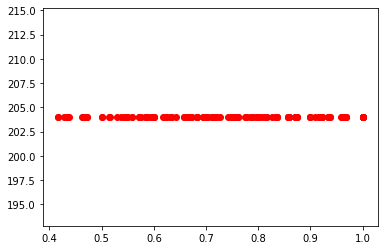

In [694]:
import matplotlib.pyplot as plt
plt.plot(auc_list, t_list, 'ro')
plt.show()

3521

In [623]:
from sklearn.model_selection import KFold

In [639]:
kf = KFold(n_splits=4, shuffle=False, random_state=None)
kf.get_n_splits(X)

for train_i, test_i in kf.split(X):
    X_train, X_valid = X.iloc[train_i], X.iloc[test_i]
    y_train, y_valid = y.iloc[train_i], y.iloc[test_i]

TRAIN: [ 881  882  883 ... 3518 3519 3520] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

In [695]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

t_list= []
tt_list=[]
auc_list=[]
p = 0
max_auc =0
max_auc_col_list = []
train = pd.read_csv('miem-hse-ais-2022-lab-01/train.csv')   #../input/miem-hse-ais-lab-01/train.csv
test = pd.read_csv('miem-hse-ais-2022-lab-01/test.csv')     #../input/miem-hse-ais-lab-01/test.csv

binary_columns = [x for x in train.columns if train[x].dtype.name == 'object']
categorical_columns = ['Device_Protection', 'Type_contract', 'Paperless_Billing', 'Payment_Method']
for x in categorical_columns:
    binary_columns.remove(x)

binary_columns.remove('Total_Payment')
train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], errors='coerce')
test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], errors='coerce')

for col in binary_columns:
    le = LabelEncoder().fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(train[col].values)
    test[col] = le.transform(test[col].values)

for col in categorical_columns:
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(train[[col]])
    train = train.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    train = train.drop(col, axis=1)

    oe_results = oe_style.fit_transform(test[[col]])
    test = test.join(pd.DataFrame(oe_results.toarray(), columns=[str(x) + '_' + c for x in oe_style.categories_[0]]))
    test = test.drop(col, axis=1)

features = list(train.columns.values)
features.remove('id')
features.remove('Leave_Next_Month')

train = pd.DataFrame(train, dtype=float)
test = pd.DataFrame(test, dtype=float)
test['Leave_Next_Month'] = 0
X = train[features]
y = pd.concat((train['id'], train['Leave_Next_Month']), axis=1)

split_n = range(2, )

for splt in np.arange(10, 15, 20):
    for rndm in np.arange(1, 2000, 1):
        
        #, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 1700)
        kf = KFold(n_splits=splt, shuffle=True, random_state=rndm)
        kf.get_n_splits(X)

        for train_index, test_index in kf.split(X):
            X_train, X_valid = X.iloc[train_i], X.iloc[test_i]
            y_train, y_valid = y.iloc[train_i], y.iloc[test_i]
        
        params_xgb = {
            "objective": "binary:logistic",
            "eval_metric": 'logloss',
            "eta": 0.12,
            "gamma": 4,
            "max_depth": 2,
            "subsample": 0.7,
            "colsample_bytree": 0.7,
            "verbosity": 0,
            "silent": True,
        }
        num_boost_round = 100
        early_stopping_rounds = 100
        
        dtrain = xgb.DMatrix(X_train.values, y_train['Leave_Next_Month'].values)
        dvalid = xgb.DMatrix(X_valid.values, y_valid['Leave_Next_Month'].values)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(params_xgb, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

        pred = model.predict(xgb.DMatrix(X_valid.values), ntree_limit=model.best_iteration + 1)
        prediction = np.round(pred)
        #print(prediction)
        accuracy = accuracy_score(y_valid['Leave_Next_Month'].values, prediction)
        auc = roc_auc_score(y_valid['Leave_Next_Month'].values, prediction)
        print('Accuracy: {:.2f} %, ROC AUC: {:.2f}'.format(100*accuracy, auc))
        print('n_splits: {0}, random_state: {1}'.format(splt, rndm))
        t_list.append(splt)
        tt_list.append(rndm)
        auc_list.append(auc)
        if auc == max_auc:
            max_auc_col_list.append([binary_columns, categorical_columns])
        elif auc > max_auc:
            max_auc = auc 
            max_auc_col_list = []
            max_auc_col_list.append([splt, rndm])
        print(p)
        p=p+1
        print('List of col: {0} of 87500'.format(p))

[0]	train-logloss:0.64923	eval-logloss:0.64749
[10]	train-logloss:0.47176	eval-logloss:0.46293
[20]	train-logloss:0.42693	eval-logloss:0.41513
[30]	train-logloss:0.41037	eval-logloss:0.39724
[40]	train-logloss:0.40195	eval-logloss:0.38984
[50]	train-logloss:0.39682	eval-logloss:0.38703
[60]	train-logloss:0.39350	eval-logloss:0.38482
[70]	train-logloss:0.39161	eval-logloss:0.38298
[80]	train-logloss:0.38995	eval-logloss:0.38299
[90]	train-logloss:0.38828	eval-logloss:0.38270
[99]	train-logloss:0.38755	eval-logloss:0.38287
Accuracy: 81.82 %, ROC AUC: 0.75
n_splits: 10, random_state: 1
0
List of col: 1 of 87500
[0]	train-logloss:0.65014	eval-logloss:0.64414
[10]	train-logloss:0.47456	eval-logloss:0.44428
[20]	train-logloss:0.43057	eval-logloss:0.39039
[30]	train-logloss:0.41409	eval-logloss:0.37276
[40]	train-logloss:0.40457	eval-logloss:0.36262
[50]	train-logloss:0.39878	eval-logloss:0.35569


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[60]	train-logloss:0.39543	eval-logloss:0.35141
[70]	train-logloss:0.39358	eval-logloss:0.35116
[80]	train-logloss:0.39245	eval-logloss:0.35055
[90]	train-logloss:0.39136	eval-logloss:0.35019
[99]	train-logloss:0.39046	eval-logloss:0.34935
Accuracy: 85.51 %, ROC AUC: 0.78
n_splits: 10, random_state: 2
1
List of col: 2 of 87500
[0]	train-logloss:0.64949	eval-logloss:0.65234
[10]	train-logloss:0.47006	eval-logloss:0.48535
[20]	train-logloss:0.42559	eval-logloss:0.44167
[30]	train-logloss:0.40718	eval-logloss:0.42534
[40]	train-logloss:0.39708	eval-logloss:0.42100

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39144	eval-logloss:0.41901
[60]	train-logloss:0.38797	eval-logloss:0.41651
[70]	train-logloss:0.38487	eval-logloss:0.41604
[80]	train-logloss:0.38344	eval-logloss:0.41551
[90]	train-logloss:0.38153	eval-logloss:0.41681
[99]	train-logloss:0.38077	eval-logloss:0.41663
Accuracy: 80.11 %, ROC AUC: 0.74
n_splits: 10, random_state: 3
2
List of col: 3 of 87500
[0]	train-logloss:0.64916	eval-logloss:0.65356
[10]	train-logloss:0.46766	eval-logloss:0.48727
[20]	train-logloss:0.42304	eval-logloss:0.45294
[30]	train-logloss:0.40465	eval-logloss:0.44491
[40]	train-logloss:0.39518	eval-logloss:0.44507


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.38915	eval-logloss:0.44628
[60]	train-logloss:0.38537	eval-logloss:0.45189
[70]	train-logloss:0.38236	eval-logloss:0.45317
[80]	train-logloss:0.38041	eval-logloss:0.45388
[90]	train-logloss:0.37858	eval-logloss:0.45506
[99]	train-logloss:0.37738	eval-logloss:0.45664
Accuracy: 76.99 %, ROC AUC: 0.69
n_splits: 10, random_state: 4
3
List of col: 4 of 87500
[0]	train-logloss:0.64878	eval-logloss:0.65139
[10]	train-logloss:0.46837	eval-logloss:0.48764
[20]	train-logloss:0.42364	eval-logloss:0.44545
[30]	train-logloss:0.40705	eval-logloss:0.42727
[40]	train-logloss:0.39791	eval-logloss:0.42150
[50]	train-logloss:0.39198	eval-logloss:0.41732

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38902	eval-logloss:0.41292
[70]	train-logloss:0.38639	eval-logloss:0.41176
[80]	train-logloss:0.38415	eval-logloss:0.41288
[90]	train-logloss:0.38295	eval-logloss:0.41472
[99]	train-logloss:0.38145	eval-logloss:0.41482
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 5
4
List of col: 5 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.64935
[10]	train-logloss:0.47080	eval-logloss:0.46917
[20]	train-logloss:0.42786	eval-logloss:0.41611
[30]	train-logloss:0.41076	eval-logloss:0.39875
[40]	train-logloss:0.40135	eval-logloss:0.39049


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39435	eval-logloss:0.38367
[60]	train-logloss:0.39115	eval-logloss:0.38079
[70]	train-logloss:0.38879	eval-logloss:0.37814
[80]	train-logloss:0.38815	eval-logloss:0.37838
[90]	train-logloss:0.38592	eval-logloss:0.37869
[99]	train-logloss:0.38532	eval-logloss:0.37895
Accuracy: 83.52 %, ROC AUC: 0.78
n_splits: 10, random_state: 6
5
List of col: 6 of 87500
[0]	train-logloss:0.64864	eval-logloss:0.65308
[10]	train-logloss:0.46809	eval-logloss:0.49536
[20]	train-logloss:0.42295	eval-logloss:0.46331
[30]	train-logloss:0.40455	eval-logloss:0.45168
[40]	train-logloss:0.39520	eval-logloss:0.44634
[50]	train-logloss:0.38949	eval-logloss:0.44278

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38683	eval-logloss:0.44418
[70]	train-logloss:0.38495	eval-logloss:0.44278
[80]	train-logloss:0.38366	eval-logloss:0.44316
[90]	train-logloss:0.38200	eval-logloss:0.44342
[99]	train-logloss:0.38091	eval-logloss:0.44216
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 7
6
List of col: 7 of 87500
[0]	train-logloss:0.64786	eval-logloss:0.65483
[10]	train-logloss:0.46411	eval-logloss:0.51617
[20]	train-logloss:0.41815	eval-logloss:0.49389
[30]	train-logloss:0.39966	eval-logloss:0.48891
[40]	train-logloss:0.39039	eval-logloss:0.48625
[50]	train-logloss:0.38388	eval-logloss:0.48622


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[60]	train-logloss:0.38091	eval-logloss:0.48551
[70]	train-logloss:0.37958	eval-logloss:0.48557
[80]	train-logloss:0.37810	eval-logloss:0.48592
[90]	train-logloss:0.37649	eval-logloss:0.48489
[99]	train-logloss:0.37557	eval-logloss:0.48466
Accuracy: 78.41 %, ROC AUC: 0.72
n_splits: 10, random_state: 8
7
List of col: 8 of 87500
[0]	train-logloss:0.64918	eval-logloss:0.64658
[10]	train-logloss:0.47086	eval-logloss:0.46926
[20]	train-logloss:0.42763	eval-logloss:0.42600
[30]	train-logloss:0.41092	eval-logloss:0.41060
[40]	train-logloss:0.40051	eval-logloss:0.40173
[50]	train-logloss:0.39464	eval-logloss:0.39711

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39132	eval-logloss:0.39641
[70]	train-logloss:0.38919	eval-logloss:0.39622
[80]	train-logloss:0.38757	eval-logloss:0.39662
[90]	train-logloss:0.38504	eval-logloss:0.39742
[99]	train-logloss:0.38455	eval-logloss:0.39742
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 9
8
List of col: 9 of 87500
[0]	train-logloss:0.64866	eval-logloss:0.65248
[10]	train-logloss:0.46818	eval-logloss:0.48940
[20]	train-logloss:0.42432	eval-logloss:0.44944
[30]	train-logloss:0.40625	eval-logloss:0.43499
[40]	train-logloss:0.39763	eval-logloss:0.43163
[50]	train-logloss:0.39278	eval-logloss:0.42625


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[60]	train-logloss:0.38975	eval-logloss:0.42501
[70]	train-logloss:0.38732	eval-logloss:0.42205
[80]	train-logloss:0.38484	eval-logloss:0.42170
[90]	train-logloss:0.38314	eval-logloss:0.42245
[99]	train-logloss:0.38290	eval-logloss:0.42142
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 10
9
List of col: 10 of 87500
[0]	train-logloss:0.64953	eval-logloss:0.65016
[10]	train-logloss:0.47084	eval-logloss:0.47080
[20]	train-logloss:0.42647	eval-logloss:0.42321
[30]	train-logloss:0.40927	eval-logloss:0.40863


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40097	eval-logloss:0.40037
[50]	train-logloss:0.39520	eval-logloss:0.39693
[60]	train-logloss:0.39182	eval-logloss:0.39519
[70]	train-logloss:0.38869	eval-logloss:0.39313
[80]	train-logloss:0.38681	eval-logloss:0.39285
[90]	train-logloss:0.38555	eval-logloss:0.39336
[99]	train-logloss:0.38494	eval-logloss:0.39443
Accuracy: 80.40 %, ROC AUC: 0.76
n_splits: 10, random_state: 11
10
List of col: 11 of 87500
[0]	train-logloss:0.64838	eval-logloss:0.65459
[10]	train-logloss:0.46545	eval-logloss:0.50752
[20]	train-logloss:0.42118	eval-logloss:0.47312
[30]	train-logloss:0.40287	eval-logloss:0.46346
[40]	train-logloss:0.39429	eval-logloss:0.45885


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.38903	eval-logloss:0.45594
[60]	train-logloss:0.38525	eval-logloss:0.45511
[70]	train-logloss:0.38283	eval-logloss:0.45727
[80]	train-logloss:0.38028	eval-logloss:0.45825
[90]	train-logloss:0.37880	eval-logloss:0.45737
[99]	train-logloss:0.37794	eval-logloss:0.45693
Accuracy: 77.84 %, ROC AUC: 0.70
n_splits: 10, random_state: 12
11
List of col: 12 of 87500
[0]	train-logloss:0.64955	eval-logloss:0.65133
[10]	train-logloss:0.46707	eval-logloss:0.48644
[20]	train-logloss:0.42286	eval-logloss:0.45419
[30]	train-logloss:0.40589	eval-logloss:0.44340
[40]	train-logloss:0.39619	eval-logloss:0.43898
[50]	train-logloss:0.39049	eval-logloss:0.43819


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[60]	train-logloss:0.38821	eval-logloss:0.43813
[70]	train-logloss:0.38508	eval-logloss:0.43765
[80]	train-logloss:0.38205	eval-logloss:0.43890
[90]	train-logloss:0.38072	eval-logloss:0.43900
[99]	train-logloss:0.37998	eval-logloss:0.43897
Accuracy: 76.70 %, ROC AUC: 0.65
n_splits: 10, random_state: 13
12
List of col: 13 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.65120
[10]	train-logloss:0.46890	eval-logloss:0.48290
[20]	train-logloss:0.42617	eval-logloss:0.44341
[30]	train-logloss:0.40845	eval-logloss:0.42793
[40]	train-logloss:0.39814	eval-logloss:0.42482
[50]	train-logloss:0.39227	eval-logloss:0.42199

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38905	eval-logloss:0.42342
[70]	train-logloss:0.38669	eval-logloss:0.42203
[80]	train-logloss:0.38419	eval-logloss:0.42376
[90]	train-logloss:0.38267	eval-logloss:0.42334
[99]	train-logloss:0.38210	eval-logloss:0.42285
Accuracy: 77.84 %, ROC AUC: 0.70
n_splits: 10, random_state: 14
13
List of col: 14 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.64905
[10]	train-logloss:0.47229	eval-logloss:0.46579
[20]	train-logloss:0.42809	eval-logloss:0.42632
[30]	train-logloss:0.40986	eval-logloss:0.41078
[40]	train-logloss:0.40155	eval-logloss:0.40110
[50]	train-logloss:0.39549	eval-logloss:0.39926

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39340	eval-logloss:0.40145
[70]	train-logloss:0.39097	eval-logloss:0.39979
[80]	train-logloss:0.38940	eval-logloss:0.39905
[90]	train-logloss:0.38811	eval-logloss:0.39851
[99]	train-logloss:0.38656	eval-logloss:0.39899
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 15
14
List of col: 15 of 87500
[0]	train-logloss:0.64883	eval-logloss:0.65270
[10]	train-logloss:0.46782	eval-logloss:0.49074
[20]	train-logloss:0.42352	eval-logloss:0.45374
[30]	train-logloss:0.40665	eval-logloss:0.43826
[40]	train-logloss:0.39760	eval-logloss:0.43042
[50]	train-logloss:0.39329	eval-logloss:0.42858

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38994	eval-logloss:0.42601
[70]	train-logloss:0.38767	eval-logloss:0.42336
[80]	train-logloss:0.38504	eval-logloss:0.42266
[90]	train-logloss:0.38292	eval-logloss:0.42353
[99]	train-logloss:0.38112	eval-logloss:0.42204
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 16
15
List of col: 16 of 87500
[0]	train-logloss:0.64916	eval-logloss:0.65043
[10]	train-logloss:0.47131	eval-logloss:0.47451
[20]	train-logloss:0.42646	eval-logloss:0.43002
[30]	train-logloss:0.40948	eval-logloss:0.41264
[40]	train-logloss:0.40039	eval-logloss:0.39851


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39506	eval-logloss:0.39425
[60]	train-logloss:0.39187	eval-logloss:0.39304
[70]	train-logloss:0.38999	eval-logloss:0.39078
[80]	train-logloss:0.38817	eval-logloss:0.39100
[90]	train-logloss:0.38649	eval-logloss:0.38946
[99]	train-logloss:0.38492	eval-logloss:0.38881
Accuracy: 82.39 %, ROC AUC: 0.73
n_splits: 10, random_state: 17
16
List of col: 17 of 87500
[0]	train-logloss:0.65041	eval-logloss:0.64573
[10]	train-logloss:0.47362	eval-logloss:0.45605
[20]	train-logloss:0.42878	eval-logloss:0.40981
[30]	train-logloss:0.41098	eval-logloss:0.39455
[40]	train-logloss:0.40180	eval-logloss:0.38865


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39609	eval-logloss:0.38591
[60]	train-logloss:0.39226	eval-logloss:0.38284
[70]	train-logloss:0.39037	eval-logloss:0.38102
[80]	train-logloss:0.38951	eval-logloss:0.38106
[90]	train-logloss:0.38725	eval-logloss:0.38315
[99]	train-logloss:0.38666	eval-logloss:0.38379
Accuracy: 82.10 %, ROC AUC: 0.72
n_splits: 10, random_state: 18
17
List of col: 18 of 87500
[0]	train-logloss:0.64974	eval-logloss:0.64642
[10]	train-logloss:0.47300	eval-logloss:0.45196
[20]	train-logloss:0.42989	eval-logloss:0.40198
[30]	train-logloss:0.41153	eval-logloss:0.38098
[40]	train-logloss:0.40314	eval-logloss:0.37423


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39798	eval-logloss:0.36983
[60]	train-logloss:0.39494	eval-logloss:0.36691
[70]	train-logloss:0.39286	eval-logloss:0.36556
[80]	train-logloss:0.39168	eval-logloss:0.36461
[90]	train-logloss:0.38934	eval-logloss:0.36368
[99]	train-logloss:0.38823	eval-logloss:0.36335
Accuracy: 82.67 %, ROC AUC: 0.73
n_splits: 10, random_state: 19
18
List of col: 19 of 87500
[0]	train-logloss:0.65011	eval-logloss:0.64868
[10]	train-logloss:0.47187	eval-logloss:0.47305
[20]	train-logloss:0.42642	eval-logloss:0.43096
[30]	train-logloss:0.40753	eval-logloss:0.42012
[40]	train-logloss:0.39806	eval-logloss:0.41750
[50]	train-logloss:0.39184	eval-logloss:0.41707

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38856	eval-logloss:0.41767
[70]	train-logloss:0.38580	eval-logloss:0.41933
[80]	train-logloss:0.38317	eval-logloss:0.41961
[90]	train-logloss:0.38191	eval-logloss:0.41985
[99]	train-logloss:0.38010	eval-logloss:0.41978
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 20
19
List of col: 20 of 87500
[0]	train-logloss:0.64950	eval-logloss:0.65160
[10]	train-logloss:0.46854	eval-logloss:0.48782
[20]	train-logloss:0.42263	eval-logloss:0.45965
[30]	train-logloss:0.40426	eval-logloss:0.45022


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39471	eval-logloss:0.44759
[50]	train-logloss:0.38969	eval-logloss:0.45066
[60]	train-logloss:0.38576	eval-logloss:0.45084
[70]	train-logloss:0.38291	eval-logloss:0.45326
[80]	train-logloss:0.38067	eval-logloss:0.45406
[90]	train-logloss:0.37921	eval-logloss:0.45563
[99]	train-logloss:0.37769	eval-logloss:0.45612
Accuracy: 78.98 %, ROC AUC: 0.71
n_splits: 10, random_state: 21
20
List of col: 21 of 87500
[0]	train-logloss:0.64882	eval-logloss:0.65354
[10]	train-logloss:0.46580	eval-logloss:0.49747
[20]	train-logloss:0.42203	eval-logloss:0.46586
[30]	train-logloss:0.40271	eval-logloss:0.45782
[40]	train-logloss:0.39429	eval-logloss:0.45723
[50]	train-logloss:0.38848	eval-logloss:0.45502

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38596	eval-logloss:0.45562
[70]	train-logloss:0.38322	eval-logloss:0.45603
[80]	train-logloss:0.38131	eval-logloss:0.45610
[90]	train-logloss:0.38032	eval-logloss:0.45533
[99]	train-logloss:0.37941	eval-logloss:0.45577
Accuracy: 75.00 %, ROC AUC: 0.67
n_splits: 10, random_state: 22
21
List of col: 22 of 87500
[0]	train-logloss:0.65084	eval-logloss:0.64905
[10]	train-logloss:0.47455	eval-logloss:0.45469
[20]	train-logloss:0.43125	eval-logloss:0.40326
[30]	train-logloss:0.41486	eval-logloss:0.38034
[40]	train-logloss:0.40475	eval-logloss:0.37078


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.40021	eval-logloss:0.36526
[60]	train-logloss:0.39620	eval-logloss:0.36188
[70]	train-logloss:0.39355	eval-logloss:0.35905
[80]	train-logloss:0.39148	eval-logloss:0.35935
[90]	train-logloss:0.39022	eval-logloss:0.35802
[99]	train-logloss:0.38894	eval-logloss:0.35836
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 23
22
List of col: 23 of 87500
[0]	train-logloss:0.64996	eval-logloss:0.65088
[10]	train-logloss:0.46880	eval-logloss:0.48259
[20]	train-logloss:0.42493	eval-logloss:0.44654
[30]	train-logloss:0.40733	eval-logloss:0.43184
[40]	train-logloss:0.39809	eval-logloss:0.42045
[50]	train-logloss:0.39212	eval-logloss:0.41751

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38851	eval-logloss:0.41347
[70]	train-logloss:0.38542	eval-logloss:0.41173
[80]	train-logloss:0.38430	eval-logloss:0.41130
[90]	train-logloss:0.38280	eval-logloss:0.41047
[99]	train-logloss:0.38114	eval-logloss:0.41190
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 24
23
List of col: 24 of 87500
[0]	train-logloss:0.64981	eval-logloss:0.65218
[10]	train-logloss:0.46983	eval-logloss:0.47613
[20]	train-logloss:0.42549	eval-logloss:0.43572
[30]	train-logloss:0.40752	eval-logloss:0.42239
[40]	train-logloss:0.39873	eval-logloss:0.41856
[50]	train-logloss:0.39323	eval-logloss:0.41795

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38998	eval-logloss:0.41546
[70]	train-logloss:0.38737	eval-logloss:0.41401
[80]	train-logloss:0.38598	eval-logloss:0.41491
[90]	train-logloss:0.38437	eval-logloss:0.41253
[99]	train-logloss:0.38345	eval-logloss:0.41270
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 25
24
List of col: 25 of 87500
[0]	train-logloss:0.64897	eval-logloss:0.65045
[10]	train-logloss:0.47040	eval-logloss:0.47988
[20]	train-logloss:0.42486	eval-logloss:0.44027
[30]	train-logloss:0.40800	eval-logloss:0.42829
[40]	train-logloss:0.39895	eval-logloss:0.42168
[50]	train-logloss:0.39311	eval-logloss:0.41763

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38967	eval-logloss:0.41443
[70]	train-logloss:0.38881	eval-logloss:0.41357
[80]	train-logloss:0.38695	eval-logloss:0.41282
[90]	train-logloss:0.38527	eval-logloss:0.41255
[99]	train-logloss:0.38422	eval-logloss:0.41127
Accuracy: 80.11 %, ROC AUC: 0.73
n_splits: 10, random_state: 26
25
List of col: 26 of 87500
[0]	train-logloss:0.64849	eval-logloss:0.65650
[10]	train-logloss:0.46593	eval-logloss:0.50470
[20]	train-logloss:0.42091	eval-logloss:0.46962
[30]	train-logloss:0.40224	eval-logloss:0.46544
[40]	train-logloss:0.39325	eval-logloss:0.45933


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.38789	eval-logloss:0.45788
[60]	train-logloss:0.38462	eval-logloss:0.45728
[70]	train-logloss:0.38321	eval-logloss:0.45657
[80]	train-logloss:0.38120	eval-logloss:0.45934
[90]	train-logloss:0.37900	eval-logloss:0.45835
[99]	train-logloss:0.37820	eval-logloss:0.45916
Accuracy: 75.57 %, ROC AUC: 0.66
n_splits: 10, random_state: 27
26
List of col: 27 of 87500
[0]	train-logloss:0.64999	eval-logloss:0.64958
[10]	train-logloss:0.47146	eval-logloss:0.46313
[20]	train-logloss:0.42772	eval-logloss:0.41351
[30]	train-logloss:0.41072	eval-logloss:0.39880
[40]	train-logloss:0.40149	eval-logloss:0.39054


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39612	eval-logloss:0.38716
[60]	train-logloss:0.39296	eval-logloss:0.38645
[70]	train-logloss:0.39078	eval-logloss:0.38521
[80]	train-logloss:0.38924	eval-logloss:0.38431
[90]	train-logloss:0.38811	eval-logloss:0.38378
[99]	train-logloss:0.38698	eval-logloss:0.38264
Accuracy: 83.81 %, ROC AUC: 0.76
n_splits: 10, random_state: 28
27
List of col: 28 of 87500
[0]	train-logloss:0.64931	eval-logloss:0.64833
[10]	train-logloss:0.47354	eval-logloss:0.45620
[20]	train-logloss:0.43053	eval-logloss:0.40442
[30]	train-logloss:0.41328	eval-logloss:0.38165
[40]	train-logloss:0.40414	eval-logloss:0.37112
[50]	train-logloss:0.39888	eval-logloss:0.36400

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39576	eval-logloss:0.36130
[70]	train-logloss:0.39358	eval-logloss:0.35938
[80]	train-logloss:0.39239	eval-logloss:0.35923
[90]	train-logloss:0.39067	eval-logloss:0.35792
[99]	train-logloss:0.38940	eval-logloss:0.35640
Accuracy: 83.81 %, ROC AUC: 0.77
n_splits: 10, random_state: 29
28
List of col: 29 of 87500
[0]	train-logloss:0.64886	eval-logloss:0.65190
[10]	train-logloss:0.46878	eval-logloss:0.48841
[20]	train-logloss:0.42394	eval-logloss:0.44750
[30]	train-logloss:0.40608	eval-logloss:0.43321
[40]	train-logloss:0.39636	eval-logloss:0.42835

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39063	eval-logloss:0.42402
[60]	train-logloss:0.38755	eval-logloss:0.42341
[70]	train-logloss:0.38491	eval-logloss:0.42221
[80]	train-logloss:0.38268	eval-logloss:0.42380
[90]	train-logloss:0.38066	eval-logloss:0.42479
[99]	train-logloss:0.37949	eval-logloss:0.42464
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 30
29
List of col: 30 of 87500
[0]	train-logloss:0.64919	eval-logloss:0.65326
[10]	train-logloss:0.46659	eval-logloss:0.49681
[20]	train-logloss:0.42090	eval-logloss:0.46694
[30]	train-logloss:0.40408	eval-logloss:0.45672
[40]	train-logloss:0.39519	eval-logloss:0.44887


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.38993	eval-logloss:0.44697
[60]	train-logloss:0.38648	eval-logloss:0.44454
[70]	train-logloss:0.38329	eval-logloss:0.44536
[80]	train-logloss:0.38173	eval-logloss:0.44355
[90]	train-logloss:0.38006	eval-logloss:0.44400
[99]	train-logloss:0.37939	eval-logloss:0.44301
Accuracy: 77.56 %, ROC AUC: 0.69
n_splits: 10, random_state: 31
30
List of col: 31 of 87500
[0]	train-logloss:0.64886	eval-logloss:0.65525
[10]	train-logloss:0.46814	eval-logloss:0.49189
[20]	train-logloss:0.42490	eval-logloss:0.45359
[30]	train-logloss:0.40742	eval-logloss:0.43426
[40]	train-logloss:0.39849	eval-logloss:0.42306
[50]	train-logloss:0.39423	eval-logloss:0.41628

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39035	eval-logloss:0.41293
[70]	train-logloss:0.38794	eval-logloss:0.41123
[80]	train-logloss:0.38617	eval-logloss:0.41033
[90]	train-logloss:0.38427	eval-logloss:0.40691
[99]	train-logloss:0.38352	eval-logloss:0.40736
Accuracy: 79.55 %, ROC AUC: 0.73
n_splits: 10, random_state: 32
31
List of col: 32 of 87500
[0]	train-logloss:0.64911	eval-logloss:0.65079
[10]	train-logloss:0.46733	eval-logloss:0.48471
[20]	train-logloss:0.42184	eval-logloss:0.45126
[30]	train-logloss:0.40381	eval-logloss:0.44170
[40]	train-logloss:0.39574	eval-logloss:0.43927
[50]	train-logloss:0.38952	eval-logloss:0.44178

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38631	eval-logloss:0.44216
[70]	train-logloss:0.38365	eval-logloss:0.44381
[80]	train-logloss:0.38113	eval-logloss:0.44390
[90]	train-logloss:0.37921	eval-logloss:0.44360
[99]	train-logloss:0.37843	eval-logloss:0.44305
Accuracy: 78.98 %, ROC AUC: 0.71
n_splits: 10, random_state: 33
32
List of col: 33 of 87500
[0]	train-logloss:0.64954	eval-logloss:0.65116
[10]	train-logloss:0.47145	eval-logloss:0.47369
[20]	train-logloss:0.42765	eval-logloss:0.43052
[30]	train-logloss:0.40964	eval-logloss:0.41482
[40]	train-logloss:0.40062	eval-logloss:0.40663


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39427	eval-logloss:0.40240
[60]	train-logloss:0.39141	eval-logloss:0.40147
[70]	train-logloss:0.38916	eval-logloss:0.39927
[80]	train-logloss:0.38771	eval-logloss:0.39865
[90]	train-logloss:0.38603	eval-logloss:0.39732
[99]	train-logloss:0.38543	eval-logloss:0.39704
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 34
33
List of col: 34 of 87500
[0]	train-logloss:0.64901	eval-logloss:0.65332
[10]	train-logloss:0.46628	eval-logloss:0.51142
[20]	train-logloss:0.42111	eval-logloss:0.47785
[30]	train-logloss:0.40313	eval-logloss:0.46463
[40]	train-logloss:0.39427	eval-logloss:0.45785


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.38906	eval-logloss:0.45429
[60]	train-logloss:0.38653	eval-logloss:0.45189
[70]	train-logloss:0.38414	eval-logloss:0.45346
[80]	train-logloss:0.38249	eval-logloss:0.45336
[90]	train-logloss:0.38067	eval-logloss:0.45159
[99]	train-logloss:0.37911	eval-logloss:0.45192
Accuracy: 78.41 %, ROC AUC: 0.70
n_splits: 10, random_state: 35
34
List of col: 35 of 87500
[0]	train-logloss:0.64964	eval-logloss:0.65151
[10]	train-logloss:0.46938	eval-logloss:0.47925
[20]	train-logloss:0.42543	eval-logloss:0.43416
[30]	train-logloss:0.40839	eval-logloss:0.41299
[40]	train-logloss:0.40003	eval-logloss:0.40540


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39487	eval-logloss:0.39973
[60]	train-logloss:0.39203	eval-logloss:0.39797
[70]	train-logloss:0.39011	eval-logloss:0.39609
[80]	train-logloss:0.38783	eval-logloss:0.39348
[90]	train-logloss:0.38621	eval-logloss:0.39310
[99]	train-logloss:0.38559	eval-logloss:0.39271
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 36
35
List of col: 36 of 87500
[0]	train-logloss:0.64967	eval-logloss:0.64730
[10]	train-logloss:0.47085	eval-logloss:0.47076
[20]	train-logloss:0.42598	eval-logloss:0.42458
[30]	train-logloss:0.40919	eval-logloss:0.40775
[40]	train-logloss:0.40013	eval-logloss:0.39994
[50]	train-logloss:0.39423	eval-logloss:0.39719

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39071	eval-logloss:0.39675
[70]	train-logloss:0.38983	eval-logloss:0.39707
[80]	train-logloss:0.38735	eval-logloss:0.39632
[90]	train-logloss:0.38558	eval-logloss:0.39537
[99]	train-logloss:0.38401	eval-logloss:0.39437
Accuracy: 82.10 %, ROC AUC: 0.70
n_splits: 10, random_state: 37
36
List of col: 37 of 87500
[0]	train-logloss:0.65000	eval-logloss:0.64856
[10]	train-logloss:0.47227	eval-logloss:0.46172
[20]	train-logloss:0.42839	eval-logloss:0.41476
[30]	train-logloss:0.40958	eval-logloss:0.39746
[40]	train-logloss:0.40045	eval-logloss:0.39038


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39453	eval-logloss:0.38659
[60]	train-logloss:0.39131	eval-logloss:0.38563
[70]	train-logloss:0.38910	eval-logloss:0.38592
[80]	train-logloss:0.38726	eval-logloss:0.38677
[90]	train-logloss:0.38525	eval-logloss:0.38413
[99]	train-logloss:0.38442	eval-logloss:0.38361
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 38
37
List of col: 38 of 87500
[0]	train-logloss:0.64844	eval-logloss:0.65195
[10]	train-logloss:0.46922	eval-logloss:0.49016
[20]	train-logloss:0.42443	eval-logloss:0.44978
[30]	train-logloss:0.40704	eval-logloss:0.43743
[40]	train-logloss:0.39720	eval-logloss:0.42959
[50]	train-logloss:0.39160	eval-logloss:0.42718

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38813	eval-logloss:0.42608
[70]	train-logloss:0.38605	eval-logloss:0.42561
[80]	train-logloss:0.38403	eval-logloss:0.42629
[90]	train-logloss:0.38179	eval-logloss:0.42681
[99]	train-logloss:0.38065	eval-logloss:0.42719
Accuracy: 78.98 %, ROC AUC: 0.71
n_splits: 10, random_state: 39
38
List of col: 39 of 87500
[0]	train-logloss:0.64946	eval-logloss:0.65049
[10]	train-logloss:0.46872	eval-logloss:0.48986
[20]	train-logloss:0.42337	eval-logloss:0.45307
[30]	train-logloss:0.40646	eval-logloss:0.44226
[40]	train-logloss:0.39717	eval-logloss:0.43623

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39162	eval-logloss:0.43324
[60]	train-logloss:0.38879	eval-logloss:0.43244
[70]	train-logloss:0.38602	eval-logloss:0.42974
[80]	train-logloss:0.38365	eval-logloss:0.42848
[90]	train-logloss:0.38259	eval-logloss:0.42809
[99]	train-logloss:0.38127	eval-logloss:0.42752
Accuracy: 78.41 %, ROC AUC: 0.71
n_splits: 10, random_state: 40
39
List of col: 40 of 87500
[0]	train-logloss:0.65022	eval-logloss:0.64491
[10]	train-logloss:0.47391	eval-logloss:0.45100
[20]	train-logloss:0.43002	eval-logloss:0.39877
[30]	train-logloss:0.41243	eval-logloss:0.38123
[40]	train-logloss:0.40257	eval-logloss:0.37619
[50]	train-logloss:0.39602	eval-logloss:0.37564

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39299	eval-logloss:0.37336
[70]	train-logloss:0.39057	eval-logloss:0.37454
[80]	train-logloss:0.38895	eval-logloss:0.37370
[90]	train-logloss:0.38717	eval-logloss:0.37403
[99]	train-logloss:0.38676	eval-logloss:0.37317
Accuracy: 84.09 %, ROC AUC: 0.78
n_splits: 10, random_state: 41
40
List of col: 41 of 87500
[0]	train-logloss:0.64984	eval-logloss:0.65252
[10]	train-logloss:0.46742	eval-logloss:0.48558
[20]	train-logloss:0.42315	eval-logloss:0.45123
[30]	train-logloss:0.40485	eval-logloss:0.44057
[40]	train-logloss:0.39525	eval-logloss:0.43685
[50]	train-logloss:0.38943	eval-logloss:0.43548

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38654	eval-logloss:0.43593
[70]	train-logloss:0.38402	eval-logloss:0.43376
[80]	train-logloss:0.38227	eval-logloss:0.43528
[90]	train-logloss:0.38109	eval-logloss:0.43398
[99]	train-logloss:0.37999	eval-logloss:0.43418
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 42
41
List of col: 42 of 87500
[0]	train-logloss:0.64852	eval-logloss:0.64919
[10]	train-logloss:0.46834	eval-logloss:0.47923
[20]	train-logloss:0.42202	eval-logloss:0.44901
[30]	train-logloss:0.40382	eval-logloss:0.44070
[40]	train-logloss:0.39537	eval-logloss:0.43836

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38931	eval-logloss:0.44091
[60]	train-logloss:0.38571	eval-logloss:0.44164
[70]	train-logloss:0.38329	eval-logloss:0.44182
[80]	train-logloss:0.38150	eval-logloss:0.44445
[90]	train-logloss:0.37964	eval-logloss:0.44470
[99]	train-logloss:0.37877	eval-logloss:0.44405
Accuracy: 79.83 %, ROC AUC: 0.67
n_splits: 10, random_state: 43
42
List of col: 43 of 87500
[0]	train-logloss:0.64842	eval-logloss:0.64948
[10]	train-logloss:0.46971	eval-logloss:0.47691
[20]	train-logloss:0.42457	eval-logloss:0.44327
[30]	train-logloss:0.40634	eval-logloss:0.43454
[40]	train-logloss:0.39720	eval-logloss:0.43084

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39039	eval-logloss:0.42561
[60]	train-logloss:0.38793	eval-logloss:0.42407
[70]	train-logloss:0.38623	eval-logloss:0.42155
[80]	train-logloss:0.38447	eval-logloss:0.42046
[90]	train-logloss:0.38291	eval-logloss:0.42282
[99]	train-logloss:0.38224	eval-logloss:0.42423
Accuracy: 78.98 %, ROC AUC: 0.70
n_splits: 10, random_state: 44
43
List of col: 44 of 87500
[0]	train-logloss:0.65068	eval-logloss:0.64575
[10]	train-logloss:0.47398	eval-logloss:0.45441
[20]	train-logloss:0.43029	eval-logloss:0.40199
[30]	train-logloss:0.41277	eval-logloss:0.38591
[40]	train-logloss:0.40290	eval-logloss:0.37640
[50]	train-logloss:0.39710	eval-logloss:0.37239

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39402	eval-logloss:0.37034
[70]	train-logloss:0.39227	eval-logloss:0.36885
[80]	train-logloss:0.39045	eval-logloss:0.36799
[90]	train-logloss:0.38924	eval-logloss:0.36861
[99]	train-logloss:0.38824	eval-logloss:0.36874
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 45
44
List of col: 45 of 87500
[0]	train-logloss:0.64993	eval-logloss:0.65084
[10]	train-logloss:0.47109	eval-logloss:0.46605
[20]	train-logloss:0.42741	eval-logloss:0.42209
[30]	train-logloss:0.40935	eval-logloss:0.40503
[40]	train-logloss:0.40018	eval-logloss:0.39980


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39427	eval-logloss:0.39843
[60]	train-logloss:0.39060	eval-logloss:0.39627
[70]	train-logloss:0.38772	eval-logloss:0.39551
[80]	train-logloss:0.38669	eval-logloss:0.39557
[90]	train-logloss:0.38453	eval-logloss:0.39332
[99]	train-logloss:0.38371	eval-logloss:0.39339
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 46
45
List of col: 46 of 87500
[0]	train-logloss:0.64986	eval-logloss:0.64781
[10]	train-logloss:0.47047	eval-logloss:0.47184
[20]	train-logloss:0.42565	eval-logloss:0.42803
[30]	train-logloss:0.40962	eval-logloss:0.40916
[40]	train-logloss:0.40093	eval-logloss:0.40100

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39496	eval-logloss:0.39484
[60]	train-logloss:0.39145	eval-logloss:0.39264
[70]	train-logloss:0.38968	eval-logloss:0.39182
[80]	train-logloss:0.38821	eval-logloss:0.39052
[90]	train-logloss:0.38666	eval-logloss:0.39007
[99]	train-logloss:0.38515	eval-logloss:0.39075
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 47
46
List of col: 47 of 87500
[0]	train-logloss:0.64908	eval-logloss:0.65079
[10]	train-logloss:0.47013	eval-logloss:0.48711
[20]	train-logloss:0.42616	eval-logloss:0.44485
[30]	train-logloss:0.40846	eval-logloss:0.42911
[40]	train-logloss:0.39964	eval-logloss:0.41903

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39454	eval-logloss:0.41231
[60]	train-logloss:0.39110	eval-logloss:0.41027
[70]	train-logloss:0.38904	eval-logloss:0.40944
[80]	train-logloss:0.38711	eval-logloss:0.40795
[90]	train-logloss:0.38640	eval-logloss:0.40679
[99]	train-logloss:0.38548	eval-logloss:0.40694
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 48
47
List of col: 48 of 87500
[0]	train-logloss:0.64925	eval-logloss:0.64785
[10]	train-logloss:0.47017	eval-logloss:0.48086
[20]	train-logloss:0.42515	eval-logloss:0.43768
[30]	train-logloss:0.40792	eval-logloss:0.42120


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39847	eval-logloss:0.41591
[50]	train-logloss:0.39249	eval-logloss:0.41190
[60]	train-logloss:0.38962	eval-logloss:0.41081
[70]	train-logloss:0.38818	eval-logloss:0.41034
[80]	train-logloss:0.38649	eval-logloss:0.41004
[90]	train-logloss:0.38553	eval-logloss:0.40984
[99]	train-logloss:0.38443	eval-logloss:0.41297
Accuracy: 82.10 %, ROC AUC: 0.74
n_splits: 10, random_state: 49
48
List of col: 49 of 87500
[0]	train-logloss:0.64948	eval-logloss:0.64918
[10]	train-logloss:0.47122	eval-logloss:0.46935
[20]	train-logloss:0.42743	eval-logloss:0.42378
[30]	train-logloss:0.41031	eval-logloss:0.40448
[40]	train-logloss:0.40080	eval-logloss:0.39581

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39508	eval-logloss:0.39073
[60]	train-logloss:0.39162	eval-logloss:0.38988
[70]	train-logloss:0.38878	eval-logloss:0.38811
[80]	train-logloss:0.38719	eval-logloss:0.38773
[90]	train-logloss:0.38582	eval-logloss:0.38737
[99]	train-logloss:0.38445	eval-logloss:0.38782
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 50
49
List of col: 50 of 87500
[0]	train-logloss:0.64996	eval-logloss:0.64874
[10]	train-logloss:0.47347	eval-logloss:0.46069
[20]	train-logloss:0.42921	eval-logloss:0.41644
[30]	train-logloss:0.41122	eval-logloss:0.39739
[40]	train-logloss:0.40239	eval-logloss:0.38945


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39737	eval-logloss:0.38651
[60]	train-logloss:0.39425	eval-logloss:0.38577
[70]	train-logloss:0.39210	eval-logloss:0.38340
[80]	train-logloss:0.39066	eval-logloss:0.38328
[90]	train-logloss:0.38899	eval-logloss:0.38376
[99]	train-logloss:0.38785	eval-logloss:0.38297
Accuracy: 83.81 %, ROC AUC: 0.73
n_splits: 10, random_state: 51
50
List of col: 51 of 87500
[0]	train-logloss:0.64945	eval-logloss:0.64971
[10]	train-logloss:0.47020	eval-logloss:0.47866
[20]	train-logloss:0.42617	eval-logloss:0.43826
[30]	train-logloss:0.40826	eval-logloss:0.42493
[40]	train-logloss:0.39915	eval-logloss:0.41654
[50]	train-logloss:0.39352	eval-logloss:0.41238

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39003	eval-logloss:0.40874
[70]	train-logloss:0.38798	eval-logloss:0.40782
[80]	train-logloss:0.38639	eval-logloss:0.40770
[90]	train-logloss:0.38371	eval-logloss:0.40565
[99]	train-logloss:0.38279	eval-logloss:0.40564
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 52
51
List of col: 52 of 87500
[0]	train-logloss:0.64875	eval-logloss:0.65034
[10]	train-logloss:0.46798	eval-logloss:0.48488
[20]	train-logloss:0.42361	eval-logloss:0.44375
[30]	train-logloss:0.40576	eval-logloss:0.43157
[40]	train-logloss:0.39660	eval-logloss:0.43041


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39035	eval-logloss:0.43027
[60]	train-logloss:0.38714	eval-logloss:0.42958
[70]	train-logloss:0.38504	eval-logloss:0.43239
[80]	train-logloss:0.38310	eval-logloss:0.43288
[90]	train-logloss:0.38107	eval-logloss:0.43170
[99]	train-logloss:0.37988	eval-logloss:0.43334
Accuracy: 78.69 %, ROC AUC: 0.70
n_splits: 10, random_state: 53
52
List of col: 53 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.64843
[10]	train-logloss:0.47268	eval-logloss:0.46099
[20]	train-logloss:0.42983	eval-logloss:0.41820
[30]	train-logloss:0.41156	eval-logloss:0.39750
[40]	train-logloss:0.40242	eval-logloss:0.38373


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39682	eval-logloss:0.38004
[60]	train-logloss:0.39360	eval-logloss:0.37928
[70]	train-logloss:0.39066	eval-logloss:0.37539
[80]	train-logloss:0.38853	eval-logloss:0.37326
[90]	train-logloss:0.38615	eval-logloss:0.37282
[99]	train-logloss:0.38499	eval-logloss:0.37246
Accuracy: 82.10 %, ROC AUC: 0.72
n_splits: 10, random_state: 54
53
List of col: 54 of 87500
[0]	train-logloss:0.64984	eval-logloss:0.64429
[10]	train-logloss:0.47435	eval-logloss:0.45008
[20]	train-logloss:0.43096	eval-logloss:0.40429
[30]	train-logloss:0.41212	eval-logloss:0.38548
[40]	train-logloss:0.40231	eval-logloss:0.37775

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39679	eval-logloss:0.37321
[60]	train-logloss:0.39419	eval-logloss:0.37098
[70]	train-logloss:0.39187	eval-logloss:0.36909
[80]	train-logloss:0.39001	eval-logloss:0.36741
[90]	train-logloss:0.38897	eval-logloss:0.36793
[99]	train-logloss:0.38776	eval-logloss:0.36800
Accuracy: 83.24 %, ROC AUC: 0.76
n_splits: 10, random_state: 55
54
List of col: 55 of 87500
[0]	train-logloss:0.64954	eval-logloss:0.65043
[10]	train-logloss:0.46999	eval-logloss:0.47306
[20]	train-logloss:0.42652	eval-logloss:0.43256
[30]	train-logloss:0.40893	eval-logloss:0.41482
[40]	train-logloss:0.39923	eval-logloss:0.40679

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39413	eval-logloss:0.40364
[60]	train-logloss:0.39118	eval-logloss:0.40213
[70]	train-logloss:0.38874	eval-logloss:0.40012
[80]	train-logloss:0.38646	eval-logloss:0.39858
[90]	train-logloss:0.38464	eval-logloss:0.39751
[99]	train-logloss:0.38364	eval-logloss:0.39772
Accuracy: 83.24 %, ROC AUC: 0.75
n_splits: 10, random_state: 56
55
List of col: 56 of 87500
[0]	train-logloss:0.64927	eval-logloss:0.65129
[10]	train-logloss:0.46972	eval-logloss:0.48583
[20]	train-logloss:0.42551	eval-logloss:0.44938
[30]	train-logloss:0.40740	eval-logloss:0.43503
[40]	train-logloss:0.39908	eval-logloss:0.42613

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39223	eval-logloss:0.42049
[60]	train-logloss:0.38893	eval-logloss:0.41658
[70]	train-logloss:0.38720	eval-logloss:0.41467
[80]	train-logloss:0.38601	eval-logloss:0.41376
[90]	train-logloss:0.38432	eval-logloss:0.41374
[99]	train-logloss:0.38356	eval-logloss:0.41418
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 57
56
List of col: 57 of 87500
[0]	train-logloss:0.65056	eval-logloss:0.64506
[10]	train-logloss:0.47375	eval-logloss:0.44585
[20]	train-logloss:0.43044	eval-logloss:0.39868
[30]	train-logloss:0.41343	eval-logloss:0.38075
[40]	train-logloss:0.40387	eval-logloss:0.37209

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39819	eval-logloss:0.36813
[60]	train-logloss:0.39504	eval-logloss:0.36377
[70]	train-logloss:0.39192	eval-logloss:0.36327
[80]	train-logloss:0.39103	eval-logloss:0.36309
[90]	train-logloss:0.38960	eval-logloss:0.36268
[99]	train-logloss:0.38878	eval-logloss:0.36239
Accuracy: 82.39 %, ROC AUC: 0.71
n_splits: 10, random_state: 58
57
List of col: 58 of 87500
[0]	train-logloss:0.64947	eval-logloss:0.65068
[10]	train-logloss:0.46931	eval-logloss:0.48134
[20]	train-logloss:0.42461	eval-logloss:0.44207
[30]	train-logloss:0.40633	eval-logloss:0.42737

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39773	eval-logloss:0.42066
[50]	train-logloss:0.39271	eval-logloss:0.41985
[60]	train-logloss:0.38893	eval-logloss:0.41786
[70]	train-logloss:0.38651	eval-logloss:0.41756
[80]	train-logloss:0.38488	eval-logloss:0.41742
[90]	train-logloss:0.38265	eval-logloss:0.41708
[99]	train-logloss:0.38188	eval-logloss:0.41736
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 59
58
List of col: 59 of 87500
[0]	train-logloss:0.65083	eval-logloss:0.64237
[10]	train-logloss:0.47514	eval-logloss:0.43958
[20]	train-logloss:0.43207	eval-logloss:0.38855
[30]	train-logloss:0.41375	eval-logloss:0.37458


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40399	eval-logloss:0.36988
[50]	train-logloss:0.39798	eval-logloss:0.36821
[60]	train-logloss:0.39461	eval-logloss:0.36679
[70]	train-logloss:0.39210	eval-logloss:0.36701
[80]	train-logloss:0.38975	eval-logloss:0.36752
[90]	train-logloss:0.38840	eval-logloss:0.36793
[99]	train-logloss:0.38654	eval-logloss:0.36835
Accuracy: 83.24 %, ROC AUC: 0.73
n_splits: 10, random_state: 60
59
List of col: 60 of 87500
[0]	train-logloss:0.65098	eval-logloss:0.64457
[10]	train-logloss:0.47714	eval-logloss:0.43377
[20]	train-logloss:0.43502	eval-logloss:0.37685
[30]	train-logloss:0.41660	eval-logloss:0.35110
[40]	train-logloss:0.40768	eval-logloss:0.33986


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.40227	eval-logloss:0.33274
[60]	train-logloss:0.39918	eval-logloss:0.32983
[70]	train-logloss:0.39751	eval-logloss:0.32860
[80]	train-logloss:0.39573	eval-logloss:0.32696
[90]	train-logloss:0.39438	eval-logloss:0.32487
[99]	train-logloss:0.39395	eval-logloss:0.32409
Accuracy: 84.94 %, ROC AUC: 0.77
n_splits: 10, random_state: 61
60
List of col: 61 of 87500
[0]	train-logloss:0.64870	eval-logloss:0.64990
[10]	train-logloss:0.46861	eval-logloss:0.49126
[20]	train-logloss:0.42399	eval-logloss:0.45446
[30]	train-logloss:0.40720	eval-logloss:0.43786
[40]	train-logloss:0.39750	eval-logloss:0.43063

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39143	eval-logloss:0.42616
[60]	train-logloss:0.38856	eval-logloss:0.42288
[70]	train-logloss:0.38570	eval-logloss:0.42412
[80]	train-logloss:0.38405	eval-logloss:0.42269
[90]	train-logloss:0.38224	eval-logloss:0.42104
[99]	train-logloss:0.38146	eval-logloss:0.42127
Accuracy: 77.56 %, ROC AUC: 0.70
n_splits: 10, random_state: 62
61
List of col: 62 of 87500
[0]	train-logloss:0.64975	eval-logloss:0.64538
[10]	train-logloss:0.47394	eval-logloss:0.44701
[20]	train-logloss:0.43048	eval-logloss:0.39953
[30]	train-logloss:0.41349	eval-logloss:0.38084
[40]	train-logloss:0.40434	eval-logloss:0.37137


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39859	eval-logloss:0.36637
[60]	train-logloss:0.39469	eval-logloss:0.36685
[70]	train-logloss:0.39250	eval-logloss:0.36513
[80]	train-logloss:0.39048	eval-logloss:0.36425
[90]	train-logloss:0.38900	eval-logloss:0.36367
[99]	train-logloss:0.38808	eval-logloss:0.36268
Accuracy: 84.94 %, ROC AUC: 0.76
n_splits: 10, random_state: 63
62
List of col: 63 of 87500
[0]	train-logloss:0.64980	eval-logloss:0.64947
[10]	train-logloss:0.47109	eval-logloss:0.46761
[20]	train-logloss:0.42844	eval-logloss:0.42680
[30]	train-logloss:0.41064	eval-logloss:0.40995


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40062	eval-logloss:0.39863
[50]	train-logloss:0.39534	eval-logloss:0.39245
[60]	train-logloss:0.39255	eval-logloss:0.39022
[70]	train-logloss:0.39030	eval-logloss:0.39168
[80]	train-logloss:0.38843	eval-logloss:0.39311
[90]	train-logloss:0.38679	eval-logloss:0.39334
[99]	train-logloss:0.38545	eval-logloss:0.39432
Accuracy: 82.95 %, ROC AUC: 0.76
n_splits: 10, random_state: 64
63
List of col: 64 of 87500
[0]	train-logloss:0.64987	eval-logloss:0.64524
[10]	train-logloss:0.47405	eval-logloss:0.44738
[20]	train-logloss:0.43183	eval-logloss:0.39868
[30]	train-logloss:0.41379	eval-logloss:0.37706
[40]	train-logloss:0.40495	eval-logloss:0.36633

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39913	eval-logloss:0.35882
[60]	train-logloss:0.39566	eval-logloss:0.35643
[70]	train-logloss:0.39302	eval-logloss:0.35696
[80]	train-logloss:0.39109	eval-logloss:0.35467
[90]	train-logloss:0.38928	eval-logloss:0.35646
[99]	train-logloss:0.38843	eval-logloss:0.35573
Accuracy: 85.23 %, ROC AUC: 0.77
n_splits: 10, random_state: 65
64
List of col: 65 of 87500
[0]	train-logloss:0.65012	eval-logloss:0.64977
[10]	train-logloss:0.46999	eval-logloss:0.47532
[20]	train-logloss:0.42336	eval-logloss:0.43468
[30]	train-logloss:0.40609	eval-logloss:0.42210

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39741	eval-logloss:0.41887
[50]	train-logloss:0.39140	eval-logloss:0.41863
[60]	train-logloss:0.38744	eval-logloss:0.41896
[70]	train-logloss:0.38477	eval-logloss:0.42152
[80]	train-logloss:0.38361	eval-logloss:0.41962
[90]	train-logloss:0.38277	eval-logloss:0.41923
[99]	train-logloss:0.38189	eval-logloss:0.42027
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 66
65
List of col: 66 of 87500
[0]	train-logloss:0.65037	eval-logloss:0.64944
[10]	train-logloss:0.47461	eval-logloss:0.45931
[20]	train-logloss:0.43059	eval-logloss:0.40609
[30]	train-logloss:0.41250	eval-logloss:0.38082
[40]	train-logloss:0.40351	eval-logloss:0.37085

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39800	eval-logloss:0.36504
[60]	train-logloss:0.39494	eval-logloss:0.36305
[70]	train-logloss:0.39282	eval-logloss:0.36205
[80]	train-logloss:0.39152	eval-logloss:0.36069
[90]	train-logloss:0.39039	eval-logloss:0.36095
[99]	train-logloss:0.38929	eval-logloss:0.36122
Accuracy: 83.24 %, ROC AUC: 0.74
n_splits: 10, random_state: 67
66
List of col: 67 of 87500
[0]	train-logloss:0.64916	eval-logloss:0.64816
[10]	train-logloss:0.47061	eval-logloss:0.46416
[20]	train-logloss:0.42769	eval-logloss:0.42245
[30]	train-logloss:0.40945	eval-logloss:0.40537
[40]	train-logloss:0.40043	eval-logloss:0.39880
[50]	train-logloss:0.39495	eval-logloss:0.39494

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39150	eval-logloss:0.38932
[70]	train-logloss:0.38944	eval-logloss:0.38900
[80]	train-logloss:0.38768	eval-logloss:0.38932
[90]	train-logloss:0.38483	eval-logloss:0.38874
[99]	train-logloss:0.38414	eval-logloss:0.38936
Accuracy: 83.52 %, ROC AUC: 0.76
n_splits: 10, random_state: 68
67
List of col: 68 of 87500
[0]	train-logloss:0.64860	eval-logloss:0.65138
[10]	train-logloss:0.46967	eval-logloss:0.48076
[20]	train-logloss:0.42572	eval-logloss:0.44290
[30]	train-logloss:0.40679	eval-logloss:0.42586
[40]	train-logloss:0.39829	eval-logloss:0.41877

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39189	eval-logloss:0.41849
[60]	train-logloss:0.38905	eval-logloss:0.41687
[70]	train-logloss:0.38774	eval-logloss:0.41664
[80]	train-logloss:0.38604	eval-logloss:0.41595
[90]	train-logloss:0.38431	eval-logloss:0.41580
[99]	train-logloss:0.38388	eval-logloss:0.41657
Accuracy: 81.25 %, ROC AUC: 0.74
n_splits: 10, random_state: 69
68
List of col: 69 of 87500
[0]	train-logloss:0.64995	eval-logloss:0.64740
[10]	train-logloss:0.47429	eval-logloss:0.45344
[20]	train-logloss:0.43081	eval-logloss:0.40619
[30]	train-logloss:0.41262	eval-logloss:0.38647
[40]	train-logloss:0.40309	eval-logloss:0.37566

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39721	eval-logloss:0.37150
[60]	train-logloss:0.39460	eval-logloss:0.36827
[70]	train-logloss:0.39252	eval-logloss:0.36672
[80]	train-logloss:0.39037	eval-logloss:0.36460
[90]	train-logloss:0.38867	eval-logloss:0.36497
[99]	train-logloss:0.38805	eval-logloss:0.36493
Accuracy: 84.09 %, ROC AUC: 0.77
n_splits: 10, random_state: 70
69
List of col: 70 of 87500
[0]	train-logloss:0.64990	eval-logloss:0.65308
[10]	train-logloss:0.47033	eval-logloss:0.47833
[20]	train-logloss:0.42725	eval-logloss:0.43605
[30]	train-logloss:0.40996	eval-logloss:0.41931
[40]	train-logloss:0.40126	eval-logloss:0.41011
[50]	train-logloss:0.39575	eval-logloss:0.40270

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39295	eval-logloss:0.40147
[70]	train-logloss:0.39045	eval-logloss:0.39964
[80]	train-logloss:0.38801	eval-logloss:0.39699
[90]	train-logloss:0.38658	eval-logloss:0.39533
[99]	train-logloss:0.38607	eval-logloss:0.39482
Accuracy: 81.82 %, ROC AUC: 0.74
n_splits: 10, random_state: 71
70
List of col: 71 of 87500
[0]	train-logloss:0.64910	eval-logloss:0.65311
[10]	train-logloss:0.46763	eval-logloss:0.49942
[20]	train-logloss:0.42140	eval-logloss:0.46500
[30]	train-logloss:0.40193	eval-logloss:0.45792
[40]	train-logloss:0.39282	eval-logloss:0.45530


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.38735	eval-logloss:0.45337
[60]	train-logloss:0.38373	eval-logloss:0.45450
[70]	train-logloss:0.38172	eval-logloss:0.45577
[80]	train-logloss:0.38029	eval-logloss:0.45551
[90]	train-logloss:0.37885	eval-logloss:0.45487
[99]	train-logloss:0.37766	eval-logloss:0.45428
Accuracy: 78.12 %, ROC AUC: 0.70
n_splits: 10, random_state: 72
71
List of col: 72 of 87500
[0]	train-logloss:0.65044	eval-logloss:0.64425
[10]	train-logloss:0.47563	eval-logloss:0.43578
[20]	train-logloss:0.43120	eval-logloss:0.38675
[30]	train-logloss:0.41310	eval-logloss:0.37127
[40]	train-logloss:0.40416	eval-logloss:0.36307

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39913	eval-logloss:0.36178
[60]	train-logloss:0.39565	eval-logloss:0.36047
[70]	train-logloss:0.39230	eval-logloss:0.36014
[80]	train-logloss:0.39075	eval-logloss:0.35919
[90]	train-logloss:0.38900	eval-logloss:0.35996
[99]	train-logloss:0.38856	eval-logloss:0.35971
Accuracy: 83.24 %, ROC AUC: 0.73
n_splits: 10, random_state: 73
72
List of col: 73 of 87500
[0]	train-logloss:0.64879	eval-logloss:0.65536
[10]	train-logloss:0.46898	eval-logloss:0.49373
[20]	train-logloss:0.42567	eval-logloss:0.45078
[30]	train-logloss:0.40802	eval-logloss:0.43494
[40]	train-logloss:0.39787	eval-logloss:0.42568

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39253	eval-logloss:0.42238
[60]	train-logloss:0.38883	eval-logloss:0.41928
[70]	train-logloss:0.38654	eval-logloss:0.41915
[80]	train-logloss:0.38440	eval-logloss:0.41836
[90]	train-logloss:0.38302	eval-logloss:0.41851
[99]	train-logloss:0.38195	eval-logloss:0.41827
Accuracy: 78.12 %, ROC AUC: 0.69
n_splits: 10, random_state: 74
73
List of col: 74 of 87500
[0]	train-logloss:0.64930	eval-logloss:0.65312
[10]	train-logloss:0.46760	eval-logloss:0.49611
[20]	train-logloss:0.42378	eval-logloss:0.45754
[30]	train-logloss:0.40578	eval-logloss:0.44199
[40]	train-logloss:0.39633	eval-logloss:0.43545

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39035	eval-logloss:0.42875
[60]	train-logloss:0.38677	eval-logloss:0.42482
[70]	train-logloss:0.38439	eval-logloss:0.42352
[80]	train-logloss:0.38325	eval-logloss:0.42462
[90]	train-logloss:0.38242	eval-logloss:0.42346
[99]	train-logloss:0.38079	eval-logloss:0.42050
Accuracy: 78.98 %, ROC AUC: 0.72
n_splits: 10, random_state: 75
74
List of col: 75 of 87500
[0]	train-logloss:0.64968	eval-logloss:0.64766
[10]	train-logloss:0.47090	eval-logloss:0.46933
[20]	train-logloss:0.42737	eval-logloss:0.43031
[30]	train-logloss:0.40850	eval-logloss:0.42081
[40]	train-logloss:0.39916	eval-logloss:0.41424

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39317	eval-logloss:0.41455
[60]	train-logloss:0.39008	eval-logloss:0.41180
[70]	train-logloss:0.38777	eval-logloss:0.41214
[80]	train-logloss:0.38469	eval-logloss:0.41622
[90]	train-logloss:0.38327	eval-logloss:0.41836
[99]	train-logloss:0.38238	eval-logloss:0.41893
Accuracy: 78.69 %, ROC AUC: 0.67
n_splits: 10, random_state: 76
75
List of col: 76 of 87500
[0]	train-logloss:0.64770	eval-logloss:0.64954
[10]	train-logloss:0.46876	eval-logloss:0.49204
[20]	train-logloss:0.42240	eval-logloss:0.45318
[30]	train-logloss:0.40431	eval-logloss:0.44216
[40]	train-logloss:0.39544	eval-logloss:0.43576

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38967	eval-logloss:0.43163
[60]	train-logloss:0.38593	eval-logloss:0.42968
[70]	train-logloss:0.38442	eval-logloss:0.43013
[80]	train-logloss:0.38248	eval-logloss:0.42955
[90]	train-logloss:0.38099	eval-logloss:0.43000
[99]	train-logloss:0.37969	eval-logloss:0.43044
Accuracy: 77.56 %, ROC AUC: 0.70
n_splits: 10, random_state: 77
76
List of col: 77 of 87500
[0]	train-logloss:0.64879	eval-logloss:0.65204
[10]	train-logloss:0.46801	eval-logloss:0.49083
[20]	train-logloss:0.42338	eval-logloss:0.45447
[30]	train-logloss:0.40629	eval-logloss:0.44047
[40]	train-logloss:0.39648	eval-logloss:0.43429

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39066	eval-logloss:0.42956
[60]	train-logloss:0.38718	eval-logloss:0.43027
[70]	train-logloss:0.38431	eval-logloss:0.43031
[80]	train-logloss:0.38337	eval-logloss:0.43043
[90]	train-logloss:0.38231	eval-logloss:0.43166
[99]	train-logloss:0.38111	eval-logloss:0.43179
Accuracy: 77.27 %, ROC AUC: 0.70
n_splits: 10, random_state: 78
77
List of col: 78 of 87500
[0]	train-logloss:0.64959	eval-logloss:0.64943
[10]	train-logloss:0.47007	eval-logloss:0.47304
[20]	train-logloss:0.42712	eval-logloss:0.43188
[30]	train-logloss:0.40922	eval-logloss:0.41307
[40]	train-logloss:0.40063	eval-logloss:0.40446


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39393	eval-logloss:0.40017
[60]	train-logloss:0.39058	eval-logloss:0.39862
[70]	train-logloss:0.38916	eval-logloss:0.39925
[80]	train-logloss:0.38747	eval-logloss:0.40002
[90]	train-logloss:0.38613	eval-logloss:0.39904
[99]	train-logloss:0.38567	eval-logloss:0.39853
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 79
78
List of col: 79 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.64835
[10]	train-logloss:0.47061	eval-logloss:0.46833
[20]	train-logloss:0.42651	eval-logloss:0.42601
[30]	train-logloss:0.40975	eval-logloss:0.41199
[40]	train-logloss:0.40048	eval-logloss:0.40442


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39475	eval-logloss:0.40225
[60]	train-logloss:0.39099	eval-logloss:0.40011
[70]	train-logloss:0.38916	eval-logloss:0.40000
[80]	train-logloss:0.38738	eval-logloss:0.39880
[90]	train-logloss:0.38509	eval-logloss:0.39687
[99]	train-logloss:0.38414	eval-logloss:0.39693
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 80
79
List of col: 80 of 87500
[0]	train-logloss:0.64884	eval-logloss:0.65026
[10]	train-logloss:0.47028	eval-logloss:0.47469
[20]	train-logloss:0.42591	eval-logloss:0.43373
[30]	train-logloss:0.40776	eval-logloss:0.42404
[40]	train-logloss:0.39921	eval-logloss:0.41930


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39393	eval-logloss:0.41298
[60]	train-logloss:0.38993	eval-logloss:0.41143
[70]	train-logloss:0.38721	eval-logloss:0.40858
[80]	train-logloss:0.38657	eval-logloss:0.40873
[90]	train-logloss:0.38580	eval-logloss:0.40719
[99]	train-logloss:0.38480	eval-logloss:0.40781
Accuracy: 78.69 %, ROC AUC: 0.72
n_splits: 10, random_state: 81
80
List of col: 81 of 87500
[0]	train-logloss:0.64988	eval-logloss:0.64817
[10]	train-logloss:0.47393	eval-logloss:0.45258
[20]	train-logloss:0.42982	eval-logloss:0.40082
[30]	train-logloss:0.41231	eval-logloss:0.37857


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40325	eval-logloss:0.36663
[50]	train-logloss:0.39796	eval-logloss:0.36278
[60]	train-logloss:0.39447	eval-logloss:0.36114
[70]	train-logloss:0.39222	eval-logloss:0.35964
[80]	train-logloss:0.39137	eval-logloss:0.35972
[90]	train-logloss:0.38948	eval-logloss:0.35766
[99]	train-logloss:0.38932	eval-logloss:0.35718
Accuracy: 82.95 %, ROC AUC: 0.76
n_splits: 10, random_state: 82
81
List of col: 82 of 87500
[0]	train-logloss:0.64817	eval-logloss:0.65485
[10]	train-logloss:0.46713	eval-logloss:0.50039
[20]	train-logloss:0.42256	eval-logloss:0.46502
[30]	train-logloss:0.40468	eval-logloss:0.45533
[40]	train-logloss:0.39364	eval-logloss:0.45142

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38704	eval-logloss:0.44931
[60]	train-logloss:0.38379	eval-logloss:0.44790
[70]	train-logloss:0.38230	eval-logloss:0.44775
[80]	train-logloss:0.37966	eval-logloss:0.44839
[90]	train-logloss:0.37817	eval-logloss:0.44805
[99]	train-logloss:0.37722	eval-logloss:0.44975
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 83
82
List of col: 83 of 87500
[0]	train-logloss:0.65110	eval-logloss:0.64214
[10]	train-logloss:0.47552	eval-logloss:0.43580
[20]	train-logloss:0.43233	eval-logloss:0.38553
[30]	train-logloss:0.41382	eval-logloss:0.36770
[40]	train-logloss:0.40467	eval-logloss:0.36145

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39913	eval-logloss:0.35893
[60]	train-logloss:0.39608	eval-logloss:0.35714
[70]	train-logloss:0.39427	eval-logloss:0.35734
[80]	train-logloss:0.39081	eval-logloss:0.35655
[90]	train-logloss:0.38937	eval-logloss:0.35703
[99]	train-logloss:0.38828	eval-logloss:0.35757
Accuracy: 84.94 %, ROC AUC: 0.76
n_splits: 10, random_state: 84
83
List of col: 84 of 87500
[0]	train-logloss:0.64946	eval-logloss:0.65299
[10]	train-logloss:0.46748	eval-logloss:0.48941
[20]	train-logloss:0.42351	eval-logloss:0.45520
[30]	train-logloss:0.40306	eval-logloss:0.44502
[40]	train-logloss:0.39357	eval-logloss:0.44363

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38726	eval-logloss:0.44320
[60]	train-logloss:0.38433	eval-logloss:0.44332
[70]	train-logloss:0.38254	eval-logloss:0.44454
[80]	train-logloss:0.38077	eval-logloss:0.44484
[90]	train-logloss:0.37961	eval-logloss:0.44562
[99]	train-logloss:0.37870	eval-logloss:0.44714
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 85
84
List of col: 85 of 87500
[0]	train-logloss:0.64931	eval-logloss:0.64909
[10]	train-logloss:0.47091	eval-logloss:0.46696
[20]	train-logloss:0.42709	eval-logloss:0.42819
[30]	train-logloss:0.40969	eval-logloss:0.41354
[40]	train-logloss:0.39921	eval-logloss:0.40671

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39304	eval-logloss:0.40281
[60]	train-logloss:0.38994	eval-logloss:0.40136
[70]	train-logloss:0.38698	eval-logloss:0.40028
[80]	train-logloss:0.38592	eval-logloss:0.39930
[90]	train-logloss:0.38461	eval-logloss:0.39920
[99]	train-logloss:0.38400	eval-logloss:0.39936
Accuracy: 79.55 %, ROC AUC: 0.69
n_splits: 10, random_state: 86
85
List of col: 86 of 87500
[0]	train-logloss:0.64862	eval-logloss:0.65295
[10]	train-logloss:0.46636	eval-logloss:0.49335
[20]	train-logloss:0.42067	eval-logloss:0.46281
[30]	train-logloss:0.40229	eval-logloss:0.45815
[40]	train-logloss:0.39230	eval-logloss:0.45776


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.38616	eval-logloss:0.46162
[60]	train-logloss:0.38274	eval-logloss:0.46312
[70]	train-logloss:0.38006	eval-logloss:0.46775
[80]	train-logloss:0.37880	eval-logloss:0.46799
[90]	train-logloss:0.37666	eval-logloss:0.46964
[99]	train-logloss:0.37514	eval-logloss:0.47238
Accuracy: 77.56 %, ROC AUC: 0.67
n_splits: 10, random_state: 87
86
List of col: 87 of 87500
[0]	train-logloss:0.64808	eval-logloss:0.65369
[10]	train-logloss:0.46678	eval-logloss:0.49960
[20]	train-logloss:0.42197	eval-logloss:0.46930


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40460	eval-logloss:0.45996
[40]	train-logloss:0.39497	eval-logloss:0.45301
[50]	train-logloss:0.38910	eval-logloss:0.45017
[60]	train-logloss:0.38518	eval-logloss:0.44888
[70]	train-logloss:0.38295	eval-logloss:0.44823
[80]	train-logloss:0.38135	eval-logloss:0.44925
[90]	train-logloss:0.38019	eval-logloss:0.45040
[99]	train-logloss:0.37962	eval-logloss:0.44979
Accuracy: 76.42 %, ROC AUC: 0.68
n_splits: 10, random_state: 88
87
List of col: 88 of 87500
[0]	train-logloss:0.64938	eval-logloss:0.64898
[10]	train-logloss:0.46929	eval-logloss:0.47086
[20]	train-logloss:0.42475	eval-logloss:0.42655
[30]	train-logloss:0.40689	eval-logloss:0.41557
[40]	train-logloss:0.39737	eval-logloss:0.41330

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39253	eval-logloss:0.41138
[60]	train-logloss:0.38899	eval-logloss:0.41268
[70]	train-logloss:0.38639	eval-logloss:0.41352
[80]	train-logloss:0.38503	eval-logloss:0.41341
[90]	train-logloss:0.38318	eval-logloss:0.41319
[99]	train-logloss:0.38253	eval-logloss:0.41329
Accuracy: 81.25 %, ROC AUC: 0.72
n_splits: 10, random_state: 89
88
List of col: 89 of 87500
[0]	train-logloss:0.64979	eval-logloss:0.64839
[10]	train-logloss:0.47232	eval-logloss:0.45808
[20]	train-logloss:0.42886	eval-logloss:0.41192
[30]	train-logloss:0.41205	eval-logloss:0.39193
[40]	train-logloss:0.40254	eval-logloss:0.38448

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39653	eval-logloss:0.37754
[60]	train-logloss:0.39344	eval-logloss:0.37651
[70]	train-logloss:0.39142	eval-logloss:0.37553
[80]	train-logloss:0.38912	eval-logloss:0.37602
[90]	train-logloss:0.38767	eval-logloss:0.37467
[99]	train-logloss:0.38759	eval-logloss:0.37445
Accuracy: 84.09 %, ROC AUC: 0.78
n_splits: 10, random_state: 90
89
List of col: 90 of 87500
[0]	train-logloss:0.64985	eval-logloss:0.65049
[10]	train-logloss:0.47080	eval-logloss:0.47310
[20]	train-logloss:0.42706	eval-logloss:0.42985
[30]	train-logloss:0.40983	eval-logloss:0.41298
[40]	train-logloss:0.40064	eval-logloss:0.40369

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39460	eval-logloss:0.39905
[60]	train-logloss:0.39079	eval-logloss:0.39530
[70]	train-logloss:0.38861	eval-logloss:0.39292
[80]	train-logloss:0.38687	eval-logloss:0.39297
[90]	train-logloss:0.38551	eval-logloss:0.39241
[99]	train-logloss:0.38486	eval-logloss:0.39170
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 91
90
List of col: 91 of 87500
[0]	train-logloss:0.65034	eval-logloss:0.64460
[10]	train-logloss:0.47525	eval-logloss:0.44927
[20]	train-logloss:0.43141	eval-logloss:0.39749
[30]	train-logloss:0.41500	eval-logloss:0.37518
[40]	train-logloss:0.40589	eval-logloss:0.36496

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.40037	eval-logloss:0.35961
[60]	train-logloss:0.39686	eval-logloss:0.35594
[70]	train-logloss:0.39373	eval-logloss:0.35377
[80]	train-logloss:0.39192	eval-logloss:0.35339
[90]	train-logloss:0.39181	eval-logloss:0.35357
[99]	train-logloss:0.39073	eval-logloss:0.35116
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 92
91
List of col: 92 of 87500
[0]	train-logloss:0.64947	eval-logloss:0.65137
[10]	train-logloss:0.47033	eval-logloss:0.46675
[20]	train-logloss:0.42615	eval-logloss:0.42433
[30]	train-logloss:0.40928	eval-logloss:0.41035
[40]	train-logloss:0.39963	eval-logloss:0.40566

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39349	eval-logloss:0.40443
[60]	train-logloss:0.38978	eval-logloss:0.40570
[70]	train-logloss:0.38736	eval-logloss:0.40327
[80]	train-logloss:0.38523	eval-logloss:0.40444
[90]	train-logloss:0.38335	eval-logloss:0.40483
[99]	train-logloss:0.38217	eval-logloss:0.40485
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 93
92
List of col: 93 of 87500
[0]	train-logloss:0.64880	eval-logloss:0.65502
[10]	train-logloss:0.46653	eval-logloss:0.50192
[20]	train-logloss:0.41951	eval-logloss:0.46705
[30]	train-logloss:0.40439	eval-logloss:0.45542
[40]	train-logloss:0.39454	eval-logloss:0.45024

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38857	eval-logloss:0.44785
[60]	train-logloss:0.38634	eval-logloss:0.44694
[70]	train-logloss:0.38365	eval-logloss:0.44218
[80]	train-logloss:0.38223	eval-logloss:0.44278
[90]	train-logloss:0.38095	eval-logloss:0.44181
[99]	train-logloss:0.38054	eval-logloss:0.44163
Accuracy: 78.12 %, ROC AUC: 0.72
n_splits: 10, random_state: 94
93
List of col: 94 of 87500
[0]	train-logloss:0.64961	eval-logloss:0.64491
[10]	train-logloss:0.47198	eval-logloss:0.46322
[20]	train-logloss:0.42827	eval-logloss:0.42013
[30]	train-logloss:0.41126	eval-logloss:0.40450
[40]	train-logloss:0.40241	eval-logloss:0.39562

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39678	eval-logloss:0.38972
[60]	train-logloss:0.39395	eval-logloss:0.38664
[70]	train-logloss:0.39120	eval-logloss:0.38523
[80]	train-logloss:0.38944	eval-logloss:0.38289
[90]	train-logloss:0.38772	eval-logloss:0.38267
[99]	train-logloss:0.38646	eval-logloss:0.38144
Accuracy: 82.39 %, ROC AUC: 0.72
n_splits: 10, random_state: 95
94
List of col: 95 of 87500
[0]	train-logloss:0.64821	eval-logloss:0.65227
[10]	train-logloss:0.47064	eval-logloss:0.47965
[20]	train-logloss:0.42626	eval-logloss:0.43798
[30]	train-logloss:0.40832	eval-logloss:0.42161


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39926	eval-logloss:0.41316
[50]	train-logloss:0.39437	eval-logloss:0.41050
[60]	train-logloss:0.39042	eval-logloss:0.40795
[70]	train-logloss:0.38834	eval-logloss:0.40562
[80]	train-logloss:0.38697	eval-logloss:0.40495
[90]	train-logloss:0.38498	eval-logloss:0.40267
[99]	train-logloss:0.38421	eval-logloss:0.40094
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 96
95
List of col: 96 of 87500
[0]	train-logloss:0.64906	eval-logloss:0.65430
[10]	train-logloss:0.46857	eval-logloss:0.49545
[20]	train-logloss:0.42404	eval-logloss:0.45537
[30]	train-logloss:0.40637	eval-logloss:0.44050
[40]	train-logloss:0.39749	eval-logloss:0.42993

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39199	eval-logloss:0.42231
[60]	train-logloss:0.38915	eval-logloss:0.41897
[70]	train-logloss:0.38615	eval-logloss:0.41705
[80]	train-logloss:0.38498	eval-logloss:0.41575
[90]	train-logloss:0.38273	eval-logloss:0.41729
[99]	train-logloss:0.38174	eval-logloss:0.41671
Accuracy: 78.69 %, ROC AUC: 0.72
n_splits: 10, random_state: 97
96
List of col: 97 of 87500
[0]	train-logloss:0.64858	eval-logloss:0.65431
[10]	train-logloss:0.46800	eval-logloss:0.49339
[20]	train-logloss:0.42302	eval-logloss:0.45348
[30]	train-logloss:0.40554	eval-logloss:0.44253
[40]	train-logloss:0.39643	eval-logloss:0.43727

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39055	eval-logloss:0.43517
[60]	train-logloss:0.38676	eval-logloss:0.43524
[70]	train-logloss:0.38465	eval-logloss:0.43776
[80]	train-logloss:0.38223	eval-logloss:0.43939
[90]	train-logloss:0.38152	eval-logloss:0.43844
[99]	train-logloss:0.38040	eval-logloss:0.43895
Accuracy: 80.68 %, ROC AUC: 0.73
n_splits: 10, random_state: 98
97
List of col: 98 of 87500
[0]	train-logloss:0.64903	eval-logloss:0.64892
[10]	train-logloss:0.46913	eval-logloss:0.48041
[20]	train-logloss:0.42513	eval-logloss:0.44165
[30]	train-logloss:0.40805	eval-logloss:0.42416


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39917	eval-logloss:0.42038
[50]	train-logloss:0.39373	eval-logloss:0.41547
[60]	train-logloss:0.39086	eval-logloss:0.41442
[70]	train-logloss:0.38889	eval-logloss:0.41207
[80]	train-logloss:0.38674	eval-logloss:0.41066
[90]	train-logloss:0.38487	eval-logloss:0.40920
[99]	train-logloss:0.38321	eval-logloss:0.41004
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 99
98
List of col: 99 of 87500
[0]	train-logloss:0.64867	eval-logloss:0.65630
[10]	train-logloss:0.46639	eval-logloss:0.51225
[20]	train-logloss:0.42043	eval-logloss:0.48062
[30]	train-logloss:0.40261	eval-logloss:0.46694
[40]	train-logloss:0.39277	eval-logloss:0.46434

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38692	eval-logloss:0.46084
[60]	train-logloss:0.38322	eval-logloss:0.46016
[70]	train-logloss:0.38121	eval-logloss:0.45872
[80]	train-logloss:0.38015	eval-logloss:0.45753
[90]	train-logloss:0.37915	eval-logloss:0.45847
[99]	train-logloss:0.37819	eval-logloss:0.45804
Accuracy: 77.27 %, ROC AUC: 0.70
n_splits: 10, random_state: 100
99
List of col: 100 of 87500
[0]	train-logloss:0.65055	eval-logloss:0.64635
[10]	train-logloss:0.47422	eval-logloss:0.44312
[20]	train-logloss:0.43144	eval-logloss:0.39239
[30]	train-logloss:0.41448	eval-logloss:0.37496
[40]	train-logloss:0.40518	eval-logloss:0.36756

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39852	eval-logloss:0.36355
[60]	train-logloss:0.39564	eval-logloss:0.35911
[70]	train-logloss:0.39307	eval-logloss:0.35791
[80]	train-logloss:0.39141	eval-logloss:0.35802
[90]	train-logloss:0.38967	eval-logloss:0.35721
[99]	train-logloss:0.38913	eval-logloss:0.35844
Accuracy: 82.67 %, ROC AUC: 0.73
n_splits: 10, random_state: 101
100
List of col: 101 of 87500
[0]	train-logloss:0.64960	eval-logloss:0.64908
[10]	train-logloss:0.47089	eval-logloss:0.46757
[20]	train-logloss:0.42756	eval-logloss:0.42306
[30]	train-logloss:0.41025	eval-logloss:0.40745


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40061	eval-logloss:0.40267
[50]	train-logloss:0.39433	eval-logloss:0.40170
[60]	train-logloss:0.39100	eval-logloss:0.40021
[70]	train-logloss:0.38874	eval-logloss:0.40151
[80]	train-logloss:0.38650	eval-logloss:0.40203
[90]	train-logloss:0.38542	eval-logloss:0.40138
[99]	train-logloss:0.38460	eval-logloss:0.40296
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 102
101
List of col: 102 of 87500
[0]	train-logloss:0.64993	eval-logloss:0.64794
[10]	train-logloss:0.47240	eval-logloss:0.46331
[20]	train-logloss:0.42910	eval-logloss:0.41543
[30]	train-logloss:0.41164	eval-logloss:0.39566
[40]	train-logloss:0.40289	eval-logloss:0.38919

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39741	eval-logloss:0.38329
[60]	train-logloss:0.39435	eval-logloss:0.38228
[70]	train-logloss:0.39202	eval-logloss:0.38001
[80]	train-logloss:0.39035	eval-logloss:0.37767
[90]	train-logloss:0.38879	eval-logloss:0.37677
[99]	train-logloss:0.38784	eval-logloss:0.37708
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 103
102
List of col: 103 of 87500
[0]	train-logloss:0.64815	eval-logloss:0.65282
[10]	train-logloss:0.46810	eval-logloss:0.49245
[20]	train-logloss:0.42278	eval-logloss:0.46050
[30]	train-logloss:0.40555	eval-logloss:0.45118
[40]	train-logloss:0.39593	eval-logloss:0.44735

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38999	eval-logloss:0.44536
[60]	train-logloss:0.38676	eval-logloss:0.44194
[70]	train-logloss:0.38429	eval-logloss:0.44262
[80]	train-logloss:0.38206	eval-logloss:0.44103
[90]	train-logloss:0.38003	eval-logloss:0.43939
[99]	train-logloss:0.37838	eval-logloss:0.43945
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 104
103
List of col: 104 of 87500
[0]	train-logloss:0.65002	eval-logloss:0.64832
[10]	train-logloss:0.46910	eval-logloss:0.47669
[20]	train-logloss:0.42442	eval-logloss:0.44039
[30]	train-logloss:0.40724	eval-logloss:0.42987
[40]	train-logloss:0.39805	eval-logloss:0.42333

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39274	eval-logloss:0.42057
[60]	train-logloss:0.39032	eval-logloss:0.41836
[70]	train-logloss:0.38849	eval-logloss:0.41839
[80]	train-logloss:0.38685	eval-logloss:0.41719
[90]	train-logloss:0.38548	eval-logloss:0.41519
[99]	train-logloss:0.38376	eval-logloss:0.41435
Accuracy: 77.84 %, ROC AUC: 0.70
n_splits: 10, random_state: 105
104
List of col: 105 of 87500
[0]	train-logloss:0.64968	eval-logloss:0.65126
[10]	train-logloss:0.46760	eval-logloss:0.48920
[20]	train-logloss:0.42230	eval-logloss:0.46017
[30]	train-logloss:0.40389	eval-logloss:0.45216
[40]	train-logloss:0.39399	eval-logloss:0.44872

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38808	eval-logloss:0.45019
[60]	train-logloss:0.38460	eval-logloss:0.45349
[70]	train-logloss:0.38234	eval-logloss:0.45462
[80]	train-logloss:0.38106	eval-logloss:0.45386
[90]	train-logloss:0.37898	eval-logloss:0.45338
[99]	train-logloss:0.37788	eval-logloss:0.45241
Accuracy: 77.84 %, ROC AUC: 0.69
n_splits: 10, random_state: 106
105
List of col: 106 of 87500
[0]	train-logloss:0.64987	eval-logloss:0.64616
[10]	train-logloss:0.47359	eval-logloss:0.45516
[20]	train-logloss:0.42767	eval-logloss:0.41233
[30]	train-logloss:0.40889	eval-logloss:0.40186


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39945	eval-logloss:0.39717
[50]	train-logloss:0.39386	eval-logloss:0.39610
[60]	train-logloss:0.39028	eval-logloss:0.39649
[70]	train-logloss:0.38631	eval-logloss:0.39634
[80]	train-logloss:0.38540	eval-logloss:0.39627
[90]	train-logloss:0.38335	eval-logloss:0.39750
[99]	train-logloss:0.38244	eval-logloss:0.39763
Accuracy: 81.82 %, ROC AUC: 0.72
n_splits: 10, random_state: 107
106
List of col: 107 of 87500
[0]	train-logloss:0.64947	eval-logloss:0.65196
[10]	train-logloss:0.47082	eval-logloss:0.47523
[20]	train-logloss:0.42828	eval-logloss:0.43110
[30]	train-logloss:0.41108	eval-logloss:0.41206


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40082	eval-logloss:0.40252
[50]	train-logloss:0.39482	eval-logloss:0.39713
[60]	train-logloss:0.39200	eval-logloss:0.39685
[70]	train-logloss:0.38957	eval-logloss:0.39581
[80]	train-logloss:0.38837	eval-logloss:0.39465
[90]	train-logloss:0.38624	eval-logloss:0.39252
[99]	train-logloss:0.38568	eval-logloss:0.39103
Accuracy: 80.11 %, ROC AUC: 0.75
n_splits: 10, random_state: 108
107
List of col: 108 of 87500
[0]	train-logloss:0.64944	eval-logloss:0.65226
[10]	train-logloss:0.46993	eval-logloss:0.48389
[20]	train-logloss:0.42529	eval-logloss:0.44182
[30]	train-logloss:0.40784	eval-logloss:0.42869


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39928	eval-logloss:0.42286
[50]	train-logloss:0.39326	eval-logloss:0.41630
[60]	train-logloss:0.38999	eval-logloss:0.41361
[70]	train-logloss:0.38749	eval-logloss:0.41221
[80]	train-logloss:0.38540	eval-logloss:0.41233
[90]	train-logloss:0.38387	eval-logloss:0.40986
[99]	train-logloss:0.38303	eval-logloss:0.41059
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 109
108
List of col: 109 of 87500
[0]	train-logloss:0.64899	eval-logloss:0.64771
[10]	train-logloss:0.47080	eval-logloss:0.47171
[20]	train-logloss:0.42728	eval-logloss:0.42772
[30]	train-logloss:0.40929	eval-logloss:0.41267

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40024	eval-logloss:0.40648
[50]	train-logloss:0.39504	eval-logloss:0.40381
[60]	train-logloss:0.39168	eval-logloss:0.39895
[70]	train-logloss:0.38947	eval-logloss:0.39925
[80]	train-logloss:0.38763	eval-logloss:0.40009
[90]	train-logloss:0.38591	eval-logloss:0.40033
[99]	train-logloss:0.38514	eval-logloss:0.39868
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 110
109
List of col: 110 of 87500
[0]	train-logloss:0.64791	eval-logloss:0.65146
[10]	train-logloss:0.46720	eval-logloss:0.49540
[20]	train-logloss:0.42242	eval-logloss:0.46461
[30]	train-logloss:0.40297	eval-logloss:0.45372


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39363	eval-logloss:0.44934
[50]	train-logloss:0.38774	eval-logloss:0.44969
[60]	train-logloss:0.38466	eval-logloss:0.44842
[70]	train-logloss:0.38293	eval-logloss:0.44818
[80]	train-logloss:0.38166	eval-logloss:0.44920
[90]	train-logloss:0.37966	eval-logloss:0.44845
[99]	train-logloss:0.37855	eval-logloss:0.44810
Accuracy: 75.28 %, ROC AUC: 0.66
n_splits: 10, random_state: 111
110
List of col: 111 of 87500
[0]	train-logloss:0.65004	eval-logloss:0.65192
[10]	train-logloss:0.47112	eval-logloss:0.47216
[20]	train-logloss:0.42699	eval-logloss:0.42909
[30]	train-logloss:0.40817	eval-logloss:0.41045
[40]	train-logloss:0.39932	eval-logloss:0.40533

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39379	eval-logloss:0.39882
[60]	train-logloss:0.39115	eval-logloss:0.39612
[70]	train-logloss:0.38924	eval-logloss:0.39561
[80]	train-logloss:0.38798	eval-logloss:0.39526
[90]	train-logloss:0.38659	eval-logloss:0.39468
[99]	train-logloss:0.38540	eval-logloss:0.39416
Accuracy: 82.95 %, ROC AUC: 0.74
n_splits: 10, random_state: 112
111
List of col: 112 of 87500
[0]	train-logloss:0.64989	eval-logloss:0.65066
[10]	train-logloss:0.47154	eval-logloss:0.47046
[20]	train-logloss:0.42674	eval-logloss:0.42419
[30]	train-logloss:0.40997	eval-logloss:0.40450
[40]	train-logloss:0.40168	eval-logloss:0.39169

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39708	eval-logloss:0.38789
[60]	train-logloss:0.39291	eval-logloss:0.38417
[70]	train-logloss:0.39102	eval-logloss:0.38359
[80]	train-logloss:0.39014	eval-logloss:0.38376
[90]	train-logloss:0.38888	eval-logloss:0.38321
[99]	train-logloss:0.38848	eval-logloss:0.38228
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 113
112
List of col: 113 of 87500
[0]	train-logloss:0.64903	eval-logloss:0.65339
[10]	train-logloss:0.46930	eval-logloss:0.49405
[20]	train-logloss:0.42486	eval-logloss:0.45354
[30]	train-logloss:0.40626	eval-logloss:0.44118
[40]	train-logloss:0.39598	eval-logloss:0.43568

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39035	eval-logloss:0.43425
[60]	train-logloss:0.38804	eval-logloss:0.43426
[70]	train-logloss:0.38556	eval-logloss:0.43346
[80]	train-logloss:0.38411	eval-logloss:0.43357
[90]	train-logloss:0.38270	eval-logloss:0.43288
[99]	train-logloss:0.38239	eval-logloss:0.43267
Accuracy: 78.41 %, ROC AUC: 0.71
n_splits: 10, random_state: 114
113
List of col: 114 of 87500
[0]	train-logloss:0.65005	eval-logloss:0.64750
[10]	train-logloss:0.47120	eval-logloss:0.46675
[20]	train-logloss:0.42746	eval-logloss:0.42133
[30]	train-logloss:0.40918	eval-logloss:0.40416
[40]	train-logloss:0.40015	eval-logloss:0.39824

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39369	eval-logloss:0.39476
[60]	train-logloss:0.39100	eval-logloss:0.39505
[70]	train-logloss:0.38838	eval-logloss:0.39485
[80]	train-logloss:0.38692	eval-logloss:0.39582
[90]	train-logloss:0.38484	eval-logloss:0.39637
[99]	train-logloss:0.38409	eval-logloss:0.39584
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 115
114
List of col: 115 of 87500
[0]	train-logloss:0.64923	eval-logloss:0.64637
[10]	train-logloss:0.47255	eval-logloss:0.45840
[20]	train-logloss:0.42825	eval-logloss:0.41148
[30]	train-logloss:0.41049	eval-logloss:0.39645


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40097	eval-logloss:0.39008
[50]	train-logloss:0.39574	eval-logloss:0.38551
[60]	train-logloss:0.39175	eval-logloss:0.38417
[70]	train-logloss:0.38975	eval-logloss:0.38443
[80]	train-logloss:0.38832	eval-logloss:0.38438
[90]	train-logloss:0.38755	eval-logloss:0.38388
[99]	train-logloss:0.38627	eval-logloss:0.38371
Accuracy: 83.52 %, ROC AUC: 0.74
n_splits: 10, random_state: 116
115
List of col: 116 of 87500
[0]	train-logloss:0.65017	eval-logloss:0.64662
[10]	train-logloss:0.47087	eval-logloss:0.46958
[20]	train-logloss:0.42658	eval-logloss:0.42674
[30]	train-logloss:0.40885	eval-logloss:0.40988
[40]	train-logloss:0.39971	eval-logloss:0.40426
[50]	train-logloss:0.39349	eval-logloss:0.39957

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.39025	eval-logloss:0.40091
[70]	train-logloss:0.38773	eval-logloss:0.39975
[80]	train-logloss:0.38615	eval-logloss:0.40087
[90]	train-logloss:0.38414	eval-logloss:0.40037
[99]	train-logloss:0.38242	eval-logloss:0.40184
Accuracy: 80.11 %, ROC AUC: 0.69
n_splits: 10, random_state: 117
116
List of col: 117 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.65174
[10]	train-logloss:0.46573	eval-logloss:0.49851
[20]	train-logloss:0.42040	eval-logloss:0.46996
[30]	train-logloss:0.40277	eval-logloss:0.46410


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39247	eval-logloss:0.45957
[50]	train-logloss:0.38662	eval-logloss:0.46052
[60]	train-logloss:0.38383	eval-logloss:0.46025
[70]	train-logloss:0.38224	eval-logloss:0.45925
[80]	train-logloss:0.38068	eval-logloss:0.45970
[90]	train-logloss:0.37837	eval-logloss:0.45979
[99]	train-logloss:0.37757	eval-logloss:0.46046
Accuracy: 78.12 %, ROC AUC: 0.69
n_splits: 10, random_state: 118
117
List of col: 118 of 87500
[0]	train-logloss:0.65018	eval-logloss:0.64923
[10]	train-logloss:0.47527	eval-logloss:0.45288
[20]	train-logloss:0.43173	eval-logloss:0.40067
[30]	train-logloss:0.41387	eval-logloss:0.37711


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40503	eval-logloss:0.36981
[50]	train-logloss:0.39970	eval-logloss:0.36531
[60]	train-logloss:0.39643	eval-logloss:0.36091
[70]	train-logloss:0.39389	eval-logloss:0.35884
[80]	train-logloss:0.39311	eval-logloss:0.35942
[90]	train-logloss:0.39163	eval-logloss:0.35949
[99]	train-logloss:0.39062	eval-logloss:0.35824
Accuracy: 83.24 %, ROC AUC: 0.76
n_splits: 10, random_state: 119
118
List of col: 119 of 87500
[0]	train-logloss:0.64890	eval-logloss:0.65224
[10]	train-logloss:0.46799	eval-logloss:0.48628
[20]	train-logloss:0.42365	eval-logloss:0.45172
[30]	train-logloss:0.40629	eval-logloss:0.43947
[40]	train-logloss:0.39741	eval-logloss:0.43319
[50]	train-logloss:0.39164	eval-logloss:0.43027

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[60]	train-logloss:0.38878	eval-logloss:0.42704
[70]	train-logloss:0.38704	eval-logloss:0.42579
[80]	train-logloss:0.38511	eval-logloss:0.42561
[90]	train-logloss:0.38318	eval-logloss:0.42536
[99]	train-logloss:0.38214	eval-logloss:0.42463
Accuracy: 79.55 %, ROC AUC: 0.73
n_splits: 10, random_state: 120
119
List of col: 120 of 87500
[0]	train-logloss:0.65056	eval-logloss:0.64621
[10]	train-logloss:0.47487	eval-logloss:0.45164
[20]	train-logloss:0.42990	eval-logloss:0.39699
[30]	train-logloss:0.41289	eval-logloss:0.37939
[40]	train-logloss:0.40396	eval-logloss:0.36946

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39897	eval-logloss:0.36545
[60]	train-logloss:0.39591	eval-logloss:0.36308
[70]	train-logloss:0.39347	eval-logloss:0.36385
[80]	train-logloss:0.39214	eval-logloss:0.36115
[90]	train-logloss:0.39081	eval-logloss:0.36031
[99]	train-logloss:0.38943	eval-logloss:0.36141
Accuracy: 83.24 %, ROC AUC: 0.72
n_splits: 10, random_state: 121
120
List of col: 121 of 87500
[0]	train-logloss:0.64881	eval-logloss:0.65326
[10]	train-logloss:0.46639	eval-logloss:0.50308
[20]	train-logloss:0.41912	eval-logloss:0.47583
[30]	train-logloss:0.40183	eval-logloss:0.46861
[40]	train-logloss:0.39333	eval-logloss:0.46462

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38733	eval-logloss:0.46344
[60]	train-logloss:0.38449	eval-logloss:0.46212
[70]	train-logloss:0.38306	eval-logloss:0.46357
[80]	train-logloss:0.38095	eval-logloss:0.46498
[90]	train-logloss:0.37974	eval-logloss:0.46203
[99]	train-logloss:0.37777	eval-logloss:0.46243
Accuracy: 75.00 %, ROC AUC: 0.66
n_splits: 10, random_state: 122
121
List of col: 122 of 87500
[0]	train-logloss:0.64968	eval-logloss:0.64991
[10]	train-logloss:0.47176	eval-logloss:0.46901
[20]	train-logloss:0.42838	eval-logloss:0.42662
[30]	train-logloss:0.41139	eval-logloss:0.40765
[40]	train-logloss:0.40196	eval-logloss:0.39572

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39611	eval-logloss:0.39370
[60]	train-logloss:0.39284	eval-logloss:0.39169
[70]	train-logloss:0.39109	eval-logloss:0.39054
[80]	train-logloss:0.38882	eval-logloss:0.39054
[90]	train-logloss:0.38743	eval-logloss:0.38962
[99]	train-logloss:0.38630	eval-logloss:0.39001
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 123
122
List of col: 123 of 87500
[0]	train-logloss:0.64958	eval-logloss:0.64667
[10]	train-logloss:0.47307	eval-logloss:0.45674
[20]	train-logloss:0.42871	eval-logloss:0.40555
[30]	train-logloss:0.41157	eval-logloss:0.38451


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40329	eval-logloss:0.37565
[50]	train-logloss:0.39861	eval-logloss:0.37171
[60]	train-logloss:0.39528	eval-logloss:0.36845
[70]	train-logloss:0.39209	eval-logloss:0.36589
[80]	train-logloss:0.39078	eval-logloss:0.36583
[90]	train-logloss:0.38894	eval-logloss:0.36511
[99]	train-logloss:0.38807	eval-logloss:0.36584
Accuracy: 81.25 %, ROC AUC: 0.72
n_splits: 10, random_state: 124
123
List of col: 124 of 87500
[0]	train-logloss:0.65077	eval-logloss:0.64646
[10]	train-logloss:0.47267	eval-logloss:0.45814
[20]	train-logloss:0.42806	eval-logloss:0.41631
[30]	train-logloss:0.40951	eval-logloss:0.40117


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39963	eval-logloss:0.39458
[50]	train-logloss:0.39317	eval-logloss:0.39403
[60]	train-logloss:0.39113	eval-logloss:0.39225
[70]	train-logloss:0.38891	eval-logloss:0.39108
[80]	train-logloss:0.38693	eval-logloss:0.39326
[90]	train-logloss:0.38496	eval-logloss:0.39301
[99]	train-logloss:0.38352	eval-logloss:0.39278
Accuracy: 81.53 %, ROC AUC: 0.71
n_splits: 10, random_state: 125
124
List of col: 125 of 87500
[0]	train-logloss:0.64957	eval-logloss:0.65039
[10]	train-logloss:0.46857	eval-logloss:0.48404
[20]	train-logloss:0.42427	eval-logloss:0.44657
[30]	train-logloss:0.40706	eval-logloss:0.43165
[40]	train-logloss:0.39702	eval-logloss:0.42349


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39168	eval-logloss:0.41928
[60]	train-logloss:0.38803	eval-logloss:0.41795
[70]	train-logloss:0.38650	eval-logloss:0.41675
[80]	train-logloss:0.38534	eval-logloss:0.41620
[90]	train-logloss:0.38341	eval-logloss:0.41575
[99]	train-logloss:0.38288	eval-logloss:0.41622
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 126
125
List of col: 126 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.65213
[10]	train-logloss:0.46892	eval-logloss:0.48496
[20]	train-logloss:0.42504	eval-logloss:0.44227
[30]	train-logloss:0.40703	eval-logloss:0.42819


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39768	eval-logloss:0.42165
[50]	train-logloss:0.39245	eval-logloss:0.41699
[60]	train-logloss:0.38939	eval-logloss:0.41507
[70]	train-logloss:0.38721	eval-logloss:0.41408
[80]	train-logloss:0.38570	eval-logloss:0.41424
[90]	train-logloss:0.38419	eval-logloss:0.41313
[99]	train-logloss:0.38335	eval-logloss:0.41366
Accuracy: 80.11 %, ROC AUC: 0.74
n_splits: 10, random_state: 127
126
List of col: 127 of 87500
[0]	train-logloss:0.64949	eval-logloss:0.65072
[10]	train-logloss:0.46738	eval-logloss:0.48681
[20]	train-logloss:0.42336	eval-logloss:0.45854
[30]	train-logloss:0.40595	eval-logloss:0.45008
[40]	train-logloss:0.39672	eval-logloss:0.44641

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39040	eval-logloss:0.44584
[60]	train-logloss:0.38709	eval-logloss:0.44616
[70]	train-logloss:0.38480	eval-logloss:0.44579
[80]	train-logloss:0.38241	eval-logloss:0.44714
[90]	train-logloss:0.38012	eval-logloss:0.44695
[99]	train-logloss:0.37865	eval-logloss:0.44635
Accuracy: 78.69 %, ROC AUC: 0.68
n_splits: 10, random_state: 128
127
List of col: 128 of 87500
[0]	train-logloss:0.65015	eval-logloss:0.65057
[10]	train-logloss:0.46955	eval-logloss:0.48189
[20]	train-logloss:0.42538	eval-logloss:0.44217
[30]	train-logloss:0.40873	eval-logloss:0.42682
[40]	train-logloss:0.39845	eval-logloss:0.41738

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39211	eval-logloss:0.41091
[60]	train-logloss:0.38864	eval-logloss:0.41147
[70]	train-logloss:0.38632	eval-logloss:0.41187
[80]	train-logloss:0.38441	eval-logloss:0.41132
[90]	train-logloss:0.38363	eval-logloss:0.41120
[99]	train-logloss:0.38281	eval-logloss:0.41053
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 129
128
List of col: 129 of 87500
[0]	train-logloss:0.64989	eval-logloss:0.64783
[10]	train-logloss:0.47103	eval-logloss:0.46679
[20]	train-logloss:0.42662	eval-logloss:0.42252
[30]	train-logloss:0.40991	eval-logloss:0.40752


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40016	eval-logloss:0.40002
[50]	train-logloss:0.39407	eval-logloss:0.39774
[60]	train-logloss:0.39055	eval-logloss:0.39463
[70]	train-logloss:0.38833	eval-logloss:0.39418
[80]	train-logloss:0.38687	eval-logloss:0.39402
[90]	train-logloss:0.38526	eval-logloss:0.39356
[99]	train-logloss:0.38455	eval-logloss:0.39235
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 130
129
List of col: 130 of 87500
[0]	train-logloss:0.64940	eval-logloss:0.65030
[10]	train-logloss:0.47036	eval-logloss:0.47939
[20]	train-logloss:0.42597	eval-logloss:0.43972
[30]	train-logloss:0.40824	eval-logloss:0.42536
[40]	train-logloss:0.39860	eval-logloss:0.41779

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39305	eval-logloss:0.41836
[60]	train-logloss:0.38959	eval-logloss:0.41486
[70]	train-logloss:0.38780	eval-logloss:0.41175
[80]	train-logloss:0.38696	eval-logloss:0.41204
[90]	train-logloss:0.38508	eval-logloss:0.41207
[99]	train-logloss:0.38387	eval-logloss:0.41264
Accuracy: 80.68 %, ROC AUC: 0.73
n_splits: 10, random_state: 131
130
List of col: 131 of 87500
[0]	train-logloss:0.65027	eval-logloss:0.64572
[10]	train-logloss:0.47461	eval-logloss:0.44996
[20]	train-logloss:0.43092	eval-logloss:0.39582
[30]	train-logloss:0.41395	eval-logloss:0.37234
[40]	train-logloss:0.40503	eval-logloss:0.36102

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39934	eval-logloss:0.35387
[60]	train-logloss:0.39576	eval-logloss:0.34931
[70]	train-logloss:0.39414	eval-logloss:0.34965
[80]	train-logloss:0.39203	eval-logloss:0.34886
[90]	train-logloss:0.39110	eval-logloss:0.34735
[99]	train-logloss:0.39035	eval-logloss:0.34727
Accuracy: 84.66 %, ROC AUC: 0.78
n_splits: 10, random_state: 132
131
List of col: 132 of 87500
[0]	train-logloss:0.64868	eval-logloss:0.64995
[10]	train-logloss:0.47080	eval-logloss:0.47371
[20]	train-logloss:0.42737	eval-logloss:0.42798
[30]	train-logloss:0.40956	eval-logloss:0.40880
[40]	train-logloss:0.40143	eval-logloss:0.40413

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39620	eval-logloss:0.39920
[60]	train-logloss:0.39278	eval-logloss:0.39580
[70]	train-logloss:0.39009	eval-logloss:0.39548
[80]	train-logloss:0.38781	eval-logloss:0.39532
[90]	train-logloss:0.38599	eval-logloss:0.39253
[99]	train-logloss:0.38381	eval-logloss:0.39214
Accuracy: 81.53 %, ROC AUC: 0.72
n_splits: 10, random_state: 133
132
List of col: 133 of 87500
[0]	train-logloss:0.64822	eval-logloss:0.65081
[10]	train-logloss:0.46835	eval-logloss:0.48244
[20]	train-logloss:0.42670	eval-logloss:0.44326
[30]	train-logloss:0.40952	eval-logloss:0.42594


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39913	eval-logloss:0.41417
[50]	train-logloss:0.39376	eval-logloss:0.41068
[60]	train-logloss:0.38960	eval-logloss:0.40799
[70]	train-logloss:0.38771	eval-logloss:0.40725
[80]	train-logloss:0.38638	eval-logloss:0.40687
[90]	train-logloss:0.38512	eval-logloss:0.40729
[99]	train-logloss:0.38378	eval-logloss:0.40671
Accuracy: 80.97 %, ROC AUC: 0.72
n_splits: 10, random_state: 134
133
List of col: 134 of 87500
[0]	train-logloss:0.64959	eval-logloss:0.65027
[10]	train-logloss:0.47014	eval-logloss:0.47632
[20]	train-logloss:0.42536	eval-logloss:0.43934
[30]	train-logloss:0.40612	eval-logloss:0.42959


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39674	eval-logloss:0.42793
[50]	train-logloss:0.39112	eval-logloss:0.42657
[60]	train-logloss:0.38781	eval-logloss:0.42672
[70]	train-logloss:0.38501	eval-logloss:0.42658
[80]	train-logloss:0.38370	eval-logloss:0.42903
[90]	train-logloss:0.38194	eval-logloss:0.43082
[99]	train-logloss:0.38111	eval-logloss:0.42967
Accuracy: 78.69 %, ROC AUC: 0.69
n_splits: 10, random_state: 135
134
List of col: 135 of 87500
[0]	train-logloss:0.64913	eval-logloss:0.65324
[10]	train-logloss:0.46928	eval-logloss:0.48426
[20]	train-logloss:0.42450	eval-logloss:0.44758
[30]	train-logloss:0.40663	eval-logloss:0.44206
[40]	train-logloss:0.39637	eval-logloss:0.43952

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39025	eval-logloss:0.44032
[60]	train-logloss:0.38697	eval-logloss:0.43894
[70]	train-logloss:0.38473	eval-logloss:0.44024
[80]	train-logloss:0.38339	eval-logloss:0.44040
[90]	train-logloss:0.38176	eval-logloss:0.43969
[99]	train-logloss:0.38078	eval-logloss:0.44057
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 136
135
List of col: 136 of 87500
[0]	train-logloss:0.64999	eval-logloss:0.65102
[10]	train-logloss:0.46766	eval-logloss:0.48613
[20]	train-logloss:0.42228	eval-logloss:0.45784
[30]	train-logloss:0.40491	eval-logloss:0.45098
[40]	train-logloss:0.39544	eval-logloss:0.44693

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38929	eval-logloss:0.44397
[60]	train-logloss:0.38565	eval-logloss:0.44535
[70]	train-logloss:0.38402	eval-logloss:0.44577
[80]	train-logloss:0.38179	eval-logloss:0.44550
[90]	train-logloss:0.38091	eval-logloss:0.44533
[99]	train-logloss:0.37958	eval-logloss:0.44554
Accuracy: 78.98 %, ROC AUC: 0.68
n_splits: 10, random_state: 137
136
List of col: 137 of 87500
[0]	train-logloss:0.64897	eval-logloss:0.65318
[10]	train-logloss:0.46916	eval-logloss:0.48679
[20]	train-logloss:0.42611	eval-logloss:0.45075
[30]	train-logloss:0.40763	eval-logloss:0.43552
[40]	train-logloss:0.39833	eval-logloss:0.42818

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39229	eval-logloss:0.42419
[60]	train-logloss:0.38824	eval-logloss:0.42291
[70]	train-logloss:0.38567	eval-logloss:0.42101
[80]	train-logloss:0.38398	eval-logloss:0.42157
[90]	train-logloss:0.38248	eval-logloss:0.42163
[99]	train-logloss:0.38139	eval-logloss:0.42247
Accuracy: 80.11 %, ROC AUC: 0.73
n_splits: 10, random_state: 138
137
List of col: 138 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.65078
[10]	train-logloss:0.47014	eval-logloss:0.47616
[20]	train-logloss:0.42704	eval-logloss:0.43370
[30]	train-logloss:0.40826	eval-logloss:0.41882


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39953	eval-logloss:0.41231
[50]	train-logloss:0.39407	eval-logloss:0.40659
[60]	train-logloss:0.39051	eval-logloss:0.40262
[70]	train-logloss:0.38889	eval-logloss:0.40065
[80]	train-logloss:0.38724	eval-logloss:0.39879
[90]	train-logloss:0.38522	eval-logloss:0.39868
[99]	train-logloss:0.38408	eval-logloss:0.40029
Accuracy: 80.40 %, ROC AUC: 0.71
n_splits: 10, random_state: 139
138
List of col: 139 of 87500
[0]	train-logloss:0.64921	eval-logloss:0.64928
[10]	train-logloss:0.47060	eval-logloss:0.47846
[20]	train-logloss:0.42831	eval-logloss:0.43780
[30]	train-logloss:0.40985	eval-logloss:0.42255
[40]	train-logloss:0.39986	eval-logloss:0.41113

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39379	eval-logloss:0.40626
[60]	train-logloss:0.39098	eval-logloss:0.40471
[70]	train-logloss:0.38917	eval-logloss:0.40404
[80]	train-logloss:0.38754	eval-logloss:0.40436
[90]	train-logloss:0.38658	eval-logloss:0.40464
[99]	train-logloss:0.38552	eval-logloss:0.40372
Accuracy: 78.98 %, ROC AUC: 0.71
n_splits: 10, random_state: 140
139
List of col: 140 of 87500
[0]	train-logloss:0.64861	eval-logloss:0.65250
[10]	train-logloss:0.46782	eval-logloss:0.49676
[20]	train-logloss:0.42299	eval-logloss:0.46441
[30]	train-logloss:0.40545	eval-logloss:0.44997
[40]	train-logloss:0.39688	eval-logloss:0.44321

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39128	eval-logloss:0.43700
[60]	train-logloss:0.38810	eval-logloss:0.43644
[70]	train-logloss:0.38571	eval-logloss:0.43551
[80]	train-logloss:0.38402	eval-logloss:0.43549
[90]	train-logloss:0.38231	eval-logloss:0.43627
[99]	train-logloss:0.38055	eval-logloss:0.43570
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 141
140
List of col: 141 of 87500
[0]	train-logloss:0.64925	eval-logloss:0.65002
[10]	train-logloss:0.47166	eval-logloss:0.47157
[20]	train-logloss:0.42695	eval-logloss:0.42655
[30]	train-logloss:0.40966	eval-logloss:0.41674
[40]	train-logloss:0.39974	eval-logloss:0.40839

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39411	eval-logloss:0.40429
[60]	train-logloss:0.39025	eval-logloss:0.40205
[70]	train-logloss:0.38848	eval-logloss:0.40037
[80]	train-logloss:0.38667	eval-logloss:0.39979
[90]	train-logloss:0.38485	eval-logloss:0.39961
[99]	train-logloss:0.38367	eval-logloss:0.40010
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 142
141
List of col: 142 of 87500
[0]	train-logloss:0.64979	eval-logloss:0.65009
[10]	train-logloss:0.47095	eval-logloss:0.47220
[20]	train-logloss:0.42697	eval-logloss:0.43000
[30]	train-logloss:0.40868	eval-logloss:0.41493
[40]	train-logloss:0.39942	eval-logloss:0.40844

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39467	eval-logloss:0.40629
[60]	train-logloss:0.39026	eval-logloss:0.40535
[70]	train-logloss:0.38792	eval-logloss:0.40487
[80]	train-logloss:0.38643	eval-logloss:0.40504
[90]	train-logloss:0.38500	eval-logloss:0.40600
[99]	train-logloss:0.38390	eval-logloss:0.40548
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 143
142
List of col: 143 of 87500
[0]	train-logloss:0.65012	eval-logloss:0.64810
[10]	train-logloss:0.47340	eval-logloss:0.45108
[20]	train-logloss:0.43055	eval-logloss:0.40338
[30]	train-logloss:0.41285	eval-logloss:0.38542
[40]	train-logloss:0.40368	eval-logloss:0.37697

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39803	eval-logloss:0.37413
[60]	train-logloss:0.39474	eval-logloss:0.37209
[70]	train-logloss:0.39239	eval-logloss:0.36979
[80]	train-logloss:0.39101	eval-logloss:0.36950
[90]	train-logloss:0.39009	eval-logloss:0.36908
[99]	train-logloss:0.38933	eval-logloss:0.36919
Accuracy: 83.52 %, ROC AUC: 0.74
n_splits: 10, random_state: 144
143
List of col: 144 of 87500
[0]	train-logloss:0.65058	eval-logloss:0.64667
[10]	train-logloss:0.47320	eval-logloss:0.45125
[20]	train-logloss:0.42978	eval-logloss:0.40222
[30]	train-logloss:0.41343	eval-logloss:0.37970


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40337	eval-logloss:0.37058
[50]	train-logloss:0.39819	eval-logloss:0.36506
[60]	train-logloss:0.39482	eval-logloss:0.36246
[70]	train-logloss:0.39300	eval-logloss:0.36165
[80]	train-logloss:0.39136	eval-logloss:0.36080
[90]	train-logloss:0.38948	eval-logloss:0.36224
[99]	train-logloss:0.38841	eval-logloss:0.36102
Accuracy: 82.39 %, ROC AUC: 0.73
n_splits: 10, random_state: 145
144
List of col: 145 of 87500
[0]	train-logloss:0.64846	eval-logloss:0.64874
[10]	train-logloss:0.47048	eval-logloss:0.46854
[20]	train-logloss:0.42736	eval-logloss:0.42726
[30]	train-logloss:0.40914	eval-logloss:0.41155

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40039	eval-logloss:0.40521
[50]	train-logloss:0.39415	eval-logloss:0.40101
[60]	train-logloss:0.39042	eval-logloss:0.39846
[70]	train-logloss:0.38813	eval-logloss:0.39876
[80]	train-logloss:0.38569	eval-logloss:0.39758
[90]	train-logloss:0.38478	eval-logloss:0.39685
[99]	train-logloss:0.38452	eval-logloss:0.39609
Accuracy: 78.98 %, ROC AUC: 0.68
n_splits: 10, random_state: 146
145
List of col: 146 of 87500
[0]	train-logloss:0.64891	eval-logloss:0.65445
[10]	train-logloss:0.46724	eval-logloss:0.49802
[20]	train-logloss:0.42327	eval-logloss:0.45733
[30]	train-logloss:0.40627	eval-logloss:0.44077


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39781	eval-logloss:0.43077
[50]	train-logloss:0.39223	eval-logloss:0.42770
[60]	train-logloss:0.38904	eval-logloss:0.42198
[70]	train-logloss:0.38695	eval-logloss:0.42176
[80]	train-logloss:0.38506	eval-logloss:0.41952
[90]	train-logloss:0.38342	eval-logloss:0.41958
[99]	train-logloss:0.38260	eval-logloss:0.41835
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 147
146
List of col: 147 of 87500
[0]	train-logloss:0.64967	eval-logloss:0.65091
[10]	train-logloss:0.46887	eval-logloss:0.48552
[20]	train-logloss:0.42520	eval-logloss:0.44607
[30]	train-logloss:0.40778	eval-logloss:0.42711


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39844	eval-logloss:0.42058
[50]	train-logloss:0.39299	eval-logloss:0.41876
[60]	train-logloss:0.39073	eval-logloss:0.41710
[70]	train-logloss:0.38868	eval-logloss:0.41538
[80]	train-logloss:0.38692	eval-logloss:0.41368
[90]	train-logloss:0.38561	eval-logloss:0.41506
[99]	train-logloss:0.38473	eval-logloss:0.41439
Accuracy: 79.55 %, ROC AUC: 0.73
n_splits: 10, random_state: 148
147
List of col: 148 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.65178
[10]	train-logloss:0.46810	eval-logloss:0.48584
[20]	train-logloss:0.42402	eval-logloss:0.45151
[30]	train-logloss:0.40539	eval-logloss:0.44039


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39566	eval-logloss:0.43737
[50]	train-logloss:0.38989	eval-logloss:0.43789
[60]	train-logloss:0.38595	eval-logloss:0.43963
[70]	train-logloss:0.38386	eval-logloss:0.43822
[80]	train-logloss:0.38241	eval-logloss:0.43921
[90]	train-logloss:0.38138	eval-logloss:0.44047
[99]	train-logloss:0.38086	eval-logloss:0.44068
Accuracy: 76.42 %, ROC AUC: 0.66
n_splits: 10, random_state: 149
148
List of col: 149 of 87500
[0]	train-logloss:0.64843	eval-logloss:0.65455
[10]	train-logloss:0.46569	eval-logloss:0.50375
[20]	train-logloss:0.42108	eval-logloss:0.47019
[30]	train-logloss:0.40359	eval-logloss:0.45767
[40]	train-logloss:0.39366	eval-logloss:0.45337

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38797	eval-logloss:0.45135
[60]	train-logloss:0.38480	eval-logloss:0.44940
[70]	train-logloss:0.38214	eval-logloss:0.44861
[80]	train-logloss:0.38079	eval-logloss:0.44900
[90]	train-logloss:0.37992	eval-logloss:0.44936
[99]	train-logloss:0.37829	eval-logloss:0.45021
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 150
149
List of col: 150 of 87500
[0]	train-logloss:0.64876	eval-logloss:0.65333
[10]	train-logloss:0.46694	eval-logloss:0.49522
[20]	train-logloss:0.42286	eval-logloss:0.46063
[30]	train-logloss:0.40642	eval-logloss:0.44732


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39749	eval-logloss:0.43918
[50]	train-logloss:0.39158	eval-logloss:0.43424
[60]	train-logloss:0.38811	eval-logloss:0.43245
[70]	train-logloss:0.38619	eval-logloss:0.43218
[80]	train-logloss:0.38552	eval-logloss:0.43138
[90]	train-logloss:0.38384	eval-logloss:0.43196
[99]	train-logloss:0.38268	eval-logloss:0.43033
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 151
150
List of col: 151 of 87500
[0]	train-logloss:0.65003	eval-logloss:0.64467
[10]	train-logloss:0.47470	eval-logloss:0.45056
[20]	train-logloss:0.42984	eval-logloss:0.39971
[30]	train-logloss:0.41115	eval-logloss:0.38415


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40193	eval-logloss:0.37763
[50]	train-logloss:0.39630	eval-logloss:0.37584
[60]	train-logloss:0.39246	eval-logloss:0.37527
[70]	train-logloss:0.39001	eval-logloss:0.37542
[80]	train-logloss:0.38706	eval-logloss:0.37631
[90]	train-logloss:0.38581	eval-logloss:0.37678
[99]	train-logloss:0.38500	eval-logloss:0.37669
Accuracy: 82.39 %, ROC AUC: 0.72
n_splits: 10, random_state: 152
151
List of col: 152 of 87500
[0]	train-logloss:0.64929	eval-logloss:0.65128
[10]	train-logloss:0.47096	eval-logloss:0.47603
[20]	train-logloss:0.42743	eval-logloss:0.43361
[30]	train-logloss:0.40959	eval-logloss:0.41215
[40]	train-logloss:0.40075	eval-logloss:0.40198

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39458	eval-logloss:0.39489
[60]	train-logloss:0.39138	eval-logloss:0.39137
[70]	train-logloss:0.38889	eval-logloss:0.38931
[80]	train-logloss:0.38724	eval-logloss:0.38851
[90]	train-logloss:0.38615	eval-logloss:0.38822
[99]	train-logloss:0.38505	eval-logloss:0.38792
Accuracy: 82.95 %, ROC AUC: 0.76
n_splits: 10, random_state: 153
152
List of col: 153 of 87500
[0]	train-logloss:0.65041	eval-logloss:0.64392
[10]	train-logloss:0.47562	eval-logloss:0.43495
[20]	train-logloss:0.43324	eval-logloss:0.38243
[30]	train-logloss:0.41380	eval-logloss:0.36048


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40566	eval-logloss:0.35398
[50]	train-logloss:0.39906	eval-logloss:0.34867
[60]	train-logloss:0.39598	eval-logloss:0.34644
[70]	train-logloss:0.39316	eval-logloss:0.34667
[80]	train-logloss:0.39142	eval-logloss:0.34536
[90]	train-logloss:0.38854	eval-logloss:0.34380
[99]	train-logloss:0.38764	eval-logloss:0.34354
Accuracy: 86.08 %, ROC AUC: 0.79
n_splits: 10, random_state: 154
153
List of col: 154 of 87500
[0]	train-logloss:0.65029	eval-logloss:0.64472
[10]	train-logloss:0.47373	eval-logloss:0.44777
[20]	train-logloss:0.43031	eval-logloss:0.39648
[30]	train-logloss:0.41383	eval-logloss:0.37668


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40441	eval-logloss:0.36551
[50]	train-logloss:0.39903	eval-logloss:0.36254
[60]	train-logloss:0.39633	eval-logloss:0.35996
[70]	train-logloss:0.39388	eval-logloss:0.35674
[80]	train-logloss:0.39269	eval-logloss:0.35614
[90]	train-logloss:0.39155	eval-logloss:0.35474
[99]	train-logloss:0.39061	eval-logloss:0.35418
Accuracy: 82.67 %, ROC AUC: 0.75
n_splits: 10, random_state: 155
154
List of col: 155 of 87500
[0]	train-logloss:0.64832	eval-logloss:0.65460
[10]	train-logloss:0.46522	eval-logloss:0.50268
[20]	train-logloss:0.42084	eval-logloss:0.47517
[30]	train-logloss:0.40188	eval-logloss:0.47069

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39269	eval-logloss:0.46719
[50]	train-logloss:0.38614	eval-logloss:0.46949
[60]	train-logloss:0.38252	eval-logloss:0.47010
[70]	train-logloss:0.37963	eval-logloss:0.46898
[80]	train-logloss:0.37784	eval-logloss:0.47128
[90]	train-logloss:0.37659	eval-logloss:0.47260
[99]	train-logloss:0.37506	eval-logloss:0.47288
Accuracy: 76.99 %, ROC AUC: 0.68
n_splits: 10, random_state: 156
155
List of col: 156 of 87500
[0]	train-logloss:0.65067	eval-logloss:0.64611
[10]	train-logloss:0.47291	eval-logloss:0.45349
[20]	train-logloss:0.42958	eval-logloss:0.41003
[30]	train-logloss:0.41123	eval-logloss:0.39350


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40256	eval-logloss:0.38558
[50]	train-logloss:0.39738	eval-logloss:0.38190
[60]	train-logloss:0.39429	eval-logloss:0.38033
[70]	train-logloss:0.39201	eval-logloss:0.37811
[80]	train-logloss:0.39023	eval-logloss:0.37669
[90]	train-logloss:0.38879	eval-logloss:0.37795
[99]	train-logloss:0.38770	eval-logloss:0.37829
Accuracy: 81.82 %, ROC AUC: 0.72
n_splits: 10, random_state: 157
156
List of col: 157 of 87500
[0]	train-logloss:0.64919	eval-logloss:0.65475
[10]	train-logloss:0.46884	eval-logloss:0.48413
[20]	train-logloss:0.42406	eval-logloss:0.44772
[30]	train-logloss:0.40591	eval-logloss:0.43811


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39637	eval-logloss:0.43243
[50]	train-logloss:0.39016	eval-logloss:0.43214
[60]	train-logloss:0.38733	eval-logloss:0.43326
[70]	train-logloss:0.38504	eval-logloss:0.43118
[80]	train-logloss:0.38315	eval-logloss:0.42912
[90]	train-logloss:0.38208	eval-logloss:0.43033
[99]	train-logloss:0.38089	eval-logloss:0.43130
Accuracy: 77.84 %, ROC AUC: 0.68
n_splits: 10, random_state: 158
157
List of col: 158 of 87500
[0]	train-logloss:0.64908	eval-logloss:0.65038
[10]	train-logloss:0.46854	eval-logloss:0.48230
[20]	train-logloss:0.42399	eval-logloss:0.43991
[30]	train-logloss:0.40672	eval-logloss:0.42622
[40]	train-logloss:0.39733	eval-logloss:0.41722


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39259	eval-logloss:0.41282
[60]	train-logloss:0.38852	eval-logloss:0.41222
[70]	train-logloss:0.38599	eval-logloss:0.41098
[80]	train-logloss:0.38465	eval-logloss:0.41080
[90]	train-logloss:0.38278	eval-logloss:0.40881
[99]	train-logloss:0.38225	eval-logloss:0.40845
Accuracy: 82.39 %, ROC AUC: 0.73
n_splits: 10, random_state: 159
158
List of col: 159 of 87500
[0]	train-logloss:0.64861	eval-logloss:0.65251
[10]	train-logloss:0.46816	eval-logloss:0.49328
[20]	train-logloss:0.42266	eval-logloss:0.45623
[30]	train-logloss:0.40438	eval-logloss:0.44714
[40]	train-logloss:0.39447	eval-logloss:0.43957

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38955	eval-logloss:0.43857
[60]	train-logloss:0.38687	eval-logloss:0.43878
[70]	train-logloss:0.38569	eval-logloss:0.43912
[80]	train-logloss:0.38377	eval-logloss:0.43779
[90]	train-logloss:0.38166	eval-logloss:0.43748
[99]	train-logloss:0.38032	eval-logloss:0.43819
Accuracy: 80.11 %, ROC AUC: 0.71
n_splits: 10, random_state: 160
159
List of col: 160 of 87500
[0]	train-logloss:0.64874	eval-logloss:0.65246
[10]	train-logloss:0.46882	eval-logloss:0.49016
[20]	train-logloss:0.42477	eval-logloss:0.45251
[30]	train-logloss:0.40675	eval-logloss:0.43876
[40]	train-logloss:0.39757	eval-logloss:0.43800

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39124	eval-logloss:0.43462
[60]	train-logloss:0.38660	eval-logloss:0.43380
[70]	train-logloss:0.38458	eval-logloss:0.43419
[80]	train-logloss:0.38291	eval-logloss:0.43421
[90]	train-logloss:0.38122	eval-logloss:0.43524
[99]	train-logloss:0.37999	eval-logloss:0.43570
Accuracy: 79.55 %, ROC AUC: 0.73
n_splits: 10, random_state: 161
160
List of col: 161 of 87500
[0]	train-logloss:0.64870	eval-logloss:0.64985
[10]	train-logloss:0.46791	eval-logloss:0.48980
[20]	train-logloss:0.42297	eval-logloss:0.45824
[30]	train-logloss:0.40429	eval-logloss:0.45009
[40]	train-logloss:0.39452	eval-logloss:0.44744

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38811	eval-logloss:0.44432
[60]	train-logloss:0.38431	eval-logloss:0.44439
[70]	train-logloss:0.38239	eval-logloss:0.44552
[80]	train-logloss:0.38092	eval-logloss:0.44693
[90]	train-logloss:0.37861	eval-logloss:0.44795
[99]	train-logloss:0.37755	eval-logloss:0.44908
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 162
161
List of col: 162 of 87500
[0]	train-logloss:0.64954	eval-logloss:0.64493
[10]	train-logloss:0.47263	eval-logloss:0.45324
[20]	train-logloss:0.42880	eval-logloss:0.41481
[30]	train-logloss:0.41128	eval-logloss:0.39847


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40237	eval-logloss:0.39204
[50]	train-logloss:0.39670	eval-logloss:0.38549
[60]	train-logloss:0.39316	eval-logloss:0.38382
[70]	train-logloss:0.39115	eval-logloss:0.38280
[80]	train-logloss:0.38963	eval-logloss:0.38234
[90]	train-logloss:0.38801	eval-logloss:0.38058
[99]	train-logloss:0.38739	eval-logloss:0.38065
Accuracy: 82.10 %, ROC AUC: 0.70
n_splits: 10, random_state: 163
162
List of col: 163 of 87500
[0]	train-logloss:0.64955	eval-logloss:0.64795
[10]	train-logloss:0.47037	eval-logloss:0.46732
[20]	train-logloss:0.42448	eval-logloss:0.42839
[30]	train-logloss:0.40588	eval-logloss:0.42063
[40]	train-logloss:0.39638	eval-logloss:0.41855

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39029	eval-logloss:0.41845
[60]	train-logloss:0.38761	eval-logloss:0.42127
[70]	train-logloss:0.38423	eval-logloss:0.42081
[80]	train-logloss:0.38310	eval-logloss:0.42055
[90]	train-logloss:0.38214	eval-logloss:0.42034
[99]	train-logloss:0.38111	eval-logloss:0.42197
Accuracy: 78.98 %, ROC AUC: 0.69
n_splits: 10, random_state: 164
163
List of col: 164 of 87500
[0]	train-logloss:0.64883	eval-logloss:0.65166
[10]	train-logloss:0.46707	eval-logloss:0.49408
[20]	train-logloss:0.42266	eval-logloss:0.46062
[30]	train-logloss:0.40395	eval-logloss:0.45194


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39409	eval-logloss:0.44961
[50]	train-logloss:0.38915	eval-logloss:0.44865
[60]	train-logloss:0.38592	eval-logloss:0.44931
[70]	train-logloss:0.38362	eval-logloss:0.44951
[80]	train-logloss:0.38200	eval-logloss:0.45060
[90]	train-logloss:0.37954	eval-logloss:0.44973
[99]	train-logloss:0.37863	eval-logloss:0.44897
Accuracy: 77.56 %, ROC AUC: 0.68
n_splits: 10, random_state: 165
164
List of col: 165 of 87500
[0]	train-logloss:0.64940	eval-logloss:0.64879
[10]	train-logloss:0.47177	eval-logloss:0.46792
[20]	train-logloss:0.42753	eval-logloss:0.42666
[30]	train-logloss:0.40823	eval-logloss:0.40906


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39958	eval-logloss:0.40126
[50]	train-logloss:0.39412	eval-logloss:0.39880
[60]	train-logloss:0.39055	eval-logloss:0.39858
[70]	train-logloss:0.38872	eval-logloss:0.39673
[80]	train-logloss:0.38669	eval-logloss:0.39721
[90]	train-logloss:0.38546	eval-logloss:0.39848
[99]	train-logloss:0.38463	eval-logloss:0.39934
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 166
165
List of col: 166 of 87500
[0]	train-logloss:0.65064	eval-logloss:0.64588
[10]	train-logloss:0.47294	eval-logloss:0.45278
[20]	train-logloss:0.42888	eval-logloss:0.40606


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41079	eval-logloss:0.39014
[40]	train-logloss:0.40284	eval-logloss:0.38334
[50]	train-logloss:0.39695	eval-logloss:0.37810
[60]	train-logloss:0.39323	eval-logloss:0.37553
[70]	train-logloss:0.39138	eval-logloss:0.37455
[80]	train-logloss:0.38944	eval-logloss:0.37357
[90]	train-logloss:0.38821	eval-logloss:0.37232
[99]	train-logloss:0.38729	eval-logloss:0.37266
Accuracy: 80.97 %, ROC AUC: 0.70
n_splits: 10, random_state: 167
166
List of col: 167 of 87500
[0]	train-logloss:0.65023	eval-logloss:0.64536
[10]	train-logloss:0.47201	eval-logloss:0.46091
[20]	train-logloss:0.42832	eval-logloss:0.41633
[30]	train-logloss:0.40923	eval-logloss:0.40529


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39995	eval-logloss:0.39858
[50]	train-logloss:0.39354	eval-logloss:0.39893
[60]	train-logloss:0.39033	eval-logloss:0.39886
[70]	train-logloss:0.38858	eval-logloss:0.39767
[80]	train-logloss:0.38772	eval-logloss:0.39660
[90]	train-logloss:0.38641	eval-logloss:0.39804
[99]	train-logloss:0.38594	eval-logloss:0.39848
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 168
167
List of col: 168 of 87500
[0]	train-logloss:0.64877	eval-logloss:0.65041
[10]	train-logloss:0.46785	eval-logloss:0.48687
[20]	train-logloss:0.42382	eval-logloss:0.44888


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40680	eval-logloss:0.43567
[40]	train-logloss:0.39755	eval-logloss:0.42803
[50]	train-logloss:0.39198	eval-logloss:0.42843
[60]	train-logloss:0.38912	eval-logloss:0.42587
[70]	train-logloss:0.38706	eval-logloss:0.42495
[80]	train-logloss:0.38475	eval-logloss:0.42400
[90]	train-logloss:0.38283	eval-logloss:0.42312
[99]	train-logloss:0.38104	eval-logloss:0.42545
Accuracy: 80.11 %, ROC AUC: 0.73
n_splits: 10, random_state: 169
168
List of col: 169 of 87500
[0]	train-logloss:0.64966	eval-logloss:0.64960
[10]	train-logloss:0.46988	eval-logloss:0.47964
[20]	train-logloss:0.42538	eval-logloss:0.44203
[30]	train-logloss:0.40752	eval-logloss:0.42726


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39839	eval-logloss:0.41902
[50]	train-logloss:0.39391	eval-logloss:0.41434
[60]	train-logloss:0.39007	eval-logloss:0.41387
[70]	train-logloss:0.38850	eval-logloss:0.41244
[80]	train-logloss:0.38682	eval-logloss:0.41230
[90]	train-logloss:0.38461	eval-logloss:0.41371
[99]	train-logloss:0.38386	eval-logloss:0.41274
Accuracy: 78.12 %, ROC AUC: 0.68
n_splits: 10, random_state: 170
169
List of col: 170 of 87500
[0]	train-logloss:0.64978	eval-logloss:0.65213
[10]	train-logloss:0.46936	eval-logloss:0.48070
[20]	train-logloss:0.42538	eval-logloss:0.44022
[30]	train-logloss:0.40814	eval-logloss:0.42590


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39799	eval-logloss:0.41717
[50]	train-logloss:0.39199	eval-logloss:0.41487
[60]	train-logloss:0.38834	eval-logloss:0.41342
[70]	train-logloss:0.38628	eval-logloss:0.41320
[80]	train-logloss:0.38542	eval-logloss:0.41352
[90]	train-logloss:0.38351	eval-logloss:0.41249
[99]	train-logloss:0.38309	eval-logloss:0.41289
Accuracy: 81.82 %, ROC AUC: 0.76
n_splits: 10, random_state: 171
170
List of col: 171 of 87500
[0]	train-logloss:0.65009	eval-logloss:0.64602
[10]	train-logloss:0.47541	eval-logloss:0.43965
[20]	train-logloss:0.43296	eval-logloss:0.38910
[30]	train-logloss:0.41486	eval-logloss:0.37023
[40]	train-logloss:0.40524	eval-logloss:0.36001

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39941	eval-logloss:0.35531
[60]	train-logloss:0.39659	eval-logloss:0.35168
[70]	train-logloss:0.39484	eval-logloss:0.34994
[80]	train-logloss:0.39320	eval-logloss:0.35075
[90]	train-logloss:0.39151	eval-logloss:0.35203
[99]	train-logloss:0.39037	eval-logloss:0.34999
Accuracy: 83.81 %, ROC AUC: 0.78
n_splits: 10, random_state: 172
171
List of col: 172 of 87500
[0]	train-logloss:0.64908	eval-logloss:0.65240
[10]	train-logloss:0.46940	eval-logloss:0.48502
[20]	train-logloss:0.42380	eval-logloss:0.44773
[30]	train-logloss:0.40511	eval-logloss:0.43294


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39627	eval-logloss:0.42860
[50]	train-logloss:0.39035	eval-logloss:0.42404
[60]	train-logloss:0.38682	eval-logloss:0.42081
[70]	train-logloss:0.38436	eval-logloss:0.42085
[80]	train-logloss:0.38284	eval-logloss:0.42021
[90]	train-logloss:0.38090	eval-logloss:0.42030
[99]	train-logloss:0.37991	eval-logloss:0.42137
Accuracy: 78.98 %, ROC AUC: 0.70
n_splits: 10, random_state: 173
172
List of col: 173 of 87500
[0]	train-logloss:0.64961	eval-logloss:0.64980
[10]	train-logloss:0.47037	eval-logloss:0.47666
[20]	train-logloss:0.42535	eval-logloss:0.44150
[30]	train-logloss:0.40710	eval-logloss:0.43186

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39730	eval-logloss:0.42805
[50]	train-logloss:0.39121	eval-logloss:0.42934
[60]	train-logloss:0.38679	eval-logloss:0.42978
[70]	train-logloss:0.38486	eval-logloss:0.43063
[80]	train-logloss:0.38276	eval-logloss:0.43029
[90]	train-logloss:0.38080	eval-logloss:0.43073
[99]	train-logloss:0.37961	eval-logloss:0.43135
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 174
173
List of col: 174 of 87500
[0]	train-logloss:0.64862	eval-logloss:0.65776
[10]	train-logloss:0.46432	eval-logloss:0.51716
[20]	train-logloss:0.41669	eval-logloss:0.49264
[30]	train-logloss:0.39881	eval-logloss:0.48676


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.38908	eval-logloss:0.48507
[50]	train-logloss:0.38318	eval-logloss:0.48901
[60]	train-logloss:0.38090	eval-logloss:0.49156
[70]	train-logloss:0.37776	eval-logloss:0.49240
[80]	train-logloss:0.37611	eval-logloss:0.49362
[90]	train-logloss:0.37424	eval-logloss:0.49427
[99]	train-logloss:0.37360	eval-logloss:0.49558
Accuracy: 76.99 %, ROC AUC: 0.69
n_splits: 10, random_state: 175
174
List of col: 175 of 87500
[0]	train-logloss:0.64930	eval-logloss:0.65225
[10]	train-logloss:0.47001	eval-logloss:0.47817
[20]	train-logloss:0.42690	eval-logloss:0.43476
[30]	train-logloss:0.40861	eval-logloss:0.41759


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39936	eval-logloss:0.41023
[50]	train-logloss:0.39305	eval-logloss:0.40452
[60]	train-logloss:0.38950	eval-logloss:0.40185
[70]	train-logloss:0.38759	eval-logloss:0.39986
[80]	train-logloss:0.38612	eval-logloss:0.40059
[90]	train-logloss:0.38497	eval-logloss:0.40109
[99]	train-logloss:0.38445	eval-logloss:0.40136
Accuracy: 78.98 %, ROC AUC: 0.72
n_splits: 10, random_state: 176
175
List of col: 176 of 87500
[0]	train-logloss:0.64994	eval-logloss:0.64812
[10]	train-logloss:0.47050	eval-logloss:0.46756
[20]	train-logloss:0.42614	eval-logloss:0.42475


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40862	eval-logloss:0.40727
[40]	train-logloss:0.39978	eval-logloss:0.39897
[50]	train-logloss:0.39426	eval-logloss:0.39547
[60]	train-logloss:0.39050	eval-logloss:0.39247
[70]	train-logloss:0.38779	eval-logloss:0.39193
[80]	train-logloss:0.38704	eval-logloss:0.39196
[90]	train-logloss:0.38578	eval-logloss:0.38971
[99]	train-logloss:0.38461	eval-logloss:0.39099
Accuracy: 83.24 %, ROC AUC: 0.75
n_splits: 10, random_state: 177
176
List of col: 177 of 87500
[0]	train-logloss:0.64850	eval-logloss:0.65587
[10]	train-logloss:0.46598	eval-logloss:0.50454
[20]	train-logloss:0.41976	eval-logloss:0.47286
[30]	train-logloss:0.40189	eval-logloss:0.46532


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39288	eval-logloss:0.46453
[50]	train-logloss:0.38690	eval-logloss:0.46272
[60]	train-logloss:0.38377	eval-logloss:0.46531
[70]	train-logloss:0.38213	eval-logloss:0.46517
[80]	train-logloss:0.38022	eval-logloss:0.46367
[90]	train-logloss:0.37856	eval-logloss:0.46706
[99]	train-logloss:0.37658	eval-logloss:0.46738
Accuracy: 76.42 %, ROC AUC: 0.68
n_splits: 10, random_state: 178
177
List of col: 178 of 87500
[0]	train-logloss:0.64881	eval-logloss:0.64874
[10]	train-logloss:0.46757	eval-logloss:0.49190
[20]	train-logloss:0.42279	eval-logloss:0.45539
[30]	train-logloss:0.40467	eval-logloss:0.44460


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39497	eval-logloss:0.43959
[50]	train-logloss:0.38931	eval-logloss:0.43613
[60]	train-logloss:0.38653	eval-logloss:0.43320
[70]	train-logloss:0.38352	eval-logloss:0.43242
[80]	train-logloss:0.38219	eval-logloss:0.43306
[90]	train-logloss:0.38089	eval-logloss:0.43516
[99]	train-logloss:0.37958	eval-logloss:0.43356
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 179
178
List of col: 179 of 87500
[0]	train-logloss:0.64944	eval-logloss:0.65195
[10]	train-logloss:0.46856	eval-logloss:0.48299
[20]	train-logloss:0.42399	eval-logloss:0.44585
[30]	train-logloss:0.40721	eval-logloss:0.43169
[40]	train-logloss:0.39886	eval-logloss:0.42252

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39365	eval-logloss:0.41889
[60]	train-logloss:0.39117	eval-logloss:0.41560
[70]	train-logloss:0.38754	eval-logloss:0.41453
[80]	train-logloss:0.38587	eval-logloss:0.41236
[90]	train-logloss:0.38419	eval-logloss:0.41061
[99]	train-logloss:0.38347	eval-logloss:0.41036
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 180
179
List of col: 180 of 87500
[0]	train-logloss:0.64954	eval-logloss:0.65170
[10]	train-logloss:0.47015	eval-logloss:0.47982
[20]	train-logloss:0.42443	eval-logloss:0.44346
[30]	train-logloss:0.40676	eval-logloss:0.43279


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39673	eval-logloss:0.42992
[50]	train-logloss:0.39056	eval-logloss:0.42601
[60]	train-logloss:0.38752	eval-logloss:0.42443
[70]	train-logloss:0.38526	eval-logloss:0.42528
[80]	train-logloss:0.38383	eval-logloss:0.42577
[90]	train-logloss:0.38227	eval-logloss:0.42662
[99]	train-logloss:0.38148	eval-logloss:0.42602
Accuracy: 78.98 %, ROC AUC: 0.69
n_splits: 10, random_state: 181
180
List of col: 181 of 87500
[0]	train-logloss:0.64965	eval-logloss:0.64961
[10]	train-logloss:0.47146	eval-logloss:0.46815
[20]	train-logloss:0.42644	eval-logloss:0.42994
[30]	train-logloss:0.40920	eval-logloss:0.41299

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39955	eval-logloss:0.40528
[50]	train-logloss:0.39444	eval-logloss:0.40183
[60]	train-logloss:0.39044	eval-logloss:0.40169
[70]	train-logloss:0.38869	eval-logloss:0.40258
[80]	train-logloss:0.38697	eval-logloss:0.40120
[90]	train-logloss:0.38521	eval-logloss:0.40060
[99]	train-logloss:0.38463	eval-logloss:0.40047
Accuracy: 81.25 %, ROC AUC: 0.74
n_splits: 10, random_state: 182
181
List of col: 182 of 87500
[0]	train-logloss:0.65018	eval-logloss:0.65458
[10]	train-logloss:0.46976	eval-logloss:0.47862
[20]	train-logloss:0.42627	eval-logloss:0.43644
[30]	train-logloss:0.40879	eval-logloss:0.41859
[40]	train-logloss:0.40034	eval-logloss:0.41035

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39491	eval-logloss:0.40560
[60]	train-logloss:0.39104	eval-logloss:0.40437
[70]	train-logloss:0.38788	eval-logloss:0.40398
[80]	train-logloss:0.38644	eval-logloss:0.40465
[90]	train-logloss:0.38455	eval-logloss:0.40509
[99]	train-logloss:0.38359	eval-logloss:0.40420
Accuracy: 81.25 %, ROC AUC: 0.75
n_splits: 10, random_state: 183
182
List of col: 183 of 87500
[0]	train-logloss:0.64782	eval-logloss:0.65716
[10]	train-logloss:0.46293	eval-logloss:0.52302
[20]	train-logloss:0.41780	eval-logloss:0.49801
[30]	train-logloss:0.40016	eval-logloss:0.48878

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39100	eval-logloss:0.48678
[50]	train-logloss:0.38463	eval-logloss:0.48359
[60]	train-logloss:0.38139	eval-logloss:0.48435
[70]	train-logloss:0.37906	eval-logloss:0.48491
[80]	train-logloss:0.37740	eval-logloss:0.48559
[90]	train-logloss:0.37652	eval-logloss:0.48569
[99]	train-logloss:0.37551	eval-logloss:0.48481
Accuracy: 76.70 %, ROC AUC: 0.68
n_splits: 10, random_state: 184
183
List of col: 184 of 87500
[0]	train-logloss:0.64931	eval-logloss:0.65073
[10]	train-logloss:0.46784	eval-logloss:0.48923
[20]	train-logloss:0.42376	eval-logloss:0.45554
[30]	train-logloss:0.40473	eval-logloss:0.44614


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39599	eval-logloss:0.44249
[50]	train-logloss:0.39035	eval-logloss:0.43967
[60]	train-logloss:0.38712	eval-logloss:0.43846
[70]	train-logloss:0.38442	eval-logloss:0.44188
[80]	train-logloss:0.38283	eval-logloss:0.44226
[90]	train-logloss:0.38136	eval-logloss:0.44175
[99]	train-logloss:0.38044	eval-logloss:0.44204
Accuracy: 76.70 %, ROC AUC: 0.67
n_splits: 10, random_state: 185
184
List of col: 185 of 87500
[0]	train-logloss:0.64938	eval-logloss:0.65061
[10]	train-logloss:0.47145	eval-logloss:0.48294
[20]	train-logloss:0.42625	eval-logloss:0.44006
[30]	train-logloss:0.40781	eval-logloss:0.42449


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39933	eval-logloss:0.41796
[50]	train-logloss:0.39383	eval-logloss:0.41336
[60]	train-logloss:0.39068	eval-logloss:0.41297
[70]	train-logloss:0.38914	eval-logloss:0.41131
[80]	train-logloss:0.38722	eval-logloss:0.40983
[90]	train-logloss:0.38572	eval-logloss:0.40870
[99]	train-logloss:0.38413	eval-logloss:0.40726
Accuracy: 81.25 %, ROC AUC: 0.74
n_splits: 10, random_state: 186
185
List of col: 186 of 87500
[0]	train-logloss:0.64987	eval-logloss:0.64753
[10]	train-logloss:0.47358	eval-logloss:0.45982
[20]	train-logloss:0.42998	eval-logloss:0.41330
[30]	train-logloss:0.41251	eval-logloss:0.39534


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40328	eval-logloss:0.38634
[50]	train-logloss:0.39706	eval-logloss:0.38142
[60]	train-logloss:0.39408	eval-logloss:0.37881
[70]	train-logloss:0.39152	eval-logloss:0.37770
[80]	train-logloss:0.39029	eval-logloss:0.37791
[90]	train-logloss:0.38855	eval-logloss:0.37633
[99]	train-logloss:0.38799	eval-logloss:0.37555
Accuracy: 82.67 %, ROC AUC: 0.75
n_splits: 10, random_state: 187
186
List of col: 187 of 87500
[0]	train-logloss:0.65015	eval-logloss:0.65171
[10]	train-logloss:0.47039	eval-logloss:0.48039
[20]	train-logloss:0.42446	eval-logloss:0.43829


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40694	eval-logloss:0.42720
[40]	train-logloss:0.39755	eval-logloss:0.42261
[50]	train-logloss:0.39173	eval-logloss:0.42184
[60]	train-logloss:0.38834	eval-logloss:0.42141
[70]	train-logloss:0.38547	eval-logloss:0.42119
[80]	train-logloss:0.38294	eval-logloss:0.42263
[90]	train-logloss:0.38140	eval-logloss:0.42161
[99]	train-logloss:0.38011	eval-logloss:0.42282
Accuracy: 78.69 %, ROC AUC: 0.69
n_splits: 10, random_state: 188
187
List of col: 188 of 87500
[0]	train-logloss:0.64887	eval-logloss:0.65251
[10]	train-logloss:0.46841	eval-logloss:0.48948
[20]	train-logloss:0.42345	eval-logloss:0.45473
[30]	train-logloss:0.40536	eval-logloss:0.43999


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39616	eval-logloss:0.43239
[50]	train-logloss:0.39075	eval-logloss:0.43134
[60]	train-logloss:0.38802	eval-logloss:0.42997
[70]	train-logloss:0.38532	eval-logloss:0.42771
[80]	train-logloss:0.38403	eval-logloss:0.42587
[90]	train-logloss:0.38364	eval-logloss:0.42634
[99]	train-logloss:0.38245	eval-logloss:0.42534
Accuracy: 78.12 %, ROC AUC: 0.70
n_splits: 10, random_state: 189
188
List of col: 189 of 87500
[0]	train-logloss:0.64973	eval-logloss:0.64910
[10]	train-logloss:0.47131	eval-logloss:0.46350
[20]	train-logloss:0.42599	eval-logloss:0.42244
[30]	train-logloss:0.40759	eval-logloss:0.41073
[40]	train-logloss:0.39899	eval-logloss:0.40555

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39330	eval-logloss:0.40320
[60]	train-logloss:0.38907	eval-logloss:0.40501
[70]	train-logloss:0.38631	eval-logloss:0.40358
[80]	train-logloss:0.38468	eval-logloss:0.40398
[90]	train-logloss:0.38290	eval-logloss:0.40385
[99]	train-logloss:0.38182	eval-logloss:0.40666
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 190
189
List of col: 190 of 87500
[0]	train-logloss:0.64885	eval-logloss:0.64934
[10]	train-logloss:0.47106	eval-logloss:0.46960
[20]	train-logloss:0.42607	eval-logloss:0.42495
[30]	train-logloss:0.40858	eval-logloss:0.40832


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40045	eval-logloss:0.40257
[50]	train-logloss:0.39414	eval-logloss:0.39550
[60]	train-logloss:0.39138	eval-logloss:0.39455
[70]	train-logloss:0.38865	eval-logloss:0.39414
[80]	train-logloss:0.38746	eval-logloss:0.39313
[90]	train-logloss:0.38478	eval-logloss:0.39184
[99]	train-logloss:0.38380	eval-logloss:0.39203
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 191
190
List of col: 191 of 87500
[0]	train-logloss:0.64984	eval-logloss:0.65172
[10]	train-logloss:0.46979	eval-logloss:0.47392
[20]	train-logloss:0.42557	eval-logloss:0.42741


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40892	eval-logloss:0.41357
[40]	train-logloss:0.39921	eval-logloss:0.40420
[50]	train-logloss:0.39314	eval-logloss:0.40322
[60]	train-logloss:0.39034	eval-logloss:0.40194
[70]	train-logloss:0.38905	eval-logloss:0.40258
[80]	train-logloss:0.38696	eval-logloss:0.40309
[90]	train-logloss:0.38476	eval-logloss:0.40287
[99]	train-logloss:0.38354	eval-logloss:0.40239
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 192
191
List of col: 192 of 87500
[0]	train-logloss:0.64940	eval-logloss:0.65233
[10]	train-logloss:0.46886	eval-logloss:0.47821
[20]	train-logloss:0.42471	eval-logloss:0.43877
[30]	train-logloss:0.40630	eval-logloss:0.42192


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39784	eval-logloss:0.41335
[50]	train-logloss:0.39287	eval-logloss:0.40992
[60]	train-logloss:0.38932	eval-logloss:0.40578
[70]	train-logloss:0.38768	eval-logloss:0.40534
[80]	train-logloss:0.38673	eval-logloss:0.40353
[90]	train-logloss:0.38395	eval-logloss:0.40451
[99]	train-logloss:0.38311	eval-logloss:0.40351
Accuracy: 80.68 %, ROC AUC: 0.72
n_splits: 10, random_state: 193
192
List of col: 193 of 87500
[0]	train-logloss:0.64973	eval-logloss:0.64899
[10]	train-logloss:0.47049	eval-logloss:0.46479
[20]	train-logloss:0.42564	eval-logloss:0.42694
[30]	train-logloss:0.40720	eval-logloss:0.42133

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39831	eval-logloss:0.41860
[50]	train-logloss:0.39217	eval-logloss:0.42139
[60]	train-logloss:0.38794	eval-logloss:0.42042
[70]	train-logloss:0.38554	eval-logloss:0.42161
[80]	train-logloss:0.38375	eval-logloss:0.42266
[90]	train-logloss:0.38184	eval-logloss:0.42295
[99]	train-logloss:0.38071	eval-logloss:0.42449
Accuracy: 78.41 %, ROC AUC: 0.70
n_splits: 10, random_state: 194
193
List of col: 194 of 87500
[0]	train-logloss:0.64978	eval-logloss:0.64798
[10]	train-logloss:0.47165	eval-logloss:0.46549
[20]	train-logloss:0.42799	eval-logloss:0.42179
[30]	train-logloss:0.40964	eval-logloss:0.40434


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40089	eval-logloss:0.39457
[50]	train-logloss:0.39592	eval-logloss:0.38928
[60]	train-logloss:0.39329	eval-logloss:0.38620
[70]	train-logloss:0.39066	eval-logloss:0.38445
[80]	train-logloss:0.38922	eval-logloss:0.38371
[90]	train-logloss:0.38812	eval-logloss:0.38382
[99]	train-logloss:0.38674	eval-logloss:0.38305
Accuracy: 83.81 %, ROC AUC: 0.76
n_splits: 10, random_state: 195
194
List of col: 195 of 87500
[0]	train-logloss:0.64988	eval-logloss:0.65058
[10]	train-logloss:0.47258	eval-logloss:0.46831
[20]	train-logloss:0.42823	eval-logloss:0.41880
[30]	train-logloss:0.41128	eval-logloss:0.39771
[40]	train-logloss:0.40126	eval-logloss:0.38813

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39515	eval-logloss:0.38179
[60]	train-logloss:0.39187	eval-logloss:0.37854
[70]	train-logloss:0.39020	eval-logloss:0.37737
[80]	train-logloss:0.38893	eval-logloss:0.37665
[90]	train-logloss:0.38784	eval-logloss:0.37612
[99]	train-logloss:0.38673	eval-logloss:0.37554
Accuracy: 83.81 %, ROC AUC: 0.77
n_splits: 10, random_state: 196
195
List of col: 196 of 87500
[0]	train-logloss:0.64931	eval-logloss:0.64902
[10]	train-logloss:0.47010	eval-logloss:0.47827
[20]	train-logloss:0.42649	eval-logloss:0.44072
[30]	train-logloss:0.40887	eval-logloss:0.42617


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40005	eval-logloss:0.41644
[50]	train-logloss:0.39379	eval-logloss:0.41173
[60]	train-logloss:0.39107	eval-logloss:0.40932
[70]	train-logloss:0.38939	eval-logloss:0.40862
[80]	train-logloss:0.38734	eval-logloss:0.40676
[90]	train-logloss:0.38595	eval-logloss:0.40591
[99]	train-logloss:0.38464	eval-logloss:0.40586
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 197
196
List of col: 197 of 87500
[0]	train-logloss:0.64947	eval-logloss:0.65024
[10]	train-logloss:0.47090	eval-logloss:0.47267
[20]	train-logloss:0.42752	eval-logloss:0.43278
[30]	train-logloss:0.40904	eval-logloss:0.41863


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39956	eval-logloss:0.40922
[50]	train-logloss:0.39476	eval-logloss:0.40660
[60]	train-logloss:0.39119	eval-logloss:0.40461
[70]	train-logloss:0.38868	eval-logloss:0.40372
[80]	train-logloss:0.38628	eval-logloss:0.40377
[90]	train-logloss:0.38406	eval-logloss:0.40297
[99]	train-logloss:0.38334	eval-logloss:0.40236
Accuracy: 79.26 %, ROC AUC: 0.71
n_splits: 10, random_state: 198
197
List of col: 198 of 87500
[0]	train-logloss:0.64938	eval-logloss:0.64848
[10]	train-logloss:0.47161	eval-logloss:0.47135
[20]	train-logloss:0.42652	eval-logloss:0.43139
[30]	train-logloss:0.40748	eval-logloss:0.42089


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39835	eval-logloss:0.41488
[50]	train-logloss:0.39295	eval-logloss:0.41558
[60]	train-logloss:0.38878	eval-logloss:0.41769
[70]	train-logloss:0.38726	eval-logloss:0.41773
[80]	train-logloss:0.38566	eval-logloss:0.41972
[90]	train-logloss:0.38399	eval-logloss:0.42037
[99]	train-logloss:0.38183	eval-logloss:0.42140
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 199
198
List of col: 199 of 87500
[0]	train-logloss:0.64982	eval-logloss:0.64805
[10]	train-logloss:0.47329	eval-logloss:0.45844
[20]	train-logloss:0.42917	eval-logloss:0.41606
[30]	train-logloss:0.41017	eval-logloss:0.40279


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40023	eval-logloss:0.39706
[50]	train-logloss:0.39434	eval-logloss:0.39403
[60]	train-logloss:0.39007	eval-logloss:0.39197
[70]	train-logloss:0.38705	eval-logloss:0.39358
[80]	train-logloss:0.38588	eval-logloss:0.39212
[90]	train-logloss:0.38333	eval-logloss:0.39563
[99]	train-logloss:0.38146	eval-logloss:0.39507
Accuracy: 80.11 %, ROC AUC: 0.70
n_splits: 10, random_state: 200
199
List of col: 200 of 87500
[0]	train-logloss:0.64904	eval-logloss:0.65461
[10]	train-logloss:0.46688	eval-logloss:0.48802
[20]	train-logloss:0.42251	eval-logloss:0.45231


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40428	eval-logloss:0.44341
[40]	train-logloss:0.39552	eval-logloss:0.43749
[50]	train-logloss:0.38871	eval-logloss:0.43529
[60]	train-logloss:0.38591	eval-logloss:0.43388
[70]	train-logloss:0.38272	eval-logloss:0.43210
[80]	train-logloss:0.38130	eval-logloss:0.43396
[90]	train-logloss:0.37853	eval-logloss:0.43500
[99]	train-logloss:0.37743	eval-logloss:0.43593
Accuracy: 76.99 %, ROC AUC: 0.69
n_splits: 10, random_state: 201
200
List of col: 201 of 87500
[0]	train-logloss:0.64848	eval-logloss:0.65246
[10]	train-logloss:0.46768	eval-logloss:0.49430
[20]	train-logloss:0.42144	eval-logloss:0.45882
[30]	train-logloss:0.40450	eval-logloss:0.45014

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39493	eval-logloss:0.44748
[50]	train-logloss:0.38852	eval-logloss:0.44508
[60]	train-logloss:0.38590	eval-logloss:0.44319
[70]	train-logloss:0.38383	eval-logloss:0.44268
[80]	train-logloss:0.38195	eval-logloss:0.44045
[90]	train-logloss:0.38072	eval-logloss:0.44020
[99]	train-logloss:0.38013	eval-logloss:0.44076
Accuracy: 76.99 %, ROC AUC: 0.68
n_splits: 10, random_state: 202
201
List of col: 202 of 87500
[0]	train-logloss:0.64926	eval-logloss:0.64728
[10]	train-logloss:0.47165	eval-logloss:0.47349
[20]	train-logloss:0.42722	eval-logloss:0.42985
[30]	train-logloss:0.40880	eval-logloss:0.41567


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39991	eval-logloss:0.40911
[50]	train-logloss:0.39415	eval-logloss:0.40732
[60]	train-logloss:0.39030	eval-logloss:0.40619
[70]	train-logloss:0.38835	eval-logloss:0.40533
[80]	train-logloss:0.38649	eval-logloss:0.40439
[90]	train-logloss:0.38438	eval-logloss:0.40423
[99]	train-logloss:0.38391	eval-logloss:0.40405
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 203
202
List of col: 203 of 87500
[0]	train-logloss:0.64901	eval-logloss:0.65063
[10]	train-logloss:0.46774	eval-logloss:0.48153
[20]	train-logloss:0.42365	eval-logloss:0.44839


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40543	eval-logloss:0.43942
[40]	train-logloss:0.39571	eval-logloss:0.43437
[50]	train-logloss:0.38948	eval-logloss:0.43324
[60]	train-logloss:0.38630	eval-logloss:0.43339
[70]	train-logloss:0.38380	eval-logloss:0.43328
[80]	train-logloss:0.38203	eval-logloss:0.43447
[90]	train-logloss:0.38047	eval-logloss:0.43353
[99]	train-logloss:0.37890	eval-logloss:0.43618
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 204
203
List of col: 204 of 87500
[0]	train-logloss:0.64959	eval-logloss:0.64799
[10]	train-logloss:0.47158	eval-logloss:0.46614
[20]	train-logloss:0.42776	eval-logloss:0.42822
[30]	train-logloss:0.40959	eval-logloss:0.41040


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39953	eval-logloss:0.40351
[50]	train-logloss:0.39350	eval-logloss:0.40082
[60]	train-logloss:0.39033	eval-logloss:0.39916
[70]	train-logloss:0.38752	eval-logloss:0.39820
[80]	train-logloss:0.38530	eval-logloss:0.39780
[90]	train-logloss:0.38381	eval-logloss:0.39741
[99]	train-logloss:0.38341	eval-logloss:0.39749
Accuracy: 83.81 %, ROC AUC: 0.76
n_splits: 10, random_state: 205
204
List of col: 205 of 87500
[0]	train-logloss:0.64933	eval-logloss:0.64924
[10]	train-logloss:0.46997	eval-logloss:0.47547
[20]	train-logloss:0.42708	eval-logloss:0.43301
[30]	train-logloss:0.40902	eval-logloss:0.41536

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39980	eval-logloss:0.40888
[50]	train-logloss:0.39518	eval-logloss:0.40376
[60]	train-logloss:0.39239	eval-logloss:0.40269
[70]	train-logloss:0.39051	eval-logloss:0.40096
[80]	train-logloss:0.38920	eval-logloss:0.40150
[90]	train-logloss:0.38727	eval-logloss:0.40065
[99]	train-logloss:0.38658	eval-logloss:0.39964
Accuracy: 80.40 %, ROC AUC: 0.71
n_splits: 10, random_state: 206
205
List of col: 206 of 87500
[0]	train-logloss:0.64910	eval-logloss:0.64835
[10]	train-logloss:0.47131	eval-logloss:0.46885
[20]	train-logloss:0.42794	eval-logloss:0.42654
[30]	train-logloss:0.40996	eval-logloss:0.40834

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39968	eval-logloss:0.39811
[50]	train-logloss:0.39458	eval-logloss:0.39603
[60]	train-logloss:0.39127	eval-logloss:0.39329
[70]	train-logloss:0.38832	eval-logloss:0.39565
[80]	train-logloss:0.38649	eval-logloss:0.39614
[90]	train-logloss:0.38487	eval-logloss:0.39668
[99]	train-logloss:0.38356	eval-logloss:0.39734
Accuracy: 82.67 %, ROC AUC: 0.74
n_splits: 10, random_state: 207
206
List of col: 207 of 87500
[0]	train-logloss:0.64929	eval-logloss:0.64650
[10]	train-logloss:0.47274	eval-logloss:0.46003
[20]	train-logloss:0.43084	eval-logloss:0.41360
[30]	train-logloss:0.41295	eval-logloss:0.39753


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40256	eval-logloss:0.38849
[50]	train-logloss:0.39630	eval-logloss:0.38433
[60]	train-logloss:0.39268	eval-logloss:0.38307
[70]	train-logloss:0.39025	eval-logloss:0.38267
[80]	train-logloss:0.38840	eval-logloss:0.38299
[90]	train-logloss:0.38695	eval-logloss:0.38309
[99]	train-logloss:0.38623	eval-logloss:0.38281
Accuracy: 81.53 %, ROC AUC: 0.72
n_splits: 10, random_state: 208
207
List of col: 208 of 87500
[0]	train-logloss:0.64930	eval-logloss:0.65195
[10]	train-logloss:0.46940	eval-logloss:0.47885
[20]	train-logloss:0.42443	eval-logloss:0.43787
[30]	train-logloss:0.40536	eval-logloss:0.42441

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39664	eval-logloss:0.42029
[50]	train-logloss:0.39002	eval-logloss:0.42114
[60]	train-logloss:0.38717	eval-logloss:0.41967
[70]	train-logloss:0.38508	eval-logloss:0.42069
[80]	train-logloss:0.38278	eval-logloss:0.42327
[90]	train-logloss:0.38083	eval-logloss:0.42503
[99]	train-logloss:0.37980	eval-logloss:0.42635
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 209
208
List of col: 209 of 87500
[0]	train-logloss:0.64920	eval-logloss:0.64928
[10]	train-logloss:0.46933	eval-logloss:0.46983
[20]	train-logloss:0.42579	eval-logloss:0.42429


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40707	eval-logloss:0.41051
[40]	train-logloss:0.39847	eval-logloss:0.40532
[50]	train-logloss:0.39279	eval-logloss:0.40303
[60]	train-logloss:0.39012	eval-logloss:0.40238
[70]	train-logloss:0.38758	eval-logloss:0.40388
[80]	train-logloss:0.38618	eval-logloss:0.40316
[90]	train-logloss:0.38401	eval-logloss:0.40551
[99]	train-logloss:0.38350	eval-logloss:0.40511
Accuracy: 77.56 %, ROC AUC: 0.66
n_splits: 10, random_state: 210
209
List of col: 210 of 87500
[0]	train-logloss:0.64878	eval-logloss:0.65561
[10]	train-logloss:0.46908	eval-logloss:0.49756
[20]	train-logloss:0.42331	eval-logloss:0.46338


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40381	eval-logloss:0.45485
[40]	train-logloss:0.39479	eval-logloss:0.45165
[50]	train-logloss:0.38873	eval-logloss:0.45031
[60]	train-logloss:0.38496	eval-logloss:0.45164
[70]	train-logloss:0.38257	eval-logloss:0.45345
[80]	train-logloss:0.38080	eval-logloss:0.45430
[90]	train-logloss:0.37895	eval-logloss:0.45586
[99]	train-logloss:0.37804	eval-logloss:0.45664
Accuracy: 74.43 %, ROC AUC: 0.66
n_splits: 10, random_state: 211
210
List of col: 211 of 87500
[0]	train-logloss:0.64976	eval-logloss:0.64902
[10]	train-logloss:0.47106	eval-logloss:0.46516
[20]	train-logloss:0.42686	eval-logloss:0.41972


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40956	eval-logloss:0.40204
[40]	train-logloss:0.40096	eval-logloss:0.39286
[50]	train-logloss:0.39506	eval-logloss:0.38940
[60]	train-logloss:0.39216	eval-logloss:0.38860
[70]	train-logloss:0.38957	eval-logloss:0.38867
[80]	train-logloss:0.38794	eval-logloss:0.38766
[90]	train-logloss:0.38668	eval-logloss:0.38743
[99]	train-logloss:0.38606	eval-logloss:0.38851
Accuracy: 78.98 %, ROC AUC: 0.70
n_splits: 10, random_state: 212
211
List of col: 212 of 87500
[0]	train-logloss:0.64927	eval-logloss:0.65152
[10]	train-logloss:0.47222	eval-logloss:0.47371
[20]	train-logloss:0.42741	eval-logloss:0.42847
[30]	train-logloss:0.40993	eval-logloss:0.41015

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40115	eval-logloss:0.40204
[50]	train-logloss:0.39550	eval-logloss:0.39903
[60]	train-logloss:0.39232	eval-logloss:0.39771
[70]	train-logloss:0.39040	eval-logloss:0.39598
[80]	train-logloss:0.38938	eval-logloss:0.39510
[90]	train-logloss:0.38779	eval-logloss:0.39372
[99]	train-logloss:0.38654	eval-logloss:0.39346
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 213
212
List of col: 213 of 87500
[0]	train-logloss:0.64890	eval-logloss:0.65034
[10]	train-logloss:0.47165	eval-logloss:0.47931
[20]	train-logloss:0.42733	eval-logloss:0.43420
[30]	train-logloss:0.40962	eval-logloss:0.41469

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40122	eval-logloss:0.40360
[50]	train-logloss:0.39575	eval-logloss:0.39759
[60]	train-logloss:0.39232	eval-logloss:0.39631
[70]	train-logloss:0.38954	eval-logloss:0.39518
[80]	train-logloss:0.38739	eval-logloss:0.39353
[90]	train-logloss:0.38554	eval-logloss:0.39061
[99]	train-logloss:0.38426	eval-logloss:0.39056
Accuracy: 83.81 %, ROC AUC: 0.78
n_splits: 10, random_state: 214
213
List of col: 214 of 87500
[0]	train-logloss:0.64943	eval-logloss:0.65262
[10]	train-logloss:0.46727	eval-logloss:0.48543
[20]	train-logloss:0.42314	eval-logloss:0.45018
[30]	train-logloss:0.40614	eval-logloss:0.43738


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39761	eval-logloss:0.43003
[50]	train-logloss:0.39145	eval-logloss:0.42594
[60]	train-logloss:0.38819	eval-logloss:0.42370
[70]	train-logloss:0.38614	eval-logloss:0.42241
[80]	train-logloss:0.38390	eval-logloss:0.42279
[90]	train-logloss:0.38223	eval-logloss:0.42349
[99]	train-logloss:0.38125	eval-logloss:0.42373
Accuracy: 77.27 %, ROC AUC: 0.69
n_splits: 10, random_state: 215
214
List of col: 215 of 87500
[0]	train-logloss:0.64977	eval-logloss:0.65011
[10]	train-logloss:0.46885	eval-logloss:0.47652
[20]	train-logloss:0.42519	eval-logloss:0.43993
[30]	train-logloss:0.40718	eval-logloss:0.43346


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39803	eval-logloss:0.42937
[50]	train-logloss:0.39197	eval-logloss:0.42819
[60]	train-logloss:0.38814	eval-logloss:0.42625
[70]	train-logloss:0.38546	eval-logloss:0.42656
[80]	train-logloss:0.38497	eval-logloss:0.42651
[90]	train-logloss:0.38215	eval-logloss:0.42699
[99]	train-logloss:0.38107	eval-logloss:0.42575
Accuracy: 81.25 %, ROC AUC: 0.71
n_splits: 10, random_state: 216
215
List of col: 216 of 87500
[0]	train-logloss:0.64899	eval-logloss:0.64852
[10]	train-logloss:0.47010	eval-logloss:0.47580
[20]	train-logloss:0.42623	eval-logloss:0.43898
[30]	train-logloss:0.40857	eval-logloss:0.42120
[40]	train-logloss:0.39888	eval-logloss:0.41411

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39421	eval-logloss:0.41227
[60]	train-logloss:0.39093	eval-logloss:0.41242
[70]	train-logloss:0.38751	eval-logloss:0.41135
[80]	train-logloss:0.38574	eval-logloss:0.41039
[90]	train-logloss:0.38495	eval-logloss:0.41132
[99]	train-logloss:0.38419	eval-logloss:0.41118
Accuracy: 81.82 %, ROC AUC: 0.73
n_splits: 10, random_state: 217
216
List of col: 217 of 87500
[0]	train-logloss:0.64803	eval-logloss:0.65440
[10]	train-logloss:0.46656	eval-logloss:0.50301
[20]	train-logloss:0.42173	eval-logloss:0.47188
[30]	train-logloss:0.40345	eval-logloss:0.45920


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39375	eval-logloss:0.45132
[50]	train-logloss:0.38886	eval-logloss:0.44667
[60]	train-logloss:0.38569	eval-logloss:0.44442
[70]	train-logloss:0.38352	eval-logloss:0.44510
[80]	train-logloss:0.38160	eval-logloss:0.44570
[90]	train-logloss:0.37956	eval-logloss:0.44550
[99]	train-logloss:0.37849	eval-logloss:0.44555
Accuracy: 79.26 %, ROC AUC: 0.73
n_splits: 10, random_state: 218
217
List of col: 218 of 87500
[0]	train-logloss:0.64965	eval-logloss:0.64492
[10]	train-logloss:0.47349	eval-logloss:0.44529
[20]	train-logloss:0.42908	eval-logloss:0.39863
[30]	train-logloss:0.41142	eval-logloss:0.38258


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40252	eval-logloss:0.37663
[50]	train-logloss:0.39681	eval-logloss:0.37406
[60]	train-logloss:0.39406	eval-logloss:0.37225
[70]	train-logloss:0.39261	eval-logloss:0.37084
[80]	train-logloss:0.39033	eval-logloss:0.36923
[90]	train-logloss:0.38942	eval-logloss:0.36835
[99]	train-logloss:0.38861	eval-logloss:0.36994
Accuracy: 82.67 %, ROC AUC: 0.74
n_splits: 10, random_state: 219
218
List of col: 219 of 87500
[0]	train-logloss:0.64956	eval-logloss:0.65210
[10]	train-logloss:0.47000	eval-logloss:0.48411
[20]	train-logloss:0.42367	eval-logloss:0.44173
[30]	train-logloss:0.40672	eval-logloss:0.42996

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39723	eval-logloss:0.42342
[50]	train-logloss:0.39102	eval-logloss:0.42011
[60]	train-logloss:0.38761	eval-logloss:0.41804
[70]	train-logloss:0.38527	eval-logloss:0.41658
[80]	train-logloss:0.38374	eval-logloss:0.41510
[90]	train-logloss:0.38238	eval-logloss:0.41493
[99]	train-logloss:0.38110	eval-logloss:0.41441
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 220
219
List of col: 220 of 87500
[0]	train-logloss:0.64988	eval-logloss:0.64849
[10]	train-logloss:0.47208	eval-logloss:0.46767
[20]	train-logloss:0.42886	eval-logloss:0.42000
[30]	train-logloss:0.41180	eval-logloss:0.39725


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40326	eval-logloss:0.38830
[50]	train-logloss:0.39663	eval-logloss:0.38131
[60]	train-logloss:0.39317	eval-logloss:0.37877
[70]	train-logloss:0.39068	eval-logloss:0.37837
[80]	train-logloss:0.38873	eval-logloss:0.37808
[90]	train-logloss:0.38795	eval-logloss:0.37707
[99]	train-logloss:0.38657	eval-logloss:0.37804
Accuracy: 82.67 %, ROC AUC: 0.75
n_splits: 10, random_state: 221
220
List of col: 221 of 87500
[0]	train-logloss:0.64858	eval-logloss:0.65299
[10]	train-logloss:0.46806	eval-logloss:0.49428
[20]	train-logloss:0.42424	eval-logloss:0.45679
[30]	train-logloss:0.40584	eval-logloss:0.44378

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39673	eval-logloss:0.43743
[50]	train-logloss:0.39143	eval-logloss:0.43404
[60]	train-logloss:0.38793	eval-logloss:0.43251
[70]	train-logloss:0.38613	eval-logloss:0.43437
[80]	train-logloss:0.38393	eval-logloss:0.43251
[90]	train-logloss:0.38232	eval-logloss:0.43315
[99]	train-logloss:0.38156	eval-logloss:0.43244
Accuracy: 77.27 %, ROC AUC: 0.70
n_splits: 10, random_state: 222
221
List of col: 222 of 87500
[0]	train-logloss:0.65008	eval-logloss:0.65203
[10]	train-logloss:0.47018	eval-logloss:0.48319
[20]	train-logloss:0.42514	eval-logloss:0.44297


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40659	eval-logloss:0.42866
[40]	train-logloss:0.39687	eval-logloss:0.42191
[50]	train-logloss:0.39153	eval-logloss:0.41847
[60]	train-logloss:0.38750	eval-logloss:0.41740
[70]	train-logloss:0.38560	eval-logloss:0.41686
[80]	train-logloss:0.38455	eval-logloss:0.41659
[90]	train-logloss:0.38285	eval-logloss:0.41647
[99]	train-logloss:0.38159	eval-logloss:0.41633
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 223
222
List of col: 223 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.65152
[10]	train-logloss:0.46957	eval-logloss:0.47601
[20]	train-logloss:0.42623	eval-logloss:0.43786
[30]	train-logloss:0.40728	eval-logloss:0.42037


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39872	eval-logloss:0.41626
[50]	train-logloss:0.39288	eval-logloss:0.41318
[60]	train-logloss:0.38898	eval-logloss:0.41369
[70]	train-logloss:0.38753	eval-logloss:0.41381
[80]	train-logloss:0.38536	eval-logloss:0.41269
[90]	train-logloss:0.38360	eval-logloss:0.41063
[99]	train-logloss:0.38238	eval-logloss:0.41048
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 224
223
List of col: 224 of 87500
[0]	train-logloss:0.64887	eval-logloss:0.65623
[10]	train-logloss:0.46354	eval-logloss:0.51715
[20]	train-logloss:0.41911	eval-logloss:0.49167
[30]	train-logloss:0.39990	eval-logloss:0.48591

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39109	eval-logloss:0.47978
[50]	train-logloss:0.38581	eval-logloss:0.47725
[60]	train-logloss:0.38155	eval-logloss:0.47777
[70]	train-logloss:0.37789	eval-logloss:0.47750
[80]	train-logloss:0.37691	eval-logloss:0.47874
[90]	train-logloss:0.37512	eval-logloss:0.47930
[99]	train-logloss:0.37403	eval-logloss:0.47971
Accuracy: 77.27 %, ROC AUC: 0.69
n_splits: 10, random_state: 225
224
List of col: 225 of 87500
[0]	train-logloss:0.64928	eval-logloss:0.64686
[10]	train-logloss:0.47298	eval-logloss:0.46391
[20]	train-logloss:0.42654	eval-logloss:0.42127
[30]	train-logloss:0.40977	eval-logloss:0.41220


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39909	eval-logloss:0.40742
[50]	train-logloss:0.39375	eval-logloss:0.40693
[60]	train-logloss:0.39019	eval-logloss:0.40779
[70]	train-logloss:0.38783	eval-logloss:0.40898
[80]	train-logloss:0.38569	eval-logloss:0.40939
[90]	train-logloss:0.38361	eval-logloss:0.40925
[99]	train-logloss:0.38240	eval-logloss:0.40987
Accuracy: 81.25 %, ROC AUC: 0.69
n_splits: 10, random_state: 226
225
List of col: 226 of 87500
[0]	train-logloss:0.64828	eval-logloss:0.65287
[10]	train-logloss:0.46712	eval-logloss:0.49761
[20]	train-logloss:0.42186	eval-logloss:0.46816
[30]	train-logloss:0.40393	eval-logloss:0.45910


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39456	eval-logloss:0.45512
[50]	train-logloss:0.38872	eval-logloss:0.45290
[60]	train-logloss:0.38541	eval-logloss:0.45679
[70]	train-logloss:0.38229	eval-logloss:0.45661
[80]	train-logloss:0.38113	eval-logloss:0.45854
[90]	train-logloss:0.37934	eval-logloss:0.46094
[99]	train-logloss:0.37792	eval-logloss:0.45947
Accuracy: 78.12 %, ROC AUC: 0.70
n_splits: 10, random_state: 227
226
List of col: 227 of 87500
[0]	train-logloss:0.64925	eval-logloss:0.64586
[10]	train-logloss:0.47316	eval-logloss:0.45320
[20]	train-logloss:0.42939	eval-logloss:0.40830
[30]	train-logloss:0.41229	eval-logloss:0.38994


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40347	eval-logloss:0.37968
[50]	train-logloss:0.39669	eval-logloss:0.37433
[60]	train-logloss:0.39349	eval-logloss:0.37152
[70]	train-logloss:0.39146	eval-logloss:0.36969
[80]	train-logloss:0.38970	eval-logloss:0.36936
[90]	train-logloss:0.38753	eval-logloss:0.37025
[99]	train-logloss:0.38584	eval-logloss:0.36995
Accuracy: 83.52 %, ROC AUC: 0.76
n_splits: 10, random_state: 228
227
List of col: 228 of 87500
[0]	train-logloss:0.64836	eval-logloss:0.65064
[10]	train-logloss:0.46853	eval-logloss:0.47845
[20]	train-logloss:0.42354	eval-logloss:0.44485
[30]	train-logloss:0.40495	eval-logloss:0.43658

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39507	eval-logloss:0.43285
[50]	train-logloss:0.38958	eval-logloss:0.43268
[60]	train-logloss:0.38638	eval-logloss:0.43551
[70]	train-logloss:0.38504	eval-logloss:0.43618
[80]	train-logloss:0.38175	eval-logloss:0.43642
[90]	train-logloss:0.38141	eval-logloss:0.43661
[99]	train-logloss:0.38061	eval-logloss:0.43703
Accuracy: 78.98 %, ROC AUC: 0.66
n_splits: 10, random_state: 229
228
List of col: 229 of 87500
[0]	train-logloss:0.64921	eval-logloss:0.65454
[10]	train-logloss:0.46835	eval-logloss:0.49551
[20]	train-logloss:0.42221	eval-logloss:0.45690
[30]	train-logloss:0.40437	eval-logloss:0.44579

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39515	eval-logloss:0.43795
[50]	train-logloss:0.39015	eval-logloss:0.43523
[60]	train-logloss:0.38651	eval-logloss:0.43483
[70]	train-logloss:0.38435	eval-logloss:0.43466
[80]	train-logloss:0.38260	eval-logloss:0.43511
[90]	train-logloss:0.38055	eval-logloss:0.43447
[99]	train-logloss:0.37952	eval-logloss:0.43415
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 230
229
List of col: 230 of 87500
[0]	train-logloss:0.64880	eval-logloss:0.65342
[10]	train-logloss:0.46685	eval-logloss:0.49580
[20]	train-logloss:0.42258	eval-logloss:0.46769


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40441	eval-logloss:0.45906
[40]	train-logloss:0.39434	eval-logloss:0.45421
[50]	train-logloss:0.38857	eval-logloss:0.45447
[60]	train-logloss:0.38476	eval-logloss:0.45608
[70]	train-logloss:0.38226	eval-logloss:0.45512
[80]	train-logloss:0.38125	eval-logloss:0.45516
[90]	train-logloss:0.38005	eval-logloss:0.45596
[99]	train-logloss:0.37861	eval-logloss:0.45644
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 231
230
List of col: 231 of 87500
[0]	train-logloss:0.64850	eval-logloss:0.65136
[10]	train-logloss:0.47008	eval-logloss:0.47604
[20]	train-logloss:0.42698	eval-logloss:0.43357
[30]	train-logloss:0.40846	eval-logloss:0.41801


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39883	eval-logloss:0.41343
[50]	train-logloss:0.39350	eval-logloss:0.41270
[60]	train-logloss:0.38979	eval-logloss:0.40764
[70]	train-logloss:0.38807	eval-logloss:0.40793
[80]	train-logloss:0.38627	eval-logloss:0.40899
[90]	train-logloss:0.38471	eval-logloss:0.40930
[99]	train-logloss:0.38324	eval-logloss:0.41048
Accuracy: 81.25 %, ROC AUC: 0.76
n_splits: 10, random_state: 232
231
List of col: 232 of 87500
[0]	train-logloss:0.64988	eval-logloss:0.64774
[10]	train-logloss:0.47288	eval-logloss:0.46093
[20]	train-logloss:0.42959	eval-logloss:0.41422
[30]	train-logloss:0.41153	eval-logloss:0.39549

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40279	eval-logloss:0.38736
[50]	train-logloss:0.39684	eval-logloss:0.38349
[60]	train-logloss:0.39364	eval-logloss:0.38099
[70]	train-logloss:0.39195	eval-logloss:0.38089
[80]	train-logloss:0.39024	eval-logloss:0.38221
[90]	train-logloss:0.38900	eval-logloss:0.38197
[99]	train-logloss:0.38829	eval-logloss:0.38138
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 233
232
List of col: 233 of 87500
[0]	train-logloss:0.65044	eval-logloss:0.65023
[10]	train-logloss:0.47149	eval-logloss:0.46737
[20]	train-logloss:0.42676	eval-logloss:0.41901


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41018	eval-logloss:0.40369
[40]	train-logloss:0.40188	eval-logloss:0.39802
[50]	train-logloss:0.39616	eval-logloss:0.39472
[60]	train-logloss:0.39205	eval-logloss:0.39437
[70]	train-logloss:0.38994	eval-logloss:0.39273
[80]	train-logloss:0.38755	eval-logloss:0.39201
[90]	train-logloss:0.38618	eval-logloss:0.39176
[99]	train-logloss:0.38561	eval-logloss:0.39114
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 234
233
List of col: 234 of 87500
[0]	train-logloss:0.64893	eval-logloss:0.64852
[10]	train-logloss:0.46985	eval-logloss:0.47299
[20]	train-logloss:0.42536	eval-logloss:0.43210
[30]	train-logloss:0.40748	eval-logloss:0.42268


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39812	eval-logloss:0.41779
[50]	train-logloss:0.39252	eval-logloss:0.41689
[60]	train-logloss:0.38882	eval-logloss:0.41745
[70]	train-logloss:0.38603	eval-logloss:0.41848
[80]	train-logloss:0.38342	eval-logloss:0.41856
[90]	train-logloss:0.38196	eval-logloss:0.41906
[99]	train-logloss:0.38034	eval-logloss:0.42067
Accuracy: 79.83 %, ROC AUC: 0.69
n_splits: 10, random_state: 235
234
List of col: 235 of 87500
[0]	train-logloss:0.64875	eval-logloss:0.65326
[10]	train-logloss:0.46798	eval-logloss:0.49168
[20]	train-logloss:0.42358	eval-logloss:0.45675
[30]	train-logloss:0.40341	eval-logloss:0.44563


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39435	eval-logloss:0.44315
[50]	train-logloss:0.38793	eval-logloss:0.44326
[60]	train-logloss:0.38460	eval-logloss:0.44109
[70]	train-logloss:0.38243	eval-logloss:0.44009
[80]	train-logloss:0.38038	eval-logloss:0.43889
[90]	train-logloss:0.37898	eval-logloss:0.44072
[99]	train-logloss:0.37824	eval-logloss:0.43928
Accuracy: 76.99 %, ROC AUC: 0.67
n_splits: 10, random_state: 236
235
List of col: 236 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.65138
[10]	train-logloss:0.47044	eval-logloss:0.47326
[20]	train-logloss:0.42561	eval-logloss:0.43156
[30]	train-logloss:0.40770	eval-logloss:0.41886
[40]	train-logloss:0.39744	eval-logloss:0.40963

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39231	eval-logloss:0.40956
[60]	train-logloss:0.38869	eval-logloss:0.40903
[70]	train-logloss:0.38658	eval-logloss:0.40995
[80]	train-logloss:0.38468	eval-logloss:0.41081
[90]	train-logloss:0.38335	eval-logloss:0.41179
[99]	train-logloss:0.38241	eval-logloss:0.41312
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 237
236
List of col: 237 of 87500
[0]	train-logloss:0.64971	eval-logloss:0.64744
[10]	train-logloss:0.47123	eval-logloss:0.46872
[20]	train-logloss:0.42784	eval-logloss:0.42693
[30]	train-logloss:0.40836	eval-logloss:0.41143


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39930	eval-logloss:0.40436
[50]	train-logloss:0.39346	eval-logloss:0.40268
[60]	train-logloss:0.39001	eval-logloss:0.40079
[70]	train-logloss:0.38716	eval-logloss:0.40091
[80]	train-logloss:0.38573	eval-logloss:0.40095
[90]	train-logloss:0.38488	eval-logloss:0.40074
[99]	train-logloss:0.38379	eval-logloss:0.40093
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 238
237
List of col: 238 of 87500
[0]	train-logloss:0.65027	eval-logloss:0.64711
[10]	train-logloss:0.47396	eval-logloss:0.45077
[20]	train-logloss:0.43024	eval-logloss:0.39583
[30]	train-logloss:0.41330	eval-logloss:0.37255


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40431	eval-logloss:0.36275
[50]	train-logloss:0.39829	eval-logloss:0.35809
[60]	train-logloss:0.39591	eval-logloss:0.35469
[70]	train-logloss:0.39395	eval-logloss:0.35293
[80]	train-logloss:0.39296	eval-logloss:0.35222
[90]	train-logloss:0.39142	eval-logloss:0.35098
[99]	train-logloss:0.39032	eval-logloss:0.35084
Accuracy: 84.94 %, ROC AUC: 0.78
n_splits: 10, random_state: 239
238
List of col: 239 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.64818
[10]	train-logloss:0.47103	eval-logloss:0.46605
[20]	train-logloss:0.42828	eval-logloss:0.42108
[30]	train-logloss:0.41086	eval-logloss:0.40780


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40219	eval-logloss:0.39533
[50]	train-logloss:0.39588	eval-logloss:0.38835
[60]	train-logloss:0.39173	eval-logloss:0.38569
[70]	train-logloss:0.38948	eval-logloss:0.38534
[80]	train-logloss:0.38776	eval-logloss:0.38469
[90]	train-logloss:0.38622	eval-logloss:0.38271
[99]	train-logloss:0.38516	eval-logloss:0.38221
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 240
239
List of col: 240 of 87500
[0]	train-logloss:0.64869	eval-logloss:0.65335
[10]	train-logloss:0.46869	eval-logloss:0.49859
[20]	train-logloss:0.42397	eval-logloss:0.45906
[30]	train-logloss:0.40613	eval-logloss:0.44314


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39749	eval-logloss:0.43567
[50]	train-logloss:0.39158	eval-logloss:0.42982
[60]	train-logloss:0.38867	eval-logloss:0.42843
[70]	train-logloss:0.38649	eval-logloss:0.42656
[80]	train-logloss:0.38460	eval-logloss:0.42586
[90]	train-logloss:0.38268	eval-logloss:0.42687
[99]	train-logloss:0.38165	eval-logloss:0.42721
Accuracy: 78.41 %, ROC AUC: 0.71
n_splits: 10, random_state: 241
240
List of col: 241 of 87500
[0]	train-logloss:0.64954	eval-logloss:0.64950
[10]	train-logloss:0.47019	eval-logloss:0.48671
[20]	train-logloss:0.42305	eval-logloss:0.44642


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40536	eval-logloss:0.43566
[40]	train-logloss:0.39563	eval-logloss:0.43083
[50]	train-logloss:0.38919	eval-logloss:0.43017
[60]	train-logloss:0.38692	eval-logloss:0.42927
[70]	train-logloss:0.38467	eval-logloss:0.42819
[80]	train-logloss:0.38313	eval-logloss:0.42915
[90]	train-logloss:0.38273	eval-logloss:0.42999
[99]	train-logloss:0.38243	eval-logloss:0.43015
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 242
241
List of col: 242 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.65136
[10]	train-logloss:0.47148	eval-logloss:0.47965
[20]	train-logloss:0.42625	eval-logloss:0.43426


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40856	eval-logloss:0.41908
[40]	train-logloss:0.40013	eval-logloss:0.41030
[50]	train-logloss:0.39420	eval-logloss:0.40512
[60]	train-logloss:0.39197	eval-logloss:0.40388
[70]	train-logloss:0.38945	eval-logloss:0.40193
[80]	train-logloss:0.38762	eval-logloss:0.40115
[90]	train-logloss:0.38599	eval-logloss:0.39906
[99]	train-logloss:0.38572	eval-logloss:0.39877
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 243
242
List of col: 243 of 87500
[0]	train-logloss:0.64851	eval-logloss:0.64886
[10]	train-logloss:0.46970	eval-logloss:0.47688
[20]	train-logloss:0.42537	eval-logloss:0.43364
[30]	train-logloss:0.40840	eval-logloss:0.42083


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39842	eval-logloss:0.41093
[50]	train-logloss:0.39172	eval-logloss:0.40813
[60]	train-logloss:0.38899	eval-logloss:0.40738
[70]	train-logloss:0.38693	eval-logloss:0.40789
[80]	train-logloss:0.38543	eval-logloss:0.40793
[90]	train-logloss:0.38470	eval-logloss:0.40732
[99]	train-logloss:0.38433	eval-logloss:0.40801
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 244
243
List of col: 244 of 87500
[0]	train-logloss:0.64921	eval-logloss:0.64957
[10]	train-logloss:0.47104	eval-logloss:0.47476
[20]	train-logloss:0.42747	eval-logloss:0.43147


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40989	eval-logloss:0.41561
[40]	train-logloss:0.40141	eval-logloss:0.40895
[50]	train-logloss:0.39583	eval-logloss:0.40309
[60]	train-logloss:0.39263	eval-logloss:0.40126
[70]	train-logloss:0.39087	eval-logloss:0.39885
[80]	train-logloss:0.38835	eval-logloss:0.40058
[90]	train-logloss:0.38702	eval-logloss:0.40078
[99]	train-logloss:0.38530	eval-logloss:0.39937
Accuracy: 82.67 %, ROC AUC: 0.74
n_splits: 10, random_state: 245
244
List of col: 245 of 87500
[0]	train-logloss:0.64861	eval-logloss:0.65248
[10]	train-logloss:0.46744	eval-logloss:0.49231
[20]	train-logloss:0.42273	eval-logloss:0.45773
[30]	train-logloss:0.40332	eval-logloss:0.44479
[40]	train-logloss:0.39399	eval-logloss:0.44481

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38874	eval-logloss:0.44084
[60]	train-logloss:0.38536	eval-logloss:0.44372
[70]	train-logloss:0.38175	eval-logloss:0.44397
[80]	train-logloss:0.37956	eval-logloss:0.44328
[90]	train-logloss:0.37821	eval-logloss:0.44371
[99]	train-logloss:0.37678	eval-logloss:0.44593
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 246
245
List of col: 246 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.65102
[10]	train-logloss:0.47015	eval-logloss:0.47747
[20]	train-logloss:0.42655	eval-logloss:0.43652
[30]	train-logloss:0.40834	eval-logloss:0.41412


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39877	eval-logloss:0.40647
[50]	train-logloss:0.39258	eval-logloss:0.40394
[60]	train-logloss:0.38994	eval-logloss:0.40083
[70]	train-logloss:0.38800	eval-logloss:0.40142
[80]	train-logloss:0.38603	eval-logloss:0.40037
[90]	train-logloss:0.38440	eval-logloss:0.39885
[99]	train-logloss:0.38388	eval-logloss:0.39941
Accuracy: 82.10 %, ROC AUC: 0.74
n_splits: 10, random_state: 247
246
List of col: 247 of 87500
[0]	train-logloss:0.64922	eval-logloss:0.65111
[10]	train-logloss:0.46792	eval-logloss:0.48880
[20]	train-logloss:0.42500	eval-logloss:0.44735
[30]	train-logloss:0.40712	eval-logloss:0.43732


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39737	eval-logloss:0.42879
[50]	train-logloss:0.39232	eval-logloss:0.42491
[60]	train-logloss:0.38856	eval-logloss:0.42302
[70]	train-logloss:0.38679	eval-logloss:0.42375
[80]	train-logloss:0.38457	eval-logloss:0.42563
[90]	train-logloss:0.38330	eval-logloss:0.42535
[99]	train-logloss:0.38199	eval-logloss:0.42704
Accuracy: 80.11 %, ROC AUC: 0.74
n_splits: 10, random_state: 248
247
List of col: 248 of 87500
[0]	train-logloss:0.64878	eval-logloss:0.65345
[10]	train-logloss:0.46725	eval-logloss:0.49667
[20]	train-logloss:0.42251	eval-logloss:0.45964
[30]	train-logloss:0.40456	eval-logloss:0.44471


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39633	eval-logloss:0.43836
[50]	train-logloss:0.39012	eval-logloss:0.43520
[60]	train-logloss:0.38733	eval-logloss:0.43471
[70]	train-logloss:0.38446	eval-logloss:0.43401
[80]	train-logloss:0.38317	eval-logloss:0.43453
[90]	train-logloss:0.38182	eval-logloss:0.43451
[99]	train-logloss:0.38048	eval-logloss:0.43438
Accuracy: 78.12 %, ROC AUC: 0.71
n_splits: 10, random_state: 249
248
List of col: 249 of 87500
[0]	train-logloss:0.64984	eval-logloss:0.65143
[10]	train-logloss:0.46919	eval-logloss:0.48526
[20]	train-logloss:0.42337	eval-logloss:0.44753
[30]	train-logloss:0.40520	eval-logloss:0.43503
[40]	train-logloss:0.39563	eval-logloss:0.43259

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39027	eval-logloss:0.42915
[60]	train-logloss:0.38809	eval-logloss:0.43095
[70]	train-logloss:0.38521	eval-logloss:0.43156
[80]	train-logloss:0.38276	eval-logloss:0.43323
[90]	train-logloss:0.38107	eval-logloss:0.43161
[99]	train-logloss:0.38027	eval-logloss:0.43173
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 250
249
List of col: 250 of 87500
[0]	train-logloss:0.64927	eval-logloss:0.65005
[10]	train-logloss:0.46732	eval-logloss:0.48068
[20]	train-logloss:0.42354	eval-logloss:0.44744
[30]	train-logloss:0.40390	eval-logloss:0.43755


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39596	eval-logloss:0.43450
[50]	train-logloss:0.38973	eval-logloss:0.43523
[60]	train-logloss:0.38662	eval-logloss:0.43501
[70]	train-logloss:0.38327	eval-logloss:0.43709
[80]	train-logloss:0.38218	eval-logloss:0.43885
[90]	train-logloss:0.38094	eval-logloss:0.44090
[99]	train-logloss:0.38075	eval-logloss:0.44108
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 251
250
List of col: 251 of 87500
[0]	train-logloss:0.64943	eval-logloss:0.65402
[10]	train-logloss:0.47073	eval-logloss:0.47885
[20]	train-logloss:0.42630	eval-logloss:0.43366
[30]	train-logloss:0.40815	eval-logloss:0.41530


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39901	eval-logloss:0.40817
[50]	train-logloss:0.39359	eval-logloss:0.40594
[60]	train-logloss:0.39075	eval-logloss:0.40414
[70]	train-logloss:0.38812	eval-logloss:0.40387
[80]	train-logloss:0.38692	eval-logloss:0.40336
[90]	train-logloss:0.38552	eval-logloss:0.40292
[99]	train-logloss:0.38503	eval-logloss:0.40264
Accuracy: 81.82 %, ROC AUC: 0.75
n_splits: 10, random_state: 252
251
List of col: 252 of 87500
[0]	train-logloss:0.64879	eval-logloss:0.65588
[10]	train-logloss:0.46777	eval-logloss:0.49562
[20]	train-logloss:0.42438	eval-logloss:0.45231
[30]	train-logloss:0.40699	eval-logloss:0.43923


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39799	eval-logloss:0.42824
[50]	train-logloss:0.39238	eval-logloss:0.42305
[60]	train-logloss:0.39038	eval-logloss:0.42078
[70]	train-logloss:0.38808	eval-logloss:0.42175
[80]	train-logloss:0.38558	eval-logloss:0.42185
[90]	train-logloss:0.38374	eval-logloss:0.42187
[99]	train-logloss:0.38261	eval-logloss:0.42150
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 253
252
List of col: 253 of 87500
[0]	train-logloss:0.64925	eval-logloss:0.64987
[10]	train-logloss:0.47107	eval-logloss:0.47470
[20]	train-logloss:0.42829	eval-logloss:0.43317
[30]	train-logloss:0.40925	eval-logloss:0.41999


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39908	eval-logloss:0.41203
[50]	train-logloss:0.39344	eval-logloss:0.40747
[60]	train-logloss:0.39005	eval-logloss:0.40584
[70]	train-logloss:0.38803	eval-logloss:0.40685
[80]	train-logloss:0.38598	eval-logloss:0.40606
[90]	train-logloss:0.38416	eval-logloss:0.41015
[99]	train-logloss:0.38362	eval-logloss:0.41008
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 254
253
List of col: 254 of 87500
[0]	train-logloss:0.64930	eval-logloss:0.64998
[10]	train-logloss:0.47002	eval-logloss:0.47407
[20]	train-logloss:0.42464	eval-logloss:0.43871
[30]	train-logloss:0.40643	eval-logloss:0.42985

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39636	eval-logloss:0.42983
[50]	train-logloss:0.38954	eval-logloss:0.42983
[60]	train-logloss:0.38583	eval-logloss:0.43283
[70]	train-logloss:0.38328	eval-logloss:0.43503
[80]	train-logloss:0.38181	eval-logloss:0.43607
[90]	train-logloss:0.38026	eval-logloss:0.43736
[99]	train-logloss:0.37944	eval-logloss:0.43858
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 255
254
List of col: 255 of 87500
[0]	train-logloss:0.64907	eval-logloss:0.65187
[10]	train-logloss:0.47059	eval-logloss:0.47943
[20]	train-logloss:0.42623	eval-logloss:0.42934
[30]	train-logloss:0.40989	eval-logloss:0.41204


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40175	eval-logloss:0.40218
[50]	train-logloss:0.39630	eval-logloss:0.39433
[60]	train-logloss:0.39295	eval-logloss:0.39056
[70]	train-logloss:0.39058	eval-logloss:0.39018
[80]	train-logloss:0.38929	eval-logloss:0.39027
[90]	train-logloss:0.38759	eval-logloss:0.38885
[99]	train-logloss:0.38660	eval-logloss:0.38889
Accuracy: 82.10 %, ROC AUC: 0.75
n_splits: 10, random_state: 256
255
List of col: 256 of 87500
[0]	train-logloss:0.64860	eval-logloss:0.64674
[10]	train-logloss:0.46908	eval-logloss:0.46942
[20]	train-logloss:0.42537	eval-logloss:0.43406
[30]	train-logloss:0.40767	eval-logloss:0.42347


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39748	eval-logloss:0.41971
[50]	train-logloss:0.39143	eval-logloss:0.42118
[60]	train-logloss:0.38697	eval-logloss:0.42101
[70]	train-logloss:0.38491	eval-logloss:0.42123
[80]	train-logloss:0.38288	eval-logloss:0.42084
[90]	train-logloss:0.38174	eval-logloss:0.42171
[99]	train-logloss:0.38075	eval-logloss:0.42173
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 257
256
List of col: 257 of 87500
[0]	train-logloss:0.64957	eval-logloss:0.65447


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[10]	train-logloss:0.46804	eval-logloss:0.49315
[20]	train-logloss:0.42415	eval-logloss:0.45537
[30]	train-logloss:0.40620	eval-logloss:0.44403
[40]	train-logloss:0.39564	eval-logloss:0.43919
[50]	train-logloss:0.38930	eval-logloss:0.43877
[60]	train-logloss:0.38552	eval-logloss:0.43923
[70]	train-logloss:0.38328	eval-logloss:0.43888
[80]	train-logloss:0.38167	eval-logloss:0.43834
[90]	train-logloss:0.38022	eval-logloss:0.43948
[99]	train-logloss:0.37910	eval-logloss:0.44019
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 258
257
List of col: 258 of 87500
[0]	train-logloss:0.65016	eval-logloss:0.64823
[10]	train-logloss:0.47289	eval-logloss:0.46009
[20]	train-logloss:0.43060	eval-logloss:0.41515
[30]	train-logloss:0.41217	eval-logloss:0.39929

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40275	eval-logloss:0.38861
[50]	train-logloss:0.39725	eval-logloss:0.38469
[60]	train-logloss:0.39404	eval-logloss:0.38277
[70]	train-logloss:0.39229	eval-logloss:0.38019
[80]	train-logloss:0.39015	eval-logloss:0.37910
[90]	train-logloss:0.38720	eval-logloss:0.37850
[99]	train-logloss:0.38581	eval-logloss:0.37644
Accuracy: 83.52 %, ROC AUC: 0.77
n_splits: 10, random_state: 259
258
List of col: 259 of 87500
[0]	train-logloss:0.64940	eval-logloss:0.65398
[10]	train-logloss:0.47030	eval-logloss:0.48910
[20]	train-logloss:0.42546	eval-logloss:0.44130
[30]	train-logloss:0.40890	eval-logloss:0.42082


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39996	eval-logloss:0.41023
[50]	train-logloss:0.39509	eval-logloss:0.40521
[60]	train-logloss:0.39240	eval-logloss:0.40347
[70]	train-logloss:0.39013	eval-logloss:0.40235
[80]	train-logloss:0.38835	eval-logloss:0.40144
[90]	train-logloss:0.38668	eval-logloss:0.40020
[99]	train-logloss:0.38640	eval-logloss:0.40001
Accuracy: 82.10 %, ROC AUC: 0.75
n_splits: 10, random_state: 260
259
List of col: 260 of 87500
[0]	train-logloss:0.64902	eval-logloss:0.65161
[10]	train-logloss:0.46927	eval-logloss:0.48467
[20]	train-logloss:0.42628	eval-logloss:0.44398
[30]	train-logloss:0.40865	eval-logloss:0.42949


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39908	eval-logloss:0.42069
[50]	train-logloss:0.39269	eval-logloss:0.41255
[60]	train-logloss:0.38882	eval-logloss:0.41231
[70]	train-logloss:0.38716	eval-logloss:0.41171
[80]	train-logloss:0.38610	eval-logloss:0.41392
[90]	train-logloss:0.38304	eval-logloss:0.41197
[99]	train-logloss:0.38215	eval-logloss:0.41265
Accuracy: 77.56 %, ROC AUC: 0.69
n_splits: 10, random_state: 261
260
List of col: 261 of 87500
[0]	train-logloss:0.65025	eval-logloss:0.64656
[10]	train-logloss:0.47359	eval-logloss:0.45499
[20]	train-logloss:0.42933	eval-logloss:0.40415
[30]	train-logloss:0.41130	eval-logloss:0.38750
[40]	train-logloss:0.40202	eval-logloss:0.38128

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39648	eval-logloss:0.37758
[60]	train-logloss:0.39202	eval-logloss:0.37546
[70]	train-logloss:0.39021	eval-logloss:0.37581
[80]	train-logloss:0.38813	eval-logloss:0.37591
[90]	train-logloss:0.38633	eval-logloss:0.37481
[99]	train-logloss:0.38486	eval-logloss:0.37506
Accuracy: 83.24 %, ROC AUC: 0.75
n_splits: 10, random_state: 262
261
List of col: 262 of 87500
[0]	train-logloss:0.64990	eval-logloss:0.65078
[10]	train-logloss:0.46677	eval-logloss:0.48720
[20]	train-logloss:0.42255	eval-logloss:0.45103
[30]	train-logloss:0.40524	eval-logloss:0.43780
[40]	train-logloss:0.39633	eval-logloss:0.43068

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39176	eval-logloss:0.42738
[60]	train-logloss:0.38869	eval-logloss:0.42608
[70]	train-logloss:0.38661	eval-logloss:0.42385
[80]	train-logloss:0.38432	eval-logloss:0.42480
[90]	train-logloss:0.38171	eval-logloss:0.42494
[99]	train-logloss:0.38036	eval-logloss:0.42461
Accuracy: 78.98 %, ROC AUC: 0.69
n_splits: 10, random_state: 263
262
List of col: 263 of 87500
[0]	train-logloss:0.64830	eval-logloss:0.65515
[10]	train-logloss:0.46517	eval-logloss:0.50012
[20]	train-logloss:0.42123	eval-logloss:0.46725
[30]	train-logloss:0.40317	eval-logloss:0.45598

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39379	eval-logloss:0.45163
[50]	train-logloss:0.38910	eval-logloss:0.44849
[60]	train-logloss:0.38683	eval-logloss:0.44812
[70]	train-logloss:0.38414	eval-logloss:0.44739
[80]	train-logloss:0.38260	eval-logloss:0.44792
[90]	train-logloss:0.38104	eval-logloss:0.44869
[99]	train-logloss:0.37980	eval-logloss:0.44810
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 264
263
List of col: 264 of 87500
[0]	train-logloss:0.64890	eval-logloss:0.65233
[10]	train-logloss:0.46894	eval-logloss:0.48562
[20]	train-logloss:0.42499	eval-logloss:0.44654
[30]	train-logloss:0.40759	eval-logloss:0.43323


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39896	eval-logloss:0.42312
[50]	train-logloss:0.39330	eval-logloss:0.42166
[60]	train-logloss:0.39066	eval-logloss:0.41912
[70]	train-logloss:0.38728	eval-logloss:0.41487
[80]	train-logloss:0.38509	eval-logloss:0.41357
[90]	train-logloss:0.38355	eval-logloss:0.41289
[99]	train-logloss:0.38262	eval-logloss:0.41516
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 265
264
List of col: 265 of 87500
[0]	train-logloss:0.64980	eval-logloss:0.65155
[10]	train-logloss:0.47053	eval-logloss:0.47830
[20]	train-logloss:0.42756	eval-logloss:0.43186
[30]	train-logloss:0.41045	eval-logloss:0.41302

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40092	eval-logloss:0.40099
[50]	train-logloss:0.39590	eval-logloss:0.39622
[60]	train-logloss:0.39247	eval-logloss:0.39243
[70]	train-logloss:0.39033	eval-logloss:0.39140
[80]	train-logloss:0.38824	eval-logloss:0.38912
[90]	train-logloss:0.38679	eval-logloss:0.38843
[99]	train-logloss:0.38627	eval-logloss:0.38773
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 266
265
List of col: 266 of 87500
[0]	train-logloss:0.64942	eval-logloss:0.64892
[10]	train-logloss:0.47142	eval-logloss:0.47280
[20]	train-logloss:0.42669	eval-logloss:0.43026
[30]	train-logloss:0.40965	eval-logloss:0.41207

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39955	eval-logloss:0.40704
[50]	train-logloss:0.39390	eval-logloss:0.40396
[60]	train-logloss:0.38995	eval-logloss:0.40009
[70]	train-logloss:0.38737	eval-logloss:0.39948
[80]	train-logloss:0.38554	eval-logloss:0.39971
[90]	train-logloss:0.38396	eval-logloss:0.39983
[99]	train-logloss:0.38312	eval-logloss:0.40004
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 267
266
List of col: 267 of 87500
[0]	train-logloss:0.64974	eval-logloss:0.65022
[10]	train-logloss:0.46933	eval-logloss:0.47387
[20]	train-logloss:0.42455	eval-logloss:0.43704
[30]	train-logloss:0.40763	eval-logloss:0.42821
[40]	train-logloss:0.39728	eval-logloss:0.42316

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39169	eval-logloss:0.42258
[60]	train-logloss:0.38806	eval-logloss:0.42070
[70]	train-logloss:0.38445	eval-logloss:0.42111
[80]	train-logloss:0.38351	eval-logloss:0.42219
[90]	train-logloss:0.38236	eval-logloss:0.42202
[99]	train-logloss:0.38156	eval-logloss:0.42321
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 268
267
List of col: 268 of 87500
[0]	train-logloss:0.64954	eval-logloss:0.65217
[10]	train-logloss:0.47036	eval-logloss:0.47805
[20]	train-logloss:0.42668	eval-logloss:0.43797
[30]	train-logloss:0.40899	eval-logloss:0.41943


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39962	eval-logloss:0.40887
[50]	train-logloss:0.39444	eval-logloss:0.40520
[60]	train-logloss:0.39165	eval-logloss:0.40163
[70]	train-logloss:0.38927	eval-logloss:0.39899
[80]	train-logloss:0.38700	eval-logloss:0.39719
[90]	train-logloss:0.38500	eval-logloss:0.39763
[99]	train-logloss:0.38347	eval-logloss:0.39572
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 269
268
List of col: 269 of 87500
[0]	train-logloss:0.64870	eval-logloss:0.65461
[10]	train-logloss:0.46803	eval-logloss:0.49906
[20]	train-logloss:0.42188	eval-logloss:0.46321
[30]	train-logloss:0.40555	eval-logloss:0.45324
[40]	train-logloss:0.39574	eval-logloss:0.44567

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38926	eval-logloss:0.44438
[60]	train-logloss:0.38607	eval-logloss:0.44578
[70]	train-logloss:0.38331	eval-logloss:0.44661
[80]	train-logloss:0.38159	eval-logloss:0.44684
[90]	train-logloss:0.38045	eval-logloss:0.44740
[99]	train-logloss:0.37934	eval-logloss:0.44670
Accuracy: 75.00 %, ROC AUC: 0.65
n_splits: 10, random_state: 270
269
List of col: 270 of 87500
[0]	train-logloss:0.64937	eval-logloss:0.64922
[10]	train-logloss:0.47118	eval-logloss:0.47056
[20]	train-logloss:0.42645	eval-logloss:0.42822
[30]	train-logloss:0.40866	eval-logloss:0.41425


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39893	eval-logloss:0.40648
[50]	train-logloss:0.39313	eval-logloss:0.40369
[60]	train-logloss:0.39002	eval-logloss:0.40308
[70]	train-logloss:0.38694	eval-logloss:0.40240
[80]	train-logloss:0.38543	eval-logloss:0.40261
[90]	train-logloss:0.38425	eval-logloss:0.40386
[99]	train-logloss:0.38272	eval-logloss:0.40318
Accuracy: 82.67 %, ROC AUC: 0.75
n_splits: 10, random_state: 271
270
List of col: 271 of 87500
[0]	train-logloss:0.65053	eval-logloss:0.64804
[10]	train-logloss:0.47169	eval-logloss:0.46003
[20]	train-logloss:0.42753	eval-logloss:0.41472
[30]	train-logloss:0.41074	eval-logloss:0.39776


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40162	eval-logloss:0.38943
[50]	train-logloss:0.39546	eval-logloss:0.38543
[60]	train-logloss:0.39262	eval-logloss:0.38323
[70]	train-logloss:0.39057	eval-logloss:0.38113
[80]	train-logloss:0.38866	eval-logloss:0.38059
[90]	train-logloss:0.38719	eval-logloss:0.37949
[99]	train-logloss:0.38580	eval-logloss:0.37988
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 272
271
List of col: 272 of 87500
[0]	train-logloss:0.64893	eval-logloss:0.65092
[10]	train-logloss:0.46986	eval-logloss:0.48373
[20]	train-logloss:0.42575	eval-logloss:0.44435
[30]	train-logloss:0.40847	eval-logloss:0.42638


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39941	eval-logloss:0.41581
[50]	train-logloss:0.39394	eval-logloss:0.40969
[60]	train-logloss:0.39062	eval-logloss:0.40814
[70]	train-logloss:0.38851	eval-logloss:0.40741
[80]	train-logloss:0.38652	eval-logloss:0.40618
[90]	train-logloss:0.38402	eval-logloss:0.40638
[99]	train-logloss:0.38249	eval-logloss:0.40515
Accuracy: 80.97 %, ROC AUC: 0.75
n_splits: 10, random_state: 273
272
List of col: 273 of 87500
[0]	train-logloss:0.64900	eval-logloss:0.64996
[10]	train-logloss:0.46882	eval-logloss:0.47447
[20]	train-logloss:0.42522	eval-logloss:0.43697
[30]	train-logloss:0.40692	eval-logloss:0.42206


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39654	eval-logloss:0.41755
[50]	train-logloss:0.39069	eval-logloss:0.42173
[60]	train-logloss:0.38726	eval-logloss:0.42320
[70]	train-logloss:0.38470	eval-logloss:0.42454
[80]	train-logloss:0.38340	eval-logloss:0.42642
[90]	train-logloss:0.38128	eval-logloss:0.42591
[99]	train-logloss:0.37976	eval-logloss:0.42567
Accuracy: 81.82 %, ROC AUC: 0.71
n_splits: 10, random_state: 274
273
List of col: 274 of 87500
[0]	train-logloss:0.64976	eval-logloss:0.65347
[10]	train-logloss:0.46987	eval-logloss:0.47491
[20]	train-logloss:0.42390	eval-logloss:0.43953
[30]	train-logloss:0.40610	eval-logloss:0.43355
[40]	train-logloss:0.39639	eval-logloss:0.42778

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39132	eval-logloss:0.42520
[60]	train-logloss:0.38832	eval-logloss:0.42514
[70]	train-logloss:0.38634	eval-logloss:0.42596
[80]	train-logloss:0.38507	eval-logloss:0.42373
[90]	train-logloss:0.38318	eval-logloss:0.42504
[99]	train-logloss:0.38152	eval-logloss:0.42514
Accuracy: 78.12 %, ROC AUC: 0.69
n_splits: 10, random_state: 275
274
List of col: 275 of 87500
[0]	train-logloss:0.64971	eval-logloss:0.64854
[10]	train-logloss:0.47056	eval-logloss:0.47602
[20]	train-logloss:0.42724	eval-logloss:0.43339
[30]	train-logloss:0.40907	eval-logloss:0.41729
[40]	train-logloss:0.39924	eval-logloss:0.41139

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39394	eval-logloss:0.40923
[60]	train-logloss:0.39071	eval-logloss:0.40877
[70]	train-logloss:0.38770	eval-logloss:0.40815
[80]	train-logloss:0.38665	eval-logloss:0.40729
[90]	train-logloss:0.38426	eval-logloss:0.40704
[99]	train-logloss:0.38324	eval-logloss:0.40684
Accuracy: 80.11 %, ROC AUC: 0.71
n_splits: 10, random_state: 276
275
List of col: 276 of 87500
[0]	train-logloss:0.64907	eval-logloss:0.64824
[10]	train-logloss:0.47118	eval-logloss:0.47079
[20]	train-logloss:0.42741	eval-logloss:0.43079
[30]	train-logloss:0.41009	eval-logloss:0.40981


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40166	eval-logloss:0.39922
[50]	train-logloss:0.39643	eval-logloss:0.39497
[60]	train-logloss:0.39246	eval-logloss:0.38868
[70]	train-logloss:0.38943	eval-logloss:0.38553
[80]	train-logloss:0.38825	eval-logloss:0.38424
[90]	train-logloss:0.38688	eval-logloss:0.38391
[99]	train-logloss:0.38581	eval-logloss:0.38327
Accuracy: 78.98 %, ROC AUC: 0.69
n_splits: 10, random_state: 277
276
List of col: 277 of 87500
[0]	train-logloss:0.64981	eval-logloss:0.64707
[10]	train-logloss:0.47308	eval-logloss:0.46081
[20]	train-logloss:0.42844	eval-logloss:0.41316
[30]	train-logloss:0.41192	eval-logloss:0.39495


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40197	eval-logloss:0.38427
[50]	train-logloss:0.39688	eval-logloss:0.38009
[60]	train-logloss:0.39423	eval-logloss:0.37851
[70]	train-logloss:0.39230	eval-logloss:0.37774
[80]	train-logloss:0.39109	eval-logloss:0.37706
[90]	train-logloss:0.38934	eval-logloss:0.37610
[99]	train-logloss:0.38838	eval-logloss:0.37631
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 278
277
List of col: 278 of 87500
[0]	train-logloss:0.64963	eval-logloss:0.65198
[10]	train-logloss:0.47034	eval-logloss:0.47576
[20]	train-logloss:0.42760	eval-logloss:0.43464


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40999	eval-logloss:0.41450
[40]	train-logloss:0.40120	eval-logloss:0.40649
[50]	train-logloss:0.39592	eval-logloss:0.40037
[60]	train-logloss:0.39316	eval-logloss:0.39722
[70]	train-logloss:0.39059	eval-logloss:0.39437
[80]	train-logloss:0.38914	eval-logloss:0.39367
[90]	train-logloss:0.38734	eval-logloss:0.39379
[99]	train-logloss:0.38659	eval-logloss:0.39364
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 279
278
List of col: 279 of 87500
[0]	train-logloss:0.64950	eval-logloss:0.65226
[10]	train-logloss:0.46921	eval-logloss:0.47907
[20]	train-logloss:0.42598	eval-logloss:0.43801
[30]	train-logloss:0.40920	eval-logloss:0.42232
[40]	train-logloss:0.39965	eval-logloss:0.41578

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39356	eval-logloss:0.41076
[60]	train-logloss:0.38949	eval-logloss:0.40865
[70]	train-logloss:0.38703	eval-logloss:0.40854
[80]	train-logloss:0.38508	eval-logloss:0.40835
[90]	train-logloss:0.38221	eval-logloss:0.40889
[99]	train-logloss:0.38137	eval-logloss:0.40983
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 280
279
List of col: 280 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.64754
[10]	train-logloss:0.47282	eval-logloss:0.45687
[20]	train-logloss:0.42944	eval-logloss:0.40640


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41256	eval-logloss:0.38474
[40]	train-logloss:0.40373	eval-logloss:0.37124
[50]	train-logloss:0.39872	eval-logloss:0.36365
[60]	train-logloss:0.39706	eval-logloss:0.36239
[70]	train-logloss:0.39414	eval-logloss:0.35780
[80]	train-logloss:0.39285	eval-logloss:0.35674
[90]	train-logloss:0.39179	eval-logloss:0.35553
[99]	train-logloss:0.39072	eval-logloss:0.35514
Accuracy: 83.52 %, ROC AUC: 0.74
n_splits: 10, random_state: 281
280
List of col: 281 of 87500
[0]	train-logloss:0.64913	eval-logloss:0.65183
[10]	train-logloss:0.46655	eval-logloss:0.49403
[20]	train-logloss:0.42215	eval-logloss:0.45877
[30]	train-logloss:0.40389	eval-logloss:0.44926


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39499	eval-logloss:0.44479
[50]	train-logloss:0.38919	eval-logloss:0.44216
[60]	train-logloss:0.38569	eval-logloss:0.44109
[70]	train-logloss:0.38337	eval-logloss:0.43948
[80]	train-logloss:0.38101	eval-logloss:0.43913
[90]	train-logloss:0.37960	eval-logloss:0.43830
[99]	train-logloss:0.37855	eval-logloss:0.43770
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 282
281
List of col: 282 of 87500
[0]	train-logloss:0.64999	eval-logloss:0.65161
[10]	train-logloss:0.47059	eval-logloss:0.47886
[20]	train-logloss:0.42787	eval-logloss:0.43290
[30]	train-logloss:0.40980	eval-logloss:0.41259


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40158	eval-logloss:0.40077
[50]	train-logloss:0.39500	eval-logloss:0.39170
[60]	train-logloss:0.39160	eval-logloss:0.38811
[70]	train-logloss:0.38985	eval-logloss:0.38777
[80]	train-logloss:0.38812	eval-logloss:0.38638
[90]	train-logloss:0.38624	eval-logloss:0.38487
[99]	train-logloss:0.38503	eval-logloss:0.38468
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 283
282
List of col: 283 of 87500
[0]	train-logloss:0.64846	eval-logloss:0.65292
[10]	train-logloss:0.46544	eval-logloss:0.49930
[20]	train-logloss:0.42080	eval-logloss:0.46944
[30]	train-logloss:0.40323	eval-logloss:0.46009
[40]	train-logloss:0.39463	eval-logloss:0.46056

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38905	eval-logloss:0.45902
[60]	train-logloss:0.38597	eval-logloss:0.45770
[70]	train-logloss:0.38368	eval-logloss:0.45567
[80]	train-logloss:0.38112	eval-logloss:0.45559
[90]	train-logloss:0.37923	eval-logloss:0.45720
[99]	train-logloss:0.37847	eval-logloss:0.45930
Accuracy: 76.99 %, ROC AUC: 0.69
n_splits: 10, random_state: 284
283
List of col: 284 of 87500
[0]	train-logloss:0.64910	eval-logloss:0.65636
[10]	train-logloss:0.46992	eval-logloss:0.48758
[20]	train-logloss:0.42707	eval-logloss:0.44051
[30]	train-logloss:0.40877	eval-logloss:0.42023
[40]	train-logloss:0.40025	eval-logloss:0.40984

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39498	eval-logloss:0.40290
[60]	train-logloss:0.39184	eval-logloss:0.39877
[70]	train-logloss:0.38992	eval-logloss:0.39908
[80]	train-logloss:0.38809	eval-logloss:0.39579
[90]	train-logloss:0.38628	eval-logloss:0.39462
[99]	train-logloss:0.38527	eval-logloss:0.39305
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 285
284
List of col: 285 of 87500
[0]	train-logloss:0.64924	eval-logloss:0.64976
[10]	train-logloss:0.47050	eval-logloss:0.48034
[20]	train-logloss:0.42603	eval-logloss:0.44158
[30]	train-logloss:0.40698	eval-logloss:0.42975


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39680	eval-logloss:0.42521
[50]	train-logloss:0.39068	eval-logloss:0.42496
[60]	train-logloss:0.38831	eval-logloss:0.42729
[70]	train-logloss:0.38552	eval-logloss:0.42613
[80]	train-logloss:0.38383	eval-logloss:0.42645
[90]	train-logloss:0.38180	eval-logloss:0.42782
[99]	train-logloss:0.38113	eval-logloss:0.42784
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 286
285
List of col: 286 of 87500
[0]	train-logloss:0.65072	eval-logloss:0.64489
[10]	train-logloss:0.47553	eval-logloss:0.43322
[20]	train-logloss:0.43392	eval-logloss:0.38365
[30]	train-logloss:0.41530	eval-logloss:0.36458


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40564	eval-logloss:0.35468
[50]	train-logloss:0.39912	eval-logloss:0.35113
[60]	train-logloss:0.39628	eval-logloss:0.34910
[70]	train-logloss:0.39357	eval-logloss:0.34945
[80]	train-logloss:0.39095	eval-logloss:0.34962
[90]	train-logloss:0.38928	eval-logloss:0.34930
[99]	train-logloss:0.38867	eval-logloss:0.34881
Accuracy: 84.38 %, ROC AUC: 0.77
n_splits: 10, random_state: 287
286
List of col: 287 of 87500
[0]	train-logloss:0.65071	eval-logloss:0.64982
[10]	train-logloss:0.47526	eval-logloss:0.45118
[20]	train-logloss:0.43113	eval-logloss:0.39920
[30]	train-logloss:0.41322	eval-logloss:0.37883
[40]	train-logloss:0.40374	eval-logloss:0.37062

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39776	eval-logloss:0.36388
[60]	train-logloss:0.39470	eval-logloss:0.36227
[70]	train-logloss:0.39143	eval-logloss:0.36187
[80]	train-logloss:0.38950	eval-logloss:0.36172
[90]	train-logloss:0.38760	eval-logloss:0.36213
[99]	train-logloss:0.38635	eval-logloss:0.36196
Accuracy: 84.38 %, ROC AUC: 0.76
n_splits: 10, random_state: 288
287
List of col: 288 of 87500
[0]	train-logloss:0.65012	eval-logloss:0.64906
[10]	train-logloss:0.47256	eval-logloss:0.46646
[20]	train-logloss:0.42806	eval-logloss:0.42131
[30]	train-logloss:0.41129	eval-logloss:0.40393


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40254	eval-logloss:0.39524
[50]	train-logloss:0.39629	eval-logloss:0.38985
[60]	train-logloss:0.39297	eval-logloss:0.38825
[70]	train-logloss:0.39070	eval-logloss:0.38691
[80]	train-logloss:0.38917	eval-logloss:0.38684
[90]	train-logloss:0.38776	eval-logloss:0.38494
[99]	train-logloss:0.38653	eval-logloss:0.38366
Accuracy: 81.25 %, ROC AUC: 0.74
n_splits: 10, random_state: 289
288
List of col: 289 of 87500
[0]	train-logloss:0.64976	eval-logloss:0.64736
[10]	train-logloss:0.47284	eval-logloss:0.46118
[20]	train-logloss:0.42859	eval-logloss:0.41619
[30]	train-logloss:0.41026	eval-logloss:0.40052


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40048	eval-logloss:0.39191
[50]	train-logloss:0.39556	eval-logloss:0.38768
[60]	train-logloss:0.39113	eval-logloss:0.38692
[70]	train-logloss:0.38910	eval-logloss:0.38539
[80]	train-logloss:0.38830	eval-logloss:0.38395
[90]	train-logloss:0.38697	eval-logloss:0.38233
[99]	train-logloss:0.38575	eval-logloss:0.38184
Accuracy: 80.97 %, ROC AUC: 0.75
n_splits: 10, random_state: 290
289
List of col: 290 of 87500
[0]	train-logloss:0.64956	eval-logloss:0.64527
[10]	train-logloss:0.47281	eval-logloss:0.45004
[20]	train-logloss:0.42813	eval-logloss:0.40565
[30]	train-logloss:0.41125	eval-logloss:0.39333
[40]	train-logloss:0.40206	eval-logloss:0.38993

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39609	eval-logloss:0.38365
[60]	train-logloss:0.39245	eval-logloss:0.38371
[70]	train-logloss:0.39006	eval-logloss:0.38525
[80]	train-logloss:0.38864	eval-logloss:0.38618
[90]	train-logloss:0.38668	eval-logloss:0.38628
[99]	train-logloss:0.38527	eval-logloss:0.38772
Accuracy: 82.67 %, ROC AUC: 0.71
n_splits: 10, random_state: 291
290
List of col: 291 of 87500
[0]	train-logloss:0.64926	eval-logloss:0.65131
[10]	train-logloss:0.46748	eval-logloss:0.48585
[20]	train-logloss:0.42431	eval-logloss:0.45174
[30]	train-logloss:0.40520	eval-logloss:0.43983
[40]	train-logloss:0.39537	eval-logloss:0.43668

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38987	eval-logloss:0.43647
[60]	train-logloss:0.38655	eval-logloss:0.43693
[70]	train-logloss:0.38435	eval-logloss:0.43673
[80]	train-logloss:0.38289	eval-logloss:0.43858
[90]	train-logloss:0.38105	eval-logloss:0.43846
[99]	train-logloss:0.38010	eval-logloss:0.43981
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 292
291
List of col: 292 of 87500
[0]	train-logloss:0.64901	eval-logloss:0.65056
[10]	train-logloss:0.46775	eval-logloss:0.48506
[20]	train-logloss:0.42268	eval-logloss:0.45598
[30]	train-logloss:0.40436	eval-logloss:0.45009


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39523	eval-logloss:0.44900
[50]	train-logloss:0.38928	eval-logloss:0.44942
[60]	train-logloss:0.38672	eval-logloss:0.44814
[70]	train-logloss:0.38402	eval-logloss:0.44913
[80]	train-logloss:0.38256	eval-logloss:0.44910
[90]	train-logloss:0.38071	eval-logloss:0.44649
[99]	train-logloss:0.37991	eval-logloss:0.44623
Accuracy: 78.12 %, ROC AUC: 0.67
n_splits: 10, random_state: 293
292
List of col: 293 of 87500
[0]	train-logloss:0.64994	eval-logloss:0.64603
[10]	train-logloss:0.47155	eval-logloss:0.46019
[20]	train-logloss:0.42711	eval-logloss:0.41804
[30]	train-logloss:0.41027	eval-logloss:0.39877


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40175	eval-logloss:0.38986
[50]	train-logloss:0.39582	eval-logloss:0.38390
[60]	train-logloss:0.39265	eval-logloss:0.37997
[70]	train-logloss:0.38998	eval-logloss:0.38110
[80]	train-logloss:0.38847	eval-logloss:0.37999
[90]	train-logloss:0.38751	eval-logloss:0.37929
[99]	train-logloss:0.38677	eval-logloss:0.37875
Accuracy: 84.38 %, ROC AUC: 0.75
n_splits: 10, random_state: 294
293
List of col: 294 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.65229
[10]	train-logloss:0.46670	eval-logloss:0.49980
[20]	train-logloss:0.42098	eval-logloss:0.47057
[30]	train-logloss:0.40360	eval-logloss:0.46480
[40]	train-logloss:0.39366	eval-logloss:0.46366

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.38718	eval-logloss:0.46142
[60]	train-logloss:0.38442	eval-logloss:0.46310
[70]	train-logloss:0.38123	eval-logloss:0.46450
[80]	train-logloss:0.37874	eval-logloss:0.46329
[90]	train-logloss:0.37690	eval-logloss:0.46503
[99]	train-logloss:0.37625	eval-logloss:0.46544
Accuracy: 78.98 %, ROC AUC: 0.70
n_splits: 10, random_state: 295
294
List of col: 295 of 87500
[0]	train-logloss:0.64926	eval-logloss:0.65069
[10]	train-logloss:0.46686	eval-logloss:0.48531
[20]	train-logloss:0.42197	eval-logloss:0.45410
[30]	train-logloss:0.40370	eval-logloss:0.44398


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39404	eval-logloss:0.44342
[50]	train-logloss:0.38880	eval-logloss:0.44290
[60]	train-logloss:0.38587	eval-logloss:0.44437
[70]	train-logloss:0.38387	eval-logloss:0.44490
[80]	train-logloss:0.38143	eval-logloss:0.44577
[90]	train-logloss:0.37978	eval-logloss:0.44509
[99]	train-logloss:0.37870	eval-logloss:0.44619
Accuracy: 80.40 %, ROC AUC: 0.71
n_splits: 10, random_state: 296
295
List of col: 296 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.64942
[10]	train-logloss:0.47125	eval-logloss:0.47296
[20]	train-logloss:0.42578	eval-logloss:0.42990
[30]	train-logloss:0.40785	eval-logloss:0.41505
[40]	train-logloss:0.39860	eval-logloss:0.40987

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39339	eval-logloss:0.40694
[60]	train-logloss:0.39028	eval-logloss:0.40821
[70]	train-logloss:0.38844	eval-logloss:0.40643
[80]	train-logloss:0.38632	eval-logloss:0.40715
[90]	train-logloss:0.38427	eval-logloss:0.40752
[99]	train-logloss:0.38314	eval-logloss:0.40845
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 297
296
List of col: 297 of 87500
[0]	train-logloss:0.65114	eval-logloss:0.64409
[10]	train-logloss:0.47433	eval-logloss:0.43959
[20]	train-logloss:0.43051	eval-logloss:0.38910
[30]	train-logloss:0.41302	eval-logloss:0.37103
[40]	train-logloss:0.40404	eval-logloss:0.36278

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39851	eval-logloss:0.35874
[60]	train-logloss:0.39493	eval-logloss:0.35569
[70]	train-logloss:0.39287	eval-logloss:0.35550
[80]	train-logloss:0.39125	eval-logloss:0.35535
[90]	train-logloss:0.38969	eval-logloss:0.35397
[99]	train-logloss:0.38829	eval-logloss:0.35301
Accuracy: 83.52 %, ROC AUC: 0.74
n_splits: 10, random_state: 298
297
List of col: 298 of 87500
[0]	train-logloss:0.64988	eval-logloss:0.64632
[10]	train-logloss:0.47387	eval-logloss:0.45539
[20]	train-logloss:0.42889	eval-logloss:0.40965
[30]	train-logloss:0.41066	eval-logloss:0.39473
[40]	train-logloss:0.40226	eval-logloss:0.39056

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39660	eval-logloss:0.38665
[60]	train-logloss:0.39299	eval-logloss:0.38561
[70]	train-logloss:0.39120	eval-logloss:0.38570
[80]	train-logloss:0.38940	eval-logloss:0.38570
[90]	train-logloss:0.38785	eval-logloss:0.38623
[99]	train-logloss:0.38701	eval-logloss:0.38538
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 299
298
List of col: 299 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.64810
[10]	train-logloss:0.47112	eval-logloss:0.47057
[20]	train-logloss:0.42594	eval-logloss:0.43089
[30]	train-logloss:0.40816	eval-logloss:0.42139
[40]	train-logloss:0.39974	eval-logloss:0.41594

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39349	eval-logloss:0.41359
[60]	train-logloss:0.39030	eval-logloss:0.41306
[70]	train-logloss:0.38785	eval-logloss:0.41340
[80]	train-logloss:0.38648	eval-logloss:0.41227
[90]	train-logloss:0.38502	eval-logloss:0.41277
[99]	train-logloss:0.38426	eval-logloss:0.41153
Accuracy: 79.26 %, ROC AUC: 0.71
n_splits: 10, random_state: 300
299
List of col: 300 of 87500
[0]	train-logloss:0.64932	eval-logloss:0.65002
[10]	train-logloss:0.47029	eval-logloss:0.48283
[20]	train-logloss:0.42746	eval-logloss:0.44105


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40864	eval-logloss:0.42476
[40]	train-logloss:0.39906	eval-logloss:0.41632
[50]	train-logloss:0.39358	eval-logloss:0.41199
[60]	train-logloss:0.38979	eval-logloss:0.41088
[70]	train-logloss:0.38707	eval-logloss:0.40998
[80]	train-logloss:0.38526	eval-logloss:0.41016
[90]	train-logloss:0.38379	eval-logloss:0.41016
[99]	train-logloss:0.38284	eval-logloss:0.41003
Accuracy: 81.82 %, ROC AUC: 0.74
n_splits: 10, random_state: 301
300
List of col: 301 of 87500
[0]	train-logloss:0.64859	eval-logloss:0.64912
[10]	train-logloss:0.46867	eval-logloss:0.48698
[20]	train-logloss:0.42365	eval-logloss:0.44997
[30]	train-logloss:0.40544	eval-logloss:0.44206

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39511	eval-logloss:0.44026
[50]	train-logloss:0.38884	eval-logloss:0.44067
[60]	train-logloss:0.38603	eval-logloss:0.44207
[70]	train-logloss:0.38287	eval-logloss:0.44186
[80]	train-logloss:0.38044	eval-logloss:0.44159
[90]	train-logloss:0.37890	eval-logloss:0.44111
[99]	train-logloss:0.37716	eval-logloss:0.44037
Accuracy: 77.84 %, ROC AUC: 0.66
n_splits: 10, random_state: 302
301
List of col: 302 of 87500
[0]	train-logloss:0.64940	eval-logloss:0.64562
[10]	train-logloss:0.47344	eval-logloss:0.45247
[20]	train-logloss:0.43022	eval-logloss:0.40801
[30]	train-logloss:0.41242	eval-logloss:0.39336


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40201	eval-logloss:0.38679
[50]	train-logloss:0.39630	eval-logloss:0.38560
[60]	train-logloss:0.39325	eval-logloss:0.38682
[70]	train-logloss:0.39181	eval-logloss:0.38699
[80]	train-logloss:0.38936	eval-logloss:0.38700
[90]	train-logloss:0.38742	eval-logloss:0.38596
[99]	train-logloss:0.38666	eval-logloss:0.38509
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 303
302
List of col: 303 of 87500
[0]	train-logloss:0.64861	eval-logloss:0.64858
[10]	train-logloss:0.46914	eval-logloss:0.47559
[20]	train-logloss:0.42600	eval-logloss:0.43173
[30]	train-logloss:0.40763	eval-logloss:0.41718


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39887	eval-logloss:0.41122
[50]	train-logloss:0.39296	eval-logloss:0.40930
[60]	train-logloss:0.38971	eval-logloss:0.40700
[70]	train-logloss:0.38768	eval-logloss:0.40567
[80]	train-logloss:0.38646	eval-logloss:0.40668
[90]	train-logloss:0.38476	eval-logloss:0.40459
[99]	train-logloss:0.38401	eval-logloss:0.40224
Accuracy: 80.11 %, ROC AUC: 0.71
n_splits: 10, random_state: 304
303
List of col: 304 of 87500
[0]	train-logloss:0.64875	eval-logloss:0.64729
[10]	train-logloss:0.47030	eval-logloss:0.47132
[20]	train-logloss:0.42547	eval-logloss:0.43134
[30]	train-logloss:0.40744	eval-logloss:0.41700
[40]	train-logloss:0.39810	eval-logloss:0.40844

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39296	eval-logloss:0.40594
[60]	train-logloss:0.38985	eval-logloss:0.40193
[70]	train-logloss:0.38889	eval-logloss:0.40277
[80]	train-logloss:0.38719	eval-logloss:0.40231
[90]	train-logloss:0.38573	eval-logloss:0.40194
[99]	train-logloss:0.38498	eval-logloss:0.40111
Accuracy: 82.39 %, ROC AUC: 0.71
n_splits: 10, random_state: 305
304
List of col: 305 of 87500
[0]	train-logloss:0.64925	eval-logloss:0.65215
[10]	train-logloss:0.47044	eval-logloss:0.47981
[20]	train-logloss:0.42580	eval-logloss:0.44218
[30]	train-logloss:0.40823	eval-logloss:0.42442
[40]	train-logloss:0.39859	eval-logloss:0.41505

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39305	eval-logloss:0.41065
[60]	train-logloss:0.39056	eval-logloss:0.40916
[70]	train-logloss:0.38822	eval-logloss:0.40928
[80]	train-logloss:0.38651	eval-logloss:0.40914
[90]	train-logloss:0.38483	eval-logloss:0.40813
[99]	train-logloss:0.38374	eval-logloss:0.40741
Accuracy: 81.25 %, ROC AUC: 0.74
n_splits: 10, random_state: 306
305
List of col: 306 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.64452
[10]	train-logloss:0.47432	eval-logloss:0.45080
[20]	train-logloss:0.43141	eval-logloss:0.40042
[30]	train-logloss:0.41354	eval-logloss:0.37802
[40]	train-logloss:0.40444	eval-logloss:0.36701

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39886	eval-logloss:0.36005
[60]	train-logloss:0.39536	eval-logloss:0.35743
[70]	train-logloss:0.39328	eval-logloss:0.35567
[80]	train-logloss:0.39198	eval-logloss:0.35496
[90]	train-logloss:0.39000	eval-logloss:0.35399
[99]	train-logloss:0.38922	eval-logloss:0.35472
Accuracy: 82.95 %, ROC AUC: 0.73
n_splits: 10, random_state: 307
306
List of col: 307 of 87500
[0]	train-logloss:0.64953	eval-logloss:0.65366
[10]	train-logloss:0.46875	eval-logloss:0.48946
[20]	train-logloss:0.42347	eval-logloss:0.45796
[30]	train-logloss:0.40550	eval-logloss:0.45195


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39592	eval-logloss:0.44589
[50]	train-logloss:0.38945	eval-logloss:0.44601
[60]	train-logloss:0.38628	eval-logloss:0.44560
[70]	train-logloss:0.38425	eval-logloss:0.44475
[80]	train-logloss:0.38228	eval-logloss:0.44343
[90]	train-logloss:0.38075	eval-logloss:0.44285
[99]	train-logloss:0.38013	eval-logloss:0.44439
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 308
307
List of col: 308 of 87500
[0]	train-logloss:0.64923	eval-logloss:0.65094
[10]	train-logloss:0.47005	eval-logloss:0.47824
[20]	train-logloss:0.42542	eval-logloss:0.44038
[30]	train-logloss:0.40885	eval-logloss:0.42839


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39980	eval-logloss:0.42346
[50]	train-logloss:0.39386	eval-logloss:0.41987
[60]	train-logloss:0.39029	eval-logloss:0.41712
[70]	train-logloss:0.38796	eval-logloss:0.41532
[80]	train-logloss:0.38558	eval-logloss:0.41577
[90]	train-logloss:0.38476	eval-logloss:0.41658
[99]	train-logloss:0.38452	eval-logloss:0.41624
Accuracy: 81.82 %, ROC AUC: 0.73
n_splits: 10, random_state: 309
308
List of col: 309 of 87500
[0]	train-logloss:0.64883	eval-logloss:0.65017
[10]	train-logloss:0.46949	eval-logloss:0.47989
[20]	train-logloss:0.42560	eval-logloss:0.44321
[30]	train-logloss:0.40736	eval-logloss:0.43144


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39738	eval-logloss:0.42218
[50]	train-logloss:0.39110	eval-logloss:0.42037
[60]	train-logloss:0.38787	eval-logloss:0.42043
[70]	train-logloss:0.38570	eval-logloss:0.41925
[80]	train-logloss:0.38355	eval-logloss:0.42022
[90]	train-logloss:0.38218	eval-logloss:0.42106
[99]	train-logloss:0.38124	eval-logloss:0.42229
Accuracy: 81.82 %, ROC AUC: 0.75
n_splits: 10, random_state: 310
309
List of col: 310 of 87500
[0]	train-logloss:0.64936	eval-logloss:0.65014
[10]	train-logloss:0.47036	eval-logloss:0.47089
[20]	train-logloss:0.42674	eval-logloss:0.43120
[30]	train-logloss:0.40922	eval-logloss:0.41222


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39997	eval-logloss:0.40219
[50]	train-logloss:0.39431	eval-logloss:0.39775
[60]	train-logloss:0.39104	eval-logloss:0.39508
[70]	train-logloss:0.38890	eval-logloss:0.39482
[80]	train-logloss:0.38794	eval-logloss:0.39316
[90]	train-logloss:0.38649	eval-logloss:0.39251
[99]	train-logloss:0.38507	eval-logloss:0.39236
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 311
310
List of col: 311 of 87500
[0]	train-logloss:0.65071	eval-logloss:0.64907
[10]	train-logloss:0.47116	eval-logloss:0.46316
[20]	train-logloss:0.42693	eval-logloss:0.41915
[30]	train-logloss:0.40980	eval-logloss:0.40631
[40]	train-logloss:0.40085	eval-logloss:0.39932

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39488	eval-logloss:0.39645
[60]	train-logloss:0.39183	eval-logloss:0.39445
[70]	train-logloss:0.38922	eval-logloss:0.39290
[80]	train-logloss:0.38796	eval-logloss:0.39257
[90]	train-logloss:0.38562	eval-logloss:0.39345
[99]	train-logloss:0.38484	eval-logloss:0.39305
Accuracy: 81.25 %, ROC AUC: 0.72
n_splits: 10, random_state: 312
311
List of col: 312 of 87500
[0]	train-logloss:0.64849	eval-logloss:0.65478
[10]	train-logloss:0.46781	eval-logloss:0.50096
[20]	train-logloss:0.42272	eval-logloss:0.46566
[30]	train-logloss:0.40390	eval-logloss:0.45806


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39367	eval-logloss:0.45852
[50]	train-logloss:0.38696	eval-logloss:0.45917
[60]	train-logloss:0.38328	eval-logloss:0.45721
[70]	train-logloss:0.38058	eval-logloss:0.45844
[80]	train-logloss:0.37906	eval-logloss:0.46106
[90]	train-logloss:0.37704	eval-logloss:0.46232
[99]	train-logloss:0.37662	eval-logloss:0.46245
Accuracy: 78.12 %, ROC AUC: 0.71
n_splits: 10, random_state: 313
312
List of col: 313 of 87500
[0]	train-logloss:0.64989	eval-logloss:0.64744
[10]	train-logloss:0.47093	eval-logloss:0.46034
[20]	train-logloss:0.42751	eval-logloss:0.41965
[30]	train-logloss:0.40990	eval-logloss:0.40673


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40079	eval-logloss:0.39802
[50]	train-logloss:0.39403	eval-logloss:0.39472
[60]	train-logloss:0.39028	eval-logloss:0.39399
[70]	train-logloss:0.38795	eval-logloss:0.39178
[80]	train-logloss:0.38658	eval-logloss:0.39186
[90]	train-logloss:0.38517	eval-logloss:0.39237
[99]	train-logloss:0.38451	eval-logloss:0.39296
Accuracy: 84.09 %, ROC AUC: 0.74
n_splits: 10, random_state: 314
313
List of col: 314 of 87500
[0]	train-logloss:0.64946	eval-logloss:0.64852
[10]	train-logloss:0.47419	eval-logloss:0.45454
[20]	train-logloss:0.43059	eval-logloss:0.40251
[30]	train-logloss:0.41259	eval-logloss:0.38142


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40348	eval-logloss:0.37320
[50]	train-logloss:0.39731	eval-logloss:0.36813
[60]	train-logloss:0.39397	eval-logloss:0.36695
[70]	train-logloss:0.39151	eval-logloss:0.36657
[80]	train-logloss:0.39013	eval-logloss:0.36540
[90]	train-logloss:0.38909	eval-logloss:0.36519
[99]	train-logloss:0.38789	eval-logloss:0.36465
Accuracy: 82.10 %, ROC AUC: 0.74
n_splits: 10, random_state: 315
314
List of col: 315 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.64595
[10]	train-logloss:0.47401	eval-logloss:0.44715
[20]	train-logloss:0.42927	eval-logloss:0.40240


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41160	eval-logloss:0.38646
[40]	train-logloss:0.40360	eval-logloss:0.38139
[50]	train-logloss:0.39802	eval-logloss:0.37860
[60]	train-logloss:0.39511	eval-logloss:0.37814
[70]	train-logloss:0.39277	eval-logloss:0.37624
[80]	train-logloss:0.39123	eval-logloss:0.37603
[90]	train-logloss:0.39024	eval-logloss:0.37842
[99]	train-logloss:0.38884	eval-logloss:0.37965
Accuracy: 82.39 %, ROC AUC: 0.71
n_splits: 10, random_state: 316
315
List of col: 316 of 87500
[0]	train-logloss:0.64915	eval-logloss:0.65121
[10]	train-logloss:0.47163	eval-logloss:0.47785
[20]	train-logloss:0.42667	eval-logloss:0.43712
[30]	train-logloss:0.40829	eval-logloss:0.42036

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39985	eval-logloss:0.41564
[50]	train-logloss:0.39350	eval-logloss:0.41148
[60]	train-logloss:0.38988	eval-logloss:0.41012
[70]	train-logloss:0.38731	eval-logloss:0.40999
[80]	train-logloss:0.38536	eval-logloss:0.40905
[90]	train-logloss:0.38412	eval-logloss:0.40820
[99]	train-logloss:0.38394	eval-logloss:0.40815
Accuracy: 82.95 %, ROC AUC: 0.76
n_splits: 10, random_state: 317
316
List of col: 317 of 87500
[0]	train-logloss:0.65042	eval-logloss:0.64709
[10]	train-logloss:0.47499	eval-logloss:0.44831
[20]	train-logloss:0.43223	eval-logloss:0.39569
[30]	train-logloss:0.41369	eval-logloss:0.37987


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40443	eval-logloss:0.37245
[50]	train-logloss:0.39788	eval-logloss:0.36955
[60]	train-logloss:0.39427	eval-logloss:0.36799
[70]	train-logloss:0.39180	eval-logloss:0.36786
[80]	train-logloss:0.38982	eval-logloss:0.36675
[90]	train-logloss:0.38845	eval-logloss:0.36621
[99]	train-logloss:0.38769	eval-logloss:0.36645
Accuracy: 81.53 %, ROC AUC: 0.72
n_splits: 10, random_state: 318
317
List of col: 318 of 87500
[0]	train-logloss:0.64859	eval-logloss:0.65524
[10]	train-logloss:0.46415	eval-logloss:0.51388
[20]	train-logloss:0.41945	eval-logloss:0.48822
[30]	train-logloss:0.40169	eval-logloss:0.47779


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39276	eval-logloss:0.46986
[50]	train-logloss:0.38631	eval-logloss:0.46368
[60]	train-logloss:0.38311	eval-logloss:0.46475
[70]	train-logloss:0.38088	eval-logloss:0.46336
[80]	train-logloss:0.38039	eval-logloss:0.46443
[90]	train-logloss:0.37972	eval-logloss:0.46466
[99]	train-logloss:0.37889	eval-logloss:0.46457
Accuracy: 76.14 %, ROC AUC: 0.68
n_splits: 10, random_state: 319
318
List of col: 319 of 87500
[0]	train-logloss:0.64847	eval-logloss:0.65211
[10]	train-logloss:0.46906	eval-logloss:0.48821
[20]	train-logloss:0.42455	eval-logloss:0.45314


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40665	eval-logloss:0.44145
[40]	train-logloss:0.39753	eval-logloss:0.43481
[50]	train-logloss:0.39042	eval-logloss:0.42996
[60]	train-logloss:0.38741	eval-logloss:0.42944
[70]	train-logloss:0.38473	eval-logloss:0.43060
[80]	train-logloss:0.38321	eval-logloss:0.42987
[90]	train-logloss:0.38224	eval-logloss:0.42942
[99]	train-logloss:0.38096	eval-logloss:0.42909
Accuracy: 80.40 %, ROC AUC: 0.74
n_splits: 10, random_state: 320
319
List of col: 320 of 87500
[0]	train-logloss:0.64907	eval-logloss:0.65291
[10]	train-logloss:0.46931	eval-logloss:0.48164
[20]	train-logloss:0.42489	eval-logloss:0.43801
[30]	train-logloss:0.40754	eval-logloss:0.42131


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39911	eval-logloss:0.41274
[50]	train-logloss:0.39374	eval-logloss:0.40861
[60]	train-logloss:0.38955	eval-logloss:0.40803
[70]	train-logloss:0.38684	eval-logloss:0.40710
[80]	train-logloss:0.38507	eval-logloss:0.40649
[90]	train-logloss:0.38442	eval-logloss:0.40620
[99]	train-logloss:0.38293	eval-logloss:0.40762
Accuracy: 81.53 %, ROC AUC: 0.76
n_splits: 10, random_state: 321
320
List of col: 321 of 87500
[0]	train-logloss:0.64997	eval-logloss:0.65090
[10]	train-logloss:0.47219	eval-logloss:0.46242
[20]	train-logloss:0.42927	eval-logloss:0.41542


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41061	eval-logloss:0.39738
[40]	train-logloss:0.40181	eval-logloss:0.38759
[50]	train-logloss:0.39614	eval-logloss:0.38571
[60]	train-logloss:0.39328	eval-logloss:0.38169
[70]	train-logloss:0.39111	eval-logloss:0.37994
[80]	train-logloss:0.38929	eval-logloss:0.37924
[90]	train-logloss:0.38803	eval-logloss:0.37825
[99]	train-logloss:0.38680	eval-logloss:0.37941
Accuracy: 80.68 %, ROC AUC: 0.72
n_splits: 10, random_state: 322
321
List of col: 322 of 87500
[0]	train-logloss:0.64965	eval-logloss:0.65040
[10]	train-logloss:0.46933	eval-logloss:0.47932
[20]	train-logloss:0.42645	eval-logloss:0.43781
[30]	train-logloss:0.40888	eval-logloss:0.41967


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39930	eval-logloss:0.41026
[50]	train-logloss:0.39337	eval-logloss:0.40729
[60]	train-logloss:0.39027	eval-logloss:0.40661
[70]	train-logloss:0.38787	eval-logloss:0.40385
[80]	train-logloss:0.38621	eval-logloss:0.40107
[90]	train-logloss:0.38440	eval-logloss:0.40085
[99]	train-logloss:0.38308	eval-logloss:0.40093
Accuracy: 80.40 %, ROC AUC: 0.70
n_splits: 10, random_state: 323
322
List of col: 323 of 87500
[0]	train-logloss:0.64973	eval-logloss:0.65042
[10]	train-logloss:0.47214	eval-logloss:0.47018
[20]	train-logloss:0.42929	eval-logloss:0.42350
[30]	train-logloss:0.41111	eval-logloss:0.40527

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40118	eval-logloss:0.39408
[50]	train-logloss:0.39479	eval-logloss:0.38874
[60]	train-logloss:0.39248	eval-logloss:0.38749
[70]	train-logloss:0.38945	eval-logloss:0.38398
[80]	train-logloss:0.38724	eval-logloss:0.38349
[90]	train-logloss:0.38562	eval-logloss:0.38201
[99]	train-logloss:0.38465	eval-logloss:0.38208
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 324
323
List of col: 324 of 87500
[0]	train-logloss:0.64898	eval-logloss:0.64715
[10]	train-logloss:0.47316	eval-logloss:0.45220
[20]	train-logloss:0.42956	eval-logloss:0.40800
[30]	train-logloss:0.41233	eval-logloss:0.38780


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40278	eval-logloss:0.37934
[50]	train-logloss:0.39714	eval-logloss:0.37535
[60]	train-logloss:0.39283	eval-logloss:0.37336
[70]	train-logloss:0.39107	eval-logloss:0.37283
[80]	train-logloss:0.39024	eval-logloss:0.37385
[90]	train-logloss:0.38923	eval-logloss:0.37310
[99]	train-logloss:0.38814	eval-logloss:0.37379
Accuracy: 82.67 %, ROC AUC: 0.74
n_splits: 10, random_state: 325
324
List of col: 325 of 87500
[0]	train-logloss:0.64900	eval-logloss:0.65583
[10]	train-logloss:0.46646	eval-logloss:0.51457
[20]	train-logloss:0.42172	eval-logloss:0.48178


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40286	eval-logloss:0.47075
[40]	train-logloss:0.39291	eval-logloss:0.46600
[50]	train-logloss:0.38805	eval-logloss:0.46227
[60]	train-logloss:0.38477	eval-logloss:0.46358
[70]	train-logloss:0.38338	eval-logloss:0.46451
[80]	train-logloss:0.38175	eval-logloss:0.46366
[90]	train-logloss:0.37949	eval-logloss:0.46145
[99]	train-logloss:0.37814	eval-logloss:0.46287
Accuracy: 75.85 %, ROC AUC: 0.69
n_splits: 10, random_state: 326
325
List of col: 326 of 87500
[0]	train-logloss:0.64949	eval-logloss:0.64920
[10]	train-logloss:0.47218	eval-logloss:0.46528
[20]	train-logloss:0.42690	eval-logloss:0.42040
[30]	train-logloss:0.41091	eval-logloss:0.40499

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40175	eval-logloss:0.39643
[50]	train-logloss:0.39555	eval-logloss:0.39100
[60]	train-logloss:0.39221	eval-logloss:0.39039
[70]	train-logloss:0.39055	eval-logloss:0.38964
[80]	train-logloss:0.38915	eval-logloss:0.38987
[90]	train-logloss:0.38761	eval-logloss:0.38882
[99]	train-logloss:0.38636	eval-logloss:0.38890
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 327
326
List of col: 327 of 87500
[0]	train-logloss:0.64812	eval-logloss:0.65114
[10]	train-logloss:0.46786	eval-logloss:0.49693
[20]	train-logloss:0.42329	eval-logloss:0.46190
[30]	train-logloss:0.40427	eval-logloss:0.45296

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39506	eval-logloss:0.44780
[50]	train-logloss:0.38953	eval-logloss:0.44574
[60]	train-logloss:0.38606	eval-logloss:0.44634
[70]	train-logloss:0.38379	eval-logloss:0.44770
[80]	train-logloss:0.38204	eval-logloss:0.44771
[90]	train-logloss:0.38024	eval-logloss:0.44947
[99]	train-logloss:0.37987	eval-logloss:0.44983
Accuracy: 77.56 %, ROC AUC: 0.67
n_splits: 10, random_state: 328
327
List of col: 328 of 87500
[0]	train-logloss:0.64950	eval-logloss:0.65133
[10]	train-logloss:0.47010	eval-logloss:0.47159
[20]	train-logloss:0.42608	eval-logloss:0.42814
[30]	train-logloss:0.40852	eval-logloss:0.41254


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39866	eval-logloss:0.40773
[50]	train-logloss:0.39385	eval-logloss:0.40614
[60]	train-logloss:0.39107	eval-logloss:0.40477
[70]	train-logloss:0.38883	eval-logloss:0.40358
[80]	train-logloss:0.38734	eval-logloss:0.40345
[90]	train-logloss:0.38504	eval-logloss:0.40176
[99]	train-logloss:0.38336	eval-logloss:0.39903
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 329
328
List of col: 329 of 87500
[0]	train-logloss:0.64864	eval-logloss:0.64859
[10]	train-logloss:0.46928	eval-logloss:0.48908
[20]	train-logloss:0.42275	eval-logloss:0.45796
[30]	train-logloss:0.40469	eval-logloss:0.45177


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39438	eval-logloss:0.45027
[50]	train-logloss:0.38856	eval-logloss:0.45336
[60]	train-logloss:0.38526	eval-logloss:0.45386
[70]	train-logloss:0.38292	eval-logloss:0.45607
[80]	train-logloss:0.38058	eval-logloss:0.45876
[90]	train-logloss:0.37971	eval-logloss:0.45936
[99]	train-logloss:0.37865	eval-logloss:0.45960
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 330
329
List of col: 330 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.64824
[10]	train-logloss:0.46915	eval-logloss:0.47363
[20]	train-logloss:0.42574	eval-logloss:0.43570
[30]	train-logloss:0.40765	eval-logloss:0.42215


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39829	eval-logloss:0.41951
[50]	train-logloss:0.39238	eval-logloss:0.41435
[60]	train-logloss:0.38848	eval-logloss:0.41206
[70]	train-logloss:0.38684	eval-logloss:0.41239
[80]	train-logloss:0.38522	eval-logloss:0.41282
[90]	train-logloss:0.38345	eval-logloss:0.41024
[99]	train-logloss:0.38304	eval-logloss:0.41099
Accuracy: 80.97 %, ROC AUC: 0.75
n_splits: 10, random_state: 331
330
List of col: 331 of 87500
[0]	train-logloss:0.64896	eval-logloss:0.65067
[10]	train-logloss:0.46949	eval-logloss:0.48163
[20]	train-logloss:0.42674	eval-logloss:0.43860
[30]	train-logloss:0.40804	eval-logloss:0.42454
[40]	train-logloss:0.39936	eval-logloss:0.41526


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[50]	train-logloss:0.39249	eval-logloss:0.41143
[60]	train-logloss:0.38832	eval-logloss:0.40988
[70]	train-logloss:0.38612	eval-logloss:0.41002
[80]	train-logloss:0.38418	eval-logloss:0.40854
[90]	train-logloss:0.38297	eval-logloss:0.40911
[99]	train-logloss:0.38225	eval-logloss:0.40900
Accuracy: 81.82 %, ROC AUC: 0.76
n_splits: 10, random_state: 332
331
List of col: 332 of 87500
[0]	train-logloss:0.64980	eval-logloss:0.65201
[10]	train-logloss:0.46929	eval-logloss:0.48456
[20]	train-logloss:0.42479	eval-logloss:0.44308
[30]	train-logloss:0.40853	eval-logloss:0.42927
[40]	train-logloss:0.39960	eval-logloss:0.42059

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[50]	train-logloss:0.39267	eval-logloss:0.41430
[60]	train-logloss:0.38978	eval-logloss:0.41165
[70]	train-logloss:0.38771	eval-logloss:0.40847
[80]	train-logloss:0.38623	eval-logloss:0.40815
[90]	train-logloss:0.38468	eval-logloss:0.40762
[99]	train-logloss:0.38369	eval-logloss:0.40855
Accuracy: 78.69 %, ROC AUC: 0.70
n_splits: 10, random_state: 333
332
List of col: 333 of 87500
[0]	train-logloss:0.64999	eval-logloss:0.64636
[10]	train-logloss:0.47235	eval-logloss:0.45662
[20]	train-logloss:0.42636	eval-logloss:0.40874
[30]	train-logloss:0.40951	eval-logloss:0.39365

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40044	eval-logloss:0.38586
[50]	train-logloss:0.39437	eval-logloss:0.38230
[60]	train-logloss:0.39139	eval-logloss:0.38126
[70]	train-logloss:0.39003	eval-logloss:0.38115
[80]	train-logloss:0.38741	eval-logloss:0.38102
[90]	train-logloss:0.38585	eval-logloss:0.38164
[99]	train-logloss:0.38513	eval-logloss:0.38182
Accuracy: 83.24 %, ROC AUC: 0.76
n_splits: 10, random_state: 334
333
List of col: 334 of 87500
[0]	train-logloss:0.64955	eval-logloss:0.64720
[10]	train-logloss:0.47404	eval-logloss:0.46101
[20]	train-logloss:0.42943	eval-logloss:0.40715
[30]	train-logloss:0.41223	eval-logloss:0.38858

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40310	eval-logloss:0.37826
[50]	train-logloss:0.39755	eval-logloss:0.37464
[60]	train-logloss:0.39368	eval-logloss:0.37162
[70]	train-logloss:0.39109	eval-logloss:0.37000
[80]	train-logloss:0.38929	eval-logloss:0.36798
[90]	train-logloss:0.38723	eval-logloss:0.36747
[99]	train-logloss:0.38624	eval-logloss:0.36606
Accuracy: 80.40 %, ROC AUC: 0.69
n_splits: 10, random_state: 335
334
List of col: 335 of 87500
[0]	train-logloss:0.64858	eval-logloss:0.65259
[10]	train-logloss:0.46851	eval-logloss:0.48791
[20]	train-logloss:0.42529	eval-logloss:0.45523


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40563	eval-logloss:0.44404
[40]	train-logloss:0.39710	eval-logloss:0.44152
[50]	train-logloss:0.39141	eval-logloss:0.43690
[60]	train-logloss:0.38752	eval-logloss:0.43712
[70]	train-logloss:0.38514	eval-logloss:0.43741
[80]	train-logloss:0.38384	eval-logloss:0.43777
[90]	train-logloss:0.38120	eval-logloss:0.43787
[99]	train-logloss:0.38047	eval-logloss:0.43802
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 336
335
List of col: 336 of 87500
[0]	train-logloss:0.64933	eval-logloss:0.65088
[10]	train-logloss:0.46867	eval-logloss:0.47919
[20]	train-logloss:0.42535	eval-logloss:0.44130
[30]	train-logloss:0.40890	eval-logloss:0.42337

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40005	eval-logloss:0.41714
[50]	train-logloss:0.39397	eval-logloss:0.41226
[60]	train-logloss:0.38973	eval-logloss:0.40994
[70]	train-logloss:0.38733	eval-logloss:0.41014
[80]	train-logloss:0.38563	eval-logloss:0.40994
[90]	train-logloss:0.38377	eval-logloss:0.40853
[99]	train-logloss:0.38308	eval-logloss:0.40842
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 337
336
List of col: 337 of 87500
[0]	train-logloss:0.64932	eval-logloss:0.64788
[10]	train-logloss:0.46987	eval-logloss:0.46998
[20]	train-logloss:0.42617	eval-logloss:0.43091


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40815	eval-logloss:0.41798
[40]	train-logloss:0.39915	eval-logloss:0.41010
[50]	train-logloss:0.39272	eval-logloss:0.40621
[60]	train-logloss:0.39013	eval-logloss:0.40526
[70]	train-logloss:0.38799	eval-logloss:0.40478
[80]	train-logloss:0.38707	eval-logloss:0.40481
[90]	train-logloss:0.38459	eval-logloss:0.40388
[99]	train-logloss:0.38353	eval-logloss:0.40435
Accuracy: 79.26 %, ROC AUC: 0.70
n_splits: 10, random_state: 338
337
List of col: 338 of 87500
[0]	train-logloss:0.65073	eval-logloss:0.64644
[10]	train-logloss:0.47470	eval-logloss:0.44319
[20]	train-logloss:0.43108	eval-logloss:0.38942
[30]	train-logloss:0.41359	eval-logloss:0.36940

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40456	eval-logloss:0.35880
[50]	train-logloss:0.39899	eval-logloss:0.35405
[60]	train-logloss:0.39628	eval-logloss:0.35211
[70]	train-logloss:0.39413	eval-logloss:0.34957
[80]	train-logloss:0.39248	eval-logloss:0.34987
[90]	train-logloss:0.39195	eval-logloss:0.34955
[99]	train-logloss:0.39113	eval-logloss:0.34928
Accuracy: 84.09 %, ROC AUC: 0.78
n_splits: 10, random_state: 339
338
List of col: 339 of 87500
[0]	train-logloss:0.65007	eval-logloss:0.64688
[10]	train-logloss:0.47359	eval-logloss:0.45199
[20]	train-logloss:0.43017	eval-logloss:0.40638
[30]	train-logloss:0.41129	eval-logloss:0.38905

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40258	eval-logloss:0.38258
[50]	train-logloss:0.39749	eval-logloss:0.37816
[60]	train-logloss:0.39535	eval-logloss:0.37655
[70]	train-logloss:0.39297	eval-logloss:0.37506
[80]	train-logloss:0.39193	eval-logloss:0.37374
[90]	train-logloss:0.38998	eval-logloss:0.37408
[99]	train-logloss:0.38865	eval-logloss:0.37510
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 340
339
List of col: 340 of 87500
[0]	train-logloss:0.64997	eval-logloss:0.65174
[10]	train-logloss:0.46927	eval-logloss:0.47960
[20]	train-logloss:0.42594	eval-logloss:0.43726
[30]	train-logloss:0.40827	eval-logloss:0.41726


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39955	eval-logloss:0.41210
[50]	train-logloss:0.39411	eval-logloss:0.40860
[60]	train-logloss:0.39033	eval-logloss:0.40563
[70]	train-logloss:0.38878	eval-logloss:0.40506
[80]	train-logloss:0.38745	eval-logloss:0.40483
[90]	train-logloss:0.38621	eval-logloss:0.40423
[99]	train-logloss:0.38488	eval-logloss:0.40415
Accuracy: 78.98 %, ROC AUC: 0.71
n_splits: 10, random_state: 341
340
List of col: 341 of 87500
[0]	train-logloss:0.65034	eval-logloss:0.65051
[10]	train-logloss:0.47016	eval-logloss:0.46463
[20]	train-logloss:0.42562	eval-logloss:0.41870
[30]	train-logloss:0.40888	eval-logloss:0.40189

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40055	eval-logloss:0.39542
[50]	train-logloss:0.39581	eval-logloss:0.39095
[60]	train-logloss:0.39238	eval-logloss:0.39031
[70]	train-logloss:0.39061	eval-logloss:0.39034
[80]	train-logloss:0.38880	eval-logloss:0.38931
[90]	train-logloss:0.38720	eval-logloss:0.38873
[99]	train-logloss:0.38572	eval-logloss:0.38744
Accuracy: 83.24 %, ROC AUC: 0.76
n_splits: 10, random_state: 342
341
List of col: 342 of 87500
[0]	train-logloss:0.65071	eval-logloss:0.64550
[10]	train-logloss:0.47366	eval-logloss:0.44662
[20]	train-logloss:0.43117	eval-logloss:0.39318
[30]	train-logloss:0.41413	eval-logloss:0.37299

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40519	eval-logloss:0.36411
[50]	train-logloss:0.39923	eval-logloss:0.35898
[60]	train-logloss:0.39610	eval-logloss:0.35732
[70]	train-logloss:0.39392	eval-logloss:0.35432
[80]	train-logloss:0.39240	eval-logloss:0.35413
[90]	train-logloss:0.39129	eval-logloss:0.35359
[99]	train-logloss:0.39064	eval-logloss:0.35301
Accuracy: 83.81 %, ROC AUC: 0.71
n_splits: 10, random_state: 343
342
List of col: 343 of 87500
[0]	train-logloss:0.65013	eval-logloss:0.65000
[10]	train-logloss:0.46988	eval-logloss:0.47346
[20]	train-logloss:0.42581	eval-logloss:0.43145


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40894	eval-logloss:0.41233
[40]	train-logloss:0.40036	eval-logloss:0.40332
[50]	train-logloss:0.39445	eval-logloss:0.39826
[60]	train-logloss:0.39156	eval-logloss:0.39617
[70]	train-logloss:0.38864	eval-logloss:0.39521
[80]	train-logloss:0.38724	eval-logloss:0.39395
[90]	train-logloss:0.38619	eval-logloss:0.39418
[99]	train-logloss:0.38470	eval-logloss:0.39404
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 344
343
List of col: 344 of 87500
[0]	train-logloss:0.64873	eval-logloss:0.64887
[10]	train-logloss:0.46905	eval-logloss:0.48261
[20]	train-logloss:0.42497	eval-logloss:0.44242
[30]	train-logloss:0.40707	eval-logloss:0.43002

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39769	eval-logloss:0.42163
[50]	train-logloss:0.39189	eval-logloss:0.41593
[60]	train-logloss:0.38912	eval-logloss:0.41641
[70]	train-logloss:0.38711	eval-logloss:0.41552
[80]	train-logloss:0.38458	eval-logloss:0.41786
[90]	train-logloss:0.38290	eval-logloss:0.41881
[99]	train-logloss:0.38274	eval-logloss:0.41861
Accuracy: 79.26 %, ROC AUC: 0.71
n_splits: 10, random_state: 345
344
List of col: 345 of 87500
[0]	train-logloss:0.64951	eval-logloss:0.64974
[10]	train-logloss:0.47106	eval-logloss:0.47172
[20]	train-logloss:0.42775	eval-logloss:0.42830
[30]	train-logloss:0.40912	eval-logloss:0.41452


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39971	eval-logloss:0.40755
[50]	train-logloss:0.39323	eval-logloss:0.40476
[60]	train-logloss:0.38913	eval-logloss:0.40515
[70]	train-logloss:0.38744	eval-logloss:0.40424
[80]	train-logloss:0.38530	eval-logloss:0.40247
[90]	train-logloss:0.38355	eval-logloss:0.40293
[99]	train-logloss:0.38232	eval-logloss:0.40454
Accuracy: 80.68 %, ROC AUC: 0.73
n_splits: 10, random_state: 346
345
List of col: 346 of 87500
[0]	train-logloss:0.64909	eval-logloss:0.64922
[10]	train-logloss:0.47067	eval-logloss:0.48053
[20]	train-logloss:0.42493	eval-logloss:0.44460


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40585	eval-logloss:0.43715
[40]	train-logloss:0.39602	eval-logloss:0.43441
[50]	train-logloss:0.39019	eval-logloss:0.43340
[60]	train-logloss:0.38680	eval-logloss:0.43672
[70]	train-logloss:0.38478	eval-logloss:0.43698
[80]	train-logloss:0.38202	eval-logloss:0.43946
[90]	train-logloss:0.38010	eval-logloss:0.43921
[99]	train-logloss:0.37854	eval-logloss:0.43890
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 347
346
List of col: 347 of 87500
[0]	train-logloss:0.64857	eval-logloss:0.65003
[10]	train-logloss:0.46781	eval-logloss:0.49043
[20]	train-logloss:0.42270	eval-logloss:0.45175
[30]	train-logloss:0.40462	eval-logloss:0.44195


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39629	eval-logloss:0.43931
[50]	train-logloss:0.39006	eval-logloss:0.43724
[60]	train-logloss:0.38669	eval-logloss:0.43924
[70]	train-logloss:0.38401	eval-logloss:0.43869
[80]	train-logloss:0.38234	eval-logloss:0.43889
[90]	train-logloss:0.38094	eval-logloss:0.43926
[99]	train-logloss:0.37971	eval-logloss:0.43927
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 348
347
List of col: 348 of 87500
[0]	train-logloss:0.64926	eval-logloss:0.65252
[10]	train-logloss:0.46935	eval-logloss:0.49015
[20]	train-logloss:0.42455	eval-logloss:0.45102


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40636	eval-logloss:0.44121
[40]	train-logloss:0.39654	eval-logloss:0.43504
[50]	train-logloss:0.39016	eval-logloss:0.43367
[60]	train-logloss:0.38666	eval-logloss:0.43206
[70]	train-logloss:0.38452	eval-logloss:0.43328
[80]	train-logloss:0.38246	eval-logloss:0.43471
[90]	train-logloss:0.38031	eval-logloss:0.43450
[99]	train-logloss:0.37955	eval-logloss:0.43399
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 349
348
List of col: 349 of 87500
[0]	train-logloss:0.64984	eval-logloss:0.64955
[10]	train-logloss:0.47055	eval-logloss:0.47256
[20]	train-logloss:0.42627	eval-logloss:0.43229


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40829	eval-logloss:0.42080
[40]	train-logloss:0.39849	eval-logloss:0.41731
[50]	train-logloss:0.39364	eval-logloss:0.41379
[60]	train-logloss:0.38972	eval-logloss:0.41272
[70]	train-logloss:0.38612	eval-logloss:0.41165
[80]	train-logloss:0.38437	eval-logloss:0.41005
[90]	train-logloss:0.38296	eval-logloss:0.41074
[99]	train-logloss:0.38202	eval-logloss:0.41055
Accuracy: 81.25 %, ROC AUC: 0.71
n_splits: 10, random_state: 350
349
List of col: 350 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.65049
[10]	train-logloss:0.47119	eval-logloss:0.46565
[20]	train-logloss:0.42813	eval-logloss:0.42208


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41067	eval-logloss:0.40411
[40]	train-logloss:0.40202	eval-logloss:0.39333
[50]	train-logloss:0.39608	eval-logloss:0.39126
[60]	train-logloss:0.39315	eval-logloss:0.38658
[70]	train-logloss:0.39061	eval-logloss:0.38442
[80]	train-logloss:0.38850	eval-logloss:0.38233
[90]	train-logloss:0.38699	eval-logloss:0.38172
[99]	train-logloss:0.38609	eval-logloss:0.38029
Accuracy: 81.82 %, ROC AUC: 0.76
n_splits: 10, random_state: 351
350
List of col: 351 of 87500
[0]	train-logloss:0.64926	eval-logloss:0.64915
[10]	train-logloss:0.46891	eval-logloss:0.47853
[20]	train-logloss:0.42323	eval-logloss:0.44674
[30]	train-logloss:0.40490	eval-logloss:0.43936

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39438	eval-logloss:0.43699
[50]	train-logloss:0.38894	eval-logloss:0.43616
[60]	train-logloss:0.38484	eval-logloss:0.43574
[70]	train-logloss:0.38272	eval-logloss:0.43641
[80]	train-logloss:0.37988	eval-logloss:0.43903
[90]	train-logloss:0.37888	eval-logloss:0.43980
[99]	train-logloss:0.37743	eval-logloss:0.43986
Accuracy: 79.26 %, ROC AUC: 0.70
n_splits: 10, random_state: 352
351
List of col: 352 of 87500
[0]	train-logloss:0.64938	eval-logloss:0.64816
[10]	train-logloss:0.46961	eval-logloss:0.48197
[20]	train-logloss:0.42552	eval-logloss:0.43623
[30]	train-logloss:0.40715	eval-logloss:0.41996


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39824	eval-logloss:0.41051
[50]	train-logloss:0.39342	eval-logloss:0.40526
[60]	train-logloss:0.39124	eval-logloss:0.40304
[70]	train-logloss:0.38941	eval-logloss:0.40187
[80]	train-logloss:0.38798	eval-logloss:0.40046
[90]	train-logloss:0.38611	eval-logloss:0.40011
[99]	train-logloss:0.38551	eval-logloss:0.40028
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 353
352
List of col: 353 of 87500
[0]	train-logloss:0.64963	eval-logloss:0.65117
[10]	train-logloss:0.47031	eval-logloss:0.47179
[20]	train-logloss:0.42693	eval-logloss:0.42754
[30]	train-logloss:0.40991	eval-logloss:0.40787


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40086	eval-logloss:0.39833
[50]	train-logloss:0.39553	eval-logloss:0.39302
[60]	train-logloss:0.39209	eval-logloss:0.39097
[70]	train-logloss:0.39044	eval-logloss:0.38955
[80]	train-logloss:0.38827	eval-logloss:0.38876
[90]	train-logloss:0.38646	eval-logloss:0.38858
[99]	train-logloss:0.38544	eval-logloss:0.38635
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 354
353
List of col: 354 of 87500
[0]	train-logloss:0.64963	eval-logloss:0.65062
[10]	train-logloss:0.46854	eval-logloss:0.49217
[20]	train-logloss:0.42424	eval-logloss:0.45890


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40619	eval-logloss:0.44258
[40]	train-logloss:0.39706	eval-logloss:0.43452
[50]	train-logloss:0.39103	eval-logloss:0.42979
[60]	train-logloss:0.38846	eval-logloss:0.42752
[70]	train-logloss:0.38684	eval-logloss:0.42584
[80]	train-logloss:0.38447	eval-logloss:0.42561
[90]	train-logloss:0.38275	eval-logloss:0.42450
[99]	train-logloss:0.38200	eval-logloss:0.42347
Accuracy: 78.98 %, ROC AUC: 0.70
n_splits: 10, random_state: 355
354
List of col: 355 of 87500
[0]	train-logloss:0.64930	eval-logloss:0.65176
[10]	train-logloss:0.47193	eval-logloss:0.47189
[20]	train-logloss:0.42785	eval-logloss:0.42921
[30]	train-logloss:0.41057	eval-logloss:0.40818

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40013	eval-logloss:0.39524
[50]	train-logloss:0.39515	eval-logloss:0.39015
[60]	train-logloss:0.39243	eval-logloss:0.38745
[70]	train-logloss:0.39028	eval-logloss:0.38721
[80]	train-logloss:0.38810	eval-logloss:0.38826
[90]	train-logloss:0.38665	eval-logloss:0.38890
[99]	train-logloss:0.38569	eval-logloss:0.38831
Accuracy: 82.39 %, ROC AUC: 0.75
n_splits: 10, random_state: 356
355
List of col: 356 of 87500
[0]	train-logloss:0.64965	eval-logloss:0.64899
[10]	train-logloss:0.47357	eval-logloss:0.46540
[20]	train-logloss:0.42892	eval-logloss:0.42436
[30]	train-logloss:0.40992	eval-logloss:0.40913

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40062	eval-logloss:0.40341
[50]	train-logloss:0.39446	eval-logloss:0.40220
[60]	train-logloss:0.39075	eval-logloss:0.40121
[70]	train-logloss:0.38830	eval-logloss:0.40200
[80]	train-logloss:0.38637	eval-logloss:0.40351
[90]	train-logloss:0.38489	eval-logloss:0.40329
[99]	train-logloss:0.38411	eval-logloss:0.40409
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 357
356
List of col: 357 of 87500
[0]	train-logloss:0.64912	eval-logloss:0.65651
[10]	train-logloss:0.46603	eval-logloss:0.50848
[20]	train-logloss:0.42212	eval-logloss:0.47449
[30]	train-logloss:0.40441	eval-logloss:0.45802

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39423	eval-logloss:0.45120
[50]	train-logloss:0.38867	eval-logloss:0.44907
[60]	train-logloss:0.38572	eval-logloss:0.44682
[70]	train-logloss:0.38366	eval-logloss:0.44673
[80]	train-logloss:0.38159	eval-logloss:0.44773
[90]	train-logloss:0.37954	eval-logloss:0.44782
[99]	train-logloss:0.37904	eval-logloss:0.44814
Accuracy: 76.99 %, ROC AUC: 0.70
n_splits: 10, random_state: 358
357
List of col: 358 of 87500
[0]	train-logloss:0.64925	eval-logloss:0.64843
[10]	train-logloss:0.47051	eval-logloss:0.47001
[20]	train-logloss:0.42686	eval-logloss:0.42685
[30]	train-logloss:0.40960	eval-logloss:0.41165

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39985	eval-logloss:0.40432
[50]	train-logloss:0.39391	eval-logloss:0.39861
[60]	train-logloss:0.39171	eval-logloss:0.39969
[70]	train-logloss:0.38794	eval-logloss:0.40106
[80]	train-logloss:0.38628	eval-logloss:0.39982
[90]	train-logloss:0.38530	eval-logloss:0.40021
[99]	train-logloss:0.38452	eval-logloss:0.39902
Accuracy: 81.82 %, ROC AUC: 0.72
n_splits: 10, random_state: 359
358
List of col: 359 of 87500
[0]	train-logloss:0.64881	eval-logloss:0.65202
[10]	train-logloss:0.47009	eval-logloss:0.47977
[20]	train-logloss:0.42541	eval-logloss:0.43992
[30]	train-logloss:0.40717	eval-logloss:0.42684

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39909	eval-logloss:0.41817
[50]	train-logloss:0.39326	eval-logloss:0.41445
[60]	train-logloss:0.38997	eval-logloss:0.41259
[70]	train-logloss:0.38830	eval-logloss:0.41057
[80]	train-logloss:0.38652	eval-logloss:0.41220
[90]	train-logloss:0.38552	eval-logloss:0.41106
[99]	train-logloss:0.38507	eval-logloss:0.41037
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 360
359
List of col: 360 of 87500
[0]	train-logloss:0.65044	eval-logloss:0.64850
[10]	train-logloss:0.47119	eval-logloss:0.46521
[20]	train-logloss:0.42685	eval-logloss:0.42487


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40904	eval-logloss:0.41189
[40]	train-logloss:0.39910	eval-logloss:0.40962
[50]	train-logloss:0.39286	eval-logloss:0.40822
[60]	train-logloss:0.38985	eval-logloss:0.40624
[70]	train-logloss:0.38751	eval-logloss:0.40578
[80]	train-logloss:0.38579	eval-logloss:0.40635
[90]	train-logloss:0.38353	eval-logloss:0.40567
[99]	train-logloss:0.38270	eval-logloss:0.40703
Accuracy: 79.55 %, ROC AUC: 0.68
n_splits: 10, random_state: 361
360
List of col: 361 of 87500
[0]	train-logloss:0.64937	eval-logloss:0.64718
[10]	train-logloss:0.47292	eval-logloss:0.45982
[20]	train-logloss:0.42931	eval-logloss:0.41555
[30]	train-logloss:0.41128	eval-logloss:0.39931

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40173	eval-logloss:0.39001
[50]	train-logloss:0.39627	eval-logloss:0.38472
[60]	train-logloss:0.39320	eval-logloss:0.38044
[70]	train-logloss:0.39176	eval-logloss:0.38013
[80]	train-logloss:0.39038	eval-logloss:0.37908
[90]	train-logloss:0.38939	eval-logloss:0.37805
[99]	train-logloss:0.38872	eval-logloss:0.37855
Accuracy: 83.24 %, ROC AUC: 0.72
n_splits: 10, random_state: 362
361
List of col: 362 of 87500
[0]	train-logloss:0.64944	eval-logloss:0.64616
[10]	train-logloss:0.47168	eval-logloss:0.46289
[20]	train-logloss:0.42577	eval-logloss:0.42524
[30]	train-logloss:0.40889	eval-logloss:0.41052

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39969	eval-logloss:0.40562
[50]	train-logloss:0.39374	eval-logloss:0.40327
[60]	train-logloss:0.39023	eval-logloss:0.40022
[70]	train-logloss:0.38802	eval-logloss:0.39893
[80]	train-logloss:0.38656	eval-logloss:0.39896
[90]	train-logloss:0.38501	eval-logloss:0.39914
[99]	train-logloss:0.38469	eval-logloss:0.39871
Accuracy: 80.40 %, ROC AUC: 0.70
n_splits: 10, random_state: 363
362
List of col: 363 of 87500
[0]	train-logloss:0.64957	eval-logloss:0.65025
[10]	train-logloss:0.47023	eval-logloss:0.47196
[20]	train-logloss:0.42666	eval-logloss:0.43464


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40910	eval-logloss:0.42261
[40]	train-logloss:0.39835	eval-logloss:0.41518
[50]	train-logloss:0.39177	eval-logloss:0.41100
[60]	train-logloss:0.38961	eval-logloss:0.40953
[70]	train-logloss:0.38647	eval-logloss:0.41243
[80]	train-logloss:0.38473	eval-logloss:0.41310
[90]	train-logloss:0.38380	eval-logloss:0.41181
[99]	train-logloss:0.38205	eval-logloss:0.41238
Accuracy: 80.40 %, ROC AUC: 0.70
n_splits: 10, random_state: 364
363
List of col: 364 of 87500
[0]	train-logloss:0.64956	eval-logloss:0.64593
[10]	train-logloss:0.47210	eval-logloss:0.46204
[20]	train-logloss:0.42786	eval-logloss:0.42606
[30]	train-logloss:0.40960	eval-logloss:0.41449


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39894	eval-logloss:0.41071
[50]	train-logloss:0.39288	eval-logloss:0.41087
[60]	train-logloss:0.38924	eval-logloss:0.41188
[70]	train-logloss:0.38683	eval-logloss:0.41003
[80]	train-logloss:0.38539	eval-logloss:0.41120
[90]	train-logloss:0.38359	eval-logloss:0.41050
[99]	train-logloss:0.38312	eval-logloss:0.40997
Accuracy: 80.97 %, ROC AUC: 0.68
n_splits: 10, random_state: 365
364
List of col: 365 of 87500
[0]	train-logloss:0.64905	eval-logloss:0.65593
[10]	train-logloss:0.46781	eval-logloss:0.50050
[20]	train-logloss:0.42298	eval-logloss:0.46847


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40500	eval-logloss:0.45879
[40]	train-logloss:0.39551	eval-logloss:0.45310
[50]	train-logloss:0.38996	eval-logloss:0.45007
[60]	train-logloss:0.38623	eval-logloss:0.44693
[70]	train-logloss:0.38339	eval-logloss:0.44587
[80]	train-logloss:0.38121	eval-logloss:0.44552
[90]	train-logloss:0.37941	eval-logloss:0.44445
[99]	train-logloss:0.37850	eval-logloss:0.44495
Accuracy: 79.55 %, ROC AUC: 0.73
n_splits: 10, random_state: 366
365
List of col: 366 of 87500
[0]	train-logloss:0.64859	eval-logloss:0.65130
[10]	train-logloss:0.46758	eval-logloss:0.49218
[20]	train-logloss:0.42370	eval-logloss:0.45724
[30]	train-logloss:0.40441	eval-logloss:0.44253

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39517	eval-logloss:0.43911
[50]	train-logloss:0.38916	eval-logloss:0.44167
[60]	train-logloss:0.38614	eval-logloss:0.44135
[70]	train-logloss:0.38394	eval-logloss:0.44122
[80]	train-logloss:0.38102	eval-logloss:0.44427
[90]	train-logloss:0.37944	eval-logloss:0.44399
[99]	train-logloss:0.37861	eval-logloss:0.44474
Accuracy: 77.84 %, ROC AUC: 0.69
n_splits: 10, random_state: 367
366
List of col: 367 of 87500
[0]	train-logloss:0.64985	eval-logloss:0.64981
[10]	train-logloss:0.47406	eval-logloss:0.46736
[20]	train-logloss:0.42927	eval-logloss:0.42053


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41130	eval-logloss:0.39934
[40]	train-logloss:0.40253	eval-logloss:0.38876
[50]	train-logloss:0.39660	eval-logloss:0.38267
[60]	train-logloss:0.39325	eval-logloss:0.37894
[70]	train-logloss:0.39142	eval-logloss:0.37638
[80]	train-logloss:0.38905	eval-logloss:0.37434
[90]	train-logloss:0.38752	eval-logloss:0.37308
[99]	train-logloss:0.38600	eval-logloss:0.37218
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 368
367
List of col: 368 of 87500
[0]	train-logloss:0.64805	eval-logloss:0.65668
[10]	train-logloss:0.46544	eval-logloss:0.51296
[20]	train-logloss:0.42085	eval-logloss:0.48770


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40334	eval-logloss:0.47557
[40]	train-logloss:0.39399	eval-logloss:0.46792
[50]	train-logloss:0.38752	eval-logloss:0.46436
[60]	train-logloss:0.38433	eval-logloss:0.46380
[70]	train-logloss:0.38123	eval-logloss:0.46230
[80]	train-logloss:0.38026	eval-logloss:0.46189
[90]	train-logloss:0.37916	eval-logloss:0.46336
[99]	train-logloss:0.37803	eval-logloss:0.46456
Accuracy: 78.98 %, ROC AUC: 0.74
n_splits: 10, random_state: 369
368
List of col: 369 of 87500
[0]	train-logloss:0.64882	eval-logloss:0.65439
[10]	train-logloss:0.46710	eval-logloss:0.49701
[20]	train-logloss:0.42071	eval-logloss:0.46286


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40340	eval-logloss:0.45323
[40]	train-logloss:0.39393	eval-logloss:0.45318
[50]	train-logloss:0.38823	eval-logloss:0.45226
[60]	train-logloss:0.38505	eval-logloss:0.45286
[70]	train-logloss:0.38318	eval-logloss:0.45339
[80]	train-logloss:0.38054	eval-logloss:0.45384
[90]	train-logloss:0.37808	eval-logloss:0.45433
[99]	train-logloss:0.37737	eval-logloss:0.45368
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 370
369
List of col: 370 of 87500
[0]	train-logloss:0.64863	eval-logloss:0.65459
[10]	train-logloss:0.46693	eval-logloss:0.50604
[20]	train-logloss:0.42045	eval-logloss:0.47200
[30]	train-logloss:0.40225	eval-logloss:0.46450


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39267	eval-logloss:0.45891
[50]	train-logloss:0.38696	eval-logloss:0.45611
[60]	train-logloss:0.38395	eval-logloss:0.45604
[70]	train-logloss:0.38159	eval-logloss:0.45534
[80]	train-logloss:0.37981	eval-logloss:0.45414
[90]	train-logloss:0.37831	eval-logloss:0.45267
[99]	train-logloss:0.37725	eval-logloss:0.45375
Accuracy: 78.69 %, ROC AUC: 0.72
n_splits: 10, random_state: 371
370
List of col: 371 of 87500
[0]	train-logloss:0.64912	eval-logloss:0.65176
[10]	train-logloss:0.47105	eval-logloss:0.47447
[20]	train-logloss:0.42822	eval-logloss:0.43268


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41043	eval-logloss:0.41519
[40]	train-logloss:0.40109	eval-logloss:0.40615
[50]	train-logloss:0.39499	eval-logloss:0.40476
[60]	train-logloss:0.39076	eval-logloss:0.40264
[70]	train-logloss:0.38796	eval-logloss:0.40080
[80]	train-logloss:0.38675	eval-logloss:0.40046
[90]	train-logloss:0.38492	eval-logloss:0.39911
[99]	train-logloss:0.38372	eval-logloss:0.39915
Accuracy: 82.67 %, ROC AUC: 0.75
n_splits: 10, random_state: 372
371
List of col: 372 of 87500
[0]	train-logloss:0.65000	eval-logloss:0.64885
[10]	train-logloss:0.47412	eval-logloss:0.45350
[20]	train-logloss:0.43172	eval-logloss:0.40565


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41397	eval-logloss:0.38397
[40]	train-logloss:0.40457	eval-logloss:0.37326
[50]	train-logloss:0.39939	eval-logloss:0.36606
[60]	train-logloss:0.39670	eval-logloss:0.36490
[70]	train-logloss:0.39477	eval-logloss:0.36319
[80]	train-logloss:0.39295	eval-logloss:0.36130
[90]	train-logloss:0.39112	eval-logloss:0.35977
[99]	train-logloss:0.39057	eval-logloss:0.35906
Accuracy: 84.66 %, ROC AUC: 0.75
n_splits: 10, random_state: 373
372
List of col: 373 of 87500
[0]	train-logloss:0.64932	eval-logloss:0.64525
[10]	train-logloss:0.47239	eval-logloss:0.45371
[20]	train-logloss:0.42938	eval-logloss:0.40884


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41163	eval-logloss:0.39017
[40]	train-logloss:0.40253	eval-logloss:0.38054
[50]	train-logloss:0.39699	eval-logloss:0.37735
[60]	train-logloss:0.39318	eval-logloss:0.37423
[70]	train-logloss:0.39131	eval-logloss:0.37365
[80]	train-logloss:0.39003	eval-logloss:0.37404
[90]	train-logloss:0.38753	eval-logloss:0.37365
[99]	train-logloss:0.38570	eval-logloss:0.37380
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 374
373
List of col: 374 of 87500
[0]	train-logloss:0.64872	eval-logloss:0.65348
[10]	train-logloss:0.46935	eval-logloss:0.49202
[20]	train-logloss:0.42353	eval-logloss:0.45037


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40590	eval-logloss:0.43364
[40]	train-logloss:0.39782	eval-logloss:0.42574
[50]	train-logloss:0.39244	eval-logloss:0.42109
[60]	train-logloss:0.38904	eval-logloss:0.41921
[70]	train-logloss:0.38639	eval-logloss:0.41633
[80]	train-logloss:0.38501	eval-logloss:0.41597
[90]	train-logloss:0.38388	eval-logloss:0.41516
[99]	train-logloss:0.38234	eval-logloss:0.41462
Accuracy: 80.97 %, ROC AUC: 0.72
n_splits: 10, random_state: 375
374
List of col: 375 of 87500
[0]	train-logloss:0.64946	eval-logloss:0.64839
[10]	train-logloss:0.46986	eval-logloss:0.46753
[20]	train-logloss:0.42658	eval-logloss:0.42908


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40826	eval-logloss:0.41750
[40]	train-logloss:0.39930	eval-logloss:0.41368
[50]	train-logloss:0.39371	eval-logloss:0.41301
[60]	train-logloss:0.39037	eval-logloss:0.41183
[70]	train-logloss:0.38695	eval-logloss:0.41346
[80]	train-logloss:0.38553	eval-logloss:0.41455
[90]	train-logloss:0.38383	eval-logloss:0.41489
[99]	train-logloss:0.38301	eval-logloss:0.41498
Accuracy: 78.69 %, ROC AUC: 0.69
n_splits: 10, random_state: 376
375
List of col: 376 of 87500
[0]	train-logloss:0.64928	eval-logloss:0.65113
[10]	train-logloss:0.47123	eval-logloss:0.47107
[20]	train-logloss:0.42760	eval-logloss:0.42884


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41009	eval-logloss:0.40799
[40]	train-logloss:0.40109	eval-logloss:0.39833
[50]	train-logloss:0.39548	eval-logloss:0.39138
[60]	train-logloss:0.39327	eval-logloss:0.38922
[70]	train-logloss:0.39088	eval-logloss:0.38756
[80]	train-logloss:0.38874	eval-logloss:0.38597
[90]	train-logloss:0.38739	eval-logloss:0.38424
[99]	train-logloss:0.38639	eval-logloss:0.38332
Accuracy: 82.39 %, ROC AUC: 0.75
n_splits: 10, random_state: 377
376
List of col: 377 of 87500
[0]	train-logloss:0.64955	eval-logloss:0.64969
[10]	train-logloss:0.47248	eval-logloss:0.46218
[20]	train-logloss:0.42859	eval-logloss:0.42013


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41049	eval-logloss:0.40499
[40]	train-logloss:0.40024	eval-logloss:0.39895
[50]	train-logloss:0.39475	eval-logloss:0.39786
[60]	train-logloss:0.39116	eval-logloss:0.39502
[70]	train-logloss:0.38739	eval-logloss:0.39582
[80]	train-logloss:0.38574	eval-logloss:0.39525
[90]	train-logloss:0.38460	eval-logloss:0.39410
[99]	train-logloss:0.38239	eval-logloss:0.39491
Accuracy: 82.10 %, ROC AUC: 0.75
n_splits: 10, random_state: 378
377
List of col: 378 of 87500
[0]	train-logloss:0.64924	eval-logloss:0.64616
[10]	train-logloss:0.47102	eval-logloss:0.46674
[20]	train-logloss:0.42790	eval-logloss:0.42998
[30]	train-logloss:0.40953	eval-logloss:0.41846

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39923	eval-logloss:0.41643
[50]	train-logloss:0.39303	eval-logloss:0.41691
[60]	train-logloss:0.39015	eval-logloss:0.41734
[70]	train-logloss:0.38809	eval-logloss:0.41716
[80]	train-logloss:0.38561	eval-logloss:0.41788
[90]	train-logloss:0.38425	eval-logloss:0.41982
[99]	train-logloss:0.38350	eval-logloss:0.42092
Accuracy: 79.55 %, ROC AUC: 0.67
n_splits: 10, random_state: 379
378
List of col: 379 of 87500
[0]	train-logloss:0.64896	eval-logloss:0.65326
[10]	train-logloss:0.46908	eval-logloss:0.48677
[20]	train-logloss:0.42438	eval-logloss:0.44511


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40647	eval-logloss:0.42997
[40]	train-logloss:0.39755	eval-logloss:0.42589
[50]	train-logloss:0.39201	eval-logloss:0.42371
[60]	train-logloss:0.38897	eval-logloss:0.42258
[70]	train-logloss:0.38579	eval-logloss:0.42315
[80]	train-logloss:0.38375	eval-logloss:0.42307
[90]	train-logloss:0.38148	eval-logloss:0.42410
[99]	train-logloss:0.38014	eval-logloss:0.42424
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 380
379
List of col: 380 of 87500
[0]	train-logloss:0.65011	eval-logloss:0.65035
[10]	train-logloss:0.47309	eval-logloss:0.46176
[20]	train-logloss:0.42959	eval-logloss:0.41513


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41122	eval-logloss:0.39707
[40]	train-logloss:0.40216	eval-logloss:0.38782
[50]	train-logloss:0.39632	eval-logloss:0.38378
[60]	train-logloss:0.39261	eval-logloss:0.37988
[70]	train-logloss:0.39006	eval-logloss:0.38002
[80]	train-logloss:0.38886	eval-logloss:0.38011
[90]	train-logloss:0.38680	eval-logloss:0.37897
[99]	train-logloss:0.38620	eval-logloss:0.37801
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 381
380
List of col: 381 of 87500
[0]	train-logloss:0.64955	eval-logloss:0.64879
[10]	train-logloss:0.47153	eval-logloss:0.46345
[20]	train-logloss:0.42648	eval-logloss:0.42320


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40829	eval-logloss:0.40701
[40]	train-logloss:0.39902	eval-logloss:0.40092
[50]	train-logloss:0.39414	eval-logloss:0.40105
[60]	train-logloss:0.39146	eval-logloss:0.39984
[70]	train-logloss:0.38813	eval-logloss:0.39909
[80]	train-logloss:0.38689	eval-logloss:0.39908
[90]	train-logloss:0.38544	eval-logloss:0.39960
[99]	train-logloss:0.38442	eval-logloss:0.39964
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 382
381
List of col: 382 of 87500
[0]	train-logloss:0.65012	eval-logloss:0.64699
[10]	train-logloss:0.47224	eval-logloss:0.46007
[20]	train-logloss:0.42767	eval-logloss:0.41572


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40981	eval-logloss:0.39722
[40]	train-logloss:0.40114	eval-logloss:0.38963
[50]	train-logloss:0.39659	eval-logloss:0.38596
[60]	train-logloss:0.39334	eval-logloss:0.38510
[70]	train-logloss:0.39221	eval-logloss:0.38427
[80]	train-logloss:0.39003	eval-logloss:0.38311
[90]	train-logloss:0.38775	eval-logloss:0.38316
[99]	train-logloss:0.38614	eval-logloss:0.38171
Accuracy: 82.10 %, ROC AUC: 0.75
n_splits: 10, random_state: 383
382
List of col: 383 of 87500
[0]	train-logloss:0.65039	eval-logloss:0.65128
[10]	train-logloss:0.46939	eval-logloss:0.48084
[20]	train-logloss:0.42526	eval-logloss:0.44290
[30]	train-logloss:0.40718	eval-logloss:0.43137

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39838	eval-logloss:0.42697
[50]	train-logloss:0.39225	eval-logloss:0.42397
[60]	train-logloss:0.38852	eval-logloss:0.42411
[70]	train-logloss:0.38619	eval-logloss:0.42250
[80]	train-logloss:0.38384	eval-logloss:0.42314
[90]	train-logloss:0.38293	eval-logloss:0.42193
[99]	train-logloss:0.38239	eval-logloss:0.42232
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 384
383
List of col: 384 of 87500
[0]	train-logloss:0.64907	eval-logloss:0.65459
[10]	train-logloss:0.46508	eval-logloss:0.51177
[20]	train-logloss:0.41909	eval-logloss:0.48228
[30]	train-logloss:0.40018	eval-logloss:0.47960

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39049	eval-logloss:0.48320
[50]	train-logloss:0.38441	eval-logloss:0.48782
[60]	train-logloss:0.38184	eval-logloss:0.48990
[70]	train-logloss:0.37978	eval-logloss:0.49076
[80]	train-logloss:0.37743	eval-logloss:0.49151
[90]	train-logloss:0.37516	eval-logloss:0.49377
[99]	train-logloss:0.37375	eval-logloss:0.49523
Accuracy: 78.69 %, ROC AUC: 0.64
n_splits: 10, random_state: 385
384
List of col: 385 of 87500
[0]	train-logloss:0.64886	eval-logloss:0.65329
[10]	train-logloss:0.46577	eval-logloss:0.50286
[20]	train-logloss:0.41948	eval-logloss:0.47248


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40119	eval-logloss:0.46752
[40]	train-logloss:0.39173	eval-logloss:0.46873
[50]	train-logloss:0.38548	eval-logloss:0.47022
[60]	train-logloss:0.38224	eval-logloss:0.47062
[70]	train-logloss:0.37942	eval-logloss:0.47302
[80]	train-logloss:0.37836	eval-logloss:0.47277
[90]	train-logloss:0.37620	eval-logloss:0.47295
[99]	train-logloss:0.37576	eval-logloss:0.47328
Accuracy: 79.26 %, ROC AUC: 0.71
n_splits: 10, random_state: 386
385
List of col: 386 of 87500
[0]	train-logloss:0.64924	eval-logloss:0.64621
[10]	train-logloss:0.47054	eval-logloss:0.47224
[20]	train-logloss:0.42586	eval-logloss:0.43262


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40824	eval-logloss:0.42168
[40]	train-logloss:0.39933	eval-logloss:0.41582
[50]	train-logloss:0.39323	eval-logloss:0.41006
[60]	train-logloss:0.39009	eval-logloss:0.40756
[70]	train-logloss:0.38861	eval-logloss:0.40595
[80]	train-logloss:0.38771	eval-logloss:0.40578
[90]	train-logloss:0.38705	eval-logloss:0.40708
[99]	train-logloss:0.38580	eval-logloss:0.40720
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 387
386
List of col: 387 of 87500
[0]	train-logloss:0.64999	eval-logloss:0.64893
[10]	train-logloss:0.47022	eval-logloss:0.47386
[20]	train-logloss:0.42607	eval-logloss:0.43546


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40733	eval-logloss:0.42362
[40]	train-logloss:0.39795	eval-logloss:0.41645
[50]	train-logloss:0.39264	eval-logloss:0.41312
[60]	train-logloss:0.38919	eval-logloss:0.41382
[70]	train-logloss:0.38814	eval-logloss:0.41545
[80]	train-logloss:0.38632	eval-logloss:0.41465
[90]	train-logloss:0.38422	eval-logloss:0.41394
[99]	train-logloss:0.38319	eval-logloss:0.41420
Accuracy: 81.25 %, ROC AUC: 0.75
n_splits: 10, random_state: 388
387
List of col: 388 of 87500
[0]	train-logloss:0.65010	eval-logloss:0.65166
[10]	train-logloss:0.47155	eval-logloss:0.47160
[20]	train-logloss:0.42554	eval-logloss:0.42963

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40775	eval-logloss:0.41678
[40]	train-logloss:0.39850	eval-logloss:0.41190
[50]	train-logloss:0.39247	eval-logloss:0.41080
[60]	train-logloss:0.38891	eval-logloss:0.40893
[70]	train-logloss:0.38764	eval-logloss:0.40892
[80]	train-logloss:0.38608	eval-logloss:0.40936
[90]	train-logloss:0.38334	eval-logloss:0.40970
[99]	train-logloss:0.38286	eval-logloss:0.40962
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 389
388
List of col: 389 of 87500
[0]	train-logloss:0.64951	eval-logloss:0.65314
[10]	train-logloss:0.46713	eval-logloss:0.49104


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42347	eval-logloss:0.45489
[30]	train-logloss:0.40622	eval-logloss:0.44193
[40]	train-logloss:0.39703	eval-logloss:0.43377
[50]	train-logloss:0.39091	eval-logloss:0.43189
[60]	train-logloss:0.38765	eval-logloss:0.43050
[70]	train-logloss:0.38521	eval-logloss:0.43152
[80]	train-logloss:0.38381	eval-logloss:0.43200
[90]	train-logloss:0.38236	eval-logloss:0.43212
[99]	train-logloss:0.38104	eval-logloss:0.43019
Accuracy: 80.11 %, ROC AUC: 0.74
n_splits: 10, random_state: 390
389
List of col: 390 of 87500
[0]	train-logloss:0.65056	eval-logloss:0.64866
[10]	train-logloss:0.47349	eval-logloss:0.45205
[20]	train-logloss:0.43128	eval-logloss:0.40217


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41409	eval-logloss:0.37902
[40]	train-logloss:0.40565	eval-logloss:0.36574
[50]	train-logloss:0.39989	eval-logloss:0.35880
[60]	train-logloss:0.39700	eval-logloss:0.35476
[70]	train-logloss:0.39442	eval-logloss:0.35335
[80]	train-logloss:0.39198	eval-logloss:0.35187
[90]	train-logloss:0.39093	eval-logloss:0.35180
[99]	train-logloss:0.39064	eval-logloss:0.35198
Accuracy: 84.38 %, ROC AUC: 0.79
n_splits: 10, random_state: 391
390
List of col: 391 of 87500
[0]	train-logloss:0.64879	eval-logloss:0.65019
[10]	train-logloss:0.46977	eval-logloss:0.47939
[20]	train-logloss:0.42542	eval-logloss:0.43885

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40751	eval-logloss:0.42221
[40]	train-logloss:0.39928	eval-logloss:0.41435
[50]	train-logloss:0.39361	eval-logloss:0.41191
[60]	train-logloss:0.39047	eval-logloss:0.41103
[70]	train-logloss:0.38851	eval-logloss:0.40946
[80]	train-logloss:0.38704	eval-logloss:0.40805
[90]	train-logloss:0.38571	eval-logloss:0.40823
[99]	train-logloss:0.38447	eval-logloss:0.40821
Accuracy: 82.39 %, ROC AUC: 0.76
n_splits: 10, random_state: 392
391
List of col: 392 of 87500
[0]	train-logloss:0.64874	eval-logloss:0.65304
[10]	train-logloss:0.46762	eval-logloss:0.49718
[20]	train-logloss:0.42280	eval-logloss:0.46352

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40389	eval-logloss:0.45247
[40]	train-logloss:0.39388	eval-logloss:0.44682
[50]	train-logloss:0.38868	eval-logloss:0.44769
[60]	train-logloss:0.38608	eval-logloss:0.44657
[70]	train-logloss:0.38379	eval-logloss:0.44678
[80]	train-logloss:0.38158	eval-logloss:0.44667
[90]	train-logloss:0.37987	eval-logloss:0.44431
[99]	train-logloss:0.37930	eval-logloss:0.44479
Accuracy: 78.12 %, ROC AUC: 0.70
n_splits: 10, random_state: 393
392
List of col: 393 of 87500
[0]	train-logloss:0.64997	eval-logloss:0.64659
[10]	train-logloss:0.47182	eval-logloss:0.45976
[20]	train-logloss:0.42809	eval-logloss:0.41860
[30]	train-logloss:0.41073	eval-logloss:0.40696

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40095	eval-logloss:0.40224
[50]	train-logloss:0.39568	eval-logloss:0.40094
[60]	train-logloss:0.39213	eval-logloss:0.39882
[70]	train-logloss:0.38903	eval-logloss:0.39877
[80]	train-logloss:0.38773	eval-logloss:0.39982
[90]	train-logloss:0.38593	eval-logloss:0.39951
[99]	train-logloss:0.38474	eval-logloss:0.39814
Accuracy: 79.26 %, ROC AUC: 0.68
n_splits: 10, random_state: 394
393
List of col: 394 of 87500
[0]	train-logloss:0.65015	eval-logloss:0.64535
[10]	train-logloss:0.47480	eval-logloss:0.45379
[20]	train-logloss:0.43018	eval-logloss:0.40722


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41174	eval-logloss:0.39066
[40]	train-logloss:0.40366	eval-logloss:0.38424
[50]	train-logloss:0.39726	eval-logloss:0.38007
[60]	train-logloss:0.39387	eval-logloss:0.37795
[70]	train-logloss:0.39235	eval-logloss:0.37576
[80]	train-logloss:0.39033	eval-logloss:0.37558
[90]	train-logloss:0.38875	eval-logloss:0.37450
[99]	train-logloss:0.38718	eval-logloss:0.37502
Accuracy: 82.39 %, ROC AUC: 0.72
n_splits: 10, random_state: 395
394
List of col: 395 of 87500
[0]	train-logloss:0.65082	eval-logloss:0.64834
[10]	train-logloss:0.47158	eval-logloss:0.45560
[20]	train-logloss:0.42862	eval-logloss:0.41058


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40866	eval-logloss:0.39844
[40]	train-logloss:0.39954	eval-logloss:0.38912
[50]	train-logloss:0.39302	eval-logloss:0.38960
[60]	train-logloss:0.38997	eval-logloss:0.38922
[70]	train-logloss:0.38757	eval-logloss:0.38892
[80]	train-logloss:0.38664	eval-logloss:0.38851
[90]	train-logloss:0.38555	eval-logloss:0.38897
[99]	train-logloss:0.38415	eval-logloss:0.38900
Accuracy: 82.95 %, ROC AUC: 0.73
n_splits: 10, random_state: 396
395
List of col: 396 of 87500
[0]	train-logloss:0.64919	eval-logloss:0.65011
[10]	train-logloss:0.47073	eval-logloss:0.47713
[20]	train-logloss:0.42542	eval-logloss:0.43683
[30]	train-logloss:0.40928	eval-logloss:0.42334

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39929	eval-logloss:0.41631
[50]	train-logloss:0.39423	eval-logloss:0.41259
[60]	train-logloss:0.39074	eval-logloss:0.41037
[70]	train-logloss:0.38729	eval-logloss:0.41074
[80]	train-logloss:0.38546	eval-logloss:0.41033
[90]	train-logloss:0.38359	eval-logloss:0.41151
[99]	train-logloss:0.38239	eval-logloss:0.41152
Accuracy: 82.10 %, ROC AUC: 0.74
n_splits: 10, random_state: 397
396
List of col: 397 of 87500
[0]	train-logloss:0.64957	eval-logloss:0.65000
[10]	train-logloss:0.47053	eval-logloss:0.47096
[20]	train-logloss:0.42775	eval-logloss:0.43848


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40779	eval-logloss:0.42828
[40]	train-logloss:0.39733	eval-logloss:0.42511
[50]	train-logloss:0.39208	eval-logloss:0.42390
[60]	train-logloss:0.38864	eval-logloss:0.42490
[70]	train-logloss:0.38709	eval-logloss:0.42524
[80]	train-logloss:0.38537	eval-logloss:0.42604
[90]	train-logloss:0.38299	eval-logloss:0.42368
[99]	train-logloss:0.38130	eval-logloss:0.42346
Accuracy: 79.83 %, ROC AUC: 0.70
n_splits: 10, random_state: 398
397
List of col: 398 of 87500
[0]	train-logloss:0.64823	eval-logloss:0.64997
[10]	train-logloss:0.46936	eval-logloss:0.47716
[20]	train-logloss:0.42602	eval-logloss:0.44281


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40727	eval-logloss:0.42840
[40]	train-logloss:0.39840	eval-logloss:0.42368
[50]	train-logloss:0.39300	eval-logloss:0.41839
[60]	train-logloss:0.38907	eval-logloss:0.41573
[70]	train-logloss:0.38730	eval-logloss:0.41713
[80]	train-logloss:0.38550	eval-logloss:0.41796
[90]	train-logloss:0.38373	eval-logloss:0.41986
[99]	train-logloss:0.38242	eval-logloss:0.42158
Accuracy: 80.11 %, ROC AUC: 0.70
n_splits: 10, random_state: 399
398
List of col: 399 of 87500
[0]	train-logloss:0.64966	eval-logloss:0.65071
[10]	train-logloss:0.47218	eval-logloss:0.46912
[20]	train-logloss:0.42628	eval-logloss:0.43250


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40856	eval-logloss:0.42206
[40]	train-logloss:0.39888	eval-logloss:0.41961
[50]	train-logloss:0.39332	eval-logloss:0.41795
[60]	train-logloss:0.38917	eval-logloss:0.41725
[70]	train-logloss:0.38734	eval-logloss:0.41879
[80]	train-logloss:0.38533	eval-logloss:0.41991
[90]	train-logloss:0.38421	eval-logloss:0.42034
[99]	train-logloss:0.38326	eval-logloss:0.42051
Accuracy: 81.82 %, ROC AUC: 0.73
n_splits: 10, random_state: 400
399
List of col: 400 of 87500
[0]	train-logloss:0.64887	eval-logloss:0.65241
[10]	train-logloss:0.46694	eval-logloss:0.49964
[20]	train-logloss:0.42315	eval-logloss:0.46758


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40501	eval-logloss:0.45463
[40]	train-logloss:0.39664	eval-logloss:0.44723
[50]	train-logloss:0.39120	eval-logloss:0.43957
[60]	train-logloss:0.38831	eval-logloss:0.43635
[70]	train-logloss:0.38529	eval-logloss:0.43612
[80]	train-logloss:0.38416	eval-logloss:0.43443
[90]	train-logloss:0.38279	eval-logloss:0.43357
[99]	train-logloss:0.38111	eval-logloss:0.43409
Accuracy: 78.41 %, ROC AUC: 0.71
n_splits: 10, random_state: 401
400
List of col: 401 of 87500
[0]	train-logloss:0.65028	eval-logloss:0.65216
[10]	train-logloss:0.47119	eval-logloss:0.46711
[20]	train-logloss:0.42732	eval-logloss:0.42183


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40974	eval-logloss:0.40298
[40]	train-logloss:0.40026	eval-logloss:0.39370
[50]	train-logloss:0.39468	eval-logloss:0.38947
[60]	train-logloss:0.39245	eval-logloss:0.38798
[70]	train-logloss:0.38965	eval-logloss:0.38510
[80]	train-logloss:0.38778	eval-logloss:0.38481
[90]	train-logloss:0.38649	eval-logloss:0.38477
[99]	train-logloss:0.38569	eval-logloss:0.38381
Accuracy: 81.25 %, ROC AUC: 0.71
n_splits: 10, random_state: 402
401
List of col: 402 of 87500
[0]	train-logloss:0.64955	eval-logloss:0.64894
[10]	train-logloss:0.46925	eval-logloss:0.47712
[20]	train-logloss:0.42635	eval-logloss:0.43487
[30]	train-logloss:0.40883	eval-logloss:0.41857

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39869	eval-logloss:0.41323
[50]	train-logloss:0.39241	eval-logloss:0.41373
[60]	train-logloss:0.38897	eval-logloss:0.41238
[70]	train-logloss:0.38677	eval-logloss:0.41257
[80]	train-logloss:0.38474	eval-logloss:0.41257
[90]	train-logloss:0.38363	eval-logloss:0.41358
[99]	train-logloss:0.38166	eval-logloss:0.41261
Accuracy: 81.82 %, ROC AUC: 0.74
n_splits: 10, random_state: 403
402
List of col: 403 of 87500
[0]	train-logloss:0.64958	eval-logloss:0.65388
[10]	train-logloss:0.46670	eval-logloss:0.49316
[20]	train-logloss:0.42337	eval-logloss:0.45911


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40426	eval-logloss:0.44434
[40]	train-logloss:0.39442	eval-logloss:0.44139
[50]	train-logloss:0.38891	eval-logloss:0.44175
[60]	train-logloss:0.38645	eval-logloss:0.44177
[70]	train-logloss:0.38484	eval-logloss:0.44326
[80]	train-logloss:0.38343	eval-logloss:0.44189
[90]	train-logloss:0.38237	eval-logloss:0.44085
[99]	train-logloss:0.38161	eval-logloss:0.43943
Accuracy: 77.27 %, ROC AUC: 0.67
n_splits: 10, random_state: 404
403
List of col: 404 of 87500
[0]	train-logloss:0.64999	eval-logloss:0.64943
[10]	train-logloss:0.47380	eval-logloss:0.46631
[20]	train-logloss:0.42810	eval-logloss:0.41724


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41044	eval-logloss:0.40145
[40]	train-logloss:0.40137	eval-logloss:0.39319
[50]	train-logloss:0.39604	eval-logloss:0.38979
[60]	train-logloss:0.39220	eval-logloss:0.38794
[70]	train-logloss:0.38944	eval-logloss:0.38752
[80]	train-logloss:0.38737	eval-logloss:0.38786
[90]	train-logloss:0.38646	eval-logloss:0.38735
[99]	train-logloss:0.38569	eval-logloss:0.38672
Accuracy: 81.25 %, ROC AUC: 0.76
n_splits: 10, random_state: 405
404
List of col: 405 of 87500
[0]	train-logloss:0.64894	eval-logloss:0.65359
[10]	train-logloss:0.46796	eval-logloss:0.48998
[20]	train-logloss:0.42356	eval-logloss:0.45080


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40579	eval-logloss:0.43766
[40]	train-logloss:0.39691	eval-logloss:0.43152
[50]	train-logloss:0.39087	eval-logloss:0.42855
[60]	train-logloss:0.38747	eval-logloss:0.42804
[70]	train-logloss:0.38564	eval-logloss:0.43088
[80]	train-logloss:0.38408	eval-logloss:0.42969
[90]	train-logloss:0.38282	eval-logloss:0.42942
[99]	train-logloss:0.38099	eval-logloss:0.42918
Accuracy: 78.69 %, ROC AUC: 0.72
n_splits: 10, random_state: 406
405
List of col: 406 of 87500
[0]	train-logloss:0.64814	eval-logloss:0.65150
[10]	train-logloss:0.46895	eval-logloss:0.49219
[20]	train-logloss:0.42356	eval-logloss:0.45526


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40666	eval-logloss:0.44385
[40]	train-logloss:0.39749	eval-logloss:0.43498
[50]	train-logloss:0.39149	eval-logloss:0.43130
[60]	train-logloss:0.38770	eval-logloss:0.42935
[70]	train-logloss:0.38520	eval-logloss:0.43125
[80]	train-logloss:0.38403	eval-logloss:0.43119
[90]	train-logloss:0.38233	eval-logloss:0.43088
[99]	train-logloss:0.38131	eval-logloss:0.43025
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 407
406
List of col: 407 of 87500
[0]	train-logloss:0.64967	eval-logloss:0.64790
[10]	train-logloss:0.47363	eval-logloss:0.45814
[20]	train-logloss:0.42951	eval-logloss:0.41513


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41047	eval-logloss:0.40413
[40]	train-logloss:0.40018	eval-logloss:0.39996
[50]	train-logloss:0.39481	eval-logloss:0.40128
[60]	train-logloss:0.39132	eval-logloss:0.39998
[70]	train-logloss:0.38865	eval-logloss:0.40124
[80]	train-logloss:0.38691	eval-logloss:0.40176
[90]	train-logloss:0.38582	eval-logloss:0.39996
[99]	train-logloss:0.38499	eval-logloss:0.40107
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 408
407
List of col: 408 of 87500
[0]	train-logloss:0.65088	eval-logloss:0.64631
[10]	train-logloss:0.47372	eval-logloss:0.45708
[20]	train-logloss:0.42871	eval-logloss:0.41458


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41098	eval-logloss:0.40066
[40]	train-logloss:0.40155	eval-logloss:0.39311
[50]	train-logloss:0.39546	eval-logloss:0.38950
[60]	train-logloss:0.39207	eval-logloss:0.38849
[70]	train-logloss:0.38961	eval-logloss:0.38753
[80]	train-logloss:0.38729	eval-logloss:0.38483
[90]	train-logloss:0.38578	eval-logloss:0.38519
[99]	train-logloss:0.38531	eval-logloss:0.38553
Accuracy: 83.24 %, ROC AUC: 0.72
n_splits: 10, random_state: 409
408
List of col: 409 of 87500
[0]	train-logloss:0.64926	eval-logloss:0.65142
[10]	train-logloss:0.46891	eval-logloss:0.48147
[20]	train-logloss:0.42591	eval-logloss:0.43775


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40718	eval-logloss:0.42557
[40]	train-logloss:0.39812	eval-logloss:0.42003
[50]	train-logloss:0.39305	eval-logloss:0.42050
[60]	train-logloss:0.38951	eval-logloss:0.41766
[70]	train-logloss:0.38756	eval-logloss:0.41799
[80]	train-logloss:0.38634	eval-logloss:0.41813
[90]	train-logloss:0.38457	eval-logloss:0.41518
[99]	train-logloss:0.38347	eval-logloss:0.41392
Accuracy: 79.55 %, ROC AUC: 0.73
n_splits: 10, random_state: 410
409
List of col: 410 of 87500
[0]	train-logloss:0.64851	eval-logloss:0.64807
[10]	train-logloss:0.47078	eval-logloss:0.46877
[20]	train-logloss:0.42505	eval-logloss:0.43529


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40632	eval-logloss:0.42778
[40]	train-logloss:0.39665	eval-logloss:0.42674
[50]	train-logloss:0.39034	eval-logloss:0.42727
[60]	train-logloss:0.38677	eval-logloss:0.42898
[70]	train-logloss:0.38455	eval-logloss:0.43035
[80]	train-logloss:0.38244	eval-logloss:0.42949
[90]	train-logloss:0.38126	eval-logloss:0.42993
[99]	train-logloss:0.38093	eval-logloss:0.43000
Accuracy: 78.12 %, ROC AUC: 0.67
n_splits: 10, random_state: 411
410
List of col: 411 of 87500
[0]	train-logloss:0.64987	eval-logloss:0.65037
[10]	train-logloss:0.47120	eval-logloss:0.46779
[20]	train-logloss:0.42643	eval-logloss:0.42646


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40939	eval-logloss:0.41093
[40]	train-logloss:0.40030	eval-logloss:0.40577
[50]	train-logloss:0.39416	eval-logloss:0.39852
[60]	train-logloss:0.39078	eval-logloss:0.39645
[70]	train-logloss:0.38848	eval-logloss:0.39388
[80]	train-logloss:0.38658	eval-logloss:0.39344
[90]	train-logloss:0.38566	eval-logloss:0.39197
[99]	train-logloss:0.38509	eval-logloss:0.39155
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 412
411
List of col: 412 of 87500
[0]	train-logloss:0.64928	eval-logloss:0.65217
[10]	train-logloss:0.46863	eval-logloss:0.49660
[20]	train-logloss:0.42316	eval-logloss:0.46844
[30]	train-logloss:0.40409	eval-logloss:0.45931

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39424	eval-logloss:0.45548
[50]	train-logloss:0.38793	eval-logloss:0.45266
[60]	train-logloss:0.38476	eval-logloss:0.45202
[70]	train-logloss:0.38259	eval-logloss:0.45178
[80]	train-logloss:0.38075	eval-logloss:0.45181
[90]	train-logloss:0.37952	eval-logloss:0.45027
[99]	train-logloss:0.37924	eval-logloss:0.44931
Accuracy: 76.42 %, ROC AUC: 0.66
n_splits: 10, random_state: 413
412
List of col: 413 of 87500
[0]	train-logloss:0.64831	eval-logloss:0.65187
[10]	train-logloss:0.46771	eval-logloss:0.49460


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42330	eval-logloss:0.46033
[30]	train-logloss:0.40616	eval-logloss:0.45013
[40]	train-logloss:0.39661	eval-logloss:0.44333
[50]	train-logloss:0.39075	eval-logloss:0.43933
[60]	train-logloss:0.38705	eval-logloss:0.43604
[70]	train-logloss:0.38436	eval-logloss:0.43553
[80]	train-logloss:0.38223	eval-logloss:0.43403
[90]	train-logloss:0.38119	eval-logloss:0.43333
[99]	train-logloss:0.38040	eval-logloss:0.43307
Accuracy: 80.11 %, ROC AUC: 0.74
n_splits: 10, random_state: 414
413
List of col: 414 of 87500
[0]	train-logloss:0.64952	eval-logloss:0.64932
[10]	train-logloss:0.47029	eval-logloss:0.46886
[20]	train-logloss:0.42736	eval-logloss:0.42202


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40961	eval-logloss:0.41034
[40]	train-logloss:0.39978	eval-logloss:0.39864
[50]	train-logloss:0.39402	eval-logloss:0.39442
[60]	train-logloss:0.39039	eval-logloss:0.39375
[70]	train-logloss:0.38865	eval-logloss:0.39404
[80]	train-logloss:0.38734	eval-logloss:0.39246
[90]	train-logloss:0.38513	eval-logloss:0.39217
[99]	train-logloss:0.38464	eval-logloss:0.39189
Accuracy: 82.67 %, ROC AUC: 0.75
n_splits: 10, random_state: 415
414
List of col: 415 of 87500
[0]	train-logloss:0.64964	eval-logloss:0.65089
[10]	train-logloss:0.46728	eval-logloss:0.48362
[20]	train-logloss:0.42501	eval-logloss:0.44562
[30]	train-logloss:0.40682	eval-logloss:0.42940


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39737	eval-logloss:0.42267
[50]	train-logloss:0.39155	eval-logloss:0.41817
[60]	train-logloss:0.38858	eval-logloss:0.41529
[70]	train-logloss:0.38700	eval-logloss:0.41584
[80]	train-logloss:0.38497	eval-logloss:0.41507
[90]	train-logloss:0.38313	eval-logloss:0.41356
[99]	train-logloss:0.38221	eval-logloss:0.41275
Accuracy: 81.82 %, ROC AUC: 0.74
n_splits: 10, random_state: 416
415
List of col: 416 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.64968
[10]	train-logloss:0.46943	eval-logloss:0.47519
[20]	train-logloss:0.42293	eval-logloss:0.44011


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40573	eval-logloss:0.43083
[40]	train-logloss:0.39655	eval-logloss:0.42666
[50]	train-logloss:0.39097	eval-logloss:0.43121
[60]	train-logloss:0.38812	eval-logloss:0.43067
[70]	train-logloss:0.38572	eval-logloss:0.43088
[80]	train-logloss:0.38460	eval-logloss:0.42936
[90]	train-logloss:0.38207	eval-logloss:0.43113
[99]	train-logloss:0.38158	eval-logloss:0.43103
Accuracy: 78.69 %, ROC AUC: 0.69
n_splits: 10, random_state: 417
416
List of col: 417 of 87500
[0]	train-logloss:0.65022	eval-logloss:0.65008
[10]	train-logloss:0.47131	eval-logloss:0.47120
[20]	train-logloss:0.42590	eval-logloss:0.42409


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40867	eval-logloss:0.40465
[40]	train-logloss:0.39984	eval-logloss:0.39923
[50]	train-logloss:0.39340	eval-logloss:0.39542
[60]	train-logloss:0.39023	eval-logloss:0.39593
[70]	train-logloss:0.38856	eval-logloss:0.39676
[80]	train-logloss:0.38715	eval-logloss:0.39714
[90]	train-logloss:0.38590	eval-logloss:0.39731
[99]	train-logloss:0.38494	eval-logloss:0.39730
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 418
417
List of col: 418 of 87500
[0]	train-logloss:0.64985	eval-logloss:0.64986
[10]	train-logloss:0.47042	eval-logloss:0.47624
[20]	train-logloss:0.42698	eval-logloss:0.43772


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40896	eval-logloss:0.42270
[40]	train-logloss:0.40063	eval-logloss:0.41323
[50]	train-logloss:0.39442	eval-logloss:0.40833
[60]	train-logloss:0.39043	eval-logloss:0.40527
[70]	train-logloss:0.38771	eval-logloss:0.40530
[80]	train-logloss:0.38684	eval-logloss:0.40405
[90]	train-logloss:0.38561	eval-logloss:0.40407
[99]	train-logloss:0.38473	eval-logloss:0.40481
Accuracy: 81.82 %, ROC AUC: 0.75
n_splits: 10, random_state: 419
418
List of col: 419 of 87500
[0]	train-logloss:0.65012	eval-logloss:0.64799
[10]	train-logloss:0.47390	eval-logloss:0.44890
[20]	train-logloss:0.43183	eval-logloss:0.39747


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41449	eval-logloss:0.37577
[40]	train-logloss:0.40487	eval-logloss:0.36359
[50]	train-logloss:0.39890	eval-logloss:0.35878
[60]	train-logloss:0.39490	eval-logloss:0.35577
[70]	train-logloss:0.39361	eval-logloss:0.35521
[80]	train-logloss:0.39143	eval-logloss:0.35481
[90]	train-logloss:0.38993	eval-logloss:0.35523
[99]	train-logloss:0.38934	eval-logloss:0.35516
Accuracy: 86.08 %, ROC AUC: 0.79
n_splits: 10, random_state: 420
419
List of col: 420 of 87500
[0]	train-logloss:0.65000	eval-logloss:0.64860
[10]	train-logloss:0.47139	eval-logloss:0.46653
[20]	train-logloss:0.42745	eval-logloss:0.42284


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40897	eval-logloss:0.40742
[40]	train-logloss:0.39997	eval-logloss:0.40029
[50]	train-logloss:0.39423	eval-logloss:0.39816
[60]	train-logloss:0.39187	eval-logloss:0.39389
[70]	train-logloss:0.38877	eval-logloss:0.39372
[80]	train-logloss:0.38656	eval-logloss:0.39318
[90]	train-logloss:0.38468	eval-logloss:0.39504
[99]	train-logloss:0.38356	eval-logloss:0.39575
Accuracy: 82.39 %, ROC AUC: 0.77
n_splits: 10, random_state: 421
420
List of col: 421 of 87500
[0]	train-logloss:0.64907	eval-logloss:0.64956
[10]	train-logloss:0.46988	eval-logloss:0.47066
[20]	train-logloss:0.42625	eval-logloss:0.42813


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40887	eval-logloss:0.41142
[40]	train-logloss:0.40025	eval-logloss:0.40451
[50]	train-logloss:0.39522	eval-logloss:0.40214
[60]	train-logloss:0.39142	eval-logloss:0.40070
[70]	train-logloss:0.39001	eval-logloss:0.40107
[80]	train-logloss:0.38782	eval-logloss:0.40022
[90]	train-logloss:0.38608	eval-logloss:0.39989
[99]	train-logloss:0.38513	eval-logloss:0.40064
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 422
421
List of col: 422 of 87500
[0]	train-logloss:0.64906	eval-logloss:0.65244
[10]	train-logloss:0.46951	eval-logloss:0.47588
[20]	train-logloss:0.42465	eval-logloss:0.43836


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40809	eval-logloss:0.42782
[40]	train-logloss:0.39819	eval-logloss:0.42182
[50]	train-logloss:0.39232	eval-logloss:0.41973
[60]	train-logloss:0.38994	eval-logloss:0.41788
[70]	train-logloss:0.38719	eval-logloss:0.41908
[80]	train-logloss:0.38553	eval-logloss:0.41918
[90]	train-logloss:0.38418	eval-logloss:0.41946
[99]	train-logloss:0.38331	eval-logloss:0.41739
Accuracy: 78.98 %, ROC AUC: 0.67
n_splits: 10, random_state: 423
422
List of col: 423 of 87500
[0]	train-logloss:0.64835	eval-logloss:0.64984
[10]	train-logloss:0.46689	eval-logloss:0.48965
[20]	train-logloss:0.42166	eval-logloss:0.46507


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40348	eval-logloss:0.46126
[40]	train-logloss:0.39357	eval-logloss:0.45862
[50]	train-logloss:0.38734	eval-logloss:0.46196
[60]	train-logloss:0.38361	eval-logloss:0.46497
[70]	train-logloss:0.38155	eval-logloss:0.46563
[80]	train-logloss:0.38053	eval-logloss:0.46684
[90]	train-logloss:0.37784	eval-logloss:0.47056
[99]	train-logloss:0.37677	eval-logloss:0.47047
Accuracy: 78.12 %, ROC AUC: 0.68
n_splits: 10, random_state: 424
423
List of col: 424 of 87500
[0]	train-logloss:0.65005	eval-logloss:0.64764
[10]	train-logloss:0.47332	eval-logloss:0.46043
[20]	train-logloss:0.42994	eval-logloss:0.40924


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41352	eval-logloss:0.38940
[40]	train-logloss:0.40401	eval-logloss:0.37734
[50]	train-logloss:0.39821	eval-logloss:0.37130
[60]	train-logloss:0.39494	eval-logloss:0.36847
[70]	train-logloss:0.39251	eval-logloss:0.36462
[80]	train-logloss:0.39069	eval-logloss:0.36481
[90]	train-logloss:0.38935	eval-logloss:0.36317
[99]	train-logloss:0.38843	eval-logloss:0.36359
Accuracy: 83.52 %, ROC AUC: 0.74
n_splits: 10, random_state: 425
424
List of col: 425 of 87500
[0]	train-logloss:0.64841	eval-logloss:0.65275
[10]	train-logloss:0.46760	eval-logloss:0.49300


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42240	eval-logloss:0.45774
[30]	train-logloss:0.40407	eval-logloss:0.45049
[40]	train-logloss:0.39517	eval-logloss:0.44556
[50]	train-logloss:0.38928	eval-logloss:0.44418
[60]	train-logloss:0.38623	eval-logloss:0.44634
[70]	train-logloss:0.38382	eval-logloss:0.44507
[80]	train-logloss:0.38191	eval-logloss:0.44652
[90]	train-logloss:0.37993	eval-logloss:0.44833
[99]	train-logloss:0.37887	eval-logloss:0.44956
Accuracy: 78.12 %, ROC AUC: 0.68
n_splits: 10, random_state: 426
425
List of col: 426 of 87500
[0]	train-logloss:0.64977	eval-logloss:0.64494
[10]	train-logloss:0.47246	eval-logloss:0.45004
[20]	train-logloss:0.42867	eval-logloss:0.40867

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.41109	eval-logloss:0.39254
[40]	train-logloss:0.40095	eval-logloss:0.38728
[50]	train-logloss:0.39509	eval-logloss:0.38948
[60]	train-logloss:0.39295	eval-logloss:0.38884
[70]	train-logloss:0.38989	eval-logloss:0.38844
[80]	train-logloss:0.38868	eval-logloss:0.38940
[90]	train-logloss:0.38664	eval-logloss:0.38955
[99]	train-logloss:0.38536	eval-logloss:0.38997
Accuracy: 82.10 %, ROC AUC: 0.72
n_splits: 10, random_state: 427
426
List of col: 427 of 87500
[0]	train-logloss:0.65011	eval-logloss:0.64638
[10]	train-logloss:0.47449	eval-logloss:0.45551
[20]	train-logloss:0.42984	eval-logloss:0.40756

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.41311	eval-logloss:0.39155
[40]	train-logloss:0.40345	eval-logloss:0.38458
[50]	train-logloss:0.39682	eval-logloss:0.37826
[60]	train-logloss:0.39357	eval-logloss:0.37862
[70]	train-logloss:0.38949	eval-logloss:0.37860
[80]	train-logloss:0.38731	eval-logloss:0.37843
[90]	train-logloss:0.38574	eval-logloss:0.37861
[99]	train-logloss:0.38484	eval-logloss:0.37794
Accuracy: 83.24 %, ROC AUC: 0.73
n_splits: 10, random_state: 428
427
List of col: 428 of 87500
[0]	train-logloss:0.64936	eval-logloss:0.64693
[10]	train-logloss:0.47164	eval-logloss:0.46374
[20]	train-logloss:0.42716	eval-logloss:0.41932

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40944	eval-logloss:0.40274
[40]	train-logloss:0.40054	eval-logloss:0.39540
[50]	train-logloss:0.39441	eval-logloss:0.39356
[60]	train-logloss:0.39094	eval-logloss:0.39418
[70]	train-logloss:0.38848	eval-logloss:0.39393
[80]	train-logloss:0.38638	eval-logloss:0.39484
[90]	train-logloss:0.38485	eval-logloss:0.39418
[99]	train-logloss:0.38385	eval-logloss:0.39609
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 429
428
List of col: 429 of 87500
[0]	train-logloss:0.64885	eval-logloss:0.65249
[10]	train-logloss:0.46940	eval-logloss:0.48385
[20]	train-logloss:0.42458	eval-logloss:0.44621

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40651	eval-logloss:0.43377
[40]	train-logloss:0.39752	eval-logloss:0.42747
[50]	train-logloss:0.39115	eval-logloss:0.42221
[60]	train-logloss:0.38789	eval-logloss:0.42045
[70]	train-logloss:0.38573	eval-logloss:0.42044
[80]	train-logloss:0.38421	eval-logloss:0.42039
[90]	train-logloss:0.38296	eval-logloss:0.42110
[99]	train-logloss:0.38188	eval-logloss:0.42004
Accuracy: 80.68 %, ROC AUC: 0.72
n_splits: 10, random_state: 430
429
List of col: 430 of 87500
[0]	train-logloss:0.64807	eval-logloss:0.65056
[10]	train-logloss:0.46980	eval-logloss:0.48747
[20]	train-logloss:0.42498	eval-logloss:0.45027

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40632	eval-logloss:0.43421
[40]	train-logloss:0.39688	eval-logloss:0.42425
[50]	train-logloss:0.39105	eval-logloss:0.41915
[60]	train-logloss:0.38768	eval-logloss:0.41791
[70]	train-logloss:0.38548	eval-logloss:0.41669
[80]	train-logloss:0.38349	eval-logloss:0.41625
[90]	train-logloss:0.38208	eval-logloss:0.41703
[99]	train-logloss:0.38085	eval-logloss:0.41899
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 431
430
List of col: 431 of 87500
[0]	train-logloss:0.64905	eval-logloss:0.65067
[10]	train-logloss:0.46941	eval-logloss:0.48385
[20]	train-logloss:0.42732	eval-logloss:0.44223

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40837	eval-logloss:0.42701
[40]	train-logloss:0.39921	eval-logloss:0.41972
[50]	train-logloss:0.39289	eval-logloss:0.41646
[60]	train-logloss:0.38987	eval-logloss:0.41582
[70]	train-logloss:0.38833	eval-logloss:0.41283
[80]	train-logloss:0.38679	eval-logloss:0.41300
[90]	train-logloss:0.38555	eval-logloss:0.41186
[99]	train-logloss:0.38423	eval-logloss:0.41134
Accuracy: 80.97 %, ROC AUC: 0.72
n_splits: 10, random_state: 432
431
List of col: 432 of 87500
[0]	train-logloss:0.64827	eval-logloss:0.65091
[10]	train-logloss:0.47064	eval-logloss:0.47853
[20]	train-logloss:0.42681	eval-logloss:0.43514


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41009	eval-logloss:0.41816
[40]	train-logloss:0.40079	eval-logloss:0.40800
[50]	train-logloss:0.39440	eval-logloss:0.40401
[60]	train-logloss:0.39102	eval-logloss:0.40235
[70]	train-logloss:0.38897	eval-logloss:0.40220
[80]	train-logloss:0.38705	eval-logloss:0.40031
[90]	train-logloss:0.38530	eval-logloss:0.40014
[99]	train-logloss:0.38384	eval-logloss:0.39998
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 433
432
List of col: 433 of 87500
[0]	train-logloss:0.64959	eval-logloss:0.65312
[10]	train-logloss:0.47015	eval-logloss:0.48254
[20]	train-logloss:0.42547	eval-logloss:0.44080


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40697	eval-logloss:0.42493
[40]	train-logloss:0.39769	eval-logloss:0.41731
[50]	train-logloss:0.39186	eval-logloss:0.41323
[60]	train-logloss:0.38879	eval-logloss:0.41312
[70]	train-logloss:0.38580	eval-logloss:0.41368
[80]	train-logloss:0.38387	eval-logloss:0.41411
[90]	train-logloss:0.38250	eval-logloss:0.41251
[99]	train-logloss:0.38171	eval-logloss:0.41299
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 434
433
List of col: 434 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.64636
[10]	train-logloss:0.47385	eval-logloss:0.45026
[20]	train-logloss:0.43077	eval-logloss:0.40160

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.41290	eval-logloss:0.38247
[40]	train-logloss:0.40331	eval-logloss:0.37529
[50]	train-logloss:0.39728	eval-logloss:0.37032
[60]	train-logloss:0.39417	eval-logloss:0.36967
[70]	train-logloss:0.39211	eval-logloss:0.36876
[80]	train-logloss:0.39018	eval-logloss:0.36815
[90]	train-logloss:0.38858	eval-logloss:0.36829
[99]	train-logloss:0.38752	eval-logloss:0.36838
Accuracy: 82.10 %, ROC AUC: 0.74
n_splits: 10, random_state: 435
434
List of col: 435 of 87500
[0]	train-logloss:0.64966	eval-logloss:0.65188
[10]	train-logloss:0.46883	eval-logloss:0.48147
[20]	train-logloss:0.42396	eval-logloss:0.44116


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40611	eval-logloss:0.42839
[40]	train-logloss:0.39753	eval-logloss:0.42316
[50]	train-logloss:0.39107	eval-logloss:0.41984
[60]	train-logloss:0.38778	eval-logloss:0.42042
[70]	train-logloss:0.38410	eval-logloss:0.42088
[80]	train-logloss:0.38193	eval-logloss:0.41884
[90]	train-logloss:0.37999	eval-logloss:0.41768
[99]	train-logloss:0.37954	eval-logloss:0.41759
Accuracy: 78.69 %, ROC AUC: 0.68
n_splits: 10, random_state: 436
435
List of col: 436 of 87500
[0]	train-logloss:0.64956	eval-logloss:0.64998
[10]	train-logloss:0.47007	eval-logloss:0.48339
[20]	train-logloss:0.42444	eval-logloss:0.44221
[30]	train-logloss:0.40684	eval-logloss:0.42729


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39757	eval-logloss:0.42267
[50]	train-logloss:0.39182	eval-logloss:0.42015
[60]	train-logloss:0.38867	eval-logloss:0.41963
[70]	train-logloss:0.38612	eval-logloss:0.41819
[80]	train-logloss:0.38467	eval-logloss:0.41751
[90]	train-logloss:0.38296	eval-logloss:0.41641
[99]	train-logloss:0.38176	eval-logloss:0.41534
Accuracy: 79.55 %, ROC AUC: 0.74
n_splits: 10, random_state: 437
436
List of col: 437 of 87500
[0]	train-logloss:0.64983	eval-logloss:0.64619
[10]	train-logloss:0.47369	eval-logloss:0.46118
[20]	train-logloss:0.42946	eval-logloss:0.40797


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41212	eval-logloss:0.38978
[40]	train-logloss:0.40346	eval-logloss:0.37946
[50]	train-logloss:0.39844	eval-logloss:0.37621
[60]	train-logloss:0.39462	eval-logloss:0.37563
[70]	train-logloss:0.39231	eval-logloss:0.37541
[80]	train-logloss:0.38999	eval-logloss:0.37490
[90]	train-logloss:0.38834	eval-logloss:0.37478
[99]	train-logloss:0.38711	eval-logloss:0.37451
Accuracy: 81.82 %, ROC AUC: 0.75
n_splits: 10, random_state: 438
437
List of col: 438 of 87500
[0]	train-logloss:0.64999	eval-logloss:0.64827
[10]	train-logloss:0.47306	eval-logloss:0.46664
[20]	train-logloss:0.42737	eval-logloss:0.42310


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40996	eval-logloss:0.40797
[40]	train-logloss:0.40066	eval-logloss:0.39948
[50]	train-logloss:0.39527	eval-logloss:0.39502
[60]	train-logloss:0.39153	eval-logloss:0.39297
[70]	train-logloss:0.38967	eval-logloss:0.39173
[80]	train-logloss:0.38827	eval-logloss:0.39068
[90]	train-logloss:0.38731	eval-logloss:0.38925
[99]	train-logloss:0.38589	eval-logloss:0.38943
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 439
438
List of col: 439 of 87500
[0]	train-logloss:0.64982	eval-logloss:0.64913
[10]	train-logloss:0.47215	eval-logloss:0.46154
[20]	train-logloss:0.43057	eval-logloss:0.41612
[30]	train-logloss:0.41365	eval-logloss:0.39496

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40359	eval-logloss:0.38348
[50]	train-logloss:0.39695	eval-logloss:0.37739
[60]	train-logloss:0.39399	eval-logloss:0.37348
[70]	train-logloss:0.39201	eval-logloss:0.37215
[80]	train-logloss:0.39095	eval-logloss:0.37263
[90]	train-logloss:0.38822	eval-logloss:0.37069
[99]	train-logloss:0.38690	eval-logloss:0.36769
Accuracy: 82.10 %, ROC AUC: 0.75
n_splits: 10, random_state: 440
439
List of col: 440 of 87500
[0]	train-logloss:0.64953	eval-logloss:0.64877
[10]	train-logloss:0.46987	eval-logloss:0.46855
[20]	train-logloss:0.42528	eval-logloss:0.42669


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40726	eval-logloss:0.41149
[40]	train-logloss:0.39795	eval-logloss:0.40445
[50]	train-logloss:0.39208	eval-logloss:0.40353
[60]	train-logloss:0.38912	eval-logloss:0.40228
[70]	train-logloss:0.38787	eval-logloss:0.40269
[80]	train-logloss:0.38663	eval-logloss:0.40162
[90]	train-logloss:0.38490	eval-logloss:0.40202
[99]	train-logloss:0.38406	eval-logloss:0.40214
Accuracy: 81.82 %, ROC AUC: 0.73
n_splits: 10, random_state: 441
440
List of col: 441 of 87500
[0]	train-logloss:0.64896	eval-logloss:0.65252
[10]	train-logloss:0.46827	eval-logloss:0.49063
[20]	train-logloss:0.42342	eval-logloss:0.45807


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40441	eval-logloss:0.45086
[40]	train-logloss:0.39508	eval-logloss:0.44712
[50]	train-logloss:0.38888	eval-logloss:0.45103
[60]	train-logloss:0.38515	eval-logloss:0.45018
[70]	train-logloss:0.38208	eval-logloss:0.45267
[80]	train-logloss:0.38065	eval-logloss:0.45330
[90]	train-logloss:0.37923	eval-logloss:0.45320
[99]	train-logloss:0.37755	eval-logloss:0.45459
Accuracy: 78.12 %, ROC AUC: 0.68
n_splits: 10, random_state: 442
441
List of col: 442 of 87500
[0]	train-logloss:0.64999	eval-logloss:0.65085
[10]	train-logloss:0.46845	eval-logloss:0.48007
[20]	train-logloss:0.42450	eval-logloss:0.44410


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40614	eval-logloss:0.43710
[40]	train-logloss:0.39696	eval-logloss:0.43220
[50]	train-logloss:0.39020	eval-logloss:0.43287
[60]	train-logloss:0.38743	eval-logloss:0.43334
[70]	train-logloss:0.38400	eval-logloss:0.43223
[80]	train-logloss:0.38293	eval-logloss:0.43142
[90]	train-logloss:0.38120	eval-logloss:0.43073
[99]	train-logloss:0.37976	eval-logloss:0.43233
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 443
442
List of col: 443 of 87500
[0]	train-logloss:0.64971	eval-logloss:0.64612
[10]	train-logloss:0.47351	eval-logloss:0.45537
[20]	train-logloss:0.42987	eval-logloss:0.40895


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41193	eval-logloss:0.39091
[40]	train-logloss:0.40244	eval-logloss:0.38121
[50]	train-logloss:0.39700	eval-logloss:0.37740
[60]	train-logloss:0.39392	eval-logloss:0.37763
[70]	train-logloss:0.39075	eval-logloss:0.37491
[80]	train-logloss:0.38971	eval-logloss:0.37561
[90]	train-logloss:0.38802	eval-logloss:0.37474
[99]	train-logloss:0.38768	eval-logloss:0.37435
Accuracy: 83.52 %, ROC AUC: 0.76
n_splits: 10, random_state: 444
443
List of col: 444 of 87500
[0]	train-logloss:0.64940	eval-logloss:0.65301
[10]	train-logloss:0.46786	eval-logloss:0.49959
[20]	train-logloss:0.42249	eval-logloss:0.46523
[30]	train-logloss:0.40427	eval-logloss:0.44856

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39529	eval-logloss:0.44165
[50]	train-logloss:0.39064	eval-logloss:0.43610
[60]	train-logloss:0.38763	eval-logloss:0.43321
[70]	train-logloss:0.38473	eval-logloss:0.43276
[80]	train-logloss:0.38256	eval-logloss:0.43355
[90]	train-logloss:0.38135	eval-logloss:0.43386
[99]	train-logloss:0.38022	eval-logloss:0.43175
Accuracy: 78.12 %, ROC AUC: 0.68
n_splits: 10, random_state: 445
444
List of col: 445 of 87500
[0]	train-logloss:0.64926	eval-logloss:0.65307
[10]	train-logloss:0.47065	eval-logloss:0.47941
[20]	train-logloss:0.42659	eval-logloss:0.43844
[30]	train-logloss:0.40867	eval-logloss:0.41974

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39906	eval-logloss:0.41172
[50]	train-logloss:0.39336	eval-logloss:0.40754
[60]	train-logloss:0.39001	eval-logloss:0.40505
[70]	train-logloss:0.38804	eval-logloss:0.40519
[80]	train-logloss:0.38628	eval-logloss:0.40494
[90]	train-logloss:0.38430	eval-logloss:0.40226
[99]	train-logloss:0.38355	eval-logloss:0.40219
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 446
445
List of col: 446 of 87500
[0]	train-logloss:0.64915	eval-logloss:0.65124
[10]	train-logloss:0.47022	eval-logloss:0.48174
[20]	train-logloss:0.42430	eval-logloss:0.43895
[30]	train-logloss:0.40606	eval-logloss:0.42673

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39649	eval-logloss:0.42498
[50]	train-logloss:0.39060	eval-logloss:0.42590
[60]	train-logloss:0.38689	eval-logloss:0.42616
[70]	train-logloss:0.38493	eval-logloss:0.42781
[80]	train-logloss:0.38329	eval-logloss:0.42668
[90]	train-logloss:0.38079	eval-logloss:0.42915
[99]	train-logloss:0.38002	eval-logloss:0.42945
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 447
446
List of col: 447 of 87500
[0]	train-logloss:0.64944	eval-logloss:0.65080
[10]	train-logloss:0.47017	eval-logloss:0.47062


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42791	eval-logloss:0.42795
[30]	train-logloss:0.40941	eval-logloss:0.40913
[40]	train-logloss:0.39964	eval-logloss:0.40291
[50]	train-logloss:0.39366	eval-logloss:0.40304
[60]	train-logloss:0.39054	eval-logloss:0.40063
[70]	train-logloss:0.38737	eval-logloss:0.39844
[80]	train-logloss:0.38516	eval-logloss:0.39860
[90]	train-logloss:0.38337	eval-logloss:0.39936
[99]	train-logloss:0.38203	eval-logloss:0.39812
Accuracy: 82.10 %, ROC AUC: 0.74
n_splits: 10, random_state: 448
447
List of col: 448 of 87500
[0]	train-logloss:0.64940	eval-logloss:0.65048
[10]	train-logloss:0.46801	eval-logloss:0.48631
[20]	train-logloss:0.42390	eval-logloss:0.45291
[30]	train-logloss:0.40608	eval-logloss:0.44442

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39611	eval-logloss:0.44157
[50]	train-logloss:0.39055	eval-logloss:0.44241
[60]	train-logloss:0.38659	eval-logloss:0.44453
[70]	train-logloss:0.38252	eval-logloss:0.44423
[80]	train-logloss:0.38027	eval-logloss:0.44694
[90]	train-logloss:0.37935	eval-logloss:0.44624
[99]	train-logloss:0.37889	eval-logloss:0.44703
Accuracy: 78.41 %, ROC AUC: 0.68
n_splits: 10, random_state: 449
448
List of col: 449 of 87500
[0]	train-logloss:0.64845	eval-logloss:0.65483
[10]	train-logloss:0.46477	eval-logloss:0.50715
[20]	train-logloss:0.42008	eval-logloss:0.47537


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40416	eval-logloss:0.46611
[40]	train-logloss:0.39448	eval-logloss:0.46054
[50]	train-logloss:0.38925	eval-logloss:0.45765
[60]	train-logloss:0.38570	eval-logloss:0.45620
[70]	train-logloss:0.38363	eval-logloss:0.45655
[80]	train-logloss:0.38165	eval-logloss:0.45682
[90]	train-logloss:0.38066	eval-logloss:0.45617
[99]	train-logloss:0.37949	eval-logloss:0.45591
Accuracy: 76.99 %, ROC AUC: 0.67
n_splits: 10, random_state: 450
449
List of col: 450 of 87500
[0]	train-logloss:0.64993	eval-logloss:0.64677
[10]	train-logloss:0.47093	eval-logloss:0.46805
[20]	train-logloss:0.42547	eval-logloss:0.42626
[30]	train-logloss:0.40818	eval-logloss:0.41341

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39935	eval-logloss:0.40831
[50]	train-logloss:0.39369	eval-logloss:0.40532
[60]	train-logloss:0.39047	eval-logloss:0.40332
[70]	train-logloss:0.38840	eval-logloss:0.40249
[80]	train-logloss:0.38808	eval-logloss:0.40263
[90]	train-logloss:0.38700	eval-logloss:0.40311
[99]	train-logloss:0.38549	eval-logloss:0.40235
Accuracy: 81.25 %, ROC AUC: 0.74
n_splits: 10, random_state: 451
450
List of col: 451 of 87500
[0]	train-logloss:0.64909	eval-logloss:0.64839
[10]	train-logloss:0.47163	eval-logloss:0.46211
[20]	train-logloss:0.42819	eval-logloss:0.42054


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41032	eval-logloss:0.40304
[40]	train-logloss:0.40137	eval-logloss:0.39772
[50]	train-logloss:0.39489	eval-logloss:0.39323
[60]	train-logloss:0.39233	eval-logloss:0.39257
[70]	train-logloss:0.38980	eval-logloss:0.39221
[80]	train-logloss:0.38845	eval-logloss:0.39247
[90]	train-logloss:0.38694	eval-logloss:0.39189
[99]	train-logloss:0.38551	eval-logloss:0.39206
Accuracy: 82.67 %, ROC AUC: 0.74
n_splits: 10, random_state: 452
451
List of col: 452 of 87500
[0]	train-logloss:0.65021	eval-logloss:0.64638
[10]	train-logloss:0.47357	eval-logloss:0.45021
[20]	train-logloss:0.43101	eval-logloss:0.40141


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41286	eval-logloss:0.38380
[40]	train-logloss:0.40443	eval-logloss:0.37509
[50]	train-logloss:0.39821	eval-logloss:0.37208
[60]	train-logloss:0.39509	eval-logloss:0.37100
[70]	train-logloss:0.39288	eval-logloss:0.37129
[80]	train-logloss:0.39178	eval-logloss:0.37159
[90]	train-logloss:0.38929	eval-logloss:0.37182
[99]	train-logloss:0.38800	eval-logloss:0.37367
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 453
452
List of col: 453 of 87500
[0]	train-logloss:0.64880	eval-logloss:0.65452
[10]	train-logloss:0.46598	eval-logloss:0.50245
[20]	train-logloss:0.42314	eval-logloss:0.46510


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40578	eval-logloss:0.45012
[40]	train-logloss:0.39683	eval-logloss:0.44102
[50]	train-logloss:0.39056	eval-logloss:0.43806
[60]	train-logloss:0.38733	eval-logloss:0.43686
[70]	train-logloss:0.38469	eval-logloss:0.43480
[80]	train-logloss:0.38345	eval-logloss:0.43464
[90]	train-logloss:0.38197	eval-logloss:0.43507
[99]	train-logloss:0.38100	eval-logloss:0.43591
Accuracy: 77.84 %, ROC AUC: 0.71
n_splits: 10, random_state: 454
453
List of col: 454 of 87500
[0]	train-logloss:0.64917	eval-logloss:0.65025
[10]	train-logloss:0.46855	eval-logloss:0.47619
[20]	train-logloss:0.42525	eval-logloss:0.43840
[30]	train-logloss:0.40769	eval-logloss:0.42406

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39876	eval-logloss:0.41393
[50]	train-logloss:0.39302	eval-logloss:0.40974
[60]	train-logloss:0.39079	eval-logloss:0.41052
[70]	train-logloss:0.38878	eval-logloss:0.41006
[80]	train-logloss:0.38736	eval-logloss:0.41017
[90]	train-logloss:0.38538	eval-logloss:0.41068
[99]	train-logloss:0.38437	eval-logloss:0.41075
Accuracy: 78.12 %, ROC AUC: 0.70
n_splits: 10, random_state: 455
454
List of col: 455 of 87500
[0]	train-logloss:0.64886	eval-logloss:0.65136
[10]	train-logloss:0.46891	eval-logloss:0.48653
[20]	train-logloss:0.42482	eval-logloss:0.45081


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40696	eval-logloss:0.44037
[40]	train-logloss:0.39721	eval-logloss:0.43638
[50]	train-logloss:0.39077	eval-logloss:0.43236
[60]	train-logloss:0.38754	eval-logloss:0.42955
[70]	train-logloss:0.38510	eval-logloss:0.43254
[80]	train-logloss:0.38372	eval-logloss:0.43250
[90]	train-logloss:0.38305	eval-logloss:0.43158
[99]	train-logloss:0.38166	eval-logloss:0.43125
Accuracy: 80.68 %, ROC AUC: 0.72
n_splits: 10, random_state: 456
455
List of col: 456 of 87500
[0]	train-logloss:0.64935	eval-logloss:0.64929
[10]	train-logloss:0.47004	eval-logloss:0.47898
[20]	train-logloss:0.42574	eval-logloss:0.43755


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40942	eval-logloss:0.41922
[40]	train-logloss:0.39991	eval-logloss:0.41173
[50]	train-logloss:0.39554	eval-logloss:0.40656
[60]	train-logloss:0.39157	eval-logloss:0.40319
[70]	train-logloss:0.38945	eval-logloss:0.40204
[80]	train-logloss:0.38770	eval-logloss:0.40090
[90]	train-logloss:0.38602	eval-logloss:0.39993
[99]	train-logloss:0.38519	eval-logloss:0.39933
Accuracy: 78.69 %, ROC AUC: 0.70
n_splits: 10, random_state: 457
456
List of col: 457 of 87500
[0]	train-logloss:0.64966	eval-logloss:0.64781
[10]	train-logloss:0.47143	eval-logloss:0.45840
[20]	train-logloss:0.42867	eval-logloss:0.41354


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41151	eval-logloss:0.39991
[40]	train-logloss:0.40235	eval-logloss:0.39616
[50]	train-logloss:0.39602	eval-logloss:0.38785
[60]	train-logloss:0.39245	eval-logloss:0.38768
[70]	train-logloss:0.39001	eval-logloss:0.38863
[80]	train-logloss:0.38925	eval-logloss:0.38926
[90]	train-logloss:0.38784	eval-logloss:0.38876
[99]	train-logloss:0.38653	eval-logloss:0.38936
Accuracy: 80.40 %, ROC AUC: 0.70
n_splits: 10, random_state: 458
457
List of col: 458 of 87500
[0]	train-logloss:0.64918	eval-logloss:0.64957
[10]	train-logloss:0.47107	eval-logloss:0.47576
[20]	train-logloss:0.42617	eval-logloss:0.43545
[30]	train-logloss:0.40670	eval-logloss:0.42070

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39818	eval-logloss:0.41502
[50]	train-logloss:0.39291	eval-logloss:0.41315
[60]	train-logloss:0.39033	eval-logloss:0.41344
[70]	train-logloss:0.38849	eval-logloss:0.41058
[80]	train-logloss:0.38671	eval-logloss:0.41116
[90]	train-logloss:0.38418	eval-logloss:0.40981
[99]	train-logloss:0.38330	eval-logloss:0.40913
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 459
458
List of col: 459 of 87500
[0]	train-logloss:0.64871	eval-logloss:0.65074
[10]	train-logloss:0.46982	eval-logloss:0.47768
[20]	train-logloss:0.42534	eval-logloss:0.43579


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40651	eval-logloss:0.42046
[40]	train-logloss:0.39724	eval-logloss:0.41240
[50]	train-logloss:0.39156	eval-logloss:0.41055
[60]	train-logloss:0.38850	eval-logloss:0.41070
[70]	train-logloss:0.38690	eval-logloss:0.40970
[80]	train-logloss:0.38488	eval-logloss:0.41015
[90]	train-logloss:0.38286	eval-logloss:0.40969
[99]	train-logloss:0.38112	eval-logloss:0.40860
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 460
459
List of col: 460 of 87500
[0]	train-logloss:0.64974	eval-logloss:0.64741
[10]	train-logloss:0.47178	eval-logloss:0.46402
[20]	train-logloss:0.42757	eval-logloss:0.42251
[30]	train-logloss:0.40961	eval-logloss:0.40824

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39993	eval-logloss:0.40208
[50]	train-logloss:0.39414	eval-logloss:0.40110
[60]	train-logloss:0.39066	eval-logloss:0.40173
[70]	train-logloss:0.38877	eval-logloss:0.40269
[80]	train-logloss:0.38733	eval-logloss:0.40223
[90]	train-logloss:0.38491	eval-logloss:0.40132
[99]	train-logloss:0.38423	eval-logloss:0.39999
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 461
460
List of col: 461 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.65025
[10]	train-logloss:0.47076	eval-logloss:0.47350
[20]	train-logloss:0.42678	eval-logloss:0.43147


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40740	eval-logloss:0.41526
[40]	train-logloss:0.39878	eval-logloss:0.40990
[50]	train-logloss:0.39231	eval-logloss:0.40731
[60]	train-logloss:0.38972	eval-logloss:0.40558
[70]	train-logloss:0.38798	eval-logloss:0.40465
[80]	train-logloss:0.38649	eval-logloss:0.40373
[90]	train-logloss:0.38456	eval-logloss:0.40376
[99]	train-logloss:0.38295	eval-logloss:0.40321
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 462
461
List of col: 462 of 87500
[0]	train-logloss:0.64951	eval-logloss:0.64784
[10]	train-logloss:0.46976	eval-logloss:0.47170
[20]	train-logloss:0.42542	eval-logloss:0.43287


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40831	eval-logloss:0.42540
[40]	train-logloss:0.39893	eval-logloss:0.41575
[50]	train-logloss:0.39331	eval-logloss:0.41471
[60]	train-logloss:0.38991	eval-logloss:0.41315
[70]	train-logloss:0.38798	eval-logloss:0.41309
[80]	train-logloss:0.38715	eval-logloss:0.41396
[90]	train-logloss:0.38562	eval-logloss:0.41309
[99]	train-logloss:0.38405	eval-logloss:0.41167
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 463
462
List of col: 463 of 87500
[0]	train-logloss:0.64946	eval-logloss:0.65082
[10]	train-logloss:0.46978	eval-logloss:0.47835
[20]	train-logloss:0.42551	eval-logloss:0.43041


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40940	eval-logloss:0.41263
[40]	train-logloss:0.40034	eval-logloss:0.40139
[50]	train-logloss:0.39491	eval-logloss:0.39532
[60]	train-logloss:0.39146	eval-logloss:0.39110
[70]	train-logloss:0.38996	eval-logloss:0.39005
[80]	train-logloss:0.38728	eval-logloss:0.39242
[90]	train-logloss:0.38604	eval-logloss:0.39260
[99]	train-logloss:0.38450	eval-logloss:0.39233
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 464
463
List of col: 464 of 87500
[0]	train-logloss:0.64876	eval-logloss:0.64660
[10]	train-logloss:0.47205	eval-logloss:0.46260
[20]	train-logloss:0.42887	eval-logloss:0.41728


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41172	eval-logloss:0.39899
[40]	train-logloss:0.40197	eval-logloss:0.38750
[50]	train-logloss:0.39610	eval-logloss:0.38425
[60]	train-logloss:0.39262	eval-logloss:0.38070
[70]	train-logloss:0.38960	eval-logloss:0.37916
[80]	train-logloss:0.38716	eval-logloss:0.38031
[90]	train-logloss:0.38526	eval-logloss:0.38011
[99]	train-logloss:0.38397	eval-logloss:0.38021
Accuracy: 84.09 %, ROC AUC: 0.77
n_splits: 10, random_state: 465
464
List of col: 465 of 87500
[0]	train-logloss:0.64977	eval-logloss:0.64898
[10]	train-logloss:0.46996	eval-logloss:0.47167
[20]	train-logloss:0.42568	eval-logloss:0.43060


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40902	eval-logloss:0.41245
[40]	train-logloss:0.39964	eval-logloss:0.40576
[50]	train-logloss:0.39348	eval-logloss:0.39888
[60]	train-logloss:0.39027	eval-logloss:0.39607
[70]	train-logloss:0.38733	eval-logloss:0.39513
[80]	train-logloss:0.38610	eval-logloss:0.39496
[90]	train-logloss:0.38485	eval-logloss:0.39519
[99]	train-logloss:0.38462	eval-logloss:0.39464
Accuracy: 82.95 %, ROC AUC: 0.74
n_splits: 10, random_state: 466
465
List of col: 466 of 87500
[0]	train-logloss:0.64996	eval-logloss:0.65148
[10]	train-logloss:0.47012	eval-logloss:0.47597
[20]	train-logloss:0.42627	eval-logloss:0.43303


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40823	eval-logloss:0.41637
[40]	train-logloss:0.39995	eval-logloss:0.40808
[50]	train-logloss:0.39439	eval-logloss:0.40153
[60]	train-logloss:0.39166	eval-logloss:0.39892
[70]	train-logloss:0.38947	eval-logloss:0.39693
[80]	train-logloss:0.38843	eval-logloss:0.39518
[90]	train-logloss:0.38647	eval-logloss:0.39501
[99]	train-logloss:0.38524	eval-logloss:0.39359
Accuracy: 80.40 %, ROC AUC: 0.71
n_splits: 10, random_state: 467
466
List of col: 467 of 87500
[0]	train-logloss:0.65031	eval-logloss:0.65313
[10]	train-logloss:0.47142	eval-logloss:0.46989
[20]	train-logloss:0.42745	eval-logloss:0.42585


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40891	eval-logloss:0.41132
[40]	train-logloss:0.39972	eval-logloss:0.40556
[50]	train-logloss:0.39418	eval-logloss:0.40440
[60]	train-logloss:0.38990	eval-logloss:0.40112
[70]	train-logloss:0.38799	eval-logloss:0.40106
[80]	train-logloss:0.38734	eval-logloss:0.40135
[90]	train-logloss:0.38519	eval-logloss:0.40208
[99]	train-logloss:0.38392	eval-logloss:0.40398
Accuracy: 81.82 %, ROC AUC: 0.76
n_splits: 10, random_state: 468
467
List of col: 468 of 87500
[0]	train-logloss:0.64859	eval-logloss:0.65133
[10]	train-logloss:0.46943	eval-logloss:0.48864
[20]	train-logloss:0.42435	eval-logloss:0.45199


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40766	eval-logloss:0.43618
[40]	train-logloss:0.39964	eval-logloss:0.42858
[50]	train-logloss:0.39349	eval-logloss:0.42539
[60]	train-logloss:0.39027	eval-logloss:0.41935
[70]	train-logloss:0.38806	eval-logloss:0.41847
[80]	train-logloss:0.38603	eval-logloss:0.41737
[90]	train-logloss:0.38446	eval-logloss:0.41734
[99]	train-logloss:0.38269	eval-logloss:0.41854
Accuracy: 78.12 %, ROC AUC: 0.70
n_splits: 10, random_state: 469
468
List of col: 469 of 87500
[0]	train-logloss:0.64978	eval-logloss:0.64927
[10]	train-logloss:0.47144	eval-logloss:0.46784
[20]	train-logloss:0.42692	eval-logloss:0.42678


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40966	eval-logloss:0.41364
[40]	train-logloss:0.39922	eval-logloss:0.40926
[50]	train-logloss:0.39412	eval-logloss:0.40605
[60]	train-logloss:0.39101	eval-logloss:0.40527
[70]	train-logloss:0.38931	eval-logloss:0.40658
[80]	train-logloss:0.38789	eval-logloss:0.40590
[90]	train-logloss:0.38683	eval-logloss:0.40639
[99]	train-logloss:0.38568	eval-logloss:0.40653
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 470
469
List of col: 470 of 87500
[0]	train-logloss:0.64981	eval-logloss:0.64537
[10]	train-logloss:0.47279	eval-logloss:0.45138
[20]	train-logloss:0.42801	eval-logloss:0.40789


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41047	eval-logloss:0.39627
[40]	train-logloss:0.40000	eval-logloss:0.38999
[50]	train-logloss:0.39424	eval-logloss:0.38776
[60]	train-logloss:0.39036	eval-logloss:0.38766
[70]	train-logloss:0.38818	eval-logloss:0.38864
[80]	train-logloss:0.38678	eval-logloss:0.38809
[90]	train-logloss:0.38556	eval-logloss:0.38813
[99]	train-logloss:0.38485	eval-logloss:0.38825
Accuracy: 82.39 %, ROC AUC: 0.71
n_splits: 10, random_state: 471
470
List of col: 471 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.64933
[10]	train-logloss:0.46968	eval-logloss:0.47434
[20]	train-logloss:0.42489	eval-logloss:0.43322


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40720	eval-logloss:0.42154
[40]	train-logloss:0.39878	eval-logloss:0.41347
[50]	train-logloss:0.39315	eval-logloss:0.40997
[60]	train-logloss:0.38911	eval-logloss:0.40770
[70]	train-logloss:0.38685	eval-logloss:0.40577
[80]	train-logloss:0.38499	eval-logloss:0.40557
[90]	train-logloss:0.38400	eval-logloss:0.40492
[99]	train-logloss:0.38303	eval-logloss:0.40484
Accuracy: 80.97 %, ROC AUC: 0.70
n_splits: 10, random_state: 472
471
List of col: 472 of 87500
[0]	train-logloss:0.65143	eval-logloss:0.63975
[10]	train-logloss:0.47834	eval-logloss:0.42000
[20]	train-logloss:0.43524	eval-logloss:0.36343


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41784	eval-logloss:0.34372
[40]	train-logloss:0.40843	eval-logloss:0.33215
[50]	train-logloss:0.40245	eval-logloss:0.32998
[60]	train-logloss:0.39867	eval-logloss:0.32872
[70]	train-logloss:0.39618	eval-logloss:0.32937
[80]	train-logloss:0.39437	eval-logloss:0.32943
[90]	train-logloss:0.39294	eval-logloss:0.32917
[99]	train-logloss:0.39192	eval-logloss:0.32734
Accuracy: 86.08 %, ROC AUC: 0.74
n_splits: 10, random_state: 473
472
List of col: 473 of 87500
[0]	train-logloss:0.64973	eval-logloss:0.64579
[10]	train-logloss:0.47445	eval-logloss:0.44575
[20]	train-logloss:0.43295	eval-logloss:0.40022


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41464	eval-logloss:0.37764
[40]	train-logloss:0.40485	eval-logloss:0.36908
[50]	train-logloss:0.39906	eval-logloss:0.36474
[60]	train-logloss:0.39518	eval-logloss:0.36216
[70]	train-logloss:0.39259	eval-logloss:0.36046
[80]	train-logloss:0.39090	eval-logloss:0.35714
[90]	train-logloss:0.38938	eval-logloss:0.35703
[99]	train-logloss:0.38840	eval-logloss:0.35695
Accuracy: 82.67 %, ROC AUC: 0.74
n_splits: 10, random_state: 474
473
List of col: 474 of 87500
[0]	train-logloss:0.65052	eval-logloss:0.64908
[10]	train-logloss:0.47131	eval-logloss:0.47003
[20]	train-logloss:0.42808	eval-logloss:0.42793


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40945	eval-logloss:0.41231
[40]	train-logloss:0.40084	eval-logloss:0.40098
[50]	train-logloss:0.39596	eval-logloss:0.39649
[60]	train-logloss:0.39282	eval-logloss:0.39453
[70]	train-logloss:0.39120	eval-logloss:0.39379
[80]	train-logloss:0.38980	eval-logloss:0.39197
[90]	train-logloss:0.38818	eval-logloss:0.39157
[99]	train-logloss:0.38744	eval-logloss:0.38956
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 475
474
List of col: 475 of 87500
[0]	train-logloss:0.64910	eval-logloss:0.65345
[10]	train-logloss:0.47098	eval-logloss:0.47607
[20]	train-logloss:0.42746	eval-logloss:0.43340


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40850	eval-logloss:0.41207
[40]	train-logloss:0.39897	eval-logloss:0.40491
[50]	train-logloss:0.39357	eval-logloss:0.40140
[60]	train-logloss:0.39047	eval-logloss:0.39976
[70]	train-logloss:0.38782	eval-logloss:0.39807
[80]	train-logloss:0.38563	eval-logloss:0.39714
[90]	train-logloss:0.38454	eval-logloss:0.39721
[99]	train-logloss:0.38356	eval-logloss:0.39710
Accuracy: 82.39 %, ROC AUC: 0.75
n_splits: 10, random_state: 476
475
List of col: 476 of 87500
[0]	train-logloss:0.64954	eval-logloss:0.65012
[10]	train-logloss:0.46779	eval-logloss:0.48824
[20]	train-logloss:0.42215	eval-logloss:0.45097


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40529	eval-logloss:0.43917
[40]	train-logloss:0.39569	eval-logloss:0.43433
[50]	train-logloss:0.39020	eval-logloss:0.43203
[60]	train-logloss:0.38664	eval-logloss:0.43186
[70]	train-logloss:0.38481	eval-logloss:0.43061
[80]	train-logloss:0.38297	eval-logloss:0.43205
[90]	train-logloss:0.38125	eval-logloss:0.43235
[99]	train-logloss:0.38051	eval-logloss:0.43114
Accuracy: 79.26 %, ROC AUC: 0.69
n_splits: 10, random_state: 477
476
List of col: 477 of 87500
[0]	train-logloss:0.64993	eval-logloss:0.64862
[10]	train-logloss:0.47329	eval-logloss:0.45554
[20]	train-logloss:0.42985	eval-logloss:0.40032


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41276	eval-logloss:0.38023
[40]	train-logloss:0.40362	eval-logloss:0.36844
[50]	train-logloss:0.39848	eval-logloss:0.36371
[60]	train-logloss:0.39552	eval-logloss:0.35973
[70]	train-logloss:0.39329	eval-logloss:0.35747
[80]	train-logloss:0.39196	eval-logloss:0.35652
[90]	train-logloss:0.38989	eval-logloss:0.35658
[99]	train-logloss:0.38852	eval-logloss:0.35715
Accuracy: 82.10 %, ROC AUC: 0.75
n_splits: 10, random_state: 478
477
List of col: 478 of 87500
[0]	train-logloss:0.64929	eval-logloss:0.64976
[10]	train-logloss:0.46963	eval-logloss:0.47943
[20]	train-logloss:0.42489	eval-logloss:0.44292


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40768	eval-logloss:0.43181
[40]	train-logloss:0.39828	eval-logloss:0.42393
[50]	train-logloss:0.39217	eval-logloss:0.42161
[60]	train-logloss:0.38877	eval-logloss:0.42237
[70]	train-logloss:0.38658	eval-logloss:0.42125
[80]	train-logloss:0.38514	eval-logloss:0.42131
[90]	train-logloss:0.38344	eval-logloss:0.42136
[99]	train-logloss:0.38304	eval-logloss:0.42082
Accuracy: 81.25 %, ROC AUC: 0.71
n_splits: 10, random_state: 479
478
List of col: 479 of 87500
[0]	train-logloss:0.64960	eval-logloss:0.64969
[10]	train-logloss:0.46883	eval-logloss:0.47936
[20]	train-logloss:0.42391	eval-logloss:0.44723


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40592	eval-logloss:0.43828
[40]	train-logloss:0.39562	eval-logloss:0.43554
[50]	train-logloss:0.38966	eval-logloss:0.43688
[60]	train-logloss:0.38657	eval-logloss:0.43562
[70]	train-logloss:0.38358	eval-logloss:0.43582
[80]	train-logloss:0.38116	eval-logloss:0.43694
[90]	train-logloss:0.38002	eval-logloss:0.43851
[99]	train-logloss:0.37838	eval-logloss:0.43841
Accuracy: 78.69 %, ROC AUC: 0.68
n_splits: 10, random_state: 480
479
List of col: 480 of 87500
[0]	train-logloss:0.64929	eval-logloss:0.65133
[10]	train-logloss:0.46776	eval-logloss:0.48686
[20]	train-logloss:0.42285	eval-logloss:0.44949


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40553	eval-logloss:0.44062
[40]	train-logloss:0.39673	eval-logloss:0.43714
[50]	train-logloss:0.39132	eval-logloss:0.43453
[60]	train-logloss:0.38831	eval-logloss:0.43297
[70]	train-logloss:0.38654	eval-logloss:0.43144
[80]	train-logloss:0.38455	eval-logloss:0.43288
[90]	train-logloss:0.38351	eval-logloss:0.43243
[99]	train-logloss:0.38180	eval-logloss:0.43269
Accuracy: 80.40 %, ROC AUC: 0.71
n_splits: 10, random_state: 481
480
List of col: 481 of 87500
[0]	train-logloss:0.65093	eval-logloss:0.64389
[10]	train-logloss:0.47489	eval-logloss:0.44887
[20]	train-logloss:0.43004	eval-logloss:0.40082


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41308	eval-logloss:0.38457
[40]	train-logloss:0.40460	eval-logloss:0.37928
[50]	train-logloss:0.39802	eval-logloss:0.37389
[60]	train-logloss:0.39402	eval-logloss:0.36931
[70]	train-logloss:0.39234	eval-logloss:0.36839
[80]	train-logloss:0.39054	eval-logloss:0.36647
[90]	train-logloss:0.38915	eval-logloss:0.36610
[99]	train-logloss:0.38845	eval-logloss:0.36652
Accuracy: 84.09 %, ROC AUC: 0.73
n_splits: 10, random_state: 482
481
List of col: 482 of 87500
[0]	train-logloss:0.64964	eval-logloss:0.64873
[10]	train-logloss:0.47346	eval-logloss:0.46227
[20]	train-logloss:0.42904	eval-logloss:0.41541


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41251	eval-logloss:0.39832
[40]	train-logloss:0.40272	eval-logloss:0.38429
[50]	train-logloss:0.39672	eval-logloss:0.37790
[60]	train-logloss:0.39386	eval-logloss:0.37612
[70]	train-logloss:0.39151	eval-logloss:0.37300
[80]	train-logloss:0.39014	eval-logloss:0.37276
[90]	train-logloss:0.38859	eval-logloss:0.37481
[99]	train-logloss:0.38743	eval-logloss:0.37558
Accuracy: 81.82 %, ROC AUC: 0.75
n_splits: 10, random_state: 483
482
List of col: 483 of 87500
[0]	train-logloss:0.64915	eval-logloss:0.65528
[10]	train-logloss:0.46711	eval-logloss:0.49688
[20]	train-logloss:0.42276	eval-logloss:0.45878


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40600	eval-logloss:0.44371
[40]	train-logloss:0.39614	eval-logloss:0.43434
[50]	train-logloss:0.39052	eval-logloss:0.42970
[60]	train-logloss:0.38693	eval-logloss:0.42811
[70]	train-logloss:0.38483	eval-logloss:0.42789
[80]	train-logloss:0.38291	eval-logloss:0.42699
[90]	train-logloss:0.38169	eval-logloss:0.42712
[99]	train-logloss:0.38054	eval-logloss:0.42746
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 484
483
List of col: 484 of 87500
[0]	train-logloss:0.65024	eval-logloss:0.64730
[10]	train-logloss:0.47364	eval-logloss:0.45645
[20]	train-logloss:0.43043	eval-logloss:0.40805
[30]	train-logloss:0.41290	eval-logloss:0.38934

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40306	eval-logloss:0.38223
[50]	train-logloss:0.39705	eval-logloss:0.37684
[60]	train-logloss:0.39442	eval-logloss:0.37475
[70]	train-logloss:0.39184	eval-logloss:0.37363
[80]	train-logloss:0.39053	eval-logloss:0.37407
[90]	train-logloss:0.38814	eval-logloss:0.37251
[99]	train-logloss:0.38654	eval-logloss:0.37380
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 485
484
List of col: 485 of 87500
[0]	train-logloss:0.65075	eval-logloss:0.64392
[10]	train-logloss:0.47356	eval-logloss:0.45437
[20]	train-logloss:0.42887	eval-logloss:0.40515

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.41134	eval-logloss:0.38785
[40]	train-logloss:0.40268	eval-logloss:0.38071
[50]	train-logloss:0.39665	eval-logloss:0.37442
[60]	train-logloss:0.39387	eval-logloss:0.37295
[70]	train-logloss:0.39133	eval-logloss:0.37385
[80]	train-logloss:0.38890	eval-logloss:0.37452
[90]	train-logloss:0.38754	eval-logloss:0.37553
[99]	train-logloss:0.38626	eval-logloss:0.37519
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 486
485
List of col: 486 of 87500
[0]	train-logloss:0.64963	eval-logloss:0.64983
[10]	train-logloss:0.47323	eval-logloss:0.47331
[20]	train-logloss:0.42741	eval-logloss:0.42134


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40976	eval-logloss:0.40407
[40]	train-logloss:0.40069	eval-logloss:0.39419
[50]	train-logloss:0.39559	eval-logloss:0.39101
[60]	train-logloss:0.39275	eval-logloss:0.39015
[70]	train-logloss:0.39044	eval-logloss:0.38716
[80]	train-logloss:0.38869	eval-logloss:0.38672
[90]	train-logloss:0.38704	eval-logloss:0.38688
[99]	train-logloss:0.38637	eval-logloss:0.38628
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 487
486
List of col: 487 of 87500
[0]	train-logloss:0.64982	eval-logloss:0.65047
[10]	train-logloss:0.46914	eval-logloss:0.48735
[20]	train-logloss:0.42348	eval-logloss:0.45355


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40601	eval-logloss:0.44399
[40]	train-logloss:0.39640	eval-logloss:0.44131
[50]	train-logloss:0.39151	eval-logloss:0.43793
[60]	train-logloss:0.38787	eval-logloss:0.43298
[70]	train-logloss:0.38613	eval-logloss:0.43241
[80]	train-logloss:0.38350	eval-logloss:0.43093
[90]	train-logloss:0.38242	eval-logloss:0.42938
[99]	train-logloss:0.38193	eval-logloss:0.42747
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 488
487
List of col: 488 of 87500
[0]	train-logloss:0.64966	eval-logloss:0.65175
[10]	train-logloss:0.46962	eval-logloss:0.48194
[20]	train-logloss:0.42585	eval-logloss:0.44023
[30]	train-logloss:0.40776	eval-logloss:0.42331

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39833	eval-logloss:0.41682
[50]	train-logloss:0.39266	eval-logloss:0.41207
[60]	train-logloss:0.38945	eval-logloss:0.41111
[70]	train-logloss:0.38633	eval-logloss:0.41056
[80]	train-logloss:0.38591	eval-logloss:0.40975
[90]	train-logloss:0.38489	eval-logloss:0.40999
[99]	train-logloss:0.38393	eval-logloss:0.40919
Accuracy: 80.40 %, ROC AUC: 0.71
n_splits: 10, random_state: 489
488
List of col: 489 of 87500
[0]	train-logloss:0.64931	eval-logloss:0.65051
[10]	train-logloss:0.47036	eval-logloss:0.48191
[20]	train-logloss:0.42611	eval-logloss:0.43981


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40833	eval-logloss:0.42409
[40]	train-logloss:0.39887	eval-logloss:0.41639
[50]	train-logloss:0.39345	eval-logloss:0.41129
[60]	train-logloss:0.39022	eval-logloss:0.41069
[70]	train-logloss:0.38803	eval-logloss:0.41125
[80]	train-logloss:0.38634	eval-logloss:0.41202
[90]	train-logloss:0.38570	eval-logloss:0.41217
[99]	train-logloss:0.38525	eval-logloss:0.41272
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 490
489
List of col: 490 of 87500
[0]	train-logloss:0.64929	eval-logloss:0.65309
[10]	train-logloss:0.46842	eval-logloss:0.48713
[20]	train-logloss:0.42410	eval-logloss:0.44798


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40580	eval-logloss:0.43348
[40]	train-logloss:0.39674	eval-logloss:0.42825
[50]	train-logloss:0.39081	eval-logloss:0.42774
[60]	train-logloss:0.38745	eval-logloss:0.42495
[70]	train-logloss:0.38550	eval-logloss:0.42621
[80]	train-logloss:0.38383	eval-logloss:0.42604
[90]	train-logloss:0.38222	eval-logloss:0.42653
[99]	train-logloss:0.38104	eval-logloss:0.42573
Accuracy: 78.98 %, ROC AUC: 0.73
n_splits: 10, random_state: 491
490
List of col: 491 of 87500
[0]	train-logloss:0.64915	eval-logloss:0.65034
[10]	train-logloss:0.47108	eval-logloss:0.47713
[20]	train-logloss:0.42696	eval-logloss:0.43767
[30]	train-logloss:0.40733	eval-logloss:0.42326

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39800	eval-logloss:0.42012
[50]	train-logloss:0.39202	eval-logloss:0.41994
[60]	train-logloss:0.38889	eval-logloss:0.41994
[70]	train-logloss:0.38568	eval-logloss:0.42013
[80]	train-logloss:0.38339	eval-logloss:0.41889
[90]	train-logloss:0.38173	eval-logloss:0.41943
[99]	train-logloss:0.38112	eval-logloss:0.41955
Accuracy: 80.11 %, ROC AUC: 0.71
n_splits: 10, random_state: 492
491
List of col: 492 of 87500
[0]	train-logloss:0.64971	eval-logloss:0.65292
[10]	train-logloss:0.46831	eval-logloss:0.48763
[20]	train-logloss:0.42462	eval-logloss:0.44725


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40665	eval-logloss:0.43822
[40]	train-logloss:0.39662	eval-logloss:0.43297
[50]	train-logloss:0.39120	eval-logloss:0.43132
[60]	train-logloss:0.38751	eval-logloss:0.43013
[70]	train-logloss:0.38558	eval-logloss:0.42874
[80]	train-logloss:0.38362	eval-logloss:0.42904
[90]	train-logloss:0.38196	eval-logloss:0.42963
[99]	train-logloss:0.38099	eval-logloss:0.43067
Accuracy: 78.69 %, ROC AUC: 0.70
n_splits: 10, random_state: 493
492
List of col: 493 of 87500
[0]	train-logloss:0.65073	eval-logloss:0.64663
[10]	train-logloss:0.47424	eval-logloss:0.44773
[20]	train-logloss:0.43017	eval-logloss:0.39814
[30]	train-logloss:0.41284	eval-logloss:0.38257

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40307	eval-logloss:0.37454
[50]	train-logloss:0.39708	eval-logloss:0.37048
[60]	train-logloss:0.39390	eval-logloss:0.36813
[70]	train-logloss:0.39146	eval-logloss:0.36876
[80]	train-logloss:0.38988	eval-logloss:0.36944
[90]	train-logloss:0.38809	eval-logloss:0.36869
[99]	train-logloss:0.38712	eval-logloss:0.36828
Accuracy: 83.24 %, ROC AUC: 0.77
n_splits: 10, random_state: 494
493
List of col: 494 of 87500
[0]	train-logloss:0.64913	eval-logloss:0.65057
[10]	train-logloss:0.46883	eval-logloss:0.48519
[20]	train-logloss:0.42377	eval-logloss:0.45401


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40570	eval-logloss:0.44619
[40]	train-logloss:0.39530	eval-logloss:0.44270
[50]	train-logloss:0.38904	eval-logloss:0.44258
[60]	train-logloss:0.38654	eval-logloss:0.44149
[70]	train-logloss:0.38429	eval-logloss:0.44092
[80]	train-logloss:0.38211	eval-logloss:0.44037
[90]	train-logloss:0.38030	eval-logloss:0.44098
[99]	train-logloss:0.37922	eval-logloss:0.44127
Accuracy: 78.69 %, ROC AUC: 0.69
n_splits: 10, random_state: 495
494
List of col: 495 of 87500
[0]	train-logloss:0.64923	eval-logloss:0.65146
[10]	train-logloss:0.46991	eval-logloss:0.47936
[20]	train-logloss:0.42490	eval-logloss:0.43388
[30]	train-logloss:0.40678	eval-logloss:0.41586

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39805	eval-logloss:0.41099
[50]	train-logloss:0.39281	eval-logloss:0.41138
[60]	train-logloss:0.38887	eval-logloss:0.40794
[70]	train-logloss:0.38623	eval-logloss:0.40795
[80]	train-logloss:0.38360	eval-logloss:0.40597
[90]	train-logloss:0.38245	eval-logloss:0.40701
[99]	train-logloss:0.38124	eval-logloss:0.40592
Accuracy: 79.26 %, ROC AUC: 0.73
n_splits: 10, random_state: 496
495
List of col: 496 of 87500
[0]	train-logloss:0.65053	eval-logloss:0.65268
[10]	train-logloss:0.47102	eval-logloss:0.47361
[20]	train-logloss:0.42576	eval-logloss:0.42997
[30]	train-logloss:0.40833	eval-logloss:0.41650


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39863	eval-logloss:0.40990
[50]	train-logloss:0.39321	eval-logloss:0.40809
[60]	train-logloss:0.39037	eval-logloss:0.40688
[70]	train-logloss:0.38818	eval-logloss:0.40645
[80]	train-logloss:0.38577	eval-logloss:0.40672
[90]	train-logloss:0.38345	eval-logloss:0.40750
[99]	train-logloss:0.38252	eval-logloss:0.40707
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 497
496
List of col: 497 of 87500
[0]	train-logloss:0.64967	eval-logloss:0.64819
[10]	train-logloss:0.47337	eval-logloss:0.45623
[20]	train-logloss:0.42895	eval-logloss:0.40968


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41145	eval-logloss:0.39113
[40]	train-logloss:0.40190	eval-logloss:0.38013
[50]	train-logloss:0.39578	eval-logloss:0.37806
[60]	train-logloss:0.39265	eval-logloss:0.37635
[70]	train-logloss:0.39068	eval-logloss:0.37614
[80]	train-logloss:0.38911	eval-logloss:0.37595
[90]	train-logloss:0.38770	eval-logloss:0.37706
[99]	train-logloss:0.38645	eval-logloss:0.37711
Accuracy: 82.67 %, ROC AUC: 0.75
n_splits: 10, random_state: 498
497
List of col: 498 of 87500
[0]	train-logloss:0.64831	eval-logloss:0.65708
[10]	train-logloss:0.46570	eval-logloss:0.52183
[20]	train-logloss:0.42034	eval-logloss:0.49125
[30]	train-logloss:0.40173	eval-logloss:0.47953


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39203	eval-logloss:0.47075
[50]	train-logloss:0.38680	eval-logloss:0.46860
[60]	train-logloss:0.38418	eval-logloss:0.46777
[70]	train-logloss:0.38204	eval-logloss:0.46701
[80]	train-logloss:0.37880	eval-logloss:0.46650
[90]	train-logloss:0.37742	eval-logloss:0.46738
[99]	train-logloss:0.37672	eval-logloss:0.46765
Accuracy: 78.98 %, ROC AUC: 0.72
n_splits: 10, random_state: 499
498
List of col: 499 of 87500
[0]	train-logloss:0.64916	eval-logloss:0.65086
[10]	train-logloss:0.46917	eval-logloss:0.48508
[20]	train-logloss:0.42486	eval-logloss:0.44843
[30]	train-logloss:0.40691	eval-logloss:0.43818

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39687	eval-logloss:0.43328
[50]	train-logloss:0.39187	eval-logloss:0.43436
[60]	train-logloss:0.38794	eval-logloss:0.43338
[70]	train-logloss:0.38548	eval-logloss:0.43268
[80]	train-logloss:0.38338	eval-logloss:0.43270
[90]	train-logloss:0.38194	eval-logloss:0.43329
[99]	train-logloss:0.38033	eval-logloss:0.43468
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 500
499
List of col: 500 of 87500
[0]	train-logloss:0.64846	eval-logloss:0.65647
[10]	train-logloss:0.46401	eval-logloss:0.51480
[20]	train-logloss:0.41888	eval-logloss:0.48601
[30]	train-logloss:0.40118	eval-logloss:0.48130

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39181	eval-logloss:0.47902
[50]	train-logloss:0.38640	eval-logloss:0.47721
[60]	train-logloss:0.38255	eval-logloss:0.47890
[70]	train-logloss:0.37945	eval-logloss:0.47681
[80]	train-logloss:0.37815	eval-logloss:0.47766
[90]	train-logloss:0.37616	eval-logloss:0.47573
[99]	train-logloss:0.37558	eval-logloss:0.47645
Accuracy: 76.14 %, ROC AUC: 0.68
n_splits: 10, random_state: 501
500
List of col: 501 of 87500
[0]	train-logloss:0.64996	eval-logloss:0.64746
[10]	train-logloss:0.47119	eval-logloss:0.46186
[20]	train-logloss:0.42601	eval-logloss:0.41888
[30]	train-logloss:0.40817	eval-logloss:0.40656


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39897	eval-logloss:0.40216
[50]	train-logloss:0.39318	eval-logloss:0.39978
[60]	train-logloss:0.39022	eval-logloss:0.40029
[70]	train-logloss:0.38931	eval-logloss:0.39888
[80]	train-logloss:0.38726	eval-logloss:0.39859
[90]	train-logloss:0.38517	eval-logloss:0.39611
[99]	train-logloss:0.38368	eval-logloss:0.39639
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 502
501
List of col: 502 of 87500
[0]	train-logloss:0.64876	eval-logloss:0.65085
[10]	train-logloss:0.46738	eval-logloss:0.48788
[20]	train-logloss:0.42195	eval-logloss:0.45530
[30]	train-logloss:0.40350	eval-logloss:0.44492


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39538	eval-logloss:0.44165
[50]	train-logloss:0.38935	eval-logloss:0.44148
[60]	train-logloss:0.38594	eval-logloss:0.43985
[70]	train-logloss:0.38374	eval-logloss:0.43849
[80]	train-logloss:0.38138	eval-logloss:0.43956
[90]	train-logloss:0.38021	eval-logloss:0.44171
[99]	train-logloss:0.37865	eval-logloss:0.43909
Accuracy: 78.41 %, ROC AUC: 0.70
n_splits: 10, random_state: 503
502
List of col: 503 of 87500
[0]	train-logloss:0.64823	eval-logloss:0.65242
[10]	train-logloss:0.46622	eval-logloss:0.50182
[20]	train-logloss:0.41966	eval-logloss:0.47346


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40074	eval-logloss:0.46615
[40]	train-logloss:0.39106	eval-logloss:0.46689
[50]	train-logloss:0.38567	eval-logloss:0.46722
[60]	train-logloss:0.38210	eval-logloss:0.46875
[70]	train-logloss:0.37874	eval-logloss:0.47210
[80]	train-logloss:0.37695	eval-logloss:0.47312
[90]	train-logloss:0.37419	eval-logloss:0.47617
[99]	train-logloss:0.37335	eval-logloss:0.47694
Accuracy: 78.41 %, ROC AUC: 0.68
n_splits: 10, random_state: 504
503
List of col: 504 of 87500
[0]	train-logloss:0.64994	eval-logloss:0.64801
[10]	train-logloss:0.47046	eval-logloss:0.46642
[20]	train-logloss:0.42662	eval-logloss:0.42479
[30]	train-logloss:0.40902	eval-logloss:0.41121

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40031	eval-logloss:0.40323
[50]	train-logloss:0.39455	eval-logloss:0.39875
[60]	train-logloss:0.39203	eval-logloss:0.39795
[70]	train-logloss:0.38943	eval-logloss:0.39754
[80]	train-logloss:0.38835	eval-logloss:0.39793
[90]	train-logloss:0.38644	eval-logloss:0.39798
[99]	train-logloss:0.38560	eval-logloss:0.39635
Accuracy: 81.82 %, ROC AUC: 0.72
n_splits: 10, random_state: 505
504
List of col: 505 of 87500
[0]	train-logloss:0.64961	eval-logloss:0.65026
[10]	train-logloss:0.47094	eval-logloss:0.46893
[20]	train-logloss:0.42771	eval-logloss:0.41949
[30]	train-logloss:0.41005	eval-logloss:0.40127


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40095	eval-logloss:0.39255
[50]	train-logloss:0.39554	eval-logloss:0.38690
[60]	train-logloss:0.39307	eval-logloss:0.38355
[70]	train-logloss:0.39137	eval-logloss:0.38194
[80]	train-logloss:0.38998	eval-logloss:0.38114
[90]	train-logloss:0.38794	eval-logloss:0.38027
[99]	train-logloss:0.38658	eval-logloss:0.38079
Accuracy: 81.82 %, ROC AUC: 0.76
n_splits: 10, random_state: 506
505
List of col: 506 of 87500
[0]	train-logloss:0.64984	eval-logloss:0.64474
[10]	train-logloss:0.47317	eval-logloss:0.44670
[20]	train-logloss:0.43148	eval-logloss:0.39482
[30]	train-logloss:0.41412	eval-logloss:0.37270

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40505	eval-logloss:0.36130
[50]	train-logloss:0.39871	eval-logloss:0.35439
[60]	train-logloss:0.39507	eval-logloss:0.35133
[70]	train-logloss:0.39348	eval-logloss:0.35078
[80]	train-logloss:0.39135	eval-logloss:0.35014
[90]	train-logloss:0.38954	eval-logloss:0.34913
[99]	train-logloss:0.38883	eval-logloss:0.34905
Accuracy: 83.81 %, ROC AUC: 0.75
n_splits: 10, random_state: 507
506
List of col: 507 of 87500
[0]	train-logloss:0.64917	eval-logloss:0.65289
[10]	train-logloss:0.46708	eval-logloss:0.49710
[20]	train-logloss:0.42309	eval-logloss:0.45862


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40503	eval-logloss:0.44354
[40]	train-logloss:0.39669	eval-logloss:0.43515
[50]	train-logloss:0.39123	eval-logloss:0.43308
[60]	train-logloss:0.38769	eval-logloss:0.42984
[70]	train-logloss:0.38549	eval-logloss:0.42913
[80]	train-logloss:0.38293	eval-logloss:0.42700
[90]	train-logloss:0.38166	eval-logloss:0.42711
[99]	train-logloss:0.38082	eval-logloss:0.42694
Accuracy: 79.83 %, ROC AUC: 0.74
n_splits: 10, random_state: 508
507
List of col: 508 of 87500
[0]	train-logloss:0.64834	eval-logloss:0.65178
[10]	train-logloss:0.46886	eval-logloss:0.48552
[20]	train-logloss:0.42517	eval-logloss:0.44692


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40673	eval-logloss:0.43216
[40]	train-logloss:0.39684	eval-logloss:0.42494
[50]	train-logloss:0.39096	eval-logloss:0.42309
[60]	train-logloss:0.38748	eval-logloss:0.42277
[70]	train-logloss:0.38517	eval-logloss:0.42346
[80]	train-logloss:0.38323	eval-logloss:0.42178
[90]	train-logloss:0.38228	eval-logloss:0.42279
[99]	train-logloss:0.38105	eval-logloss:0.42279
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 509
508
List of col: 509 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.64885
[10]	train-logloss:0.47005	eval-logloss:0.46468
[20]	train-logloss:0.42628	eval-logloss:0.41945
[30]	train-logloss:0.40870	eval-logloss:0.40201


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39918	eval-logloss:0.39599
[50]	train-logloss:0.39419	eval-logloss:0.39150
[60]	train-logloss:0.39045	eval-logloss:0.39130
[70]	train-logloss:0.38723	eval-logloss:0.39093
[80]	train-logloss:0.38587	eval-logloss:0.38903
[90]	train-logloss:0.38489	eval-logloss:0.38866
[99]	train-logloss:0.38395	eval-logloss:0.38797
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 510
509
List of col: 510 of 87500
[0]	train-logloss:0.64937	eval-logloss:0.65462
[10]	train-logloss:0.46692	eval-logloss:0.49589
[20]	train-logloss:0.42128	eval-logloss:0.46086
[30]	train-logloss:0.40422	eval-logloss:0.44987


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39514	eval-logloss:0.44519
[50]	train-logloss:0.39006	eval-logloss:0.44159
[60]	train-logloss:0.38775	eval-logloss:0.44126
[70]	train-logloss:0.38508	eval-logloss:0.44237
[80]	train-logloss:0.38347	eval-logloss:0.44345
[90]	train-logloss:0.38230	eval-logloss:0.44247
[99]	train-logloss:0.38126	eval-logloss:0.44333
Accuracy: 77.56 %, ROC AUC: 0.69
n_splits: 10, random_state: 511
510
List of col: 511 of 87500
[0]	train-logloss:0.64890	eval-logloss:0.65090
[10]	train-logloss:0.46973	eval-logloss:0.48173
[20]	train-logloss:0.42495	eval-logloss:0.44667
[30]	train-logloss:0.40915	eval-logloss:0.43054

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40043	eval-logloss:0.41824
[50]	train-logloss:0.39473	eval-logloss:0.41083
[60]	train-logloss:0.39191	eval-logloss:0.40567
[70]	train-logloss:0.38881	eval-logloss:0.40307
[80]	train-logloss:0.38701	eval-logloss:0.40176
[90]	train-logloss:0.38462	eval-logloss:0.40230
[99]	train-logloss:0.38331	eval-logloss:0.40117
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 512
511
List of col: 512 of 87500
[0]	train-logloss:0.64915	eval-logloss:0.65048
[10]	train-logloss:0.47060	eval-logloss:0.47573
[20]	train-logloss:0.42689	eval-logloss:0.43564


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41040	eval-logloss:0.41837
[40]	train-logloss:0.40152	eval-logloss:0.40792
[50]	train-logloss:0.39585	eval-logloss:0.40298
[60]	train-logloss:0.39165	eval-logloss:0.40090
[70]	train-logloss:0.38982	eval-logloss:0.39909
[80]	train-logloss:0.38785	eval-logloss:0.39977
[90]	train-logloss:0.38666	eval-logloss:0.39969
[99]	train-logloss:0.38637	eval-logloss:0.39912
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 513
512
List of col: 513 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.64817
[10]	train-logloss:0.46904	eval-logloss:0.47674
[20]	train-logloss:0.42600	eval-logloss:0.44008


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40742	eval-logloss:0.42945
[40]	train-logloss:0.39688	eval-logloss:0.42641
[50]	train-logloss:0.39141	eval-logloss:0.42509
[60]	train-logloss:0.38826	eval-logloss:0.42484
[70]	train-logloss:0.38493	eval-logloss:0.42728
[80]	train-logloss:0.38379	eval-logloss:0.42858
[90]	train-logloss:0.38191	eval-logloss:0.42906
[99]	train-logloss:0.38143	eval-logloss:0.42819
Accuracy: 78.98 %, ROC AUC: 0.68
n_splits: 10, random_state: 514
513
List of col: 514 of 87500
[0]	train-logloss:0.64952	eval-logloss:0.65124
[10]	train-logloss:0.47068	eval-logloss:0.47274
[20]	train-logloss:0.42623	eval-logloss:0.43118


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40831	eval-logloss:0.41547
[40]	train-logloss:0.39894	eval-logloss:0.40661
[50]	train-logloss:0.39405	eval-logloss:0.40328
[60]	train-logloss:0.39028	eval-logloss:0.39987
[70]	train-logloss:0.38844	eval-logloss:0.39825
[80]	train-logloss:0.38690	eval-logloss:0.39745
[90]	train-logloss:0.38482	eval-logloss:0.39672
[99]	train-logloss:0.38452	eval-logloss:0.39628
Accuracy: 81.25 %, ROC AUC: 0.74
n_splits: 10, random_state: 515
514
List of col: 515 of 87500
[0]	train-logloss:0.64975	eval-logloss:0.64758
[10]	train-logloss:0.47396	eval-logloss:0.45434
[20]	train-logloss:0.42958	eval-logloss:0.40424


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41203	eval-logloss:0.38967
[40]	train-logloss:0.40289	eval-logloss:0.38064
[50]	train-logloss:0.39752	eval-logloss:0.37796
[60]	train-logloss:0.39476	eval-logloss:0.37744
[70]	train-logloss:0.39288	eval-logloss:0.37441
[80]	train-logloss:0.39009	eval-logloss:0.37409
[90]	train-logloss:0.38834	eval-logloss:0.37365
[99]	train-logloss:0.38810	eval-logloss:0.37393
Accuracy: 82.10 %, ROC AUC: 0.75
n_splits: 10, random_state: 516
515
List of col: 516 of 87500
[0]	train-logloss:0.64925	eval-logloss:0.64942
[10]	train-logloss:0.46876	eval-logloss:0.47575
[20]	train-logloss:0.42472	eval-logloss:0.43895


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40609	eval-logloss:0.42670
[40]	train-logloss:0.39654	eval-logloss:0.42373
[50]	train-logloss:0.39040	eval-logloss:0.42242
[60]	train-logloss:0.38694	eval-logloss:0.42195
[70]	train-logloss:0.38464	eval-logloss:0.42153
[80]	train-logloss:0.38317	eval-logloss:0.42240
[90]	train-logloss:0.38181	eval-logloss:0.42376
[99]	train-logloss:0.38081	eval-logloss:0.42322
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 517
516
List of col: 517 of 87500
[0]	train-logloss:0.64816	eval-logloss:0.65177
[10]	train-logloss:0.46617	eval-logloss:0.49303
[20]	train-logloss:0.42188	eval-logloss:0.46445


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40348	eval-logloss:0.45516
[40]	train-logloss:0.39355	eval-logloss:0.45717
[50]	train-logloss:0.38812	eval-logloss:0.45529
[60]	train-logloss:0.38514	eval-logloss:0.45472
[70]	train-logloss:0.38270	eval-logloss:0.45403
[80]	train-logloss:0.38065	eval-logloss:0.45397
[90]	train-logloss:0.37781	eval-logloss:0.45438
[99]	train-logloss:0.37714	eval-logloss:0.45619
Accuracy: 78.69 %, ROC AUC: 0.70
n_splits: 10, random_state: 518
517
List of col: 518 of 87500
[0]	train-logloss:0.64879	eval-logloss:0.65561
[10]	train-logloss:0.46624	eval-logloss:0.50344
[20]	train-logloss:0.42034	eval-logloss:0.47053
[30]	train-logloss:0.40274	eval-logloss:0.46044

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39379	eval-logloss:0.45786
[50]	train-logloss:0.38761	eval-logloss:0.45333
[60]	train-logloss:0.38408	eval-logloss:0.45491
[70]	train-logloss:0.38136	eval-logloss:0.45442
[80]	train-logloss:0.37954	eval-logloss:0.45701
[90]	train-logloss:0.37820	eval-logloss:0.45680
[99]	train-logloss:0.37748	eval-logloss:0.45694
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 519
518
List of col: 519 of 87500
[0]	train-logloss:0.64873	eval-logloss:0.65450
[10]	train-logloss:0.46865	eval-logloss:0.49456
[20]	train-logloss:0.42527	eval-logloss:0.44806


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40697	eval-logloss:0.43107
[40]	train-logloss:0.39842	eval-logloss:0.42058
[50]	train-logloss:0.39268	eval-logloss:0.41581
[60]	train-logloss:0.38942	eval-logloss:0.41409
[70]	train-logloss:0.38678	eval-logloss:0.41420
[80]	train-logloss:0.38488	eval-logloss:0.41470
[90]	train-logloss:0.38309	eval-logloss:0.41563
[99]	train-logloss:0.38254	eval-logloss:0.41496
Accuracy: 81.25 %, ROC AUC: 0.76
n_splits: 10, random_state: 520
519
List of col: 520 of 87500
[0]	train-logloss:0.64959	eval-logloss:0.64572
[10]	train-logloss:0.47202	eval-logloss:0.45856
[20]	train-logloss:0.42818	eval-logloss:0.41539


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41151	eval-logloss:0.40251
[40]	train-logloss:0.40166	eval-logloss:0.39360
[50]	train-logloss:0.39587	eval-logloss:0.38831
[60]	train-logloss:0.39312	eval-logloss:0.38589
[70]	train-logloss:0.39055	eval-logloss:0.38365
[80]	train-logloss:0.38918	eval-logloss:0.38350
[90]	train-logloss:0.38768	eval-logloss:0.38270
[99]	train-logloss:0.38718	eval-logloss:0.38244
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 521
520
List of col: 521 of 87500
[0]	train-logloss:0.64958	eval-logloss:0.65314
[10]	train-logloss:0.46922	eval-logloss:0.48872
[20]	train-logloss:0.42447	eval-logloss:0.44522
[30]	train-logloss:0.40576	eval-logloss:0.43040

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39689	eval-logloss:0.42249
[50]	train-logloss:0.39252	eval-logloss:0.42016
[60]	train-logloss:0.38898	eval-logloss:0.41986
[70]	train-logloss:0.38716	eval-logloss:0.41943
[80]	train-logloss:0.38536	eval-logloss:0.41935
[90]	train-logloss:0.38411	eval-logloss:0.41859
[99]	train-logloss:0.38346	eval-logloss:0.41947
Accuracy: 79.55 %, ROC AUC: 0.74
n_splits: 10, random_state: 522
521
List of col: 522 of 87500
[0]	train-logloss:0.64882	eval-logloss:0.64990
[10]	train-logloss:0.47037	eval-logloss:0.46911
[20]	train-logloss:0.42616	eval-logloss:0.43213
[30]	train-logloss:0.40883	eval-logloss:0.42202

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39892	eval-logloss:0.41480
[50]	train-logloss:0.39300	eval-logloss:0.41079
[60]	train-logloss:0.38967	eval-logloss:0.41042
[70]	train-logloss:0.38751	eval-logloss:0.40974
[80]	train-logloss:0.38574	eval-logloss:0.40952
[90]	train-logloss:0.38460	eval-logloss:0.40832
[99]	train-logloss:0.38336	eval-logloss:0.40822
Accuracy: 82.67 %, ROC AUC: 0.76
n_splits: 10, random_state: 523
522
List of col: 523 of 87500
[0]	train-logloss:0.64897	eval-logloss:0.64936
[10]	train-logloss:0.46989	eval-logloss:0.48034
[20]	train-logloss:0.42586	eval-logloss:0.44217


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40728	eval-logloss:0.42472
[40]	train-logloss:0.39700	eval-logloss:0.41880
[50]	train-logloss:0.39153	eval-logloss:0.41687
[60]	train-logloss:0.38902	eval-logloss:0.41560
[70]	train-logloss:0.38725	eval-logloss:0.41461
[80]	train-logloss:0.38480	eval-logloss:0.41463
[90]	train-logloss:0.38335	eval-logloss:0.41388
[99]	train-logloss:0.38168	eval-logloss:0.41365
Accuracy: 77.56 %, ROC AUC: 0.67
n_splits: 10, random_state: 524
523
List of col: 524 of 87500
[0]	train-logloss:0.64908	eval-logloss:0.65213
[10]	train-logloss:0.47208	eval-logloss:0.47692
[20]	train-logloss:0.42833	eval-logloss:0.43080


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41002	eval-logloss:0.40895
[40]	train-logloss:0.40101	eval-logloss:0.40040
[50]	train-logloss:0.39545	eval-logloss:0.39481
[60]	train-logloss:0.39227	eval-logloss:0.39087
[70]	train-logloss:0.39043	eval-logloss:0.38874
[80]	train-logloss:0.38787	eval-logloss:0.38693
[90]	train-logloss:0.38590	eval-logloss:0.38816
[99]	train-logloss:0.38518	eval-logloss:0.38727
Accuracy: 83.24 %, ROC AUC: 0.77
n_splits: 10, random_state: 525
524
List of col: 525 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.64829
[10]	train-logloss:0.47442	eval-logloss:0.46328
[20]	train-logloss:0.42947	eval-logloss:0.41510


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41125	eval-logloss:0.39611
[40]	train-logloss:0.40179	eval-logloss:0.38697
[50]	train-logloss:0.39564	eval-logloss:0.38487
[60]	train-logloss:0.39281	eval-logloss:0.38371
[70]	train-logloss:0.39007	eval-logloss:0.38372
[80]	train-logloss:0.38847	eval-logloss:0.38223
[90]	train-logloss:0.38742	eval-logloss:0.38253
[99]	train-logloss:0.38648	eval-logloss:0.38209
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 526
525
List of col: 526 of 87500
[0]	train-logloss:0.64971	eval-logloss:0.64970
[10]	train-logloss:0.47063	eval-logloss:0.47520
[20]	train-logloss:0.42621	eval-logloss:0.43622


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40925	eval-logloss:0.42196
[40]	train-logloss:0.39953	eval-logloss:0.41196
[50]	train-logloss:0.39409	eval-logloss:0.40764
[60]	train-logloss:0.39123	eval-logloss:0.40598
[70]	train-logloss:0.38887	eval-logloss:0.40631
[80]	train-logloss:0.38691	eval-logloss:0.40676
[90]	train-logloss:0.38552	eval-logloss:0.40715
[99]	train-logloss:0.38486	eval-logloss:0.40724
Accuracy: 80.11 %, ROC AUC: 0.73
n_splits: 10, random_state: 527
526
List of col: 527 of 87500
[0]	train-logloss:0.64906	eval-logloss:0.65654
[10]	train-logloss:0.46801	eval-logloss:0.49874
[20]	train-logloss:0.42237	eval-logloss:0.46088


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40524	eval-logloss:0.44273
[40]	train-logloss:0.39534	eval-logloss:0.43645
[50]	train-logloss:0.38932	eval-logloss:0.43275
[60]	train-logloss:0.38628	eval-logloss:0.43215
[70]	train-logloss:0.38405	eval-logloss:0.43171
[80]	train-logloss:0.38250	eval-logloss:0.43097
[90]	train-logloss:0.38067	eval-logloss:0.43051
[99]	train-logloss:0.38019	eval-logloss:0.43079
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 528
527
List of col: 528 of 87500
[0]	train-logloss:0.64973	eval-logloss:0.65000
[10]	train-logloss:0.47092	eval-logloss:0.46852
[20]	train-logloss:0.42544	eval-logloss:0.42654


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40863	eval-logloss:0.41445
[40]	train-logloss:0.39927	eval-logloss:0.40887
[50]	train-logloss:0.39338	eval-logloss:0.40886
[60]	train-logloss:0.38996	eval-logloss:0.40820
[70]	train-logloss:0.38853	eval-logloss:0.40712
[80]	train-logloss:0.38652	eval-logloss:0.40602
[90]	train-logloss:0.38488	eval-logloss:0.40783
[99]	train-logloss:0.38471	eval-logloss:0.40883
Accuracy: 80.68 %, ROC AUC: 0.74
n_splits: 10, random_state: 529
528
List of col: 529 of 87500
[0]	train-logloss:0.64869	eval-logloss:0.65215
[10]	train-logloss:0.46890	eval-logloss:0.48429
[20]	train-logloss:0.42520	eval-logloss:0.44915


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40612	eval-logloss:0.43466
[40]	train-logloss:0.39702	eval-logloss:0.42751
[50]	train-logloss:0.39213	eval-logloss:0.42632
[60]	train-logloss:0.38927	eval-logloss:0.42488
[70]	train-logloss:0.38639	eval-logloss:0.42581
[80]	train-logloss:0.38518	eval-logloss:0.42645
[90]	train-logloss:0.38368	eval-logloss:0.42690
[99]	train-logloss:0.38236	eval-logloss:0.42472
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 530
529
List of col: 530 of 87500
[0]	train-logloss:0.64942	eval-logloss:0.65092
[10]	train-logloss:0.46989	eval-logloss:0.47526
[20]	train-logloss:0.42574	eval-logloss:0.42925


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40880	eval-logloss:0.41470
[40]	train-logloss:0.39911	eval-logloss:0.41109
[50]	train-logloss:0.39309	eval-logloss:0.40821
[60]	train-logloss:0.39030	eval-logloss:0.40826
[70]	train-logloss:0.38876	eval-logloss:0.40762
[80]	train-logloss:0.38648	eval-logloss:0.40780
[90]	train-logloss:0.38487	eval-logloss:0.40699
[99]	train-logloss:0.38345	eval-logloss:0.40799
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 531
530
List of col: 531 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.64755
[10]	train-logloss:0.47250	eval-logloss:0.46961
[20]	train-logloss:0.42687	eval-logloss:0.42463


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40856	eval-logloss:0.41333
[40]	train-logloss:0.39871	eval-logloss:0.40887
[50]	train-logloss:0.39227	eval-logloss:0.40779
[60]	train-logloss:0.38959	eval-logloss:0.40747
[70]	train-logloss:0.38809	eval-logloss:0.40790
[80]	train-logloss:0.38640	eval-logloss:0.40720
[90]	train-logloss:0.38496	eval-logloss:0.40720
[99]	train-logloss:0.38356	eval-logloss:0.40636
Accuracy: 82.67 %, ROC AUC: 0.74
n_splits: 10, random_state: 532
531
List of col: 532 of 87500
[0]	train-logloss:0.64838	eval-logloss:0.65458
[10]	train-logloss:0.46560	eval-logloss:0.51071
[20]	train-logloss:0.42022	eval-logloss:0.48749
[30]	train-logloss:0.40195	eval-logloss:0.47927

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39300	eval-logloss:0.48107
[50]	train-logloss:0.38599	eval-logloss:0.47893
[60]	train-logloss:0.38211	eval-logloss:0.48095
[70]	train-logloss:0.38006	eval-logloss:0.48109
[80]	train-logloss:0.37893	eval-logloss:0.48059
[90]	train-logloss:0.37591	eval-logloss:0.48003
[99]	train-logloss:0.37490	eval-logloss:0.48192
Accuracy: 78.12 %, ROC AUC: 0.69
n_splits: 10, random_state: 533
532
List of col: 533 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.65178
[10]	train-logloss:0.46912	eval-logloss:0.48076
[20]	train-logloss:0.42639	eval-logloss:0.43957


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40755	eval-logloss:0.42710
[40]	train-logloss:0.39776	eval-logloss:0.42252
[50]	train-logloss:0.39239	eval-logloss:0.41667
[60]	train-logloss:0.38830	eval-logloss:0.41728
[70]	train-logloss:0.38517	eval-logloss:0.41470
[80]	train-logloss:0.38373	eval-logloss:0.41467
[90]	train-logloss:0.38209	eval-logloss:0.41418
[99]	train-logloss:0.38068	eval-logloss:0.41256
Accuracy: 79.26 %, ROC AUC: 0.69
n_splits: 10, random_state: 534
533
List of col: 534 of 87500
[0]	train-logloss:0.64927	eval-logloss:0.64652
[10]	train-logloss:0.47293	eval-logloss:0.46587
[20]	train-logloss:0.42754	eval-logloss:0.41744


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41054	eval-logloss:0.40123
[40]	train-logloss:0.40182	eval-logloss:0.39106
[50]	train-logloss:0.39616	eval-logloss:0.38387
[60]	train-logloss:0.39278	eval-logloss:0.38167
[70]	train-logloss:0.39113	eval-logloss:0.37900
[80]	train-logloss:0.38968	eval-logloss:0.37840
[90]	train-logloss:0.38818	eval-logloss:0.37835
[99]	train-logloss:0.38736	eval-logloss:0.37867
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 535
534
List of col: 535 of 87500
[0]	train-logloss:0.64964	eval-logloss:0.64619
[10]	train-logloss:0.47077	eval-logloss:0.45952
[20]	train-logloss:0.42778	eval-logloss:0.42041


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41020	eval-logloss:0.40310
[40]	train-logloss:0.40213	eval-logloss:0.39515
[50]	train-logloss:0.39611	eval-logloss:0.39198
[60]	train-logloss:0.39260	eval-logloss:0.38968
[70]	train-logloss:0.39140	eval-logloss:0.38963
[80]	train-logloss:0.38950	eval-logloss:0.38753
[90]	train-logloss:0.38793	eval-logloss:0.38689
[99]	train-logloss:0.38751	eval-logloss:0.38705
Accuracy: 81.82 %, ROC AUC: 0.74
n_splits: 10, random_state: 536
535
List of col: 536 of 87500
[0]	train-logloss:0.65053	eval-logloss:0.64943
[10]	train-logloss:0.47087	eval-logloss:0.47176
[20]	train-logloss:0.42639	eval-logloss:0.42551


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40936	eval-logloss:0.40614
[40]	train-logloss:0.40142	eval-logloss:0.39556
[50]	train-logloss:0.39679	eval-logloss:0.39159
[60]	train-logloss:0.39342	eval-logloss:0.38654
[70]	train-logloss:0.39108	eval-logloss:0.38463
[80]	train-logloss:0.38839	eval-logloss:0.38196
[90]	train-logloss:0.38635	eval-logloss:0.37891
[99]	train-logloss:0.38557	eval-logloss:0.37924
Accuracy: 82.95 %, ROC AUC: 0.76
n_splits: 10, random_state: 537
536
List of col: 537 of 87500
[0]	train-logloss:0.64996	eval-logloss:0.64955
[10]	train-logloss:0.47117	eval-logloss:0.47001
[20]	train-logloss:0.42695	eval-logloss:0.42382


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40929	eval-logloss:0.41048
[40]	train-logloss:0.39934	eval-logloss:0.40333
[50]	train-logloss:0.39346	eval-logloss:0.40008
[60]	train-logloss:0.39007	eval-logloss:0.40176
[70]	train-logloss:0.38719	eval-logloss:0.40212
[80]	train-logloss:0.38563	eval-logloss:0.40342
[90]	train-logloss:0.38404	eval-logloss:0.40257
[99]	train-logloss:0.38338	eval-logloss:0.40327
Accuracy: 80.68 %, ROC AUC: 0.72
n_splits: 10, random_state: 538
537
List of col: 538 of 87500
[0]	train-logloss:0.64959	eval-logloss:0.65229
[10]	train-logloss:0.46929	eval-logloss:0.48917
[20]	train-logloss:0.42395	eval-logloss:0.45271


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40542	eval-logloss:0.43547
[40]	train-logloss:0.39732	eval-logloss:0.42662
[50]	train-logloss:0.39217	eval-logloss:0.42584
[60]	train-logloss:0.38904	eval-logloss:0.42340
[70]	train-logloss:0.38652	eval-logloss:0.42285
[80]	train-logloss:0.38469	eval-logloss:0.42178
[90]	train-logloss:0.38356	eval-logloss:0.42095
[99]	train-logloss:0.38320	eval-logloss:0.42099
Accuracy: 80.11 %, ROC AUC: 0.71
n_splits: 10, random_state: 539
538
List of col: 539 of 87500
[0]	train-logloss:0.65017	eval-logloss:0.64674
[10]	train-logloss:0.47062	eval-logloss:0.46471
[20]	train-logloss:0.42623	eval-logloss:0.42891


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40824	eval-logloss:0.42120
[40]	train-logloss:0.39822	eval-logloss:0.41925
[50]	train-logloss:0.39164	eval-logloss:0.41900
[60]	train-logloss:0.38778	eval-logloss:0.41852
[70]	train-logloss:0.38576	eval-logloss:0.42026
[80]	train-logloss:0.38371	eval-logloss:0.42220
[90]	train-logloss:0.38228	eval-logloss:0.42354
[99]	train-logloss:0.38110	eval-logloss:0.42426
Accuracy: 79.83 %, ROC AUC: 0.70
n_splits: 10, random_state: 540
539
List of col: 540 of 87500
[0]	train-logloss:0.64968	eval-logloss:0.64839
[10]	train-logloss:0.47149	eval-logloss:0.47459
[20]	train-logloss:0.42784	eval-logloss:0.42763


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41076	eval-logloss:0.40769
[40]	train-logloss:0.40177	eval-logloss:0.39635
[50]	train-logloss:0.39614	eval-logloss:0.39126
[60]	train-logloss:0.39197	eval-logloss:0.39101
[70]	train-logloss:0.38981	eval-logloss:0.39243
[80]	train-logloss:0.38804	eval-logloss:0.39489
[90]	train-logloss:0.38703	eval-logloss:0.39349
[99]	train-logloss:0.38626	eval-logloss:0.39384
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 541
540
List of col: 541 of 87500
[0]	train-logloss:0.65005	eval-logloss:0.64491
[10]	train-logloss:0.47285	eval-logloss:0.46308
[20]	train-logloss:0.42955	eval-logloss:0.41785
[30]	train-logloss:0.41117	eval-logloss:0.40140

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40207	eval-logloss:0.39313
[50]	train-logloss:0.39679	eval-logloss:0.38817
[60]	train-logloss:0.39375	eval-logloss:0.38767
[70]	train-logloss:0.39114	eval-logloss:0.38741
[80]	train-logloss:0.38916	eval-logloss:0.38589
[90]	train-logloss:0.38741	eval-logloss:0.38575
[99]	train-logloss:0.38661	eval-logloss:0.38601
Accuracy: 79.26 %, ROC AUC: 0.69
n_splits: 10, random_state: 542
541
List of col: 542 of 87500
[0]	train-logloss:0.64992	eval-logloss:0.65066
[10]	train-logloss:0.47141	eval-logloss:0.47260
[20]	train-logloss:0.42781	eval-logloss:0.42530


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41082	eval-logloss:0.40775
[40]	train-logloss:0.40165	eval-logloss:0.40164
[50]	train-logloss:0.39457	eval-logloss:0.39709
[60]	train-logloss:0.39069	eval-logloss:0.39617
[70]	train-logloss:0.38872	eval-logloss:0.39554
[80]	train-logloss:0.38716	eval-logloss:0.39431
[90]	train-logloss:0.38558	eval-logloss:0.39413
[99]	train-logloss:0.38369	eval-logloss:0.39599
Accuracy: 81.25 %, ROC AUC: 0.74
n_splits: 10, random_state: 543
542
List of col: 543 of 87500
[0]	train-logloss:0.64961	eval-logloss:0.64641
[10]	train-logloss:0.47332	eval-logloss:0.46126
[20]	train-logloss:0.42938	eval-logloss:0.41441


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41189	eval-logloss:0.39573
[40]	train-logloss:0.40306	eval-logloss:0.38749
[50]	train-logloss:0.39738	eval-logloss:0.37875
[60]	train-logloss:0.39379	eval-logloss:0.37514
[70]	train-logloss:0.39114	eval-logloss:0.37204
[80]	train-logloss:0.38956	eval-logloss:0.37100
[90]	train-logloss:0.38804	eval-logloss:0.36948
[99]	train-logloss:0.38674	eval-logloss:0.36970
Accuracy: 82.39 %, ROC AUC: 0.75
n_splits: 10, random_state: 544
543
List of col: 544 of 87500
[0]	train-logloss:0.64902	eval-logloss:0.64804
[10]	train-logloss:0.47289	eval-logloss:0.46363
[20]	train-logloss:0.42891	eval-logloss:0.41311
[30]	train-logloss:0.41115	eval-logloss:0.39607

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40093	eval-logloss:0.38928
[50]	train-logloss:0.39600	eval-logloss:0.38684
[60]	train-logloss:0.39292	eval-logloss:0.38491
[70]	train-logloss:0.39086	eval-logloss:0.38526
[80]	train-logloss:0.38908	eval-logloss:0.38412
[90]	train-logloss:0.38674	eval-logloss:0.38465
[99]	train-logloss:0.38595	eval-logloss:0.38397
Accuracy: 80.40 %, ROC AUC: 0.74
n_splits: 10, random_state: 545
544
List of col: 545 of 87500
[0]	train-logloss:0.65041	eval-logloss:0.64899
[10]	train-logloss:0.47271	eval-logloss:0.45190
[20]	train-logloss:0.43065	eval-logloss:0.40566


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41158	eval-logloss:0.39015
[40]	train-logloss:0.40193	eval-logloss:0.38382
[50]	train-logloss:0.39657	eval-logloss:0.38304
[60]	train-logloss:0.39297	eval-logloss:0.38105
[70]	train-logloss:0.39075	eval-logloss:0.37984
[80]	train-logloss:0.38837	eval-logloss:0.38247
[90]	train-logloss:0.38604	eval-logloss:0.38201
[99]	train-logloss:0.38494	eval-logloss:0.38099
Accuracy: 81.25 %, ROC AUC: 0.72
n_splits: 10, random_state: 546
545
List of col: 546 of 87500
[0]	train-logloss:0.64968	eval-logloss:0.64547
[10]	train-logloss:0.47348	eval-logloss:0.46157
[20]	train-logloss:0.42770	eval-logloss:0.42055


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40979	eval-logloss:0.40589
[40]	train-logloss:0.40060	eval-logloss:0.39840
[50]	train-logloss:0.39478	eval-logloss:0.39153
[60]	train-logloss:0.39249	eval-logloss:0.39193
[70]	train-logloss:0.38935	eval-logloss:0.38747
[80]	train-logloss:0.38740	eval-logloss:0.38578
[90]	train-logloss:0.38629	eval-logloss:0.38390
[99]	train-logloss:0.38541	eval-logloss:0.38380
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 547
546
List of col: 547 of 87500
[0]	train-logloss:0.65081	eval-logloss:0.64634
[10]	train-logloss:0.47549	eval-logloss:0.44140
[20]	train-logloss:0.43253	eval-logloss:0.38562
[30]	train-logloss:0.41587	eval-logloss:0.36713

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40688	eval-logloss:0.35375
[50]	train-logloss:0.40099	eval-logloss:0.34957
[60]	train-logloss:0.39731	eval-logloss:0.34687
[70]	train-logloss:0.39471	eval-logloss:0.34624
[80]	train-logloss:0.39323	eval-logloss:0.34539
[90]	train-logloss:0.39086	eval-logloss:0.34538
[99]	train-logloss:0.38938	eval-logloss:0.34631
Accuracy: 84.94 %, ROC AUC: 0.76
n_splits: 10, random_state: 548
547
List of col: 548 of 87500
[0]	train-logloss:0.64982	eval-logloss:0.64905
[10]	train-logloss:0.47301	eval-logloss:0.46036
[20]	train-logloss:0.42990	eval-logloss:0.41222
[30]	train-logloss:0.41162	eval-logloss:0.39866

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40226	eval-logloss:0.38954
[50]	train-logloss:0.39649	eval-logloss:0.38731
[60]	train-logloss:0.39331	eval-logloss:0.38480
[70]	train-logloss:0.39123	eval-logloss:0.38507
[80]	train-logloss:0.38875	eval-logloss:0.38688
[90]	train-logloss:0.38624	eval-logloss:0.38797
[99]	train-logloss:0.38523	eval-logloss:0.38713
Accuracy: 82.95 %, ROC AUC: 0.76
n_splits: 10, random_state: 549
548
List of col: 549 of 87500
[0]	train-logloss:0.64987	eval-logloss:0.64660
[10]	train-logloss:0.47195	eval-logloss:0.46537
[20]	train-logloss:0.42810	eval-logloss:0.42431


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41010	eval-logloss:0.40985
[40]	train-logloss:0.39983	eval-logloss:0.40463
[50]	train-logloss:0.39365	eval-logloss:0.40152
[60]	train-logloss:0.39067	eval-logloss:0.40085
[70]	train-logloss:0.38871	eval-logloss:0.40100
[80]	train-logloss:0.38632	eval-logloss:0.40059
[90]	train-logloss:0.38496	eval-logloss:0.40046
[99]	train-logloss:0.38370	eval-logloss:0.40093
Accuracy: 82.39 %, ROC AUC: 0.73
n_splits: 10, random_state: 550
549
List of col: 550 of 87500
[0]	train-logloss:0.64845	eval-logloss:0.65101
[10]	train-logloss:0.46901	eval-logloss:0.49435
[20]	train-logloss:0.42348	eval-logloss:0.45896
[30]	train-logloss:0.40593	eval-logloss:0.44450

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39611	eval-logloss:0.43836
[50]	train-logloss:0.39038	eval-logloss:0.43407
[60]	train-logloss:0.38729	eval-logloss:0.43370
[70]	train-logloss:0.38410	eval-logloss:0.43287
[80]	train-logloss:0.38257	eval-logloss:0.43339
[90]	train-logloss:0.38107	eval-logloss:0.43281
[99]	train-logloss:0.38071	eval-logloss:0.43239
Accuracy: 79.26 %, ROC AUC: 0.71
n_splits: 10, random_state: 551
550
List of col: 551 of 87500
[0]	train-logloss:0.64923	eval-logloss:0.65163
[10]	train-logloss:0.46721	eval-logloss:0.49590
[20]	train-logloss:0.42270	eval-logloss:0.46074


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40407	eval-logloss:0.44764
[40]	train-logloss:0.39459	eval-logloss:0.44519
[50]	train-logloss:0.38936	eval-logloss:0.44247
[60]	train-logloss:0.38668	eval-logloss:0.44039
[70]	train-logloss:0.38441	eval-logloss:0.44050
[80]	train-logloss:0.38245	eval-logloss:0.43971
[90]	train-logloss:0.38055	eval-logloss:0.44146
[99]	train-logloss:0.37989	eval-logloss:0.44180
Accuracy: 78.41 %, ROC AUC: 0.69
n_splits: 10, random_state: 552
551
List of col: 552 of 87500
[0]	train-logloss:0.64984	eval-logloss:0.64942
[10]	train-logloss:0.47076	eval-logloss:0.47263
[20]	train-logloss:0.42651	eval-logloss:0.42339


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40950	eval-logloss:0.40502
[40]	train-logloss:0.39959	eval-logloss:0.39676
[50]	train-logloss:0.39387	eval-logloss:0.39469
[60]	train-logloss:0.39095	eval-logloss:0.39232
[70]	train-logloss:0.38869	eval-logloss:0.39290
[80]	train-logloss:0.38732	eval-logloss:0.39346
[90]	train-logloss:0.38514	eval-logloss:0.39414
[99]	train-logloss:0.38375	eval-logloss:0.39550
Accuracy: 82.67 %, ROC AUC: 0.76
n_splits: 10, random_state: 553
552
List of col: 553 of 87500
[0]	train-logloss:0.65048	eval-logloss:0.64565
[10]	train-logloss:0.47327	eval-logloss:0.46063
[20]	train-logloss:0.42819	eval-logloss:0.42097
[30]	train-logloss:0.41032	eval-logloss:0.40474

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40229	eval-logloss:0.40075
[50]	train-logloss:0.39630	eval-logloss:0.39388
[60]	train-logloss:0.39252	eval-logloss:0.39091
[70]	train-logloss:0.38983	eval-logloss:0.38886
[80]	train-logloss:0.38808	eval-logloss:0.38854
[90]	train-logloss:0.38702	eval-logloss:0.38975
[99]	train-logloss:0.38633	eval-logloss:0.39026
Accuracy: 81.25 %, ROC AUC: 0.71
n_splits: 10, random_state: 554
553
List of col: 554 of 87500
[0]	train-logloss:0.65058	eval-logloss:0.64800
[10]	train-logloss:0.47364	eval-logloss:0.45410
[20]	train-logloss:0.43049	eval-logloss:0.40487


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41250	eval-logloss:0.38504
[40]	train-logloss:0.40175	eval-logloss:0.37722
[50]	train-logloss:0.39581	eval-logloss:0.37385
[60]	train-logloss:0.39311	eval-logloss:0.37185
[70]	train-logloss:0.39004	eval-logloss:0.37192
[80]	train-logloss:0.38831	eval-logloss:0.37131
[90]	train-logloss:0.38708	eval-logloss:0.37273
[99]	train-logloss:0.38548	eval-logloss:0.37275
Accuracy: 83.81 %, ROC AUC: 0.74
n_splits: 10, random_state: 555
554
List of col: 555 of 87500
[0]	train-logloss:0.64995	eval-logloss:0.65160
[10]	train-logloss:0.46921	eval-logloss:0.48078
[20]	train-logloss:0.42510	eval-logloss:0.44277


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40827	eval-logloss:0.42780
[40]	train-logloss:0.39962	eval-logloss:0.41992
[50]	train-logloss:0.39406	eval-logloss:0.41448
[60]	train-logloss:0.38974	eval-logloss:0.41134
[70]	train-logloss:0.38782	eval-logloss:0.40980
[80]	train-logloss:0.38611	eval-logloss:0.41054
[90]	train-logloss:0.38456	eval-logloss:0.40977
[99]	train-logloss:0.38426	eval-logloss:0.41007
Accuracy: 80.68 %, ROC AUC: 0.73
n_splits: 10, random_state: 556
555
List of col: 556 of 87500
[0]	train-logloss:0.64925	eval-logloss:0.65206
[10]	train-logloss:0.46784	eval-logloss:0.49327
[20]	train-logloss:0.42277	eval-logloss:0.46188


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40459	eval-logloss:0.45070
[40]	train-logloss:0.39610	eval-logloss:0.44255
[50]	train-logloss:0.39026	eval-logloss:0.43837
[60]	train-logloss:0.38575	eval-logloss:0.44019
[70]	train-logloss:0.38362	eval-logloss:0.44205
[80]	train-logloss:0.38189	eval-logloss:0.44142
[90]	train-logloss:0.38023	eval-logloss:0.44447
[99]	train-logloss:0.37909	eval-logloss:0.44589
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 557
556
List of col: 557 of 87500
[0]	train-logloss:0.64764	eval-logloss:0.65873
[10]	train-logloss:0.46733	eval-logloss:0.50574
[20]	train-logloss:0.42428	eval-logloss:0.46436


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40687	eval-logloss:0.44406
[40]	train-logloss:0.39751	eval-logloss:0.43230
[50]	train-logloss:0.39252	eval-logloss:0.42629
[60]	train-logloss:0.38912	eval-logloss:0.42176
[70]	train-logloss:0.38780	eval-logloss:0.41812
[80]	train-logloss:0.38663	eval-logloss:0.41998
[90]	train-logloss:0.38554	eval-logloss:0.41988
[99]	train-logloss:0.38481	eval-logloss:0.41874
Accuracy: 80.68 %, ROC AUC: 0.76
n_splits: 10, random_state: 558
557
List of col: 558 of 87500
[0]	train-logloss:0.64940	eval-logloss:0.65026
[10]	train-logloss:0.47046	eval-logloss:0.47626
[20]	train-logloss:0.42526	eval-logloss:0.43317
[30]	train-logloss:0.40841	eval-logloss:0.41771

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39977	eval-logloss:0.41283
[50]	train-logloss:0.39345	eval-logloss:0.40708
[60]	train-logloss:0.38958	eval-logloss:0.40598
[70]	train-logloss:0.38721	eval-logloss:0.40510
[80]	train-logloss:0.38486	eval-logloss:0.40399
[90]	train-logloss:0.38359	eval-logloss:0.40389
[99]	train-logloss:0.38190	eval-logloss:0.40333
Accuracy: 83.52 %, ROC AUC: 0.76
n_splits: 10, random_state: 559
558
List of col: 559 of 87500
[0]	train-logloss:0.65001	eval-logloss:0.65106
[10]	train-logloss:0.47227	eval-logloss:0.46964
[20]	train-logloss:0.42741	eval-logloss:0.42704


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41032	eval-logloss:0.41232
[40]	train-logloss:0.40092	eval-logloss:0.40520
[50]	train-logloss:0.39492	eval-logloss:0.40392
[60]	train-logloss:0.39113	eval-logloss:0.40232
[70]	train-logloss:0.38850	eval-logloss:0.40127
[80]	train-logloss:0.38650	eval-logloss:0.39973
[90]	train-logloss:0.38503	eval-logloss:0.40062
[99]	train-logloss:0.38408	eval-logloss:0.40062
Accuracy: 82.39 %, ROC AUC: 0.75
n_splits: 10, random_state: 560
559
List of col: 560 of 87500
[0]	train-logloss:0.65037	eval-logloss:0.64912
[10]	train-logloss:0.47305	eval-logloss:0.46512
[20]	train-logloss:0.43000	eval-logloss:0.41769


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41185	eval-logloss:0.39449
[40]	train-logloss:0.40277	eval-logloss:0.38467
[50]	train-logloss:0.39728	eval-logloss:0.37905
[60]	train-logloss:0.39416	eval-logloss:0.37514
[70]	train-logloss:0.39232	eval-logloss:0.37582
[80]	train-logloss:0.39023	eval-logloss:0.37477
[90]	train-logloss:0.38821	eval-logloss:0.37404
[99]	train-logloss:0.38740	eval-logloss:0.37392
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 561
560
List of col: 561 of 87500
[0]	train-logloss:0.64831	eval-logloss:0.65266
[10]	train-logloss:0.46890	eval-logloss:0.48671
[20]	train-logloss:0.42399	eval-logloss:0.44820
[30]	train-logloss:0.40625	eval-logloss:0.43426

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39711	eval-logloss:0.42782
[50]	train-logloss:0.39152	eval-logloss:0.42438
[60]	train-logloss:0.38800	eval-logloss:0.42566
[70]	train-logloss:0.38560	eval-logloss:0.42674
[80]	train-logloss:0.38421	eval-logloss:0.42866
[90]	train-logloss:0.38224	eval-logloss:0.42738
[99]	train-logloss:0.38102	eval-logloss:0.42860
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 562
561
List of col: 562 of 87500
[0]	train-logloss:0.64851	eval-logloss:0.65834
[10]	train-logloss:0.46558	eval-logloss:0.50865
[20]	train-logloss:0.42170	eval-logloss:0.47629


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40325	eval-logloss:0.46392
[40]	train-logloss:0.39387	eval-logloss:0.45654
[50]	train-logloss:0.38864	eval-logloss:0.45327
[60]	train-logloss:0.38582	eval-logloss:0.45281
[70]	train-logloss:0.38345	eval-logloss:0.45264
[80]	train-logloss:0.38238	eval-logloss:0.45260
[90]	train-logloss:0.38042	eval-logloss:0.45236
[99]	train-logloss:0.37942	eval-logloss:0.45118
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 563
562
List of col: 563 of 87500
[0]	train-logloss:0.64993	eval-logloss:0.64792
[10]	train-logloss:0.47230	eval-logloss:0.46265
[20]	train-logloss:0.42721	eval-logloss:0.41857

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40965	eval-logloss:0.40451
[40]	train-logloss:0.39989	eval-logloss:0.39606
[50]	train-logloss:0.39453	eval-logloss:0.39427
[60]	train-logloss:0.39166	eval-logloss:0.39258
[70]	train-logloss:0.38946	eval-logloss:0.39211
[80]	train-logloss:0.38771	eval-logloss:0.39161
[90]	train-logloss:0.38599	eval-logloss:0.39139
[99]	train-logloss:0.38469	eval-logloss:0.39106
Accuracy: 81.25 %, ROC AUC: 0.72
n_splits: 10, random_state: 564
563
List of col: 564 of 87500
[0]	train-logloss:0.64858	eval-logloss:0.65124
[10]	train-logloss:0.46544	eval-logloss:0.50519
[20]	train-logloss:0.41886	eval-logloss:0.47822


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40129	eval-logloss:0.47409
[40]	train-logloss:0.39192	eval-logloss:0.47189
[50]	train-logloss:0.38589	eval-logloss:0.46957
[60]	train-logloss:0.38335	eval-logloss:0.47276
[70]	train-logloss:0.38058	eval-logloss:0.47032
[80]	train-logloss:0.37848	eval-logloss:0.46922
[90]	train-logloss:0.37711	eval-logloss:0.47122
[99]	train-logloss:0.37552	eval-logloss:0.47326
Accuracy: 75.00 %, ROC AUC: 0.65
n_splits: 10, random_state: 565
564
List of col: 565 of 87500
[0]	train-logloss:0.65029	eval-logloss:0.64815
[10]	train-logloss:0.47403	eval-logloss:0.46162
[20]	train-logloss:0.42984	eval-logloss:0.40926


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41255	eval-logloss:0.38652
[40]	train-logloss:0.40382	eval-logloss:0.37477
[50]	train-logloss:0.39762	eval-logloss:0.36927
[60]	train-logloss:0.39474	eval-logloss:0.36628
[70]	train-logloss:0.39252	eval-logloss:0.36403
[80]	train-logloss:0.39024	eval-logloss:0.36299
[90]	train-logloss:0.38832	eval-logloss:0.36186
[99]	train-logloss:0.38778	eval-logloss:0.36127
Accuracy: 82.95 %, ROC AUC: 0.74
n_splits: 10, random_state: 566
565
List of col: 566 of 87500
[0]	train-logloss:0.64953	eval-logloss:0.64944
[10]	train-logloss:0.47011	eval-logloss:0.47324
[20]	train-logloss:0.42531	eval-logloss:0.43558


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40763	eval-logloss:0.42003
[40]	train-logloss:0.39860	eval-logloss:0.41476
[50]	train-logloss:0.39367	eval-logloss:0.41366
[60]	train-logloss:0.39001	eval-logloss:0.41152
[70]	train-logloss:0.38801	eval-logloss:0.41178
[80]	train-logloss:0.38619	eval-logloss:0.41106
[90]	train-logloss:0.38428	eval-logloss:0.41145
[99]	train-logloss:0.38312	eval-logloss:0.41084
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 567
566
List of col: 567 of 87500
[0]	train-logloss:0.64974	eval-logloss:0.64784
[10]	train-logloss:0.47197	eval-logloss:0.47487
[20]	train-logloss:0.42688	eval-logloss:0.43106


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40893	eval-logloss:0.41726
[40]	train-logloss:0.39929	eval-logloss:0.41127
[50]	train-logloss:0.39404	eval-logloss:0.40961
[60]	train-logloss:0.39089	eval-logloss:0.40926
[70]	train-logloss:0.38971	eval-logloss:0.40931
[80]	train-logloss:0.38707	eval-logloss:0.40703
[90]	train-logloss:0.38535	eval-logloss:0.40613
[99]	train-logloss:0.38456	eval-logloss:0.40605
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 568
567
List of col: 568 of 87500
[0]	train-logloss:0.65066	eval-logloss:0.64434
[10]	train-logloss:0.47447	eval-logloss:0.45319
[20]	train-logloss:0.43063	eval-logloss:0.40620
[30]	train-logloss:0.41178	eval-logloss:0.38840

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40343	eval-logloss:0.37666
[50]	train-logloss:0.39725	eval-logloss:0.37237
[60]	train-logloss:0.39426	eval-logloss:0.37032
[70]	train-logloss:0.39221	eval-logloss:0.36706
[80]	train-logloss:0.39057	eval-logloss:0.36738
[90]	train-logloss:0.38839	eval-logloss:0.36740
[99]	train-logloss:0.38764	eval-logloss:0.36689
Accuracy: 82.95 %, ROC AUC: 0.73
n_splits: 10, random_state: 569
568
List of col: 569 of 87500
[0]	train-logloss:0.64865	eval-logloss:0.65336
[10]	train-logloss:0.46654	eval-logloss:0.49260
[20]	train-logloss:0.42254	eval-logloss:0.46391
[30]	train-logloss:0.40389	eval-logloss:0.45539

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39465	eval-logloss:0.45428
[50]	train-logloss:0.38920	eval-logloss:0.45146
[60]	train-logloss:0.38529	eval-logloss:0.45226
[70]	train-logloss:0.38329	eval-logloss:0.45467
[80]	train-logloss:0.38155	eval-logloss:0.45383
[90]	train-logloss:0.38072	eval-logloss:0.45543
[99]	train-logloss:0.37969	eval-logloss:0.45640
Accuracy: 78.41 %, ROC AUC: 0.69
n_splits: 10, random_state: 570
569
List of col: 570 of 87500
[0]	train-logloss:0.65038	eval-logloss:0.64708
[10]	train-logloss:0.47431	eval-logloss:0.45384
[20]	train-logloss:0.43012	eval-logloss:0.40088


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41285	eval-logloss:0.38257
[40]	train-logloss:0.40326	eval-logloss:0.37188
[50]	train-logloss:0.39834	eval-logloss:0.36646
[60]	train-logloss:0.39632	eval-logloss:0.36618
[70]	train-logloss:0.39264	eval-logloss:0.36584
[80]	train-logloss:0.39158	eval-logloss:0.36498
[90]	train-logloss:0.38950	eval-logloss:0.36345
[99]	train-logloss:0.38785	eval-logloss:0.36297
Accuracy: 82.95 %, ROC AUC: 0.76
n_splits: 10, random_state: 571
570
List of col: 571 of 87500
[0]	train-logloss:0.64906	eval-logloss:0.65088
[10]	train-logloss:0.47006	eval-logloss:0.47610
[20]	train-logloss:0.42578	eval-logloss:0.43579


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40760	eval-logloss:0.42264
[40]	train-logloss:0.39853	eval-logloss:0.41816
[50]	train-logloss:0.39232	eval-logloss:0.41631
[60]	train-logloss:0.38904	eval-logloss:0.41509
[70]	train-logloss:0.38641	eval-logloss:0.41602
[80]	train-logloss:0.38403	eval-logloss:0.41586
[90]	train-logloss:0.38275	eval-logloss:0.41728
[99]	train-logloss:0.38102	eval-logloss:0.41837
Accuracy: 82.10 %, ROC AUC: 0.72
n_splits: 10, random_state: 572
571
List of col: 572 of 87500
[0]	train-logloss:0.64883	eval-logloss:0.64803
[10]	train-logloss:0.47162	eval-logloss:0.47359
[20]	train-logloss:0.42730	eval-logloss:0.43360


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40835	eval-logloss:0.41851
[40]	train-logloss:0.39932	eval-logloss:0.41180
[50]	train-logloss:0.39383	eval-logloss:0.40685
[60]	train-logloss:0.39019	eval-logloss:0.40513
[70]	train-logloss:0.38790	eval-logloss:0.40562
[80]	train-logloss:0.38630	eval-logloss:0.40512
[90]	train-logloss:0.38450	eval-logloss:0.40336
[99]	train-logloss:0.38384	eval-logloss:0.40302
Accuracy: 82.39 %, ROC AUC: 0.76
n_splits: 10, random_state: 573
572
List of col: 573 of 87500
[0]	train-logloss:0.65003	eval-logloss:0.65609
[10]	train-logloss:0.46752	eval-logloss:0.49491
[20]	train-logloss:0.42306	eval-logloss:0.45794


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40664	eval-logloss:0.44376
[40]	train-logloss:0.39833	eval-logloss:0.43592
[50]	train-logloss:0.39312	eval-logloss:0.43270
[60]	train-logloss:0.38900	eval-logloss:0.43151
[70]	train-logloss:0.38694	eval-logloss:0.42879
[80]	train-logloss:0.38540	eval-logloss:0.42966
[90]	train-logloss:0.38375	eval-logloss:0.42853
[99]	train-logloss:0.38242	eval-logloss:0.42886
Accuracy: 77.27 %, ROC AUC: 0.68
n_splits: 10, random_state: 574
573
List of col: 574 of 87500
[0]	train-logloss:0.64857	eval-logloss:0.65159
[10]	train-logloss:0.46622	eval-logloss:0.49518
[20]	train-logloss:0.42132	eval-logloss:0.46082


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40357	eval-logloss:0.45315
[40]	train-logloss:0.39369	eval-logloss:0.44749
[50]	train-logloss:0.38824	eval-logloss:0.44563
[60]	train-logloss:0.38547	eval-logloss:0.44541
[70]	train-logloss:0.38324	eval-logloss:0.44562
[80]	train-logloss:0.38174	eval-logloss:0.44582
[90]	train-logloss:0.37982	eval-logloss:0.44627
[99]	train-logloss:0.37855	eval-logloss:0.44529
Accuracy: 78.98 %, ROC AUC: 0.70
n_splits: 10, random_state: 575
574
List of col: 575 of 87500
[0]	train-logloss:0.64888	eval-logloss:0.64996
[10]	train-logloss:0.46759	eval-logloss:0.49082
[20]	train-logloss:0.42203	eval-logloss:0.46290
[30]	train-logloss:0.40388	eval-logloss:0.45607

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39422	eval-logloss:0.45504
[50]	train-logloss:0.38887	eval-logloss:0.45440
[60]	train-logloss:0.38559	eval-logloss:0.45424
[70]	train-logloss:0.38291	eval-logloss:0.45482
[80]	train-logloss:0.38110	eval-logloss:0.45575
[90]	train-logloss:0.37904	eval-logloss:0.45760
[99]	train-logloss:0.37841	eval-logloss:0.45674
Accuracy: 80.11 %, ROC AUC: 0.70
n_splits: 10, random_state: 576
575
List of col: 576 of 87500
[0]	train-logloss:0.65110	eval-logloss:0.64750
[10]	train-logloss:0.47364	eval-logloss:0.45311
[20]	train-logloss:0.43020	eval-logloss:0.40097


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41185	eval-logloss:0.38627
[40]	train-logloss:0.40239	eval-logloss:0.38030
[50]	train-logloss:0.39657	eval-logloss:0.37736
[60]	train-logloss:0.39282	eval-logloss:0.37824
[70]	train-logloss:0.38987	eval-logloss:0.37893
[80]	train-logloss:0.38813	eval-logloss:0.37759
[90]	train-logloss:0.38662	eval-logloss:0.37726
[99]	train-logloss:0.38582	eval-logloss:0.37782
Accuracy: 82.10 %, ROC AUC: 0.72
n_splits: 10, random_state: 577
576
List of col: 577 of 87500
[0]	train-logloss:0.64910	eval-logloss:0.65013
[10]	train-logloss:0.46929	eval-logloss:0.48100
[20]	train-logloss:0.42611	eval-logloss:0.44695
[30]	train-logloss:0.40715	eval-logloss:0.43249

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39823	eval-logloss:0.42775
[50]	train-logloss:0.39149	eval-logloss:0.42465
[60]	train-logloss:0.38745	eval-logloss:0.42556
[70]	train-logloss:0.38518	eval-logloss:0.42743
[80]	train-logloss:0.38371	eval-logloss:0.42559
[90]	train-logloss:0.38216	eval-logloss:0.42549
[99]	train-logloss:0.38049	eval-logloss:0.42491
Accuracy: 81.25 %, ROC AUC: 0.72
n_splits: 10, random_state: 578
577
List of col: 578 of 87500
[0]	train-logloss:0.64893	eval-logloss:0.65034
[10]	train-logloss:0.46933	eval-logloss:0.48008
[20]	train-logloss:0.42365	eval-logloss:0.44867


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40596	eval-logloss:0.43935
[40]	train-logloss:0.39657	eval-logloss:0.43673
[50]	train-logloss:0.39036	eval-logloss:0.43513
[60]	train-logloss:0.38781	eval-logloss:0.43694
[70]	train-logloss:0.38561	eval-logloss:0.43623
[80]	train-logloss:0.38379	eval-logloss:0.43470
[90]	train-logloss:0.38323	eval-logloss:0.43574
[99]	train-logloss:0.38223	eval-logloss:0.43500
Accuracy: 78.12 %, ROC AUC: 0.70
n_splits: 10, random_state: 579
578
List of col: 579 of 87500
[0]	train-logloss:0.64906	eval-logloss:0.65270
[10]	train-logloss:0.46707	eval-logloss:0.50350
[20]	train-logloss:0.42190	eval-logloss:0.46498


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40445	eval-logloss:0.45329
[40]	train-logloss:0.39544	eval-logloss:0.44458
[50]	train-logloss:0.38949	eval-logloss:0.44373
[60]	train-logloss:0.38614	eval-logloss:0.44292
[70]	train-logloss:0.38536	eval-logloss:0.44424
[80]	train-logloss:0.38357	eval-logloss:0.44325
[90]	train-logloss:0.38199	eval-logloss:0.44167
[99]	train-logloss:0.38035	eval-logloss:0.44496
Accuracy: 78.12 %, ROC AUC: 0.69
n_splits: 10, random_state: 580
579
List of col: 580 of 87500
[0]	train-logloss:0.65016	eval-logloss:0.65161
[10]	train-logloss:0.47220	eval-logloss:0.47088
[20]	train-logloss:0.42759	eval-logloss:0.42679


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40971	eval-logloss:0.41124
[40]	train-logloss:0.40103	eval-logloss:0.40418
[50]	train-logloss:0.39538	eval-logloss:0.40207
[60]	train-logloss:0.39194	eval-logloss:0.39985
[70]	train-logloss:0.38823	eval-logloss:0.40162
[80]	train-logloss:0.38647	eval-logloss:0.40114
[90]	train-logloss:0.38490	eval-logloss:0.40153
[99]	train-logloss:0.38330	eval-logloss:0.40288
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 581
580
List of col: 581 of 87500
[0]	train-logloss:0.64914	eval-logloss:0.65279
[10]	train-logloss:0.46939	eval-logloss:0.47851
[20]	train-logloss:0.42530	eval-logloss:0.43352


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40785	eval-logloss:0.41532
[40]	train-logloss:0.39883	eval-logloss:0.40917
[50]	train-logloss:0.39273	eval-logloss:0.40662
[60]	train-logloss:0.38866	eval-logloss:0.40699
[70]	train-logloss:0.38658	eval-logloss:0.40546
[80]	train-logloss:0.38509	eval-logloss:0.40542
[90]	train-logloss:0.38270	eval-logloss:0.40411
[99]	train-logloss:0.38143	eval-logloss:0.40452
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 582
581
List of col: 582 of 87500
[0]	train-logloss:0.65001	eval-logloss:0.64957
[10]	train-logloss:0.47197	eval-logloss:0.46212
[20]	train-logloss:0.42813	eval-logloss:0.41646


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41128	eval-logloss:0.39664
[40]	train-logloss:0.40204	eval-logloss:0.38698
[50]	train-logloss:0.39574	eval-logloss:0.38116
[60]	train-logloss:0.39185	eval-logloss:0.37933
[70]	train-logloss:0.38903	eval-logloss:0.37887
[80]	train-logloss:0.38713	eval-logloss:0.38158
[90]	train-logloss:0.38546	eval-logloss:0.38133
[99]	train-logloss:0.38440	eval-logloss:0.38185
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 583
582
List of col: 583 of 87500
[0]	train-logloss:0.64929	eval-logloss:0.65089
[10]	train-logloss:0.47121	eval-logloss:0.48098
[20]	train-logloss:0.42788	eval-logloss:0.43371


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40908	eval-logloss:0.41415
[40]	train-logloss:0.40026	eval-logloss:0.40221
[50]	train-logloss:0.39526	eval-logloss:0.39643
[60]	train-logloss:0.39192	eval-logloss:0.39173
[70]	train-logloss:0.38885	eval-logloss:0.39016
[80]	train-logloss:0.38770	eval-logloss:0.39004
[90]	train-logloss:0.38554	eval-logloss:0.38912
[99]	train-logloss:0.38440	eval-logloss:0.39029
Accuracy: 82.95 %, ROC AUC: 0.78
n_splits: 10, random_state: 584
583
List of col: 584 of 87500
[0]	train-logloss:0.64954	eval-logloss:0.65305
[10]	train-logloss:0.46686	eval-logloss:0.48847
[20]	train-logloss:0.42284	eval-logloss:0.45071


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40406	eval-logloss:0.44157
[40]	train-logloss:0.39545	eval-logloss:0.43735
[50]	train-logloss:0.38943	eval-logloss:0.43469
[60]	train-logloss:0.38547	eval-logloss:0.43561
[70]	train-logloss:0.38303	eval-logloss:0.43617
[80]	train-logloss:0.38148	eval-logloss:0.43588
[90]	train-logloss:0.37973	eval-logloss:0.43739
[99]	train-logloss:0.37861	eval-logloss:0.43790
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 585
584
List of col: 585 of 87500
[0]	train-logloss:0.64951	eval-logloss:0.64939
[10]	train-logloss:0.46940	eval-logloss:0.48136
[20]	train-logloss:0.42390	eval-logloss:0.44889


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40609	eval-logloss:0.43713
[40]	train-logloss:0.39606	eval-logloss:0.43410
[50]	train-logloss:0.39013	eval-logloss:0.43347
[60]	train-logloss:0.38633	eval-logloss:0.43207
[70]	train-logloss:0.38477	eval-logloss:0.43302
[80]	train-logloss:0.38348	eval-logloss:0.43279
[90]	train-logloss:0.38176	eval-logloss:0.43223
[99]	train-logloss:0.38074	eval-logloss:0.43201
Accuracy: 79.55 %, ROC AUC: 0.71
n_splits: 10, random_state: 586
585
List of col: 586 of 87500
[0]	train-logloss:0.64981	eval-logloss:0.65159
[10]	train-logloss:0.47216	eval-logloss:0.47334
[20]	train-logloss:0.42716	eval-logloss:0.43056


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40850	eval-logloss:0.41668
[40]	train-logloss:0.39891	eval-logloss:0.41231
[50]	train-logloss:0.39301	eval-logloss:0.40983
[60]	train-logloss:0.38947	eval-logloss:0.41017
[70]	train-logloss:0.38787	eval-logloss:0.41044
[80]	train-logloss:0.38618	eval-logloss:0.41052
[90]	train-logloss:0.38414	eval-logloss:0.41146
[99]	train-logloss:0.38328	eval-logloss:0.41178
Accuracy: 80.97 %, ROC AUC: 0.72
n_splits: 10, random_state: 587
586
List of col: 587 of 87500
[0]	train-logloss:0.64910	eval-logloss:0.64974
[10]	train-logloss:0.47024	eval-logloss:0.47833
[20]	train-logloss:0.42635	eval-logloss:0.43902


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40825	eval-logloss:0.42095
[40]	train-logloss:0.39955	eval-logloss:0.41214
[50]	train-logloss:0.39289	eval-logloss:0.40710
[60]	train-logloss:0.38955	eval-logloss:0.40464
[70]	train-logloss:0.38724	eval-logloss:0.40349
[80]	train-logloss:0.38554	eval-logloss:0.40231
[90]	train-logloss:0.38376	eval-logloss:0.40275
[99]	train-logloss:0.38352	eval-logloss:0.40260
Accuracy: 78.41 %, ROC AUC: 0.69
n_splits: 10, random_state: 588
587
List of col: 588 of 87500
[0]	train-logloss:0.64903	eval-logloss:0.65152
[10]	train-logloss:0.46988	eval-logloss:0.47637
[20]	train-logloss:0.42567	eval-logloss:0.43223


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40750	eval-logloss:0.41722
[40]	train-logloss:0.39743	eval-logloss:0.41210
[50]	train-logloss:0.39263	eval-logloss:0.40943
[60]	train-logloss:0.38857	eval-logloss:0.40918
[70]	train-logloss:0.38651	eval-logloss:0.41055
[80]	train-logloss:0.38409	eval-logloss:0.41179
[90]	train-logloss:0.38232	eval-logloss:0.41229
[99]	train-logloss:0.38168	eval-logloss:0.41291
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 589
588
List of col: 589 of 87500
[0]	train-logloss:0.64906	eval-logloss:0.65518
[10]	train-logloss:0.46687	eval-logloss:0.50003
[20]	train-logloss:0.42210	eval-logloss:0.47106


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40498	eval-logloss:0.46027
[40]	train-logloss:0.39478	eval-logloss:0.45570
[50]	train-logloss:0.38880	eval-logloss:0.45131
[60]	train-logloss:0.38614	eval-logloss:0.45157
[70]	train-logloss:0.38407	eval-logloss:0.44935
[80]	train-logloss:0.38213	eval-logloss:0.45145
[90]	train-logloss:0.38110	eval-logloss:0.45064
[99]	train-logloss:0.38022	eval-logloss:0.45063
Accuracy: 77.84 %, ROC AUC: 0.70
n_splits: 10, random_state: 590
589
List of col: 590 of 87500
[0]	train-logloss:0.65030	eval-logloss:0.64751
[10]	train-logloss:0.47051	eval-logloss:0.46521
[20]	train-logloss:0.42660	eval-logloss:0.42407


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40808	eval-logloss:0.41313
[40]	train-logloss:0.39751	eval-logloss:0.41166
[50]	train-logloss:0.39216	eval-logloss:0.40566
[60]	train-logloss:0.38946	eval-logloss:0.40505
[70]	train-logloss:0.38714	eval-logloss:0.40372
[80]	train-logloss:0.38520	eval-logloss:0.40454
[90]	train-logloss:0.38317	eval-logloss:0.40754
[99]	train-logloss:0.38160	eval-logloss:0.40635
Accuracy: 82.10 %, ROC AUC: 0.75
n_splits: 10, random_state: 591
590
List of col: 591 of 87500
[0]	train-logloss:0.64993	eval-logloss:0.64731
[10]	train-logloss:0.46866	eval-logloss:0.47680
[20]	train-logloss:0.42535	eval-logloss:0.43264


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40661	eval-logloss:0.42507
[40]	train-logloss:0.39721	eval-logloss:0.42058
[50]	train-logloss:0.39094	eval-logloss:0.41998
[60]	train-logloss:0.38722	eval-logloss:0.42147
[70]	train-logloss:0.38378	eval-logloss:0.42528
[80]	train-logloss:0.38209	eval-logloss:0.42665
[90]	train-logloss:0.38073	eval-logloss:0.42773
[99]	train-logloss:0.37963	eval-logloss:0.42966
Accuracy: 80.68 %, ROC AUC: 0.72
n_splits: 10, random_state: 592
591
List of col: 592 of 87500
[0]	train-logloss:0.64919	eval-logloss:0.64954
[10]	train-logloss:0.47120	eval-logloss:0.48107
[20]	train-logloss:0.42560	eval-logloss:0.43522


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40859	eval-logloss:0.41899
[40]	train-logloss:0.40049	eval-logloss:0.41190
[50]	train-logloss:0.39449	eval-logloss:0.40540
[60]	train-logloss:0.39102	eval-logloss:0.40476
[70]	train-logloss:0.38918	eval-logloss:0.40542
[80]	train-logloss:0.38745	eval-logloss:0.40373
[90]	train-logloss:0.38572	eval-logloss:0.40298
[99]	train-logloss:0.38416	eval-logloss:0.40293
Accuracy: 82.67 %, ROC AUC: 0.75
n_splits: 10, random_state: 593
592
List of col: 593 of 87500
[0]	train-logloss:0.64944	eval-logloss:0.64804
[10]	train-logloss:0.47087	eval-logloss:0.46245
[20]	train-logloss:0.42695	eval-logloss:0.41861


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40919	eval-logloss:0.40406
[40]	train-logloss:0.40055	eval-logloss:0.39863
[50]	train-logloss:0.39443	eval-logloss:0.39647
[60]	train-logloss:0.39192	eval-logloss:0.39721
[70]	train-logloss:0.38932	eval-logloss:0.39690
[80]	train-logloss:0.38727	eval-logloss:0.39833
[90]	train-logloss:0.38540	eval-logloss:0.39942
[99]	train-logloss:0.38439	eval-logloss:0.39904
Accuracy: 81.53 %, ROC AUC: 0.71
n_splits: 10, random_state: 594
593
List of col: 594 of 87500
[0]	train-logloss:0.64920	eval-logloss:0.65234
[10]	train-logloss:0.47041	eval-logloss:0.48194
[20]	train-logloss:0.42618	eval-logloss:0.43633


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40838	eval-logloss:0.41719
[40]	train-logloss:0.39895	eval-logloss:0.40539
[50]	train-logloss:0.39384	eval-logloss:0.40016
[60]	train-logloss:0.39004	eval-logloss:0.39601
[70]	train-logloss:0.38854	eval-logloss:0.39509
[80]	train-logloss:0.38592	eval-logloss:0.39578
[90]	train-logloss:0.38463	eval-logloss:0.39625
[99]	train-logloss:0.38405	eval-logloss:0.39682
Accuracy: 83.81 %, ROC AUC: 0.78
n_splits: 10, random_state: 595
594
List of col: 595 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.65030
[10]	train-logloss:0.47018	eval-logloss:0.49000
[20]	train-logloss:0.42398	eval-logloss:0.44097


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40622	eval-logloss:0.42556
[40]	train-logloss:0.39766	eval-logloss:0.41800
[50]	train-logloss:0.39241	eval-logloss:0.41289
[60]	train-logloss:0.38983	eval-logloss:0.41196
[70]	train-logloss:0.38829	eval-logloss:0.41194
[80]	train-logloss:0.38610	eval-logloss:0.41214
[90]	train-logloss:0.38456	eval-logloss:0.41141
[99]	train-logloss:0.38371	eval-logloss:0.41074
Accuracy: 79.55 %, ROC AUC: 0.73
n_splits: 10, random_state: 596
595
List of col: 596 of 87500
[0]	train-logloss:0.64933	eval-logloss:0.64660
[10]	train-logloss:0.47100	eval-logloss:0.45914
[20]	train-logloss:0.42860	eval-logloss:0.41613

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.41120	eval-logloss:0.40121
[40]	train-logloss:0.40285	eval-logloss:0.39419
[50]	train-logloss:0.39750	eval-logloss:0.39044
[60]	train-logloss:0.39329	eval-logloss:0.38685
[70]	train-logloss:0.39026	eval-logloss:0.38409
[80]	train-logloss:0.38892	eval-logloss:0.38427
[90]	train-logloss:0.38707	eval-logloss:0.38306
[99]	train-logloss:0.38585	eval-logloss:0.38295
Accuracy: 82.39 %, ROC AUC: 0.72
n_splits: 10, random_state: 597
596
List of col: 597 of 87500
[0]	train-logloss:0.64945	eval-logloss:0.65320
[10]	train-logloss:0.47100	eval-logloss:0.48218
[20]	train-logloss:0.42536	eval-logloss:0.44365


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40714	eval-logloss:0.42919
[40]	train-logloss:0.39749	eval-logloss:0.42541
[50]	train-logloss:0.39128	eval-logloss:0.42489
[60]	train-logloss:0.38732	eval-logloss:0.42432
[70]	train-logloss:0.38447	eval-logloss:0.42492
[80]	train-logloss:0.38258	eval-logloss:0.42592
[90]	train-logloss:0.38035	eval-logloss:0.42544
[99]	train-logloss:0.37960	eval-logloss:0.42533
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 598
597
List of col: 598 of 87500
[0]	train-logloss:0.65067	eval-logloss:0.64910
[10]	train-logloss:0.47072	eval-logloss:0.46070
[20]	train-logloss:0.42604	eval-logloss:0.42274


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40769	eval-logloss:0.41097
[40]	train-logloss:0.39879	eval-logloss:0.40826
[50]	train-logloss:0.39282	eval-logloss:0.40780
[60]	train-logloss:0.38989	eval-logloss:0.40664
[70]	train-logloss:0.38772	eval-logloss:0.40720
[80]	train-logloss:0.38628	eval-logloss:0.40715
[90]	train-logloss:0.38395	eval-logloss:0.40977
[99]	train-logloss:0.38336	eval-logloss:0.40966
Accuracy: 80.68 %, ROC AUC: 0.72
n_splits: 10, random_state: 599
598
List of col: 599 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.64926
[10]	train-logloss:0.47173	eval-logloss:0.46741
[20]	train-logloss:0.42959	eval-logloss:0.41821


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41122	eval-logloss:0.40086
[40]	train-logloss:0.40211	eval-logloss:0.39195
[50]	train-logloss:0.39620	eval-logloss:0.38618
[60]	train-logloss:0.39335	eval-logloss:0.38176
[70]	train-logloss:0.39130	eval-logloss:0.38141
[80]	train-logloss:0.38832	eval-logloss:0.37927
[90]	train-logloss:0.38719	eval-logloss:0.37831
[99]	train-logloss:0.38673	eval-logloss:0.37866
Accuracy: 82.67 %, ROC AUC: 0.77
n_splits: 10, random_state: 600
599
List of col: 600 of 87500
[0]	train-logloss:0.64884	eval-logloss:0.65323
[10]	train-logloss:0.46697	eval-logloss:0.48925
[20]	train-logloss:0.42282	eval-logloss:0.45300


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40584	eval-logloss:0.44090
[40]	train-logloss:0.39659	eval-logloss:0.43599
[50]	train-logloss:0.39016	eval-logloss:0.43430
[60]	train-logloss:0.38621	eval-logloss:0.43464
[70]	train-logloss:0.38380	eval-logloss:0.43555
[80]	train-logloss:0.38307	eval-logloss:0.43617
[90]	train-logloss:0.38159	eval-logloss:0.43699
[99]	train-logloss:0.38066	eval-logloss:0.43643
Accuracy: 78.69 %, ROC AUC: 0.72
n_splits: 10, random_state: 601
600
List of col: 601 of 87500
[0]	train-logloss:0.64935	eval-logloss:0.65072
[10]	train-logloss:0.46974	eval-logloss:0.48075
[20]	train-logloss:0.42694	eval-logloss:0.43791


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40855	eval-logloss:0.41922
[40]	train-logloss:0.39894	eval-logloss:0.41229
[50]	train-logloss:0.39413	eval-logloss:0.40791
[60]	train-logloss:0.39166	eval-logloss:0.40618
[70]	train-logloss:0.38969	eval-logloss:0.40393
[80]	train-logloss:0.38820	eval-logloss:0.40281
[90]	train-logloss:0.38621	eval-logloss:0.40204
[99]	train-logloss:0.38566	eval-logloss:0.40162
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 602
601
List of col: 602 of 87500
[0]	train-logloss:0.64872	eval-logloss:0.64980
[10]	train-logloss:0.47041	eval-logloss:0.47978
[20]	train-logloss:0.42509	eval-logloss:0.44191

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40712	eval-logloss:0.42790
[40]	train-logloss:0.39707	eval-logloss:0.42164
[50]	train-logloss:0.39170	eval-logloss:0.41958
[60]	train-logloss:0.38874	eval-logloss:0.41756
[70]	train-logloss:0.38690	eval-logloss:0.41830
[80]	train-logloss:0.38570	eval-logloss:0.41616
[90]	train-logloss:0.38410	eval-logloss:0.41679
[99]	train-logloss:0.38327	eval-logloss:0.41685
Accuracy: 78.12 %, ROC AUC: 0.71
n_splits: 10, random_state: 603
602
List of col: 603 of 87500
[0]	train-logloss:0.64991	eval-logloss:0.64749
[10]	train-logloss:0.47263	eval-logloss:0.45827
[20]	train-logloss:0.42888	eval-logloss:0.40953


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41215	eval-logloss:0.39202
[40]	train-logloss:0.40341	eval-logloss:0.38318
[50]	train-logloss:0.39748	eval-logloss:0.37797
[60]	train-logloss:0.39435	eval-logloss:0.37398
[70]	train-logloss:0.39196	eval-logloss:0.37058
[80]	train-logloss:0.39033	eval-logloss:0.37087
[90]	train-logloss:0.38854	eval-logloss:0.37159
[99]	train-logloss:0.38741	eval-logloss:0.37097
Accuracy: 85.23 %, ROC AUC: 0.77
n_splits: 10, random_state: 604
603
List of col: 604 of 87500
[0]	train-logloss:0.65008	eval-logloss:0.64608
[10]	train-logloss:0.47242	eval-logloss:0.45987
[20]	train-logloss:0.42789	eval-logloss:0.41921

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40963	eval-logloss:0.40553
[40]	train-logloss:0.39986	eval-logloss:0.39914
[50]	train-logloss:0.39386	eval-logloss:0.39657
[60]	train-logloss:0.39016	eval-logloss:0.39623
[70]	train-logloss:0.38872	eval-logloss:0.39609
[80]	train-logloss:0.38635	eval-logloss:0.39486
[90]	train-logloss:0.38426	eval-logloss:0.39376
[99]	train-logloss:0.38338	eval-logloss:0.39270
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 605
604
List of col: 605 of 87500
[0]	train-logloss:0.64902	eval-logloss:0.65069
[10]	train-logloss:0.47036	eval-logloss:0.48089
[20]	train-logloss:0.42469	eval-logloss:0.43862
[30]	train-logloss:0.40774	eval-logloss:0.42406

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39827	eval-logloss:0.41801
[50]	train-logloss:0.39343	eval-logloss:0.41372
[60]	train-logloss:0.39016	eval-logloss:0.41406
[70]	train-logloss:0.38760	eval-logloss:0.41325
[80]	train-logloss:0.38551	eval-logloss:0.41275
[90]	train-logloss:0.38403	eval-logloss:0.41301
[99]	train-logloss:0.38345	eval-logloss:0.41133
Accuracy: 80.97 %, ROC AUC: 0.71
n_splits: 10, random_state: 606
605
List of col: 606 of 87500
[0]	train-logloss:0.64877	eval-logloss:0.65460
[10]	train-logloss:0.46674	eval-logloss:0.49358
[20]	train-logloss:0.42390	eval-logloss:0.45766


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40581	eval-logloss:0.44234
[40]	train-logloss:0.39732	eval-logloss:0.43376
[50]	train-logloss:0.39168	eval-logloss:0.43087
[60]	train-logloss:0.38828	eval-logloss:0.42979
[70]	train-logloss:0.38621	eval-logloss:0.42920
[80]	train-logloss:0.38386	eval-logloss:0.42928
[90]	train-logloss:0.38135	eval-logloss:0.42959
[99]	train-logloss:0.38055	eval-logloss:0.42981
Accuracy: 78.69 %, ROC AUC: 0.72
n_splits: 10, random_state: 607
606
List of col: 607 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.64849
[10]	train-logloss:0.47067	eval-logloss:0.47905
[20]	train-logloss:0.42625	eval-logloss:0.43845


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40850	eval-logloss:0.41798
[40]	train-logloss:0.39829	eval-logloss:0.41185
[50]	train-logloss:0.39260	eval-logloss:0.40971
[60]	train-logloss:0.38819	eval-logloss:0.40790
[70]	train-logloss:0.38649	eval-logloss:0.40774
[80]	train-logloss:0.38457	eval-logloss:0.40771
[90]	train-logloss:0.38320	eval-logloss:0.40930
[99]	train-logloss:0.38187	eval-logloss:0.40966
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 608
607
List of col: 608 of 87500
[0]	train-logloss:0.64895	eval-logloss:0.65161
[10]	train-logloss:0.46769	eval-logloss:0.48723
[20]	train-logloss:0.42311	eval-logloss:0.45270


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40464	eval-logloss:0.44205
[40]	train-logloss:0.39576	eval-logloss:0.43861
[50]	train-logloss:0.38960	eval-logloss:0.43639
[60]	train-logloss:0.38583	eval-logloss:0.43420
[70]	train-logloss:0.38361	eval-logloss:0.43519
[80]	train-logloss:0.38253	eval-logloss:0.43386
[90]	train-logloss:0.38055	eval-logloss:0.43378
[99]	train-logloss:0.37942	eval-logloss:0.43450
Accuracy: 78.12 %, ROC AUC: 0.71
n_splits: 10, random_state: 609
608
List of col: 609 of 87500
[0]	train-logloss:0.65083	eval-logloss:0.64880
[10]	train-logloss:0.47207	eval-logloss:0.46106
[20]	train-logloss:0.42890	eval-logloss:0.41458


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41027	eval-logloss:0.40014
[40]	train-logloss:0.40068	eval-logloss:0.39386
[50]	train-logloss:0.39516	eval-logloss:0.39047
[60]	train-logloss:0.39237	eval-logloss:0.38882
[70]	train-logloss:0.38959	eval-logloss:0.38897
[80]	train-logloss:0.38816	eval-logloss:0.38813
[90]	train-logloss:0.38584	eval-logloss:0.38890
[99]	train-logloss:0.38493	eval-logloss:0.38881
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 610
609
List of col: 610 of 87500
[0]	train-logloss:0.64900	eval-logloss:0.65101
[10]	train-logloss:0.46716	eval-logloss:0.48479
[20]	train-logloss:0.42401	eval-logloss:0.44515


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40742	eval-logloss:0.43194
[40]	train-logloss:0.39809	eval-logloss:0.42751
[50]	train-logloss:0.39208	eval-logloss:0.42490
[60]	train-logloss:0.38871	eval-logloss:0.42550
[70]	train-logloss:0.38608	eval-logloss:0.42392
[80]	train-logloss:0.38452	eval-logloss:0.42305
[90]	train-logloss:0.38299	eval-logloss:0.42488
[99]	train-logloss:0.38198	eval-logloss:0.42400
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 611
610
List of col: 611 of 87500
[0]	train-logloss:0.64898	eval-logloss:0.65417
[10]	train-logloss:0.46877	eval-logloss:0.49045
[20]	train-logloss:0.42393	eval-logloss:0.44956
[30]	train-logloss:0.40568	eval-logloss:0.43644

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39646	eval-logloss:0.43055
[50]	train-logloss:0.39154	eval-logloss:0.42455
[60]	train-logloss:0.38870	eval-logloss:0.42243
[70]	train-logloss:0.38693	eval-logloss:0.42201
[80]	train-logloss:0.38599	eval-logloss:0.42212
[90]	train-logloss:0.38462	eval-logloss:0.42266
[99]	train-logloss:0.38387	eval-logloss:0.42290
Accuracy: 78.41 %, ROC AUC: 0.71
n_splits: 10, random_state: 612
611
List of col: 612 of 87500
[0]	train-logloss:0.64960	eval-logloss:0.65018
[10]	train-logloss:0.47238	eval-logloss:0.46610
[20]	train-logloss:0.42846	eval-logloss:0.41931


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41045	eval-logloss:0.40226
[40]	train-logloss:0.40087	eval-logloss:0.39589
[50]	train-logloss:0.39566	eval-logloss:0.39114
[60]	train-logloss:0.39215	eval-logloss:0.38932
[70]	train-logloss:0.38960	eval-logloss:0.38909
[80]	train-logloss:0.38804	eval-logloss:0.38943
[90]	train-logloss:0.38625	eval-logloss:0.38823
[99]	train-logloss:0.38487	eval-logloss:0.38787
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 613
612
List of col: 613 of 87500
[0]	train-logloss:0.64865	eval-logloss:0.65234
[10]	train-logloss:0.46962	eval-logloss:0.47627
[20]	train-logloss:0.42480	eval-logloss:0.43893


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40704	eval-logloss:0.42512
[40]	train-logloss:0.39767	eval-logloss:0.42121
[50]	train-logloss:0.39220	eval-logloss:0.41870
[60]	train-logloss:0.38903	eval-logloss:0.41949
[70]	train-logloss:0.38657	eval-logloss:0.41823
[80]	train-logloss:0.38579	eval-logloss:0.41786
[90]	train-logloss:0.38338	eval-logloss:0.41779
[99]	train-logloss:0.38228	eval-logloss:0.41937
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 614
613
List of col: 614 of 87500
[0]	train-logloss:0.64978	eval-logloss:0.64397
[10]	train-logloss:0.47341	eval-logloss:0.45008
[20]	train-logloss:0.42916	eval-logloss:0.40517

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.41132	eval-logloss:0.38856
[40]	train-logloss:0.40270	eval-logloss:0.38457
[50]	train-logloss:0.39681	eval-logloss:0.37896
[60]	train-logloss:0.39251	eval-logloss:0.37642
[70]	train-logloss:0.38933	eval-logloss:0.37671
[80]	train-logloss:0.38726	eval-logloss:0.37740
[90]	train-logloss:0.38654	eval-logloss:0.37687
[99]	train-logloss:0.38604	eval-logloss:0.37615
Accuracy: 81.25 %, ROC AUC: 0.67
n_splits: 10, random_state: 615
614
List of col: 615 of 87500
[0]	train-logloss:0.64974	eval-logloss:0.64643
[10]	train-logloss:0.47202	eval-logloss:0.46327
[20]	train-logloss:0.42759	eval-logloss:0.41507


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41017	eval-logloss:0.39631
[40]	train-logloss:0.40068	eval-logloss:0.38813
[50]	train-logloss:0.39558	eval-logloss:0.38212
[60]	train-logloss:0.39278	eval-logloss:0.38063
[70]	train-logloss:0.38954	eval-logloss:0.38014
[80]	train-logloss:0.38837	eval-logloss:0.38080
[90]	train-logloss:0.38657	eval-logloss:0.38110
[99]	train-logloss:0.38565	eval-logloss:0.38087
Accuracy: 82.95 %, ROC AUC: 0.76
n_splits: 10, random_state: 616
615
List of col: 616 of 87500
[0]	train-logloss:0.64995	eval-logloss:0.65184
[10]	train-logloss:0.47003	eval-logloss:0.47581
[20]	train-logloss:0.42654	eval-logloss:0.43068


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40830	eval-logloss:0.41399
[40]	train-logloss:0.39966	eval-logloss:0.40393
[50]	train-logloss:0.39415	eval-logloss:0.39755
[60]	train-logloss:0.39050	eval-logloss:0.39451
[70]	train-logloss:0.38782	eval-logloss:0.39258
[80]	train-logloss:0.38617	eval-logloss:0.39217
[90]	train-logloss:0.38388	eval-logloss:0.39100
[99]	train-logloss:0.38299	eval-logloss:0.39169
Accuracy: 81.82 %, ROC AUC: 0.74
n_splits: 10, random_state: 617
616
List of col: 617 of 87500
[0]	train-logloss:0.64906	eval-logloss:0.64754
[10]	train-logloss:0.47179	eval-logloss:0.46570
[20]	train-logloss:0.42772	eval-logloss:0.42421


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41037	eval-logloss:0.40914
[40]	train-logloss:0.40058	eval-logloss:0.40009
[50]	train-logloss:0.39519	eval-logloss:0.39594
[60]	train-logloss:0.39173	eval-logloss:0.39441
[70]	train-logloss:0.38943	eval-logloss:0.39291
[80]	train-logloss:0.38745	eval-logloss:0.39333
[90]	train-logloss:0.38598	eval-logloss:0.39433
[99]	train-logloss:0.38428	eval-logloss:0.39460
Accuracy: 81.82 %, ROC AUC: 0.76
n_splits: 10, random_state: 618
617
List of col: 618 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.64379
[10]	train-logloss:0.47503	eval-logloss:0.45021
[20]	train-logloss:0.42954	eval-logloss:0.40596


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41123	eval-logloss:0.38793
[40]	train-logloss:0.40222	eval-logloss:0.38024
[50]	train-logloss:0.39737	eval-logloss:0.37542
[60]	train-logloss:0.39390	eval-logloss:0.37537
[70]	train-logloss:0.39270	eval-logloss:0.37547
[80]	train-logloss:0.39021	eval-logloss:0.37396
[90]	train-logloss:0.38840	eval-logloss:0.37360
[99]	train-logloss:0.38772	eval-logloss:0.37423
Accuracy: 82.67 %, ROC AUC: 0.70
n_splits: 10, random_state: 619
618
List of col: 619 of 87500
[0]	train-logloss:0.64998	eval-logloss:0.65349
[10]	train-logloss:0.46788	eval-logloss:0.48729
[20]	train-logloss:0.42310	eval-logloss:0.45081


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40556	eval-logloss:0.44061
[40]	train-logloss:0.39650	eval-logloss:0.43546
[50]	train-logloss:0.39111	eval-logloss:0.43446
[60]	train-logloss:0.38731	eval-logloss:0.43180
[70]	train-logloss:0.38529	eval-logloss:0.42959
[80]	train-logloss:0.38342	eval-logloss:0.43166
[90]	train-logloss:0.38159	eval-logloss:0.43159
[99]	train-logloss:0.38011	eval-logloss:0.43248
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 620
619
List of col: 620 of 87500
[0]	train-logloss:0.64967	eval-logloss:0.64597
[10]	train-logloss:0.47328	eval-logloss:0.45070
[20]	train-logloss:0.42986	eval-logloss:0.40105


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41336	eval-logloss:0.38248
[40]	train-logloss:0.40337	eval-logloss:0.37195
[50]	train-logloss:0.39738	eval-logloss:0.36767
[60]	train-logloss:0.39424	eval-logloss:0.36645
[70]	train-logloss:0.39294	eval-logloss:0.36570
[80]	train-logloss:0.39143	eval-logloss:0.36593
[90]	train-logloss:0.39005	eval-logloss:0.36546
[99]	train-logloss:0.38905	eval-logloss:0.36442
Accuracy: 85.23 %, ROC AUC: 0.78
n_splits: 10, random_state: 621
620
List of col: 621 of 87500
[0]	train-logloss:0.64908	eval-logloss:0.65039
[10]	train-logloss:0.47118	eval-logloss:0.48092
[20]	train-logloss:0.42669	eval-logloss:0.43981


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40911	eval-logloss:0.42222
[40]	train-logloss:0.39933	eval-logloss:0.41637
[50]	train-logloss:0.39423	eval-logloss:0.41204
[60]	train-logloss:0.39051	eval-logloss:0.40851
[70]	train-logloss:0.38780	eval-logloss:0.40655
[80]	train-logloss:0.38679	eval-logloss:0.40632
[90]	train-logloss:0.38505	eval-logloss:0.40753
[99]	train-logloss:0.38383	eval-logloss:0.40788
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 622
621
List of col: 622 of 87500
[0]	train-logloss:0.64944	eval-logloss:0.65318
[10]	train-logloss:0.46861	eval-logloss:0.49070


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42423	eval-logloss:0.45081
[30]	train-logloss:0.40534	eval-logloss:0.43613
[40]	train-logloss:0.39674	eval-logloss:0.43294
[50]	train-logloss:0.39088	eval-logloss:0.43352
[60]	train-logloss:0.38844	eval-logloss:0.43237
[70]	train-logloss:0.38617	eval-logloss:0.43115
[80]	train-logloss:0.38432	eval-logloss:0.43304
[90]	train-logloss:0.38281	eval-logloss:0.43475
[99]	train-logloss:0.38134	eval-logloss:0.43619
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 623
622
List of col: 623 of 87500
[0]	train-logloss:0.64963	eval-logloss:0.65000
[10]	train-logloss:0.47039	eval-logloss:0.46487
[20]	train-logloss:0.42649	eval-logloss:0.42463
[30]	train-logloss:0.40809	eval-logloss:0.41182

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39902	eval-logloss:0.40651
[50]	train-logloss:0.39304	eval-logloss:0.40301
[60]	train-logloss:0.39053	eval-logloss:0.40405
[70]	train-logloss:0.38914	eval-logloss:0.40517
[80]	train-logloss:0.38744	eval-logloss:0.40544
[90]	train-logloss:0.38640	eval-logloss:0.40756
[99]	train-logloss:0.38486	eval-logloss:0.40867
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 624
623
List of col: 624 of 87500
[0]	train-logloss:0.64893	eval-logloss:0.65015
[10]	train-logloss:0.46904	eval-logloss:0.47995
[20]	train-logloss:0.42398	eval-logloss:0.44157

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40610	eval-logloss:0.43305
[40]	train-logloss:0.39697	eval-logloss:0.42612
[50]	train-logloss:0.39126	eval-logloss:0.42293
[60]	train-logloss:0.38830	eval-logloss:0.42405
[70]	train-logloss:0.38512	eval-logloss:0.42535
[80]	train-logloss:0.38377	eval-logloss:0.42782
[90]	train-logloss:0.38150	eval-logloss:0.42809
[99]	train-logloss:0.38031	eval-logloss:0.42796
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 625
624
List of col: 625 of 87500
[0]	train-logloss:0.64930	eval-logloss:0.65033
[10]	train-logloss:0.46890	eval-logloss:0.49036


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42487	eval-logloss:0.45557
[30]	train-logloss:0.40691	eval-logloss:0.44605
[40]	train-logloss:0.39652	eval-logloss:0.44042
[50]	train-logloss:0.39122	eval-logloss:0.43876
[60]	train-logloss:0.38869	eval-logloss:0.43799
[70]	train-logloss:0.38645	eval-logloss:0.43655
[80]	train-logloss:0.38449	eval-logloss:0.43591
[90]	train-logloss:0.38312	eval-logloss:0.43539
[99]	train-logloss:0.38183	eval-logloss:0.43523
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 626
625
List of col: 626 of 87500
[0]	train-logloss:0.64814	eval-logloss:0.65592
[10]	train-logloss:0.46582	eval-logloss:0.50175
[20]	train-logloss:0.42171	eval-logloss:0.47169


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40326	eval-logloss:0.46105
[40]	train-logloss:0.39319	eval-logloss:0.46021
[50]	train-logloss:0.38664	eval-logloss:0.46225
[60]	train-logloss:0.38380	eval-logloss:0.46215
[70]	train-logloss:0.38214	eval-logloss:0.46231
[80]	train-logloss:0.37941	eval-logloss:0.45887
[90]	train-logloss:0.37787	eval-logloss:0.46116
[99]	train-logloss:0.37726	eval-logloss:0.46237
Accuracy: 75.85 %, ROC AUC: 0.70
n_splits: 10, random_state: 627
626
List of col: 627 of 87500
[0]	train-logloss:0.64991	eval-logloss:0.65171
[10]	train-logloss:0.47148	eval-logloss:0.47119
[20]	train-logloss:0.42742	eval-logloss:0.42679


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40938	eval-logloss:0.41116
[40]	train-logloss:0.40039	eval-logloss:0.40477
[50]	train-logloss:0.39518	eval-logloss:0.40099
[60]	train-logloss:0.39160	eval-logloss:0.39965
[70]	train-logloss:0.38875	eval-logloss:0.39870
[80]	train-logloss:0.38658	eval-logloss:0.39829
[90]	train-logloss:0.38475	eval-logloss:0.39792
[99]	train-logloss:0.38411	eval-logloss:0.39819
Accuracy: 78.98 %, ROC AUC: 0.73
n_splits: 10, random_state: 628
627
List of col: 628 of 87500
[0]	train-logloss:0.64945	eval-logloss:0.65245
[10]	train-logloss:0.46950	eval-logloss:0.48529
[20]	train-logloss:0.42539	eval-logloss:0.44563


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40812	eval-logloss:0.42968
[40]	train-logloss:0.39919	eval-logloss:0.42236
[50]	train-logloss:0.39311	eval-logloss:0.41851
[60]	train-logloss:0.39015	eval-logloss:0.41419
[70]	train-logloss:0.38754	eval-logloss:0.41269
[80]	train-logloss:0.38561	eval-logloss:0.41037
[90]	train-logloss:0.38409	eval-logloss:0.41005
[99]	train-logloss:0.38331	eval-logloss:0.41007
Accuracy: 80.11 %, ROC AUC: 0.73
n_splits: 10, random_state: 629
628
List of col: 629 of 87500
[0]	train-logloss:0.65039	eval-logloss:0.64620
[10]	train-logloss:0.47217	eval-logloss:0.45525
[20]	train-logloss:0.42927	eval-logloss:0.40974
[30]	train-logloss:0.41141	eval-logloss:0.39303

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40209	eval-logloss:0.38445
[50]	train-logloss:0.39676	eval-logloss:0.38265
[60]	train-logloss:0.39356	eval-logloss:0.38081
[70]	train-logloss:0.39031	eval-logloss:0.37927
[80]	train-logloss:0.38870	eval-logloss:0.37873
[90]	train-logloss:0.38716	eval-logloss:0.37852
[99]	train-logloss:0.38667	eval-logloss:0.37804
Accuracy: 81.53 %, ROC AUC: 0.71
n_splits: 10, random_state: 630
629
List of col: 630 of 87500
[0]	train-logloss:0.64964	eval-logloss:0.64612
[10]	train-logloss:0.47228	eval-logloss:0.45696
[20]	train-logloss:0.42971	eval-logloss:0.41523
[30]	train-logloss:0.41076	eval-logloss:0.39736

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40153	eval-logloss:0.38764
[50]	train-logloss:0.39603	eval-logloss:0.38269
[60]	train-logloss:0.39417	eval-logloss:0.38170
[70]	train-logloss:0.39164	eval-logloss:0.38046
[80]	train-logloss:0.38867	eval-logloss:0.38099
[90]	train-logloss:0.38745	eval-logloss:0.38012
[99]	train-logloss:0.38632	eval-logloss:0.38218
Accuracy: 83.81 %, ROC AUC: 0.76
n_splits: 10, random_state: 631
630
List of col: 631 of 87500
[0]	train-logloss:0.65002	eval-logloss:0.64810
[10]	train-logloss:0.47138	eval-logloss:0.46207
[20]	train-logloss:0.42682	eval-logloss:0.41811
[30]	train-logloss:0.40893	eval-logloss:0.40048

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39979	eval-logloss:0.39323
[50]	train-logloss:0.39391	eval-logloss:0.38924
[60]	train-logloss:0.39049	eval-logloss:0.38966
[70]	train-logloss:0.38844	eval-logloss:0.39078
[80]	train-logloss:0.38690	eval-logloss:0.39059
[90]	train-logloss:0.38530	eval-logloss:0.39296
[99]	train-logloss:0.38369	eval-logloss:0.39212
Accuracy: 81.53 %, ROC AUC: 0.71
n_splits: 10, random_state: 632
631
List of col: 632 of 87500
[0]	train-logloss:0.64969	eval-logloss:0.64963
[10]	train-logloss:0.46962	eval-logloss:0.47589
[20]	train-logloss:0.42527	eval-logloss:0.43594


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40840	eval-logloss:0.42323
[40]	train-logloss:0.39893	eval-logloss:0.41662
[50]	train-logloss:0.39333	eval-logloss:0.41140
[60]	train-logloss:0.39066	eval-logloss:0.41086
[70]	train-logloss:0.38840	eval-logloss:0.40812
[80]	train-logloss:0.38734	eval-logloss:0.40953
[90]	train-logloss:0.38640	eval-logloss:0.40923
[99]	train-logloss:0.38447	eval-logloss:0.40965
Accuracy: 81.25 %, ROC AUC: 0.72
n_splits: 10, random_state: 633
632
List of col: 633 of 87500
[0]	train-logloss:0.64959	eval-logloss:0.64847
[10]	train-logloss:0.47076	eval-logloss:0.47010
[20]	train-logloss:0.42612	eval-logloss:0.42247


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40877	eval-logloss:0.40666
[40]	train-logloss:0.39960	eval-logloss:0.39966
[50]	train-logloss:0.39477	eval-logloss:0.39556
[60]	train-logloss:0.39142	eval-logloss:0.39425
[70]	train-logloss:0.38926	eval-logloss:0.39314
[80]	train-logloss:0.38708	eval-logloss:0.39272
[90]	train-logloss:0.38615	eval-logloss:0.39266
[99]	train-logloss:0.38459	eval-logloss:0.39215
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 634
633
List of col: 634 of 87500
[0]	train-logloss:0.64953	eval-logloss:0.64912
[10]	train-logloss:0.47218	eval-logloss:0.46153
[20]	train-logloss:0.42916	eval-logloss:0.41435


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41240	eval-logloss:0.39643
[40]	train-logloss:0.40261	eval-logloss:0.38629
[50]	train-logloss:0.39731	eval-logloss:0.38400
[60]	train-logloss:0.39435	eval-logloss:0.38051
[70]	train-logloss:0.39138	eval-logloss:0.37815
[80]	train-logloss:0.39005	eval-logloss:0.37738
[90]	train-logloss:0.38757	eval-logloss:0.37508
[99]	train-logloss:0.38708	eval-logloss:0.37541
Accuracy: 85.80 %, ROC AUC: 0.77
n_splits: 10, random_state: 635
634
List of col: 635 of 87500
[0]	train-logloss:0.64865	eval-logloss:0.65417
[10]	train-logloss:0.46645	eval-logloss:0.50473
[20]	train-logloss:0.42253	eval-logloss:0.47139


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40280	eval-logloss:0.45746
[40]	train-logloss:0.39327	eval-logloss:0.45394
[50]	train-logloss:0.38804	eval-logloss:0.45145
[60]	train-logloss:0.38466	eval-logloss:0.44976
[70]	train-logloss:0.38281	eval-logloss:0.45117
[80]	train-logloss:0.38059	eval-logloss:0.45167
[90]	train-logloss:0.37922	eval-logloss:0.45286
[99]	train-logloss:0.37802	eval-logloss:0.45292
Accuracy: 76.99 %, ROC AUC: 0.69
n_splits: 10, random_state: 636
635
List of col: 636 of 87500
[0]	train-logloss:0.64971	eval-logloss:0.65287
[10]	train-logloss:0.46786	eval-logloss:0.49117
[20]	train-logloss:0.42315	eval-logloss:0.45343


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40523	eval-logloss:0.44384
[40]	train-logloss:0.39548	eval-logloss:0.44157
[50]	train-logloss:0.38986	eval-logloss:0.44026
[60]	train-logloss:0.38688	eval-logloss:0.44062
[70]	train-logloss:0.38519	eval-logloss:0.44102
[80]	train-logloss:0.38392	eval-logloss:0.44183
[90]	train-logloss:0.38237	eval-logloss:0.44056
[99]	train-logloss:0.38055	eval-logloss:0.44027
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 637
636
List of col: 637 of 87500
[0]	train-logloss:0.65007	eval-logloss:0.64961
[10]	train-logloss:0.47188	eval-logloss:0.46217
[20]	train-logloss:0.42682	eval-logloss:0.42115


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40882	eval-logloss:0.40633
[40]	train-logloss:0.39892	eval-logloss:0.40408
[50]	train-logloss:0.39385	eval-logloss:0.40044
[60]	train-logloss:0.39113	eval-logloss:0.39894
[70]	train-logloss:0.38883	eval-logloss:0.40058
[80]	train-logloss:0.38670	eval-logloss:0.40193
[90]	train-logloss:0.38589	eval-logloss:0.40183
[99]	train-logloss:0.38455	eval-logloss:0.40144
Accuracy: 80.11 %, ROC AUC: 0.69
n_splits: 10, random_state: 638
637
List of col: 638 of 87500
[0]	train-logloss:0.64911	eval-logloss:0.64973
[10]	train-logloss:0.46975	eval-logloss:0.47818
[20]	train-logloss:0.42635	eval-logloss:0.43743


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40881	eval-logloss:0.42148
[40]	train-logloss:0.39834	eval-logloss:0.41356
[50]	train-logloss:0.39215	eval-logloss:0.41099
[60]	train-logloss:0.38948	eval-logloss:0.40875
[70]	train-logloss:0.38708	eval-logloss:0.40840
[80]	train-logloss:0.38525	eval-logloss:0.40683
[90]	train-logloss:0.38406	eval-logloss:0.40717
[99]	train-logloss:0.38318	eval-logloss:0.40699
Accuracy: 79.26 %, ROC AUC: 0.71
n_splits: 10, random_state: 639
638
List of col: 639 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.65280
[10]	train-logloss:0.46954	eval-logloss:0.48890
[20]	train-logloss:0.42383	eval-logloss:0.44829


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40684	eval-logloss:0.43029
[40]	train-logloss:0.39798	eval-logloss:0.42219
[50]	train-logloss:0.39210	eval-logloss:0.41862
[60]	train-logloss:0.38846	eval-logloss:0.41483
[70]	train-logloss:0.38569	eval-logloss:0.41270
[80]	train-logloss:0.38341	eval-logloss:0.41368
[90]	train-logloss:0.38177	eval-logloss:0.41168
[99]	train-logloss:0.38111	eval-logloss:0.41265
Accuracy: 79.83 %, ROC AUC: 0.75
n_splits: 10, random_state: 640
639
List of col: 640 of 87500
[0]	train-logloss:0.64985	eval-logloss:0.64500
[10]	train-logloss:0.47262	eval-logloss:0.46147
[20]	train-logloss:0.42778	eval-logloss:0.41513


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41003	eval-logloss:0.40178
[40]	train-logloss:0.40047	eval-logloss:0.39673
[50]	train-logloss:0.39465	eval-logloss:0.39606
[60]	train-logloss:0.39069	eval-logloss:0.39344
[70]	train-logloss:0.38873	eval-logloss:0.39615
[80]	train-logloss:0.38710	eval-logloss:0.39526
[90]	train-logloss:0.38544	eval-logloss:0.39550
[99]	train-logloss:0.38515	eval-logloss:0.39587
Accuracy: 84.66 %, ROC AUC: 0.76
n_splits: 10, random_state: 641
640
List of col: 641 of 87500
[0]	train-logloss:0.64917	eval-logloss:0.64558
[10]	train-logloss:0.47294	eval-logloss:0.45392
[20]	train-logloss:0.42999	eval-logloss:0.40591


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41306	eval-logloss:0.38406
[40]	train-logloss:0.40458	eval-logloss:0.37173
[50]	train-logloss:0.39968	eval-logloss:0.36490
[60]	train-logloss:0.39555	eval-logloss:0.36002
[70]	train-logloss:0.39416	eval-logloss:0.35864
[80]	train-logloss:0.39247	eval-logloss:0.35779
[90]	train-logloss:0.39110	eval-logloss:0.35682
[99]	train-logloss:0.39017	eval-logloss:0.35662
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 642
641
List of col: 642 of 87500
[0]	train-logloss:0.65023	eval-logloss:0.64720
[10]	train-logloss:0.47267	eval-logloss:0.45852
[20]	train-logloss:0.42720	eval-logloss:0.41232


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40948	eval-logloss:0.39380
[40]	train-logloss:0.40167	eval-logloss:0.38410
[50]	train-logloss:0.39683	eval-logloss:0.37571
[60]	train-logloss:0.39376	eval-logloss:0.37542
[70]	train-logloss:0.39185	eval-logloss:0.37542
[80]	train-logloss:0.39107	eval-logloss:0.37462
[90]	train-logloss:0.38931	eval-logloss:0.37398
[99]	train-logloss:0.38835	eval-logloss:0.37417
Accuracy: 82.67 %, ROC AUC: 0.73
n_splits: 10, random_state: 643
642
List of col: 643 of 87500
[0]	train-logloss:0.64898	eval-logloss:0.65285
[10]	train-logloss:0.47086	eval-logloss:0.48317


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42691	eval-logloss:0.43322
[30]	train-logloss:0.40920	eval-logloss:0.41485
[40]	train-logloss:0.39995	eval-logloss:0.40644
[50]	train-logloss:0.39416	eval-logloss:0.40403
[60]	train-logloss:0.39178	eval-logloss:0.40067
[70]	train-logloss:0.38942	eval-logloss:0.40002
[80]	train-logloss:0.38840	eval-logloss:0.39932
[90]	train-logloss:0.38690	eval-logloss:0.39879
[99]	train-logloss:0.38589	eval-logloss:0.39874
Accuracy: 77.84 %, ROC AUC: 0.70
n_splits: 10, random_state: 644
643
List of col: 644 of 87500
[0]	train-logloss:0.64899	eval-logloss:0.64867
[10]	train-logloss:0.46988	eval-logloss:0.48150
[20]	train-logloss:0.42672	eval-logloss:0.43984
[30]	train-logloss:0.40851	eval-logloss:0.42612

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39891	eval-logloss:0.41842
[50]	train-logloss:0.39251	eval-logloss:0.41208
[60]	train-logloss:0.38955	eval-logloss:0.40903
[70]	train-logloss:0.38752	eval-logloss:0.40730
[80]	train-logloss:0.38511	eval-logloss:0.40612
[90]	train-logloss:0.38367	eval-logloss:0.40620
[99]	train-logloss:0.38273	eval-logloss:0.40707
Accuracy: 78.69 %, ROC AUC: 0.69
n_splits: 10, random_state: 645
644
List of col: 645 of 87500
[0]	train-logloss:0.64980	eval-logloss:0.64763
[10]	train-logloss:0.47035	eval-logloss:0.47364
[20]	train-logloss:0.42609	eval-logloss:0.43133


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40770	eval-logloss:0.41741
[40]	train-logloss:0.39883	eval-logloss:0.41268
[50]	train-logloss:0.39333	eval-logloss:0.41096
[60]	train-logloss:0.38993	eval-logloss:0.41105
[70]	train-logloss:0.38817	eval-logloss:0.41173
[80]	train-logloss:0.38652	eval-logloss:0.41230
[90]	train-logloss:0.38469	eval-logloss:0.41187
[99]	train-logloss:0.38352	eval-logloss:0.41201
Accuracy: 80.11 %, ROC AUC: 0.71
n_splits: 10, random_state: 646
645
List of col: 646 of 87500
[0]	train-logloss:0.65046	eval-logloss:0.64756
[10]	train-logloss:0.47196	eval-logloss:0.45967
[20]	train-logloss:0.42949	eval-logloss:0.41838


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41220	eval-logloss:0.40141
[40]	train-logloss:0.40269	eval-logloss:0.39556
[50]	train-logloss:0.39574	eval-logloss:0.39009
[60]	train-logloss:0.39279	eval-logloss:0.38931
[70]	train-logloss:0.38988	eval-logloss:0.38735
[80]	train-logloss:0.38740	eval-logloss:0.38829
[90]	train-logloss:0.38488	eval-logloss:0.38823
[99]	train-logloss:0.38376	eval-logloss:0.38820
Accuracy: 82.39 %, ROC AUC: 0.73
n_splits: 10, random_state: 647
646
List of col: 647 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.64810
[10]	train-logloss:0.47205	eval-logloss:0.46601
[20]	train-logloss:0.42872	eval-logloss:0.41838


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40996	eval-logloss:0.40122
[40]	train-logloss:0.39990	eval-logloss:0.39603
[50]	train-logloss:0.39378	eval-logloss:0.39719
[60]	train-logloss:0.39005	eval-logloss:0.39766
[70]	train-logloss:0.38739	eval-logloss:0.39845
[80]	train-logloss:0.38514	eval-logloss:0.39834
[90]	train-logloss:0.38309	eval-logloss:0.39989
[99]	train-logloss:0.38201	eval-logloss:0.40014
Accuracy: 80.11 %, ROC AUC: 0.73
n_splits: 10, random_state: 648
647
List of col: 648 of 87500
[0]	train-logloss:0.64946	eval-logloss:0.64601
[10]	train-logloss:0.47287	eval-logloss:0.44445
[20]	train-logloss:0.43118	eval-logloss:0.40431


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41301	eval-logloss:0.38891
[40]	train-logloss:0.40376	eval-logloss:0.38311
[50]	train-logloss:0.39856	eval-logloss:0.37841
[60]	train-logloss:0.39431	eval-logloss:0.37551
[70]	train-logloss:0.39277	eval-logloss:0.37447
[80]	train-logloss:0.39062	eval-logloss:0.37532
[90]	train-logloss:0.38889	eval-logloss:0.37583
[99]	train-logloss:0.38809	eval-logloss:0.37371
Accuracy: 82.39 %, ROC AUC: 0.75
n_splits: 10, random_state: 649
648
List of col: 649 of 87500
[0]	train-logloss:0.65070	eval-logloss:0.64402
[10]	train-logloss:0.47329	eval-logloss:0.44862
[20]	train-logloss:0.43088	eval-logloss:0.39902
[30]	train-logloss:0.41360	eval-logloss:0.38267


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40386	eval-logloss:0.37516
[50]	train-logloss:0.39809	eval-logloss:0.37115
[60]	train-logloss:0.39460	eval-logloss:0.36796
[70]	train-logloss:0.39230	eval-logloss:0.36723
[80]	train-logloss:0.39085	eval-logloss:0.36544
[90]	train-logloss:0.38968	eval-logloss:0.36421
[99]	train-logloss:0.38885	eval-logloss:0.36478
Accuracy: 82.95 %, ROC AUC: 0.74
n_splits: 10, random_state: 650
649
List of col: 650 of 87500
[0]	train-logloss:0.65047	eval-logloss:0.64825
[10]	train-logloss:0.47304	eval-logloss:0.45976
[20]	train-logloss:0.42909	eval-logloss:0.41622


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41076	eval-logloss:0.40118
[40]	train-logloss:0.40101	eval-logloss:0.39302
[50]	train-logloss:0.39582	eval-logloss:0.38990
[60]	train-logloss:0.39184	eval-logloss:0.38944
[70]	train-logloss:0.38906	eval-logloss:0.38852
[80]	train-logloss:0.38705	eval-logloss:0.38909
[90]	train-logloss:0.38527	eval-logloss:0.38945
[99]	train-logloss:0.38380	eval-logloss:0.38918
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 651
650
List of col: 651 of 87500
[0]	train-logloss:0.64964	eval-logloss:0.65278
[10]	train-logloss:0.46907	eval-logloss:0.49157
[20]	train-logloss:0.42266	eval-logloss:0.45528
[30]	train-logloss:0.40425	eval-logloss:0.44770


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39453	eval-logloss:0.44073
[50]	train-logloss:0.38881	eval-logloss:0.44142
[60]	train-logloss:0.38461	eval-logloss:0.44207
[70]	train-logloss:0.38267	eval-logloss:0.44290
[80]	train-logloss:0.38111	eval-logloss:0.44474
[90]	train-logloss:0.37936	eval-logloss:0.44409
[99]	train-logloss:0.37752	eval-logloss:0.44518
Accuracy: 76.70 %, ROC AUC: 0.67
n_splits: 10, random_state: 652
651
List of col: 652 of 87500
[0]	train-logloss:0.64872	eval-logloss:0.65127
[10]	train-logloss:0.46796	eval-logloss:0.49074
[20]	train-logloss:0.42264	eval-logloss:0.45406
[30]	train-logloss:0.40436	eval-logloss:0.44477

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39516	eval-logloss:0.44219
[50]	train-logloss:0.38990	eval-logloss:0.44211
[60]	train-logloss:0.38586	eval-logloss:0.44388
[70]	train-logloss:0.38271	eval-logloss:0.44462
[80]	train-logloss:0.38105	eval-logloss:0.44495
[90]	train-logloss:0.37985	eval-logloss:0.44571
[99]	train-logloss:0.37906	eval-logloss:0.44567
Accuracy: 78.41 %, ROC AUC: 0.67
n_splits: 10, random_state: 653
652
List of col: 653 of 87500
[0]	train-logloss:0.64920	eval-logloss:0.65151
[10]	train-logloss:0.46854	eval-logloss:0.48614
[20]	train-logloss:0.42492	eval-logloss:0.44275


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40707	eval-logloss:0.42988
[40]	train-logloss:0.39799	eval-logloss:0.42354
[50]	train-logloss:0.39133	eval-logloss:0.42080
[60]	train-logloss:0.38792	eval-logloss:0.42148
[70]	train-logloss:0.38527	eval-logloss:0.42183
[80]	train-logloss:0.38324	eval-logloss:0.42106
[90]	train-logloss:0.38162	eval-logloss:0.42096
[99]	train-logloss:0.38064	eval-logloss:0.42241
Accuracy: 78.41 %, ROC AUC: 0.70
n_splits: 10, random_state: 654
653
List of col: 654 of 87500
[0]	train-logloss:0.64857	eval-logloss:0.65389
[10]	train-logloss:0.46510	eval-logloss:0.50277
[20]	train-logloss:0.42014	eval-logloss:0.47386
[30]	train-logloss:0.40163	eval-logloss:0.46681


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.39193	eval-logloss:0.46274
[50]	train-logloss:0.38627	eval-logloss:0.46319
[60]	train-logloss:0.38265	eval-logloss:0.46464
[70]	train-logloss:0.38070	eval-logloss:0.46650
[80]	train-logloss:0.37938	eval-logloss:0.46525
[90]	train-logloss:0.37772	eval-logloss:0.46516
[99]	train-logloss:0.37619	eval-logloss:0.46639
Accuracy: 77.84 %, ROC AUC: 0.69
n_splits: 10, random_state: 655
654
List of col: 655 of 87500
[0]	train-logloss:0.64897	eval-logloss:0.65365
[10]	train-logloss:0.46854	eval-logloss:0.49320
[20]	train-logloss:0.42543	eval-logloss:0.45814
[30]	train-logloss:0.40617	eval-logloss:0.43937

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39726	eval-logloss:0.43285
[50]	train-logloss:0.39112	eval-logloss:0.42694
[60]	train-logloss:0.38853	eval-logloss:0.42470
[70]	train-logloss:0.38563	eval-logloss:0.42349
[80]	train-logloss:0.38393	eval-logloss:0.42231
[90]	train-logloss:0.38199	eval-logloss:0.42056
[99]	train-logloss:0.38147	eval-logloss:0.42095
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 656
655
List of col: 656 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.64546
[10]	train-logloss:0.47213	eval-logloss:0.46343
[20]	train-logloss:0.42716	eval-logloss:0.42173


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40778	eval-logloss:0.40940
[40]	train-logloss:0.39782	eval-logloss:0.40648
[50]	train-logloss:0.39174	eval-logloss:0.40851
[60]	train-logloss:0.38817	eval-logloss:0.41098
[70]	train-logloss:0.38510	eval-logloss:0.41064
[80]	train-logloss:0.38341	eval-logloss:0.40946
[90]	train-logloss:0.38136	eval-logloss:0.41186
[99]	train-logloss:0.38084	eval-logloss:0.41331
Accuracy: 80.68 %, ROC AUC: 0.70
n_splits: 10, random_state: 657
656
List of col: 657 of 87500
[0]	train-logloss:0.64949	eval-logloss:0.65486
[10]	train-logloss:0.46839	eval-logloss:0.49417
[20]	train-logloss:0.42427	eval-logloss:0.45598


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40616	eval-logloss:0.43916
[40]	train-logloss:0.39610	eval-logloss:0.43499
[50]	train-logloss:0.39011	eval-logloss:0.43148
[60]	train-logloss:0.38655	eval-logloss:0.43123
[70]	train-logloss:0.38425	eval-logloss:0.43170
[80]	train-logloss:0.38238	eval-logloss:0.43206
[90]	train-logloss:0.38075	eval-logloss:0.43142
[99]	train-logloss:0.37994	eval-logloss:0.43195
Accuracy: 78.69 %, ROC AUC: 0.73
n_splits: 10, random_state: 658
657
List of col: 658 of 87500
[0]	train-logloss:0.64994	eval-logloss:0.65223
[10]	train-logloss:0.46845	eval-logloss:0.48862
[20]	train-logloss:0.42268	eval-logloss:0.44989


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40525	eval-logloss:0.43834
[40]	train-logloss:0.39573	eval-logloss:0.43105
[50]	train-logloss:0.39029	eval-logloss:0.42861
[60]	train-logloss:0.38741	eval-logloss:0.42851
[70]	train-logloss:0.38533	eval-logloss:0.42552
[80]	train-logloss:0.38399	eval-logloss:0.42597
[90]	train-logloss:0.38197	eval-logloss:0.42434
[99]	train-logloss:0.38071	eval-logloss:0.42314
Accuracy: 76.42 %, ROC AUC: 0.68
n_splits: 10, random_state: 659
658
List of col: 659 of 87500
[0]	train-logloss:0.65021	eval-logloss:0.64829
[10]	train-logloss:0.47324	eval-logloss:0.45876
[20]	train-logloss:0.42936	eval-logloss:0.40797
[30]	train-logloss:0.41137	eval-logloss:0.39374

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40254	eval-logloss:0.38613
[50]	train-logloss:0.39607	eval-logloss:0.38030
[60]	train-logloss:0.39298	eval-logloss:0.37971
[70]	train-logloss:0.39063	eval-logloss:0.37985
[80]	train-logloss:0.38920	eval-logloss:0.37951
[90]	train-logloss:0.38720	eval-logloss:0.37944
[99]	train-logloss:0.38620	eval-logloss:0.37908
Accuracy: 82.39 %, ROC AUC: 0.76
n_splits: 10, random_state: 660
659
List of col: 660 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.65157
[10]	train-logloss:0.46825	eval-logloss:0.49345
[20]	train-logloss:0.42353	eval-logloss:0.45386


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40403	eval-logloss:0.43838
[40]	train-logloss:0.39521	eval-logloss:0.43405
[50]	train-logloss:0.39011	eval-logloss:0.43371
[60]	train-logloss:0.38733	eval-logloss:0.43041
[70]	train-logloss:0.38313	eval-logloss:0.43258
[80]	train-logloss:0.38164	eval-logloss:0.43269
[90]	train-logloss:0.38007	eval-logloss:0.43175
[99]	train-logloss:0.37951	eval-logloss:0.43183
Accuracy: 79.55 %, ROC AUC: 0.72
n_splits: 10, random_state: 661
660
List of col: 661 of 87500
[0]	train-logloss:0.64914	eval-logloss:0.65458
[10]	train-logloss:0.46925	eval-logloss:0.48993
[20]	train-logloss:0.42302	eval-logloss:0.45468


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40446	eval-logloss:0.44172
[40]	train-logloss:0.39577	eval-logloss:0.44068
[50]	train-logloss:0.39002	eval-logloss:0.44040
[60]	train-logloss:0.38589	eval-logloss:0.43742
[70]	train-logloss:0.38418	eval-logloss:0.43840
[80]	train-logloss:0.38339	eval-logloss:0.43819
[90]	train-logloss:0.38167	eval-logloss:0.43898
[99]	train-logloss:0.38153	eval-logloss:0.43869
Accuracy: 78.41 %, ROC AUC: 0.71
n_splits: 10, random_state: 662
661
List of col: 662 of 87500
[0]	train-logloss:0.65004	eval-logloss:0.65072
[10]	train-logloss:0.47221	eval-logloss:0.46795
[20]	train-logloss:0.42635	eval-logloss:0.42107


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40933	eval-logloss:0.41004
[40]	train-logloss:0.39980	eval-logloss:0.40211
[50]	train-logloss:0.39436	eval-logloss:0.39991
[60]	train-logloss:0.39132	eval-logloss:0.39905
[70]	train-logloss:0.38881	eval-logloss:0.40112
[80]	train-logloss:0.38755	eval-logloss:0.39988
[90]	train-logloss:0.38531	eval-logloss:0.39749
[99]	train-logloss:0.38433	eval-logloss:0.39732
Accuracy: 79.83 %, ROC AUC: 0.70
n_splits: 10, random_state: 663
662
List of col: 663 of 87500
[0]	train-logloss:0.64901	eval-logloss:0.65402
[10]	train-logloss:0.46870	eval-logloss:0.48986
[20]	train-logloss:0.42373	eval-logloss:0.45319


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40577	eval-logloss:0.44038
[40]	train-logloss:0.39664	eval-logloss:0.43674
[50]	train-logloss:0.39074	eval-logloss:0.43437
[60]	train-logloss:0.38729	eval-logloss:0.43413
[70]	train-logloss:0.38501	eval-logloss:0.43434
[80]	train-logloss:0.38304	eval-logloss:0.43416
[90]	train-logloss:0.38115	eval-logloss:0.43446
[99]	train-logloss:0.38007	eval-logloss:0.43390
Accuracy: 77.56 %, ROC AUC: 0.70
n_splits: 10, random_state: 664
663
List of col: 664 of 87500
[0]	train-logloss:0.64965	eval-logloss:0.65151
[10]	train-logloss:0.46909	eval-logloss:0.47646
[20]	train-logloss:0.42458	eval-logloss:0.43540


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40838	eval-logloss:0.42077
[40]	train-logloss:0.39900	eval-logloss:0.41328
[50]	train-logloss:0.39294	eval-logloss:0.41082
[60]	train-logloss:0.38995	eval-logloss:0.41097
[70]	train-logloss:0.38733	eval-logloss:0.41131
[80]	train-logloss:0.38660	eval-logloss:0.41092
[90]	train-logloss:0.38439	eval-logloss:0.41205
[99]	train-logloss:0.38293	eval-logloss:0.41259
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 665
664
List of col: 665 of 87500
[0]	train-logloss:0.65028	eval-logloss:0.64675
[10]	train-logloss:0.47279	eval-logloss:0.45435
[20]	train-logloss:0.42994	eval-logloss:0.40527


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41211	eval-logloss:0.38478
[40]	train-logloss:0.40323	eval-logloss:0.37792
[50]	train-logloss:0.39689	eval-logloss:0.37532
[60]	train-logloss:0.39362	eval-logloss:0.37336
[70]	train-logloss:0.39131	eval-logloss:0.37462
[80]	train-logloss:0.38969	eval-logloss:0.37320
[90]	train-logloss:0.38823	eval-logloss:0.37395
[99]	train-logloss:0.38669	eval-logloss:0.37390
Accuracy: 84.66 %, ROC AUC: 0.77
n_splits: 10, random_state: 666
665
List of col: 666 of 87500
[0]	train-logloss:0.64900	eval-logloss:0.65679
[10]	train-logloss:0.46523	eval-logloss:0.50896
[20]	train-logloss:0.42040	eval-logloss:0.47888


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40257	eval-logloss:0.47157
[40]	train-logloss:0.39204	eval-logloss:0.46817
[50]	train-logloss:0.38596	eval-logloss:0.46857
[60]	train-logloss:0.38264	eval-logloss:0.46895
[70]	train-logloss:0.38077	eval-logloss:0.46866
[80]	train-logloss:0.37893	eval-logloss:0.46876
[90]	train-logloss:0.37656	eval-logloss:0.47087
[99]	train-logloss:0.37636	eval-logloss:0.47059
Accuracy: 76.14 %, ROC AUC: 0.68
n_splits: 10, random_state: 667
666
List of col: 667 of 87500
[0]	train-logloss:0.65041	eval-logloss:0.64696
[10]	train-logloss:0.47365	eval-logloss:0.45103


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.43071	eval-logloss:0.39754
[30]	train-logloss:0.41313	eval-logloss:0.37874
[40]	train-logloss:0.40498	eval-logloss:0.36990
[50]	train-logloss:0.39951	eval-logloss:0.36173
[60]	train-logloss:0.39581	eval-logloss:0.35800
[70]	train-logloss:0.39441	eval-logloss:0.35853
[80]	train-logloss:0.39307	eval-logloss:0.35625
[90]	train-logloss:0.39111	eval-logloss:0.35590
[99]	train-logloss:0.38984	eval-logloss:0.35624
Accuracy: 83.81 %, ROC AUC: 0.76
n_splits: 10, random_state: 668
667
List of col: 668 of 87500
[0]	train-logloss:0.64924	eval-logloss:0.64818
[10]	train-logloss:0.47018	eval-logloss:0.47413
[20]	train-logloss:0.42584	eval-logloss:0.43439


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40794	eval-logloss:0.42488
[40]	train-logloss:0.39803	eval-logloss:0.41841
[50]	train-logloss:0.39282	eval-logloss:0.41843
[60]	train-logloss:0.38874	eval-logloss:0.41923
[70]	train-logloss:0.38716	eval-logloss:0.41857
[80]	train-logloss:0.38587	eval-logloss:0.41731
[90]	train-logloss:0.38402	eval-logloss:0.41741
[99]	train-logloss:0.38318	eval-logloss:0.41774
Accuracy: 77.84 %, ROC AUC: 0.71
n_splits: 10, random_state: 669
668
List of col: 669 of 87500
[0]	train-logloss:0.64970	eval-logloss:0.64881
[10]	train-logloss:0.47282	eval-logloss:0.45863
[20]	train-logloss:0.42869	eval-logloss:0.41744

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40999	eval-logloss:0.40344
[40]	train-logloss:0.40010	eval-logloss:0.39948
[50]	train-logloss:0.39382	eval-logloss:0.39681
[60]	train-logloss:0.39049	eval-logloss:0.39932
[70]	train-logloss:0.38807	eval-logloss:0.40072
[80]	train-logloss:0.38583	eval-logloss:0.40009
[90]	train-logloss:0.38431	eval-logloss:0.40002
[99]	train-logloss:0.38315	eval-logloss:0.40085
Accuracy: 83.24 %, ROC AUC: 0.75
n_splits: 10, random_state: 670
669
List of col: 670 of 87500
[0]	train-logloss:0.64902	eval-logloss:0.65367
[10]	train-logloss:0.46505	eval-logloss:0.50516
[20]	train-logloss:0.41997	eval-logloss:0.48002


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40149	eval-logloss:0.47408
[40]	train-logloss:0.39287	eval-logloss:0.47296
[50]	train-logloss:0.38788	eval-logloss:0.46976
[60]	train-logloss:0.38489	eval-logloss:0.47038
[70]	train-logloss:0.38242	eval-logloss:0.46986
[80]	train-logloss:0.38039	eval-logloss:0.46735
[90]	train-logloss:0.37882	eval-logloss:0.46738
[99]	train-logloss:0.37804	eval-logloss:0.46569
Accuracy: 76.42 %, ROC AUC: 0.67
n_splits: 10, random_state: 671
670
List of col: 671 of 87500
[0]	train-logloss:0.64917	eval-logloss:0.64791
[10]	train-logloss:0.46956	eval-logloss:0.47075
[20]	train-logloss:0.42538	eval-logloss:0.43052
[30]	train-logloss:0.40652	eval-logloss:0.41723

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39798	eval-logloss:0.41188
[50]	train-logloss:0.39290	eval-logloss:0.40606
[60]	train-logloss:0.39007	eval-logloss:0.40525
[70]	train-logloss:0.38809	eval-logloss:0.40674
[80]	train-logloss:0.38649	eval-logloss:0.40646
[90]	train-logloss:0.38471	eval-logloss:0.40419
[99]	train-logloss:0.38393	eval-logloss:0.40441
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 672
671
List of col: 672 of 87500
[0]	train-logloss:0.64968	eval-logloss:0.64720
[10]	train-logloss:0.47193	eval-logloss:0.45802
[20]	train-logloss:0.42845	eval-logloss:0.41234


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41054	eval-logloss:0.39710
[40]	train-logloss:0.40121	eval-logloss:0.39049
[50]	train-logloss:0.39628	eval-logloss:0.38603
[60]	train-logloss:0.39259	eval-logloss:0.38284
[70]	train-logloss:0.39082	eval-logloss:0.38163
[80]	train-logloss:0.38986	eval-logloss:0.38213
[90]	train-logloss:0.38723	eval-logloss:0.38137
[99]	train-logloss:0.38668	eval-logloss:0.38079
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 673
672
List of col: 673 of 87500
[0]	train-logloss:0.64933	eval-logloss:0.65104
[10]	train-logloss:0.46832	eval-logloss:0.49019
[20]	train-logloss:0.42527	eval-logloss:0.45251
[30]	train-logloss:0.40704	eval-logloss:0.43625

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39680	eval-logloss:0.42721
[50]	train-logloss:0.39147	eval-logloss:0.42370
[60]	train-logloss:0.38896	eval-logloss:0.42280
[70]	train-logloss:0.38690	eval-logloss:0.42377
[80]	train-logloss:0.38474	eval-logloss:0.42160
[90]	train-logloss:0.38257	eval-logloss:0.42054
[99]	train-logloss:0.38203	eval-logloss:0.42116
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 674
673
List of col: 674 of 87500
[0]	train-logloss:0.65034	eval-logloss:0.64791
[10]	train-logloss:0.47283	eval-logloss:0.45262
[20]	train-logloss:0.42949	eval-logloss:0.40474
[30]	train-logloss:0.41174	eval-logloss:0.38805

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40241	eval-logloss:0.38124
[50]	train-logloss:0.39649	eval-logloss:0.37817
[60]	train-logloss:0.39357	eval-logloss:0.37591
[70]	train-logloss:0.39094	eval-logloss:0.37490
[80]	train-logloss:0.38928	eval-logloss:0.37424
[90]	train-logloss:0.38775	eval-logloss:0.37478
[99]	train-logloss:0.38653	eval-logloss:0.37363
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 675
674
List of col: 675 of 87500
[0]	train-logloss:0.65003	eval-logloss:0.65110
[10]	train-logloss:0.47038	eval-logloss:0.46914
[20]	train-logloss:0.42719	eval-logloss:0.43065


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40970	eval-logloss:0.41218
[40]	train-logloss:0.40028	eval-logloss:0.40147
[50]	train-logloss:0.39589	eval-logloss:0.39397
[60]	train-logloss:0.39259	eval-logloss:0.39045
[70]	train-logloss:0.39057	eval-logloss:0.38851
[80]	train-logloss:0.38862	eval-logloss:0.38756
[90]	train-logloss:0.38711	eval-logloss:0.38631
[99]	train-logloss:0.38640	eval-logloss:0.38706
Accuracy: 82.67 %, ROC AUC: 0.73
n_splits: 10, random_state: 676
675
List of col: 676 of 87500
[0]	train-logloss:0.65035	eval-logloss:0.65041
[10]	train-logloss:0.47180	eval-logloss:0.46904
[20]	train-logloss:0.42781	eval-logloss:0.42308


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40961	eval-logloss:0.40328
[40]	train-logloss:0.39991	eval-logloss:0.39183
[50]	train-logloss:0.39431	eval-logloss:0.38916
[60]	train-logloss:0.39188	eval-logloss:0.38658
[70]	train-logloss:0.39031	eval-logloss:0.38563
[80]	train-logloss:0.38887	eval-logloss:0.38474
[90]	train-logloss:0.38707	eval-logloss:0.38543
[99]	train-logloss:0.38601	eval-logloss:0.38427
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 677
676
List of col: 677 of 87500
[0]	train-logloss:0.64979	eval-logloss:0.65070
[10]	train-logloss:0.47205	eval-logloss:0.46327
[20]	train-logloss:0.42717	eval-logloss:0.41427


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40965	eval-logloss:0.39554
[40]	train-logloss:0.40068	eval-logloss:0.38704
[50]	train-logloss:0.39587	eval-logloss:0.38565
[60]	train-logloss:0.39249	eval-logloss:0.38350
[70]	train-logloss:0.38987	eval-logloss:0.38355
[80]	train-logloss:0.38777	eval-logloss:0.38307
[90]	train-logloss:0.38608	eval-logloss:0.38236
[99]	train-logloss:0.38530	eval-logloss:0.38235
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 678
677
List of col: 678 of 87500
[0]	train-logloss:0.64935	eval-logloss:0.65382
[10]	train-logloss:0.46741	eval-logloss:0.49549
[20]	train-logloss:0.42357	eval-logloss:0.46171
[30]	train-logloss:0.40487	eval-logloss:0.44561

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39594	eval-logloss:0.43709
[50]	train-logloss:0.39050	eval-logloss:0.43389
[60]	train-logloss:0.38784	eval-logloss:0.43085
[70]	train-logloss:0.38626	eval-logloss:0.43068
[80]	train-logloss:0.38420	eval-logloss:0.42978
[90]	train-logloss:0.38355	eval-logloss:0.42961
[99]	train-logloss:0.38221	eval-logloss:0.42943
Accuracy: 80.11 %, ROC AUC: 0.74
n_splits: 10, random_state: 679
678
List of col: 679 of 87500
[0]	train-logloss:0.65041	eval-logloss:0.64901
[10]	train-logloss:0.47478	eval-logloss:0.45439
[20]	train-logloss:0.43064	eval-logloss:0.40324


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41234	eval-logloss:0.38262
[40]	train-logloss:0.40306	eval-logloss:0.37349
[50]	train-logloss:0.39753	eval-logloss:0.36801
[60]	train-logloss:0.39440	eval-logloss:0.36697
[70]	train-logloss:0.39264	eval-logloss:0.36616
[80]	train-logloss:0.39084	eval-logloss:0.36542
[90]	train-logloss:0.38934	eval-logloss:0.36471
[99]	train-logloss:0.38784	eval-logloss:0.36605
Accuracy: 82.95 %, ROC AUC: 0.79
n_splits: 10, random_state: 680
679
List of col: 680 of 87500
[0]	train-logloss:0.64946	eval-logloss:0.64988
[10]	train-logloss:0.47201	eval-logloss:0.46951
[20]	train-logloss:0.42654	eval-logloss:0.42516
[30]	train-logloss:0.40992	eval-logloss:0.41022

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40043	eval-logloss:0.40064
[50]	train-logloss:0.39480	eval-logloss:0.39406
[60]	train-logloss:0.39146	eval-logloss:0.39203
[70]	train-logloss:0.38865	eval-logloss:0.39012
[80]	train-logloss:0.38713	eval-logloss:0.38854
[90]	train-logloss:0.38626	eval-logloss:0.38820
[99]	train-logloss:0.38538	eval-logloss:0.38849
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 681
680
List of col: 681 of 87500
[0]	train-logloss:0.65015	eval-logloss:0.65352
[10]	train-logloss:0.47045	eval-logloss:0.48246
[20]	train-logloss:0.42457	eval-logloss:0.43761


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40694	eval-logloss:0.42417
[40]	train-logloss:0.39762	eval-logloss:0.41557
[50]	train-logloss:0.39246	eval-logloss:0.41032
[60]	train-logloss:0.38967	eval-logloss:0.40785
[70]	train-logloss:0.38796	eval-logloss:0.40640
[80]	train-logloss:0.38624	eval-logloss:0.40511
[90]	train-logloss:0.38355	eval-logloss:0.40606
[99]	train-logloss:0.38328	eval-logloss:0.40670
Accuracy: 82.10 %, ROC AUC: 0.76
n_splits: 10, random_state: 682
681
List of col: 682 of 87500
[0]	train-logloss:0.64896	eval-logloss:0.65076
[10]	train-logloss:0.47105	eval-logloss:0.47352
[20]	train-logloss:0.42746	eval-logloss:0.43027
[30]	train-logloss:0.41004	eval-logloss:0.41123


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40053	eval-logloss:0.40252
[50]	train-logloss:0.39457	eval-logloss:0.39871
[60]	train-logloss:0.39139	eval-logloss:0.39707
[70]	train-logloss:0.38852	eval-logloss:0.39380
[80]	train-logloss:0.38634	eval-logloss:0.39545
[90]	train-logloss:0.38415	eval-logloss:0.39637
[99]	train-logloss:0.38325	eval-logloss:0.39556
Accuracy: 82.10 %, ROC AUC: 0.73
n_splits: 10, random_state: 683
682
List of col: 683 of 87500
[0]	train-logloss:0.64983	eval-logloss:0.64703
[10]	train-logloss:0.47129	eval-logloss:0.46386
[20]	train-logloss:0.42870	eval-logloss:0.42537
[30]	train-logloss:0.40966	eval-logloss:0.40449


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[40]	train-logloss:0.40149	eval-logloss:0.39654
[50]	train-logloss:0.39578	eval-logloss:0.39177
[60]	train-logloss:0.39262	eval-logloss:0.39246
[70]	train-logloss:0.38911	eval-logloss:0.39140
[80]	train-logloss:0.38639	eval-logloss:0.39083
[90]	train-logloss:0.38489	eval-logloss:0.38934
[99]	train-logloss:0.38478	eval-logloss:0.38953
Accuracy: 82.39 %, ROC AUC: 0.74
n_splits: 10, random_state: 684
683
List of col: 684 of 87500
[0]	train-logloss:0.64914	eval-logloss:0.65435
[10]	train-logloss:0.46801	eval-logloss:0.49315
[20]	train-logloss:0.42413	eval-logloss:0.45558


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40588	eval-logloss:0.43894
[40]	train-logloss:0.39664	eval-logloss:0.43263
[50]	train-logloss:0.39094	eval-logloss:0.42790
[60]	train-logloss:0.38757	eval-logloss:0.42646
[70]	train-logloss:0.38479	eval-logloss:0.42523
[80]	train-logloss:0.38306	eval-logloss:0.42558
[90]	train-logloss:0.38146	eval-logloss:0.42603
[99]	train-logloss:0.38095	eval-logloss:0.42544
Accuracy: 79.26 %, ROC AUC: 0.74
n_splits: 10, random_state: 685
684
List of col: 685 of 87500
[0]	train-logloss:0.64920	eval-logloss:0.65019
[10]	train-logloss:0.46897	eval-logloss:0.48331
[20]	train-logloss:0.42486	eval-logloss:0.44713


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40577	eval-logloss:0.43604
[40]	train-logloss:0.39663	eval-logloss:0.43129
[50]	train-logloss:0.39137	eval-logloss:0.42880
[60]	train-logloss:0.38776	eval-logloss:0.42778
[70]	train-logloss:0.38586	eval-logloss:0.42611
[80]	train-logloss:0.38431	eval-logloss:0.42540
[90]	train-logloss:0.38322	eval-logloss:0.42559
[99]	train-logloss:0.38228	eval-logloss:0.42526
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 686
685
List of col: 686 of 87500
[0]	train-logloss:0.64878	eval-logloss:0.65315
[10]	train-logloss:0.46824	eval-logloss:0.49399
[20]	train-logloss:0.42274	eval-logloss:0.45685


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40505	eval-logloss:0.44540
[40]	train-logloss:0.39647	eval-logloss:0.44126
[50]	train-logloss:0.38993	eval-logloss:0.43838
[60]	train-logloss:0.38640	eval-logloss:0.43951
[70]	train-logloss:0.38421	eval-logloss:0.43816
[80]	train-logloss:0.38259	eval-logloss:0.43761
[90]	train-logloss:0.38058	eval-logloss:0.43536
[99]	train-logloss:0.37996	eval-logloss:0.43692
Accuracy: 78.12 %, ROC AUC: 0.71
n_splits: 10, random_state: 687
686
List of col: 687 of 87500
[0]	train-logloss:0.64957	eval-logloss:0.65302
[10]	train-logloss:0.46612	eval-logloss:0.49229
[20]	train-logloss:0.42133	eval-logloss:0.46162


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40354	eval-logloss:0.45451
[40]	train-logloss:0.39440	eval-logloss:0.44753
[50]	train-logloss:0.38849	eval-logloss:0.44755
[60]	train-logloss:0.38522	eval-logloss:0.44684
[70]	train-logloss:0.38279	eval-logloss:0.44768
[80]	train-logloss:0.38124	eval-logloss:0.44702
[90]	train-logloss:0.38023	eval-logloss:0.44840
[99]	train-logloss:0.37861	eval-logloss:0.44786
Accuracy: 75.00 %, ROC AUC: 0.62
n_splits: 10, random_state: 688
687
List of col: 688 of 87500
[0]	train-logloss:0.64916	eval-logloss:0.65229
[10]	train-logloss:0.46978	eval-logloss:0.48197
[20]	train-logloss:0.42621	eval-logloss:0.44083


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40799	eval-logloss:0.42646
[40]	train-logloss:0.39741	eval-logloss:0.41981
[50]	train-logloss:0.39134	eval-logloss:0.41438
[60]	train-logloss:0.38870	eval-logloss:0.41311
[70]	train-logloss:0.38659	eval-logloss:0.41046
[80]	train-logloss:0.38463	eval-logloss:0.41121
[90]	train-logloss:0.38209	eval-logloss:0.40860
[99]	train-logloss:0.38114	eval-logloss:0.40841
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 689
688
List of col: 689 of 87500
[0]	train-logloss:0.64903	eval-logloss:0.65378
[10]	train-logloss:0.46695	eval-logloss:0.49862
[20]	train-logloss:0.42198	eval-logloss:0.46790
[30]	train-logloss:0.40397	eval-logloss:0.45673

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39418	eval-logloss:0.44996
[50]	train-logloss:0.38818	eval-logloss:0.44827
[60]	train-logloss:0.38557	eval-logloss:0.44867
[70]	train-logloss:0.38294	eval-logloss:0.44803
[80]	train-logloss:0.38135	eval-logloss:0.44920
[90]	train-logloss:0.37936	eval-logloss:0.45031
[99]	train-logloss:0.37826	eval-logloss:0.45087
Accuracy: 77.84 %, ROC AUC: 0.71
n_splits: 10, random_state: 690
689
List of col: 690 of 87500
[0]	train-logloss:0.64980	eval-logloss:0.65050
[10]	train-logloss:0.46867	eval-logloss:0.48891
[20]	train-logloss:0.42315	eval-logloss:0.45661


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40464	eval-logloss:0.44965
[40]	train-logloss:0.39512	eval-logloss:0.44742
[50]	train-logloss:0.38892	eval-logloss:0.44706
[60]	train-logloss:0.38581	eval-logloss:0.44775
[70]	train-logloss:0.38337	eval-logloss:0.44987
[80]	train-logloss:0.38148	eval-logloss:0.45071
[90]	train-logloss:0.37924	eval-logloss:0.45217
[99]	train-logloss:0.37874	eval-logloss:0.45347
Accuracy: 77.84 %, ROC AUC: 0.68
n_splits: 10, random_state: 691
690
List of col: 691 of 87500
[0]	train-logloss:0.64858	eval-logloss:0.65309
[10]	train-logloss:0.46920	eval-logloss:0.48074
[20]	train-logloss:0.42451	eval-logloss:0.44010


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40765	eval-logloss:0.42669
[40]	train-logloss:0.39852	eval-logloss:0.42014
[50]	train-logloss:0.39212	eval-logloss:0.41861
[60]	train-logloss:0.38857	eval-logloss:0.41617
[70]	train-logloss:0.38662	eval-logloss:0.41661
[80]	train-logloss:0.38442	eval-logloss:0.41667
[90]	train-logloss:0.38316	eval-logloss:0.41526
[99]	train-logloss:0.38178	eval-logloss:0.41705
Accuracy: 80.11 %, ROC AUC: 0.74
n_splits: 10, random_state: 692
691
List of col: 692 of 87500
[0]	train-logloss:0.65081	eval-logloss:0.64620
[10]	train-logloss:0.47356	eval-logloss:0.45057
[20]	train-logloss:0.43039	eval-logloss:0.40124
[30]	train-logloss:0.41230	eval-logloss:0.38320

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40303	eval-logloss:0.37549
[50]	train-logloss:0.39736	eval-logloss:0.37269
[60]	train-logloss:0.39418	eval-logloss:0.37181
[70]	train-logloss:0.39205	eval-logloss:0.36965
[80]	train-logloss:0.39066	eval-logloss:0.37032
[90]	train-logloss:0.38922	eval-logloss:0.37033
[99]	train-logloss:0.38782	eval-logloss:0.36912
Accuracy: 83.24 %, ROC AUC: 0.76
n_splits: 10, random_state: 693
692
List of col: 693 of 87500
[0]	train-logloss:0.65058	eval-logloss:0.65253
[10]	train-logloss:0.47219	eval-logloss:0.46711
[20]	train-logloss:0.42740	eval-logloss:0.41706
[30]	train-logloss:0.40980	eval-logloss:0.39848

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39982	eval-logloss:0.39063
[50]	train-logloss:0.39439	eval-logloss:0.38930
[60]	train-logloss:0.39114	eval-logloss:0.38830
[70]	train-logloss:0.38956	eval-logloss:0.38650
[80]	train-logloss:0.38807	eval-logloss:0.38708
[90]	train-logloss:0.38637	eval-logloss:0.38624
[99]	train-logloss:0.38508	eval-logloss:0.38675
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 694
693
List of col: 694 of 87500
[0]	train-logloss:0.64930	eval-logloss:0.65120
[10]	train-logloss:0.47008	eval-logloss:0.47314
[20]	train-logloss:0.42732	eval-logloss:0.42818


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41092	eval-logloss:0.41061
[40]	train-logloss:0.40129	eval-logloss:0.40098
[50]	train-logloss:0.39530	eval-logloss:0.39697
[60]	train-logloss:0.39213	eval-logloss:0.39537
[70]	train-logloss:0.38995	eval-logloss:0.39624
[80]	train-logloss:0.38768	eval-logloss:0.39328
[90]	train-logloss:0.38589	eval-logloss:0.39328
[99]	train-logloss:0.38479	eval-logloss:0.39304
Accuracy: 82.67 %, ROC AUC: 0.74
n_splits: 10, random_state: 695
694
List of col: 695 of 87500
[0]	train-logloss:0.64928	eval-logloss:0.65136
[10]	train-logloss:0.46930	eval-logloss:0.47739
[20]	train-logloss:0.42679	eval-logloss:0.43683
[30]	train-logloss:0.40954	eval-logloss:0.41882

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40057	eval-logloss:0.40952
[50]	train-logloss:0.39527	eval-logloss:0.40352
[60]	train-logloss:0.39235	eval-logloss:0.39906
[70]	train-logloss:0.38910	eval-logloss:0.39740
[80]	train-logloss:0.38677	eval-logloss:0.39685
[90]	train-logloss:0.38499	eval-logloss:0.39836
[99]	train-logloss:0.38385	eval-logloss:0.39904
Accuracy: 81.82 %, ROC AUC: 0.73
n_splits: 10, random_state: 696
695
List of col: 696 of 87500
[0]	train-logloss:0.65023	eval-logloss:0.65403
[10]	train-logloss:0.46824	eval-logloss:0.48537
[20]	train-logloss:0.42363	eval-logloss:0.44648


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40724	eval-logloss:0.43491
[40]	train-logloss:0.39790	eval-logloss:0.42781
[50]	train-logloss:0.39213	eval-logloss:0.42209
[60]	train-logloss:0.38891	eval-logloss:0.42204
[70]	train-logloss:0.38637	eval-logloss:0.41856
[80]	train-logloss:0.38470	eval-logloss:0.41838
[90]	train-logloss:0.38278	eval-logloss:0.41566
[99]	train-logloss:0.38202	eval-logloss:0.41762
Accuracy: 78.98 %, ROC AUC: 0.70
n_splits: 10, random_state: 697
696
List of col: 697 of 87500
[0]	train-logloss:0.64912	eval-logloss:0.64467
[10]	train-logloss:0.47301	eval-logloss:0.45821
[20]	train-logloss:0.42899	eval-logloss:0.40720


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41090	eval-logloss:0.39433
[40]	train-logloss:0.40141	eval-logloss:0.38835
[50]	train-logloss:0.39577	eval-logloss:0.38415
[60]	train-logloss:0.39292	eval-logloss:0.38331
[70]	train-logloss:0.39170	eval-logloss:0.38106
[80]	train-logloss:0.39084	eval-logloss:0.38032
[90]	train-logloss:0.38877	eval-logloss:0.37686
[99]	train-logloss:0.38802	eval-logloss:0.37706
Accuracy: 82.67 %, ROC AUC: 0.72
n_splits: 10, random_state: 698
697
List of col: 698 of 87500
[0]	train-logloss:0.64950	eval-logloss:0.65048
[10]	train-logloss:0.47141	eval-logloss:0.47203
[20]	train-logloss:0.42888	eval-logloss:0.42606


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41162	eval-logloss:0.40809
[40]	train-logloss:0.40267	eval-logloss:0.39987
[50]	train-logloss:0.39726	eval-logloss:0.39403
[60]	train-logloss:0.39326	eval-logloss:0.39093
[70]	train-logloss:0.39040	eval-logloss:0.38868
[80]	train-logloss:0.38836	eval-logloss:0.38848
[90]	train-logloss:0.38693	eval-logloss:0.38691
[99]	train-logloss:0.38605	eval-logloss:0.38751
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 699
698
List of col: 699 of 87500
[0]	train-logloss:0.64880	eval-logloss:0.64884
[10]	train-logloss:0.47128	eval-logloss:0.47022
[20]	train-logloss:0.42770	eval-logloss:0.42584


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40972	eval-logloss:0.41081
[40]	train-logloss:0.39932	eval-logloss:0.40565
[50]	train-logloss:0.39330	eval-logloss:0.40147
[60]	train-logloss:0.39021	eval-logloss:0.40364
[70]	train-logloss:0.38823	eval-logloss:0.40276
[80]	train-logloss:0.38670	eval-logloss:0.40302
[90]	train-logloss:0.38568	eval-logloss:0.40198
[99]	train-logloss:0.38421	eval-logloss:0.40219
Accuracy: 81.25 %, ROC AUC: 0.75
n_splits: 10, random_state: 700
699
List of col: 700 of 87500
[0]	train-logloss:0.64801	eval-logloss:0.65313
[10]	train-logloss:0.46602	eval-logloss:0.49988
[20]	train-logloss:0.42142	eval-logloss:0.47080


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40268	eval-logloss:0.46507
[40]	train-logloss:0.39304	eval-logloss:0.46561
[50]	train-logloss:0.38695	eval-logloss:0.46551
[60]	train-logloss:0.38294	eval-logloss:0.46963
[70]	train-logloss:0.38057	eval-logloss:0.46929
[80]	train-logloss:0.37933	eval-logloss:0.46892
[90]	train-logloss:0.37768	eval-logloss:0.47149
[99]	train-logloss:0.37654	eval-logloss:0.47177
Accuracy: 77.84 %, ROC AUC: 0.66
n_splits: 10, random_state: 701
700
List of col: 701 of 87500
[0]	train-logloss:0.64853	eval-logloss:0.65638
[10]	train-logloss:0.46544	eval-logloss:0.51217
[20]	train-logloss:0.41935	eval-logloss:0.48419


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40280	eval-logloss:0.47163
[40]	train-logloss:0.39338	eval-logloss:0.46827
[50]	train-logloss:0.38777	eval-logloss:0.46537
[60]	train-logloss:0.38472	eval-logloss:0.46461
[70]	train-logloss:0.38258	eval-logloss:0.46201
[80]	train-logloss:0.38134	eval-logloss:0.46296
[90]	train-logloss:0.37964	eval-logloss:0.46235
[99]	train-logloss:0.37851	eval-logloss:0.46237
Accuracy: 77.84 %, ROC AUC: 0.70
n_splits: 10, random_state: 702
701
List of col: 702 of 87500
[0]	train-logloss:0.64888	eval-logloss:0.65174
[10]	train-logloss:0.46690	eval-logloss:0.48811
[20]	train-logloss:0.42212	eval-logloss:0.45686


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40438	eval-logloss:0.45069
[40]	train-logloss:0.39514	eval-logloss:0.44969
[50]	train-logloss:0.38910	eval-logloss:0.44995
[60]	train-logloss:0.38561	eval-logloss:0.45218
[70]	train-logloss:0.38361	eval-logloss:0.45324
[80]	train-logloss:0.38226	eval-logloss:0.45323
[90]	train-logloss:0.38062	eval-logloss:0.45554
[99]	train-logloss:0.37993	eval-logloss:0.45655
Accuracy: 77.56 %, ROC AUC: 0.69
n_splits: 10, random_state: 703
702
List of col: 703 of 87500
[0]	train-logloss:0.65006	eval-logloss:0.64585
[10]	train-logloss:0.47252	eval-logloss:0.46137
[20]	train-logloss:0.42932	eval-logloss:0.41895


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41130	eval-logloss:0.40246
[40]	train-logloss:0.40271	eval-logloss:0.39477
[50]	train-logloss:0.39732	eval-logloss:0.38997
[60]	train-logloss:0.39426	eval-logloss:0.38712
[70]	train-logloss:0.39235	eval-logloss:0.38540
[80]	train-logloss:0.39067	eval-logloss:0.38564
[90]	train-logloss:0.38854	eval-logloss:0.38283
[99]	train-logloss:0.38795	eval-logloss:0.38229
Accuracy: 83.81 %, ROC AUC: 0.75
n_splits: 10, random_state: 704
703
List of col: 704 of 87500
[0]	train-logloss:0.64933	eval-logloss:0.65176
[10]	train-logloss:0.46979	eval-logloss:0.48905
[20]	train-logloss:0.42550	eval-logloss:0.45426


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40618	eval-logloss:0.44077
[40]	train-logloss:0.39653	eval-logloss:0.43858
[50]	train-logloss:0.39003	eval-logloss:0.43672
[60]	train-logloss:0.38656	eval-logloss:0.43755
[70]	train-logloss:0.38387	eval-logloss:0.43578
[80]	train-logloss:0.38280	eval-logloss:0.43484
[90]	train-logloss:0.38136	eval-logloss:0.43310
[99]	train-logloss:0.38065	eval-logloss:0.43416
Accuracy: 78.12 %, ROC AUC: 0.68
n_splits: 10, random_state: 705
704
List of col: 705 of 87500
[0]	train-logloss:0.64888	eval-logloss:0.64887
[10]	train-logloss:0.47119	eval-logloss:0.45659
[20]	train-logloss:0.42902	eval-logloss:0.41067
[30]	train-logloss:0.41143	eval-logloss:0.39208

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40151	eval-logloss:0.38250
[50]	train-logloss:0.39645	eval-logloss:0.37988
[60]	train-logloss:0.39357	eval-logloss:0.37940
[70]	train-logloss:0.39089	eval-logloss:0.37826
[80]	train-logloss:0.39005	eval-logloss:0.37750
[90]	train-logloss:0.38855	eval-logloss:0.37681
[99]	train-logloss:0.38779	eval-logloss:0.37607
Accuracy: 81.25 %, ROC AUC: 0.75
n_splits: 10, random_state: 706
705
List of col: 706 of 87500
[0]	train-logloss:0.65016	eval-logloss:0.64828
[10]	train-logloss:0.47241	eval-logloss:0.45185
[20]	train-logloss:0.43002	eval-logloss:0.40636

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.41147	eval-logloss:0.38597
[40]	train-logloss:0.40293	eval-logloss:0.38189
[50]	train-logloss:0.39760	eval-logloss:0.37869
[60]	train-logloss:0.39383	eval-logloss:0.37725
[70]	train-logloss:0.39090	eval-logloss:0.37856
[80]	train-logloss:0.38968	eval-logloss:0.37903
[90]	train-logloss:0.38812	eval-logloss:0.37818
[99]	train-logloss:0.38714	eval-logloss:0.37814
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 707
706
List of col: 707 of 87500
[0]	train-logloss:0.64963	eval-logloss:0.65233
[10]	train-logloss:0.46912	eval-logloss:0.47892


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42558	eval-logloss:0.43697
[30]	train-logloss:0.40850	eval-logloss:0.41913
[40]	train-logloss:0.39902	eval-logloss:0.41287
[50]	train-logloss:0.39393	eval-logloss:0.41039
[60]	train-logloss:0.39070	eval-logloss:0.40791
[70]	train-logloss:0.38806	eval-logloss:0.40906
[80]	train-logloss:0.38620	eval-logloss:0.40919
[90]	train-logloss:0.38495	eval-logloss:0.41035
[99]	train-logloss:0.38337	eval-logloss:0.41050
Accuracy: 80.40 %, ROC AUC: 0.71
n_splits: 10, random_state: 708
707
List of col: 708 of 87500
[0]	train-logloss:0.64976	eval-logloss:0.65042
[10]	train-logloss:0.46898	eval-logloss:0.48095
[20]	train-logloss:0.42444	eval-logloss:0.44495


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40545	eval-logloss:0.43176
[40]	train-logloss:0.39611	eval-logloss:0.42993
[50]	train-logloss:0.39015	eval-logloss:0.42612
[60]	train-logloss:0.38670	eval-logloss:0.42675
[70]	train-logloss:0.38462	eval-logloss:0.42627
[80]	train-logloss:0.38336	eval-logloss:0.42517
[90]	train-logloss:0.38168	eval-logloss:0.42665
[99]	train-logloss:0.38016	eval-logloss:0.42698
Accuracy: 77.56 %, ROC AUC: 0.69
n_splits: 10, random_state: 709
708
List of col: 709 of 87500
[0]	train-logloss:0.64967	eval-logloss:0.64772
[10]	train-logloss:0.47280	eval-logloss:0.45583
[20]	train-logloss:0.42760	eval-logloss:0.41076


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41043	eval-logloss:0.39822
[40]	train-logloss:0.39998	eval-logloss:0.39277
[50]	train-logloss:0.39447	eval-logloss:0.39144
[60]	train-logloss:0.39025	eval-logloss:0.39102
[70]	train-logloss:0.38792	eval-logloss:0.38982
[80]	train-logloss:0.38661	eval-logloss:0.38872
[90]	train-logloss:0.38514	eval-logloss:0.38860
[99]	train-logloss:0.38370	eval-logloss:0.38830
Accuracy: 83.24 %, ROC AUC: 0.74
n_splits: 10, random_state: 710
709
List of col: 710 of 87500
[0]	train-logloss:0.64920	eval-logloss:0.65323
[10]	train-logloss:0.46839	eval-logloss:0.48938
[20]	train-logloss:0.42534	eval-logloss:0.45090


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40753	eval-logloss:0.43323
[40]	train-logloss:0.39842	eval-logloss:0.42261
[50]	train-logloss:0.39216	eval-logloss:0.41962
[60]	train-logloss:0.38881	eval-logloss:0.41680
[70]	train-logloss:0.38669	eval-logloss:0.41573
[80]	train-logloss:0.38540	eval-logloss:0.41503
[90]	train-logloss:0.38280	eval-logloss:0.41469
[99]	train-logloss:0.38185	eval-logloss:0.41545
Accuracy: 80.68 %, ROC AUC: 0.75
n_splits: 10, random_state: 711
710
List of col: 711 of 87500
[0]	train-logloss:0.65051	eval-logloss:0.65037
[10]	train-logloss:0.47182	eval-logloss:0.45709
[20]	train-logloss:0.42787	eval-logloss:0.40820


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41054	eval-logloss:0.38995
[40]	train-logloss:0.40142	eval-logloss:0.38308
[50]	train-logloss:0.39674	eval-logloss:0.38130
[60]	train-logloss:0.39409	eval-logloss:0.38226
[70]	train-logloss:0.39252	eval-logloss:0.38150
[80]	train-logloss:0.39066	eval-logloss:0.38094
[90]	train-logloss:0.38920	eval-logloss:0.38072
[99]	train-logloss:0.38813	eval-logloss:0.38046
Accuracy: 82.39 %, ROC AUC: 0.76
n_splits: 10, random_state: 712
711
List of col: 712 of 87500
[0]	train-logloss:0.65029	eval-logloss:0.64706
[10]	train-logloss:0.46995	eval-logloss:0.47236
[20]	train-logloss:0.42580	eval-logloss:0.43277

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40727	eval-logloss:0.41894
[40]	train-logloss:0.39878	eval-logloss:0.41216
[50]	train-logloss:0.39291	eval-logloss:0.41100
[60]	train-logloss:0.39033	eval-logloss:0.41029
[70]	train-logloss:0.38764	eval-logloss:0.41144
[80]	train-logloss:0.38539	eval-logloss:0.41287
[90]	train-logloss:0.38385	eval-logloss:0.41350
[99]	train-logloss:0.38282	eval-logloss:0.41368
Accuracy: 79.26 %, ROC AUC: 0.70
n_splits: 10, random_state: 713
712
List of col: 713 of 87500
[0]	train-logloss:0.64969	eval-logloss:0.64865
[10]	train-logloss:0.47056	eval-logloss:0.47220
[20]	train-logloss:0.42680	eval-logloss:0.43382


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40832	eval-logloss:0.42228
[40]	train-logloss:0.39925	eval-logloss:0.41655
[50]	train-logloss:0.39273	eval-logloss:0.41311
[60]	train-logloss:0.38976	eval-logloss:0.41074
[70]	train-logloss:0.38607	eval-logloss:0.41201
[80]	train-logloss:0.38431	eval-logloss:0.41309
[90]	train-logloss:0.38237	eval-logloss:0.41373
[99]	train-logloss:0.38071	eval-logloss:0.41369
Accuracy: 80.11 %, ROC AUC: 0.71
n_splits: 10, random_state: 714
713
List of col: 714 of 87500
[0]	train-logloss:0.64895	eval-logloss:0.65085
[10]	train-logloss:0.47114	eval-logloss:0.46839
[20]	train-logloss:0.42657	eval-logloss:0.42359


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40928	eval-logloss:0.40588
[40]	train-logloss:0.40038	eval-logloss:0.39937
[50]	train-logloss:0.39474	eval-logloss:0.39615
[60]	train-logloss:0.39055	eval-logloss:0.39541
[70]	train-logloss:0.38871	eval-logloss:0.39450
[80]	train-logloss:0.38723	eval-logloss:0.39591
[90]	train-logloss:0.38495	eval-logloss:0.39598
[99]	train-logloss:0.38352	eval-logloss:0.39524
Accuracy: 81.82 %, ROC AUC: 0.76
n_splits: 10, random_state: 715
714
List of col: 715 of 87500
[0]	train-logloss:0.64966	eval-logloss:0.64958
[10]	train-logloss:0.46971	eval-logloss:0.48143
[20]	train-logloss:0.42511	eval-logloss:0.43450
[30]	train-logloss:0.40859	eval-logloss:0.41797

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39840	eval-logloss:0.41029
[50]	train-logloss:0.39317	eval-logloss:0.40674
[60]	train-logloss:0.39073	eval-logloss:0.40536
[70]	train-logloss:0.38878	eval-logloss:0.40259
[80]	train-logloss:0.38761	eval-logloss:0.40072
[90]	train-logloss:0.38558	eval-logloss:0.40264
[99]	train-logloss:0.38430	eval-logloss:0.40036
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 716
715
List of col: 716 of 87500
[0]	train-logloss:0.64928	eval-logloss:0.64926
[10]	train-logloss:0.47045	eval-logloss:0.47022
[20]	train-logloss:0.42653	eval-logloss:0.42886


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40948	eval-logloss:0.41304
[40]	train-logloss:0.40083	eval-logloss:0.40456
[50]	train-logloss:0.39541	eval-logloss:0.40109
[60]	train-logloss:0.39196	eval-logloss:0.39660
[70]	train-logloss:0.38965	eval-logloss:0.39629
[80]	train-logloss:0.38818	eval-logloss:0.39538
[90]	train-logloss:0.38616	eval-logloss:0.39526
[99]	train-logloss:0.38576	eval-logloss:0.39582
Accuracy: 82.95 %, ROC AUC: 0.75
n_splits: 10, random_state: 717
716
List of col: 717 of 87500
[0]	train-logloss:0.65010	eval-logloss:0.64973
[10]	train-logloss:0.46932	eval-logloss:0.47189
[20]	train-logloss:0.42527	eval-logloss:0.43850


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40760	eval-logloss:0.42658
[40]	train-logloss:0.39904	eval-logloss:0.42323
[50]	train-logloss:0.39286	eval-logloss:0.41823
[60]	train-logloss:0.38946	eval-logloss:0.41611
[70]	train-logloss:0.38765	eval-logloss:0.41564
[80]	train-logloss:0.38541	eval-logloss:0.41423
[90]	train-logloss:0.38366	eval-logloss:0.41468
[99]	train-logloss:0.38306	eval-logloss:0.41588
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 718
717
List of col: 718 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.64810
[10]	train-logloss:0.47120	eval-logloss:0.47025


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[20]	train-logloss:0.42651	eval-logloss:0.42626
[30]	train-logloss:0.40839	eval-logloss:0.41288
[40]	train-logloss:0.39896	eval-logloss:0.40853
[50]	train-logloss:0.39315	eval-logloss:0.40484
[60]	train-logloss:0.39035	eval-logloss:0.40124
[70]	train-logloss:0.38797	eval-logloss:0.40159
[80]	train-logloss:0.38633	eval-logloss:0.40207
[90]	train-logloss:0.38421	eval-logloss:0.40169
[99]	train-logloss:0.38365	eval-logloss:0.40102
Accuracy: 80.68 %, ROC AUC: 0.71
n_splits: 10, random_state: 719
718
List of col: 719 of 87500
[0]	train-logloss:0.64987	eval-logloss:0.64992
[10]	train-logloss:0.47244	eval-logloss:0.46033
[20]	train-logloss:0.42936	eval-logloss:0.41462


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41234	eval-logloss:0.39551
[40]	train-logloss:0.40197	eval-logloss:0.38711
[50]	train-logloss:0.39658	eval-logloss:0.38205
[60]	train-logloss:0.39307	eval-logloss:0.37691
[70]	train-logloss:0.39072	eval-logloss:0.37602
[80]	train-logloss:0.38832	eval-logloss:0.37458
[90]	train-logloss:0.38727	eval-logloss:0.37374
[99]	train-logloss:0.38644	eval-logloss:0.37352
Accuracy: 83.81 %, ROC AUC: 0.77
n_splits: 10, random_state: 720
719
List of col: 720 of 87500
[0]	train-logloss:0.64927	eval-logloss:0.64888
[10]	train-logloss:0.47265	eval-logloss:0.46853
[20]	train-logloss:0.42817	eval-logloss:0.42250


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41039	eval-logloss:0.40733
[40]	train-logloss:0.40131	eval-logloss:0.39973
[50]	train-logloss:0.39601	eval-logloss:0.39677
[60]	train-logloss:0.39242	eval-logloss:0.39537
[70]	train-logloss:0.38969	eval-logloss:0.39418
[80]	train-logloss:0.38763	eval-logloss:0.39286
[90]	train-logloss:0.38644	eval-logloss:0.39273
[99]	train-logloss:0.38546	eval-logloss:0.39180
Accuracy: 79.83 %, ROC AUC: 0.71
n_splits: 10, random_state: 721
720
List of col: 721 of 87500
[0]	train-logloss:0.64950	eval-logloss:0.65247
[10]	train-logloss:0.46800	eval-logloss:0.48886
[20]	train-logloss:0.42397	eval-logloss:0.44850


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40571	eval-logloss:0.43544
[40]	train-logloss:0.39575	eval-logloss:0.43282
[50]	train-logloss:0.39055	eval-logloss:0.42895
[60]	train-logloss:0.38762	eval-logloss:0.42952
[70]	train-logloss:0.38573	eval-logloss:0.42895
[80]	train-logloss:0.38454	eval-logloss:0.42877
[90]	train-logloss:0.38296	eval-logloss:0.42964
[99]	train-logloss:0.38110	eval-logloss:0.42963
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 722
721
List of col: 722 of 87500
[0]	train-logloss:0.64897	eval-logloss:0.65122
[10]	train-logloss:0.46920	eval-logloss:0.48623
[20]	train-logloss:0.42428	eval-logloss:0.45153
[30]	train-logloss:0.40539	eval-logloss:0.44199

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39605	eval-logloss:0.43613
[50]	train-logloss:0.39024	eval-logloss:0.43575
[60]	train-logloss:0.38693	eval-logloss:0.43591
[70]	train-logloss:0.38402	eval-logloss:0.43696
[80]	train-logloss:0.38183	eval-logloss:0.43684
[90]	train-logloss:0.38022	eval-logloss:0.43566
[99]	train-logloss:0.37963	eval-logloss:0.43538
Accuracy: 81.25 %, ROC AUC: 0.75
n_splits: 10, random_state: 723
722
List of col: 723 of 87500
[0]	train-logloss:0.65020	eval-logloss:0.64623
[10]	train-logloss:0.47450	eval-logloss:0.45353
[20]	train-logloss:0.43005	eval-logloss:0.40232


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41236	eval-logloss:0.38446
[40]	train-logloss:0.40249	eval-logloss:0.37633
[50]	train-logloss:0.39630	eval-logloss:0.37142
[60]	train-logloss:0.39286	eval-logloss:0.37081
[70]	train-logloss:0.39082	eval-logloss:0.37009
[80]	train-logloss:0.38980	eval-logloss:0.36974
[90]	train-logloss:0.38829	eval-logloss:0.36932
[99]	train-logloss:0.38767	eval-logloss:0.36910
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 724
723
List of col: 724 of 87500
[0]	train-logloss:0.64909	eval-logloss:0.65544
[10]	train-logloss:0.46474	eval-logloss:0.51354
[20]	train-logloss:0.42062	eval-logloss:0.48315


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40326	eval-logloss:0.47125
[40]	train-logloss:0.39389	eval-logloss:0.46273
[50]	train-logloss:0.38881	eval-logloss:0.45926
[60]	train-logloss:0.38613	eval-logloss:0.45645
[70]	train-logloss:0.38394	eval-logloss:0.45577
[80]	train-logloss:0.38224	eval-logloss:0.45493
[90]	train-logloss:0.38074	eval-logloss:0.45367
[99]	train-logloss:0.37997	eval-logloss:0.45440
Accuracy: 78.41 %, ROC AUC: 0.71
n_splits: 10, random_state: 725
724
List of col: 725 of 87500
[0]	train-logloss:0.64916	eval-logloss:0.65250
[10]	train-logloss:0.46951	eval-logloss:0.48897
[20]	train-logloss:0.42472	eval-logloss:0.45050


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40678	eval-logloss:0.43744
[40]	train-logloss:0.39721	eval-logloss:0.43029
[50]	train-logloss:0.39179	eval-logloss:0.42665
[60]	train-logloss:0.38791	eval-logloss:0.42928
[70]	train-logloss:0.38575	eval-logloss:0.42984
[80]	train-logloss:0.38446	eval-logloss:0.42907
[90]	train-logloss:0.38255	eval-logloss:0.42885
[99]	train-logloss:0.38160	eval-logloss:0.42722
Accuracy: 76.99 %, ROC AUC: 0.68
n_splits: 10, random_state: 726
725
List of col: 726 of 87500
[0]	train-logloss:0.64968	eval-logloss:0.64551
[10]	train-logloss:0.47293	eval-logloss:0.45363
[20]	train-logloss:0.42922	eval-logloss:0.40953


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41236	eval-logloss:0.39204
[40]	train-logloss:0.40305	eval-logloss:0.38310
[50]	train-logloss:0.39751	eval-logloss:0.38083
[60]	train-logloss:0.39374	eval-logloss:0.37896
[70]	train-logloss:0.39127	eval-logloss:0.37913
[80]	train-logloss:0.38966	eval-logloss:0.38037
[90]	train-logloss:0.38744	eval-logloss:0.37863
[99]	train-logloss:0.38558	eval-logloss:0.37957
Accuracy: 84.38 %, ROC AUC: 0.75
n_splits: 10, random_state: 727
726
List of col: 727 of 87500
[0]	train-logloss:0.64927	eval-logloss:0.64990
[10]	train-logloss:0.46930	eval-logloss:0.47843
[20]	train-logloss:0.42448	eval-logloss:0.43754
[30]	train-logloss:0.40725	eval-logloss:0.42277

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39801	eval-logloss:0.41590
[50]	train-logloss:0.39269	eval-logloss:0.41291
[60]	train-logloss:0.38981	eval-logloss:0.41171
[70]	train-logloss:0.38707	eval-logloss:0.41079
[80]	train-logloss:0.38496	eval-logloss:0.41171
[90]	train-logloss:0.38393	eval-logloss:0.41080
[99]	train-logloss:0.38304	eval-logloss:0.41083
Accuracy: 81.25 %, ROC AUC: 0.73
n_splits: 10, random_state: 728
727
List of col: 728 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.64982
[10]	train-logloss:0.47116	eval-logloss:0.47006
[20]	train-logloss:0.42700	eval-logloss:0.42845


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41019	eval-logloss:0.41060
[40]	train-logloss:0.40051	eval-logloss:0.40299
[50]	train-logloss:0.39433	eval-logloss:0.39863
[60]	train-logloss:0.39166	eval-logloss:0.39710
[70]	train-logloss:0.38978	eval-logloss:0.39510
[80]	train-logloss:0.38767	eval-logloss:0.39384
[90]	train-logloss:0.38561	eval-logloss:0.39489
[99]	train-logloss:0.38490	eval-logloss:0.39576
Accuracy: 81.53 %, ROC AUC: 0.76
n_splits: 10, random_state: 729
728
List of col: 729 of 87500
[0]	train-logloss:0.64856	eval-logloss:0.65235
[10]	train-logloss:0.46947	eval-logloss:0.48462
[20]	train-logloss:0.42456	eval-logloss:0.43974
[30]	train-logloss:0.40902	eval-logloss:0.42365

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39997	eval-logloss:0.41248
[50]	train-logloss:0.39499	eval-logloss:0.40572
[60]	train-logloss:0.39134	eval-logloss:0.40214
[70]	train-logloss:0.38857	eval-logloss:0.39974
[80]	train-logloss:0.38724	eval-logloss:0.39842
[90]	train-logloss:0.38631	eval-logloss:0.39693
[99]	train-logloss:0.38596	eval-logloss:0.39700
Accuracy: 83.52 %, ROC AUC: 0.76
n_splits: 10, random_state: 730
729
List of col: 730 of 87500
[0]	train-logloss:0.64941	eval-logloss:0.65076
[10]	train-logloss:0.47162	eval-logloss:0.48026
[20]	train-logloss:0.42756	eval-logloss:0.44034


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40856	eval-logloss:0.42614
[40]	train-logloss:0.39877	eval-logloss:0.41763
[50]	train-logloss:0.39366	eval-logloss:0.41541
[60]	train-logloss:0.39068	eval-logloss:0.41505
[70]	train-logloss:0.38754	eval-logloss:0.41605
[80]	train-logloss:0.38601	eval-logloss:0.41620
[90]	train-logloss:0.38476	eval-logloss:0.41463
[99]	train-logloss:0.38348	eval-logloss:0.41526
Accuracy: 80.68 %, ROC AUC: 0.73
n_splits: 10, random_state: 731
730
List of col: 731 of 87500
[0]	train-logloss:0.64986	eval-logloss:0.65126
[10]	train-logloss:0.46911	eval-logloss:0.48651
[20]	train-logloss:0.42362	eval-logloss:0.45182
[30]	train-logloss:0.40471	eval-logloss:0.44434

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39563	eval-logloss:0.44057
[50]	train-logloss:0.38991	eval-logloss:0.43773
[60]	train-logloss:0.38709	eval-logloss:0.43904
[70]	train-logloss:0.38505	eval-logloss:0.44125
[80]	train-logloss:0.38386	eval-logloss:0.44140
[90]	train-logloss:0.38211	eval-logloss:0.44281
[99]	train-logloss:0.38091	eval-logloss:0.44290
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 732
731
List of col: 732 of 87500
[0]	train-logloss:0.64837	eval-logloss:0.65262
[10]	train-logloss:0.46942	eval-logloss:0.48588
[20]	train-logloss:0.42580	eval-logloss:0.44214


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40818	eval-logloss:0.42307
[40]	train-logloss:0.39836	eval-logloss:0.41340
[50]	train-logloss:0.39224	eval-logloss:0.40706
[60]	train-logloss:0.38901	eval-logloss:0.40426
[70]	train-logloss:0.38659	eval-logloss:0.40318
[80]	train-logloss:0.38439	eval-logloss:0.40158
[90]	train-logloss:0.38397	eval-logloss:0.40139
[99]	train-logloss:0.38332	eval-logloss:0.40083
Accuracy: 83.24 %, ROC AUC: 0.79
n_splits: 10, random_state: 733
732
List of col: 733 of 87500
[0]	train-logloss:0.64916	eval-logloss:0.64942
[10]	train-logloss:0.47068	eval-logloss:0.46610
[20]	train-logloss:0.42706	eval-logloss:0.42055


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40921	eval-logloss:0.40269
[40]	train-logloss:0.40052	eval-logloss:0.39613
[50]	train-logloss:0.39508	eval-logloss:0.38938
[60]	train-logloss:0.39264	eval-logloss:0.38755
[70]	train-logloss:0.39092	eval-logloss:0.38710
[80]	train-logloss:0.38962	eval-logloss:0.38585
[90]	train-logloss:0.38790	eval-logloss:0.38520
[99]	train-logloss:0.38693	eval-logloss:0.38459
Accuracy: 83.81 %, ROC AUC: 0.75
n_splits: 10, random_state: 734
733
List of col: 734 of 87500
[0]	train-logloss:0.64878	eval-logloss:0.64763
[10]	train-logloss:0.47032	eval-logloss:0.47407
[20]	train-logloss:0.42745	eval-logloss:0.43896


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40893	eval-logloss:0.42802
[40]	train-logloss:0.39866	eval-logloss:0.42060
[50]	train-logloss:0.39297	eval-logloss:0.42269
[60]	train-logloss:0.38979	eval-logloss:0.42070
[70]	train-logloss:0.38754	eval-logloss:0.42114
[80]	train-logloss:0.38627	eval-logloss:0.42152
[90]	train-logloss:0.38548	eval-logloss:0.42173
[99]	train-logloss:0.38458	eval-logloss:0.42266
Accuracy: 80.40 %, ROC AUC: 0.67
n_splits: 10, random_state: 735
734
List of col: 735 of 87500
[0]	train-logloss:0.65005	eval-logloss:0.64704
[10]	train-logloss:0.47217	eval-logloss:0.46079
[20]	train-logloss:0.42824	eval-logloss:0.41586
[30]	train-logloss:0.40927	eval-logloss:0.39919

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40018	eval-logloss:0.39292
[50]	train-logloss:0.39500	eval-logloss:0.39037
[60]	train-logloss:0.39108	eval-logloss:0.38843
[70]	train-logloss:0.38810	eval-logloss:0.38601
[80]	train-logloss:0.38512	eval-logloss:0.38420
[90]	train-logloss:0.38399	eval-logloss:0.38527
[99]	train-logloss:0.38275	eval-logloss:0.38512
Accuracy: 80.40 %, ROC AUC: 0.72
n_splits: 10, random_state: 736
735
List of col: 736 of 87500
[0]	train-logloss:0.65030	eval-logloss:0.64804
[10]	train-logloss:0.47099	eval-logloss:0.46636
[20]	train-logloss:0.42670	eval-logloss:0.42138


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40918	eval-logloss:0.40535
[40]	train-logloss:0.40019	eval-logloss:0.39701
[50]	train-logloss:0.39413	eval-logloss:0.39395
[60]	train-logloss:0.39118	eval-logloss:0.39232
[70]	train-logloss:0.38972	eval-logloss:0.39269
[80]	train-logloss:0.38784	eval-logloss:0.39269
[90]	train-logloss:0.38610	eval-logloss:0.39362
[99]	train-logloss:0.38413	eval-logloss:0.39532
Accuracy: 80.97 %, ROC AUC: 0.73
n_splits: 10, random_state: 737
736
List of col: 737 of 87500
[0]	train-logloss:0.64854	eval-logloss:0.65220
[10]	train-logloss:0.46657	eval-logloss:0.49576
[20]	train-logloss:0.42262	eval-logloss:0.46116


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40514	eval-logloss:0.44950
[40]	train-logloss:0.39586	eval-logloss:0.44310
[50]	train-logloss:0.39015	eval-logloss:0.44166
[60]	train-logloss:0.38689	eval-logloss:0.44084
[70]	train-logloss:0.38474	eval-logloss:0.43980
[80]	train-logloss:0.38246	eval-logloss:0.43828
[90]	train-logloss:0.38094	eval-logloss:0.43972
[99]	train-logloss:0.37995	eval-logloss:0.44014
Accuracy: 77.27 %, ROC AUC: 0.68
n_splits: 10, random_state: 738
737
List of col: 738 of 87500
[0]	train-logloss:0.64928	eval-logloss:0.64748
[10]	train-logloss:0.47203	eval-logloss:0.46490
[20]	train-logloss:0.42777	eval-logloss:0.42030


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40877	eval-logloss:0.40536
[40]	train-logloss:0.40021	eval-logloss:0.39887
[50]	train-logloss:0.39398	eval-logloss:0.39714
[60]	train-logloss:0.39053	eval-logloss:0.39507
[70]	train-logloss:0.38795	eval-logloss:0.39466
[80]	train-logloss:0.38687	eval-logloss:0.39629
[90]	train-logloss:0.38537	eval-logloss:0.39631
[99]	train-logloss:0.38390	eval-logloss:0.39598
Accuracy: 82.39 %, ROC AUC: 0.72
n_splits: 10, random_state: 739
738
List of col: 739 of 87500
[0]	train-logloss:0.64979	eval-logloss:0.64351
[10]	train-logloss:0.47483	eval-logloss:0.45164
[20]	train-logloss:0.42983	eval-logloss:0.40154


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41165	eval-logloss:0.38537
[40]	train-logloss:0.40262	eval-logloss:0.37990
[50]	train-logloss:0.39636	eval-logloss:0.37720
[60]	train-logloss:0.39351	eval-logloss:0.37652
[70]	train-logloss:0.39168	eval-logloss:0.37567
[80]	train-logloss:0.39010	eval-logloss:0.37569
[90]	train-logloss:0.38857	eval-logloss:0.37455
[99]	train-logloss:0.38829	eval-logloss:0.37468
Accuracy: 84.38 %, ROC AUC: 0.76
n_splits: 10, random_state: 740
739
List of col: 740 of 87500
[0]	train-logloss:0.64972	eval-logloss:0.64884
[10]	train-logloss:0.47288	eval-logloss:0.45972
[20]	train-logloss:0.42926	eval-logloss:0.41462


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41159	eval-logloss:0.40438
[40]	train-logloss:0.40143	eval-logloss:0.39662
[50]	train-logloss:0.39575	eval-logloss:0.39221
[60]	train-logloss:0.39259	eval-logloss:0.38956
[70]	train-logloss:0.39108	eval-logloss:0.38810
[80]	train-logloss:0.38864	eval-logloss:0.38579
[90]	train-logloss:0.38687	eval-logloss:0.38571
[99]	train-logloss:0.38656	eval-logloss:0.38566
Accuracy: 83.52 %, ROC AUC: 0.75
n_splits: 10, random_state: 741
740
List of col: 741 of 87500
[0]	train-logloss:0.65116	eval-logloss:0.65026
[10]	train-logloss:0.47081	eval-logloss:0.46101
[20]	train-logloss:0.42811	eval-logloss:0.41422


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41020	eval-logloss:0.39764
[40]	train-logloss:0.40158	eval-logloss:0.39042
[50]	train-logloss:0.39556	eval-logloss:0.38678
[60]	train-logloss:0.39267	eval-logloss:0.38520
[70]	train-logloss:0.38969	eval-logloss:0.38404
[80]	train-logloss:0.38800	eval-logloss:0.38316
[90]	train-logloss:0.38605	eval-logloss:0.38249
[99]	train-logloss:0.38568	eval-logloss:0.38267
Accuracy: 82.67 %, ROC AUC: 0.76
n_splits: 10, random_state: 742
741
List of col: 742 of 87500
[0]	train-logloss:0.64923	eval-logloss:0.65033
[10]	train-logloss:0.47034	eval-logloss:0.47820
[20]	train-logloss:0.42475	eval-logloss:0.44112


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40743	eval-logloss:0.43116
[40]	train-logloss:0.39810	eval-logloss:0.42570
[50]	train-logloss:0.39272	eval-logloss:0.42505
[60]	train-logloss:0.38899	eval-logloss:0.42298
[70]	train-logloss:0.38584	eval-logloss:0.42230
[80]	train-logloss:0.38492	eval-logloss:0.42279
[90]	train-logloss:0.38321	eval-logloss:0.42182
[99]	train-logloss:0.38187	eval-logloss:0.42167
Accuracy: 79.55 %, ROC AUC: 0.70
n_splits: 10, random_state: 743
742
List of col: 743 of 87500
[0]	train-logloss:0.64900	eval-logloss:0.65169
[10]	train-logloss:0.46792	eval-logloss:0.48978
[20]	train-logloss:0.42288	eval-logloss:0.45407


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40469	eval-logloss:0.44311
[40]	train-logloss:0.39593	eval-logloss:0.44254
[50]	train-logloss:0.39043	eval-logloss:0.43938
[60]	train-logloss:0.38787	eval-logloss:0.43765
[70]	train-logloss:0.38529	eval-logloss:0.44007
[80]	train-logloss:0.38348	eval-logloss:0.44027
[90]	train-logloss:0.38145	eval-logloss:0.44053
[99]	train-logloss:0.38120	eval-logloss:0.44055
Accuracy: 81.53 %, ROC AUC: 0.75
n_splits: 10, random_state: 744
743
List of col: 744 of 87500
[0]	train-logloss:0.64900	eval-logloss:0.65014
[10]	train-logloss:0.46994	eval-logloss:0.47731
[20]	train-logloss:0.42423	eval-logloss:0.43684


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40692	eval-logloss:0.42689
[40]	train-logloss:0.39702	eval-logloss:0.42020
[50]	train-logloss:0.39108	eval-logloss:0.41654
[60]	train-logloss:0.38865	eval-logloss:0.41566
[70]	train-logloss:0.38676	eval-logloss:0.41575
[80]	train-logloss:0.38566	eval-logloss:0.41783
[90]	train-logloss:0.38390	eval-logloss:0.41842
[99]	train-logloss:0.38320	eval-logloss:0.41698
Accuracy: 79.83 %, ROC AUC: 0.73
n_splits: 10, random_state: 745
744
List of col: 745 of 87500
[0]	train-logloss:0.64871	eval-logloss:0.64911
[10]	train-logloss:0.46789	eval-logloss:0.48283
[20]	train-logloss:0.42267	eval-logloss:0.44829


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40513	eval-logloss:0.44192
[40]	train-logloss:0.39497	eval-logloss:0.43949
[50]	train-logloss:0.38863	eval-logloss:0.43729
[60]	train-logloss:0.38620	eval-logloss:0.43647
[70]	train-logloss:0.38316	eval-logloss:0.43591
[80]	train-logloss:0.38168	eval-logloss:0.43590
[90]	train-logloss:0.37921	eval-logloss:0.43688
[99]	train-logloss:0.37859	eval-logloss:0.43704
Accuracy: 78.41 %, ROC AUC: 0.68
n_splits: 10, random_state: 746
745
List of col: 746 of 87500
[0]	train-logloss:0.65033	eval-logloss:0.65281
[10]	train-logloss:0.47003	eval-logloss:0.47844
[20]	train-logloss:0.42381	eval-logloss:0.44394
[30]	train-logloss:0.40528	eval-logloss:0.43580

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39559	eval-logloss:0.43296
[50]	train-logloss:0.38924	eval-logloss:0.43253
[60]	train-logloss:0.38706	eval-logloss:0.43323
[70]	train-logloss:0.38507	eval-logloss:0.43314
[80]	train-logloss:0.38362	eval-logloss:0.43266
[90]	train-logloss:0.38205	eval-logloss:0.43357
[99]	train-logloss:0.38106	eval-logloss:0.43329
Accuracy: 78.69 %, ROC AUC: 0.68
n_splits: 10, random_state: 747
746
List of col: 747 of 87500
[0]	train-logloss:0.65060	eval-logloss:0.64946
[10]	train-logloss:0.47535	eval-logloss:0.45027
[20]	train-logloss:0.43106	eval-logloss:0.39699
[30]	train-logloss:0.41267	eval-logloss:0.38011

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40308	eval-logloss:0.37215
[50]	train-logloss:0.39774	eval-logloss:0.36860
[60]	train-logloss:0.39320	eval-logloss:0.36761
[70]	train-logloss:0.39058	eval-logloss:0.36804
[80]	train-logloss:0.38898	eval-logloss:0.36784
[90]	train-logloss:0.38726	eval-logloss:0.36880
[99]	train-logloss:0.38700	eval-logloss:0.36912
Accuracy: 82.39 %, ROC AUC: 0.73
n_splits: 10, random_state: 748
747
List of col: 748 of 87500
[0]	train-logloss:0.65016	eval-logloss:0.64607
[10]	train-logloss:0.47421	eval-logloss:0.45939
[20]	train-logloss:0.42735	eval-logloss:0.41076


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40956	eval-logloss:0.39609
[40]	train-logloss:0.40065	eval-logloss:0.39236
[50]	train-logloss:0.39586	eval-logloss:0.38863
[60]	train-logloss:0.39294	eval-logloss:0.38538
[70]	train-logloss:0.39090	eval-logloss:0.38429
[80]	train-logloss:0.38850	eval-logloss:0.38249
[90]	train-logloss:0.38661	eval-logloss:0.38173
[99]	train-logloss:0.38623	eval-logloss:0.38079
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 749
748
List of col: 749 of 87500
[0]	train-logloss:0.64875	eval-logloss:0.65419
[10]	train-logloss:0.46679	eval-logloss:0.49588
[20]	train-logloss:0.42179	eval-logloss:0.46424
[30]	train-logloss:0.40383	eval-logloss:0.45416

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39515	eval-logloss:0.44977
[50]	train-logloss:0.38912	eval-logloss:0.44938
[60]	train-logloss:0.38547	eval-logloss:0.44940
[70]	train-logloss:0.38267	eval-logloss:0.44894
[80]	train-logloss:0.38045	eval-logloss:0.44816
[90]	train-logloss:0.37942	eval-logloss:0.44929
[99]	train-logloss:0.37907	eval-logloss:0.44954
Accuracy: 78.12 %, ROC AUC: 0.69
n_splits: 10, random_state: 750
749
List of col: 750 of 87500
[0]	train-logloss:0.64899	eval-logloss:0.64563
[10]	train-logloss:0.47452	eval-logloss:0.44929
[20]	train-logloss:0.43099	eval-logloss:0.39548
[30]	train-logloss:0.41422	eval-logloss:0.37513

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40562	eval-logloss:0.36341
[50]	train-logloss:0.39983	eval-logloss:0.35725
[60]	train-logloss:0.39601	eval-logloss:0.35278
[70]	train-logloss:0.39451	eval-logloss:0.35212
[80]	train-logloss:0.39268	eval-logloss:0.35096
[90]	train-logloss:0.39128	eval-logloss:0.34948
[99]	train-logloss:0.39017	eval-logloss:0.34911
Accuracy: 83.81 %, ROC AUC: 0.74
n_splits: 10, random_state: 751
750
List of col: 751 of 87500
[0]	train-logloss:0.64893	eval-logloss:0.65138
[10]	train-logloss:0.46979	eval-logloss:0.47482
[20]	train-logloss:0.42717	eval-logloss:0.43112


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40945	eval-logloss:0.41610
[40]	train-logloss:0.39948	eval-logloss:0.41408
[50]	train-logloss:0.39359	eval-logloss:0.41255
[60]	train-logloss:0.39037	eval-logloss:0.41116
[70]	train-logloss:0.38857	eval-logloss:0.41064
[80]	train-logloss:0.38759	eval-logloss:0.41040
[90]	train-logloss:0.38621	eval-logloss:0.41004
[99]	train-logloss:0.38469	eval-logloss:0.40828
Accuracy: 80.11 %, ROC AUC: 0.72
n_splits: 10, random_state: 752
751
List of col: 752 of 87500
[0]	train-logloss:0.64919	eval-logloss:0.64925
[10]	train-logloss:0.47018	eval-logloss:0.47103
[20]	train-logloss:0.42723	eval-logloss:0.42820
[30]	train-logloss:0.41035	eval-logloss:0.40834

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40189	eval-logloss:0.39722
[50]	train-logloss:0.39675	eval-logloss:0.39149
[60]	train-logloss:0.39316	eval-logloss:0.39024
[70]	train-logloss:0.39029	eval-logloss:0.38880
[80]	train-logloss:0.38923	eval-logloss:0.38686
[90]	train-logloss:0.38619	eval-logloss:0.38712
[99]	train-logloss:0.38475	eval-logloss:0.38592
Accuracy: 84.66 %, ROC AUC: 0.77
n_splits: 10, random_state: 753
752
List of col: 753 of 87500
[0]	train-logloss:0.64949	eval-logloss:0.64897
[10]	train-logloss:0.47378	eval-logloss:0.46270
[20]	train-logloss:0.42831	eval-logloss:0.41629
[30]	train-logloss:0.41027	eval-logloss:0.40467

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40096	eval-logloss:0.39980
[50]	train-logloss:0.39530	eval-logloss:0.39969
[60]	train-logloss:0.39199	eval-logloss:0.40063
[70]	train-logloss:0.38934	eval-logloss:0.40123
[80]	train-logloss:0.38744	eval-logloss:0.40145
[90]	train-logloss:0.38595	eval-logloss:0.40208
[99]	train-logloss:0.38536	eval-logloss:0.40316
Accuracy: 81.53 %, ROC AUC: 0.74
n_splits: 10, random_state: 754
753
List of col: 754 of 87500
[0]	train-logloss:0.64993	eval-logloss:0.64711
[10]	train-logloss:0.47140	eval-logloss:0.46903
[20]	train-logloss:0.42686	eval-logloss:0.43069

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.40903	eval-logloss:0.41473
[40]	train-logloss:0.39980	eval-logloss:0.40610
[50]	train-logloss:0.39474	eval-logloss:0.40149
[60]	train-logloss:0.39154	eval-logloss:0.39819
[70]	train-logloss:0.38928	eval-logloss:0.39698
[80]	train-logloss:0.38813	eval-logloss:0.39661
[90]	train-logloss:0.38579	eval-logloss:0.39672
[99]	train-logloss:0.38576	eval-logloss:0.39674
Accuracy: 80.11 %, ROC AUC: 0.70
n_splits: 10, random_state: 755
754
List of col: 755 of 87500
[0]	train-logloss:0.64960	eval-logloss:0.64766
[10]	train-logloss:0.47174	eval-logloss:0.47422
[20]	train-logloss:0.42541	eval-logloss:0.43133


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40823	eval-logloss:0.41591
[40]	train-logloss:0.39924	eval-logloss:0.40760
[50]	train-logloss:0.39409	eval-logloss:0.40619
[60]	train-logloss:0.39175	eval-logloss:0.40577
[70]	train-logloss:0.38910	eval-logloss:0.40496
[80]	train-logloss:0.38632	eval-logloss:0.40527
[90]	train-logloss:0.38473	eval-logloss:0.40465
[99]	train-logloss:0.38423	eval-logloss:0.40407
Accuracy: 79.83 %, ROC AUC: 0.70
n_splits: 10, random_state: 756
755
List of col: 756 of 87500
[0]	train-logloss:0.64973	eval-logloss:0.64624
[10]	train-logloss:0.47376	eval-logloss:0.44691
[20]	train-logloss:0.43111	eval-logloss:0.39882


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41242	eval-logloss:0.38319
[40]	train-logloss:0.40308	eval-logloss:0.37471
[50]	train-logloss:0.39666	eval-logloss:0.37090
[60]	train-logloss:0.39320	eval-logloss:0.36941
[70]	train-logloss:0.39084	eval-logloss:0.36862
[80]	train-logloss:0.38890	eval-logloss:0.36848
[90]	train-logloss:0.38699	eval-logloss:0.36933
[99]	train-logloss:0.38622	eval-logloss:0.36868
Accuracy: 81.53 %, ROC AUC: 0.72
n_splits: 10, random_state: 757
756
List of col: 757 of 87500
[0]	train-logloss:0.64929	eval-logloss:0.64936
[10]	train-logloss:0.46958	eval-logloss:0.48552
[20]	train-logloss:0.42413	eval-logloss:0.45243


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40575	eval-logloss:0.44202
[40]	train-logloss:0.39653	eval-logloss:0.43576
[50]	train-logloss:0.39012	eval-logloss:0.43333
[60]	train-logloss:0.38704	eval-logloss:0.43183
[70]	train-logloss:0.38484	eval-logloss:0.43080
[80]	train-logloss:0.38463	eval-logloss:0.43156
[90]	train-logloss:0.38333	eval-logloss:0.43216
[99]	train-logloss:0.38190	eval-logloss:0.43264
Accuracy: 78.41 %, ROC AUC: 0.69
n_splits: 10, random_state: 758
757
List of col: 758 of 87500
[0]	train-logloss:0.64981	eval-logloss:0.64682
[10]	train-logloss:0.47129	eval-logloss:0.46363
[20]	train-logloss:0.42743	eval-logloss:0.42503


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40877	eval-logloss:0.41095
[40]	train-logloss:0.39964	eval-logloss:0.40451
[50]	train-logloss:0.39351	eval-logloss:0.40274
[60]	train-logloss:0.39068	eval-logloss:0.40093
[70]	train-logloss:0.38861	eval-logloss:0.40059
[80]	train-logloss:0.38654	eval-logloss:0.40069
[90]	train-logloss:0.38551	eval-logloss:0.40176
[99]	train-logloss:0.38501	eval-logloss:0.40210
Accuracy: 79.55 %, ROC AUC: 0.68
n_splits: 10, random_state: 759
758
List of col: 759 of 87500
[0]	train-logloss:0.64883	eval-logloss:0.64941
[10]	train-logloss:0.47142	eval-logloss:0.48029
[20]	train-logloss:0.42382	eval-logloss:0.44225


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40622	eval-logloss:0.43255
[40]	train-logloss:0.39634	eval-logloss:0.42791
[50]	train-logloss:0.39180	eval-logloss:0.42605
[60]	train-logloss:0.38811	eval-logloss:0.42464
[70]	train-logloss:0.38471	eval-logloss:0.42605
[80]	train-logloss:0.38236	eval-logloss:0.42512
[90]	train-logloss:0.38065	eval-logloss:0.42385
[99]	train-logloss:0.37970	eval-logloss:0.42406
Accuracy: 79.26 %, ROC AUC: 0.69
n_splits: 10, random_state: 760
759
List of col: 760 of 87500
[0]	train-logloss:0.64923	eval-logloss:0.65252
[10]	train-logloss:0.46622	eval-logloss:0.49900
[20]	train-logloss:0.42158	eval-logloss:0.47170


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40212	eval-logloss:0.46161
[40]	train-logloss:0.39246	eval-logloss:0.46189
[50]	train-logloss:0.38687	eval-logloss:0.45942
[60]	train-logloss:0.38325	eval-logloss:0.45900
[70]	train-logloss:0.38065	eval-logloss:0.46010
[80]	train-logloss:0.37948	eval-logloss:0.45890
[90]	train-logloss:0.37812	eval-logloss:0.45949
[99]	train-logloss:0.37684	eval-logloss:0.45925
Accuracy: 75.28 %, ROC AUC: 0.67
n_splits: 10, random_state: 761
760
List of col: 761 of 87500
[0]	train-logloss:0.64852	eval-logloss:0.65478
[10]	train-logloss:0.46424	eval-logloss:0.51117
[20]	train-logloss:0.41861	eval-logloss:0.48219
[30]	train-logloss:0.40101	eval-logloss:0.47447

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39141	eval-logloss:0.47251
[50]	train-logloss:0.38507	eval-logloss:0.47024
[60]	train-logloss:0.38262	eval-logloss:0.47022
[70]	train-logloss:0.38055	eval-logloss:0.47029
[80]	train-logloss:0.37946	eval-logloss:0.46973
[90]	train-logloss:0.37805	eval-logloss:0.47180
[99]	train-logloss:0.37610	eval-logloss:0.46844
Accuracy: 76.14 %, ROC AUC: 0.69
n_splits: 10, random_state: 762
761
List of col: 762 of 87500
[0]	train-logloss:0.64904	eval-logloss:0.65167
[10]	train-logloss:0.46805	eval-logloss:0.48565
[20]	train-logloss:0.42392	eval-logloss:0.44748


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40721	eval-logloss:0.43054
[40]	train-logloss:0.39689	eval-logloss:0.42705
[50]	train-logloss:0.39153	eval-logloss:0.42631
[60]	train-logloss:0.38776	eval-logloss:0.42556
[70]	train-logloss:0.38517	eval-logloss:0.42457
[80]	train-logloss:0.38432	eval-logloss:0.42552
[90]	train-logloss:0.38212	eval-logloss:0.42503
[99]	train-logloss:0.38176	eval-logloss:0.42493
Accuracy: 79.26 %, ROC AUC: 0.72
n_splits: 10, random_state: 763
762
List of col: 763 of 87500
[0]	train-logloss:0.65048	eval-logloss:0.64659
[10]	train-logloss:0.47286	eval-logloss:0.45645
[20]	train-logloss:0.42884	eval-logloss:0.40666


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41199	eval-logloss:0.38902
[40]	train-logloss:0.40287	eval-logloss:0.37754
[50]	train-logloss:0.39651	eval-logloss:0.37286
[60]	train-logloss:0.39302	eval-logloss:0.37163
[70]	train-logloss:0.39088	eval-logloss:0.37144
[80]	train-logloss:0.38878	eval-logloss:0.37241
[90]	train-logloss:0.38737	eval-logloss:0.37218
[99]	train-logloss:0.38726	eval-logloss:0.37268
Accuracy: 84.09 %, ROC AUC: 0.76
n_splits: 10, random_state: 764
763
List of col: 764 of 87500
[0]	train-logloss:0.64962	eval-logloss:0.64911
[10]	train-logloss:0.47325	eval-logloss:0.46471
[20]	train-logloss:0.42981	eval-logloss:0.41597


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41153	eval-logloss:0.39414
[40]	train-logloss:0.40183	eval-logloss:0.38286
[50]	train-logloss:0.39650	eval-logloss:0.37974
[60]	train-logloss:0.39292	eval-logloss:0.37573
[70]	train-logloss:0.39029	eval-logloss:0.37292
[80]	train-logloss:0.38820	eval-logloss:0.36958
[90]	train-logloss:0.38673	eval-logloss:0.36955
[99]	train-logloss:0.38555	eval-logloss:0.36838
Accuracy: 83.81 %, ROC AUC: 0.77
n_splits: 10, random_state: 765
764
List of col: 765 of 87500
[0]	train-logloss:0.64922	eval-logloss:0.64912
[10]	train-logloss:0.46909	eval-logloss:0.48021
[20]	train-logloss:0.42537	eval-logloss:0.44061


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40630	eval-logloss:0.42396
[40]	train-logloss:0.39832	eval-logloss:0.41617
[50]	train-logloss:0.39302	eval-logloss:0.41097
[60]	train-logloss:0.38866	eval-logloss:0.41120
[70]	train-logloss:0.38645	eval-logloss:0.40950
[80]	train-logloss:0.38358	eval-logloss:0.40828
[90]	train-logloss:0.38214	eval-logloss:0.40717
[99]	train-logloss:0.38112	eval-logloss:0.40743
Accuracy: 80.11 %, ROC AUC: 0.73
n_splits: 10, random_state: 766
765
List of col: 766 of 87500
[0]	train-logloss:0.64992	eval-logloss:0.64721
[10]	train-logloss:0.47242	eval-logloss:0.46244
[20]	train-logloss:0.42822	eval-logloss:0.41861


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41098	eval-logloss:0.40003
[40]	train-logloss:0.40217	eval-logloss:0.39432
[50]	train-logloss:0.39625	eval-logloss:0.38582
[60]	train-logloss:0.39353	eval-logloss:0.38326
[70]	train-logloss:0.39102	eval-logloss:0.38116
[80]	train-logloss:0.38965	eval-logloss:0.37942
[90]	train-logloss:0.38773	eval-logloss:0.38100
[99]	train-logloss:0.38593	eval-logloss:0.38108
Accuracy: 80.97 %, ROC AUC: 0.74
n_splits: 10, random_state: 767
766
List of col: 767 of 87500
[0]	train-logloss:0.64885	eval-logloss:0.65248
[10]	train-logloss:0.46985	eval-logloss:0.48196
[20]	train-logloss:0.42625	eval-logloss:0.43719


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40999	eval-logloss:0.41907
[40]	train-logloss:0.40111	eval-logloss:0.40800
[50]	train-logloss:0.39549	eval-logloss:0.40058
[60]	train-logloss:0.39175	eval-logloss:0.39877
[70]	train-logloss:0.38939	eval-logloss:0.39869
[80]	train-logloss:0.38757	eval-logloss:0.39780
[90]	train-logloss:0.38640	eval-logloss:0.39587
[99]	train-logloss:0.38565	eval-logloss:0.39563
Accuracy: 82.39 %, ROC AUC: 0.75
n_splits: 10, random_state: 768
767
List of col: 768 of 87500
[0]	train-logloss:0.65033	eval-logloss:0.64888
[10]	train-logloss:0.47056	eval-logloss:0.47344
[20]	train-logloss:0.42557	eval-logloss:0.43016


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40899	eval-logloss:0.41548
[40]	train-logloss:0.39945	eval-logloss:0.40867
[50]	train-logloss:0.39386	eval-logloss:0.40598
[60]	train-logloss:0.39043	eval-logloss:0.40396
[70]	train-logloss:0.38791	eval-logloss:0.40441
[80]	train-logloss:0.38458	eval-logloss:0.40528
[90]	train-logloss:0.38179	eval-logloss:0.40450
[99]	train-logloss:0.38140	eval-logloss:0.40445
Accuracy: 81.82 %, ROC AUC: 0.74
n_splits: 10, random_state: 769
768
List of col: 769 of 87500
[0]	train-logloss:0.64981	eval-logloss:0.64497
[10]	train-logloss:0.47252	eval-logloss:0.45992
[20]	train-logloss:0.42897	eval-logloss:0.41284


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41181	eval-logloss:0.39827
[40]	train-logloss:0.40175	eval-logloss:0.38880
[50]	train-logloss:0.39619	eval-logloss:0.38361
[60]	train-logloss:0.39210	eval-logloss:0.38074
[70]	train-logloss:0.39003	eval-logloss:0.38038
[80]	train-logloss:0.38890	eval-logloss:0.37956
[90]	train-logloss:0.38730	eval-logloss:0.37869
[99]	train-logloss:0.38590	eval-logloss:0.37920
Accuracy: 81.53 %, ROC AUC: 0.71
n_splits: 10, random_state: 770
769
List of col: 770 of 87500
[0]	train-logloss:0.64920	eval-logloss:0.64201
[10]	train-logloss:0.47484	eval-logloss:0.44180
[20]	train-logloss:0.43118	eval-logloss:0.38792

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[30]	train-logloss:0.41375	eval-logloss:0.36876
[40]	train-logloss:0.40507	eval-logloss:0.36145
[50]	train-logloss:0.39905	eval-logloss:0.35553
[60]	train-logloss:0.39586	eval-logloss:0.35176
[70]	train-logloss:0.39366	eval-logloss:0.35137
[80]	train-logloss:0.39224	eval-logloss:0.35035
[90]	train-logloss:0.39067	eval-logloss:0.35127
[99]	train-logloss:0.38994	eval-logloss:0.35160
Accuracy: 84.09 %, ROC AUC: 0.75
n_splits: 10, random_state: 771
770
List of col: 771 of 87500
[0]	train-logloss:0.65063	eval-logloss:0.64778
[10]	train-logloss:0.47263	eval-logloss:0.45709
[20]	train-logloss:0.42878	eval-logloss:0.40798


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41167	eval-logloss:0.38984
[40]	train-logloss:0.40246	eval-logloss:0.38030
[50]	train-logloss:0.39642	eval-logloss:0.37762
[60]	train-logloss:0.39311	eval-logloss:0.37494
[70]	train-logloss:0.39081	eval-logloss:0.37341
[80]	train-logloss:0.38933	eval-logloss:0.37445
[90]	train-logloss:0.38796	eval-logloss:0.37382
[99]	train-logloss:0.38714	eval-logloss:0.37411
Accuracy: 82.10 %, ROC AUC: 0.71
n_splits: 10, random_state: 772
771
List of col: 772 of 87500
[0]	train-logloss:0.64880	eval-logloss:0.65505
[10]	train-logloss:0.46651	eval-logloss:0.49696
[20]	train-logloss:0.42347	eval-logloss:0.46260


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40520	eval-logloss:0.45323
[40]	train-logloss:0.39573	eval-logloss:0.44801
[50]	train-logloss:0.39016	eval-logloss:0.44520
[60]	train-logloss:0.38758	eval-logloss:0.44391
[70]	train-logloss:0.38491	eval-logloss:0.44441
[80]	train-logloss:0.38305	eval-logloss:0.44536
[90]	train-logloss:0.38079	eval-logloss:0.44582
[99]	train-logloss:0.37960	eval-logloss:0.44718
Accuracy: 79.55 %, ROC AUC: 0.73
n_splits: 10, random_state: 773
772
List of col: 773 of 87500
[0]	train-logloss:0.64778	eval-logloss:0.65584
[10]	train-logloss:0.46799	eval-logloss:0.49665
[20]	train-logloss:0.42486	eval-logloss:0.45542
[30]	train-logloss:0.40657	eval-logloss:0.44081

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39638	eval-logloss:0.43432
[50]	train-logloss:0.39017	eval-logloss:0.43233
[60]	train-logloss:0.38693	eval-logloss:0.43258
[70]	train-logloss:0.38375	eval-logloss:0.43369
[80]	train-logloss:0.38234	eval-logloss:0.43324
[90]	train-logloss:0.38126	eval-logloss:0.43419
[99]	train-logloss:0.38026	eval-logloss:0.43441
Accuracy: 80.40 %, ROC AUC: 0.73
n_splits: 10, random_state: 774
773
List of col: 774 of 87500
[0]	train-logloss:0.65046	eval-logloss:0.65060
[10]	train-logloss:0.47010	eval-logloss:0.46574
[20]	train-logloss:0.42793	eval-logloss:0.42297
[30]	train-logloss:0.41053	eval-logloss:0.40474

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40105	eval-logloss:0.39661
[50]	train-logloss:0.39553	eval-logloss:0.39194
[60]	train-logloss:0.39248	eval-logloss:0.39091
[70]	train-logloss:0.38966	eval-logloss:0.39065
[80]	train-logloss:0.38849	eval-logloss:0.38794
[90]	train-logloss:0.38636	eval-logloss:0.38832
[99]	train-logloss:0.38456	eval-logloss:0.38695
Accuracy: 81.53 %, ROC AUC: 0.73
n_splits: 10, random_state: 775
774
List of col: 775 of 87500
[0]	train-logloss:0.65013	eval-logloss:0.64238
[10]	train-logloss:0.47484	eval-logloss:0.44100
[20]	train-logloss:0.43200	eval-logloss:0.39165


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.41515	eval-logloss:0.37161
[40]	train-logloss:0.40570	eval-logloss:0.36208
[50]	train-logloss:0.40004	eval-logloss:0.35782
[60]	train-logloss:0.39677	eval-logloss:0.35414
[70]	train-logloss:0.39432	eval-logloss:0.35457
[80]	train-logloss:0.39199	eval-logloss:0.35255
[90]	train-logloss:0.39002	eval-logloss:0.34966
[99]	train-logloss:0.38882	eval-logloss:0.34975
Accuracy: 84.38 %, ROC AUC: 0.77
n_splits: 10, random_state: 776
775
List of col: 776 of 87500
[0]	train-logloss:0.64934	eval-logloss:0.64996
[10]	train-logloss:0.46846	eval-logloss:0.49349
[20]	train-logloss:0.42291	eval-logloss:0.45684


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40488	eval-logloss:0.44785
[40]	train-logloss:0.39606	eval-logloss:0.44012
[50]	train-logloss:0.38993	eval-logloss:0.43883
[60]	train-logloss:0.38685	eval-logloss:0.43800
[70]	train-logloss:0.38459	eval-logloss:0.43814
[80]	train-logloss:0.38300	eval-logloss:0.43781
[90]	train-logloss:0.38121	eval-logloss:0.43904
[99]	train-logloss:0.38062	eval-logloss:0.43873
Accuracy: 75.85 %, ROC AUC: 0.69
n_splits: 10, random_state: 777
776
List of col: 777 of 87500
[0]	train-logloss:0.64935	eval-logloss:0.64853
[10]	train-logloss:0.47129	eval-logloss:0.47519
[20]	train-logloss:0.42657	eval-logloss:0.43535
[30]	train-logloss:0.40906	eval-logloss:0.42236

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.40025	eval-logloss:0.41319
[50]	train-logloss:0.39321	eval-logloss:0.40557
[60]	train-logloss:0.39046	eval-logloss:0.40330
[70]	train-logloss:0.38754	eval-logloss:0.40334
[80]	train-logloss:0.38589	eval-logloss:0.40331
[90]	train-logloss:0.38496	eval-logloss:0.40372
[99]	train-logloss:0.38359	eval-logloss:0.40473
Accuracy: 79.26 %, ROC AUC: 0.70
n_splits: 10, random_state: 778
777
List of col: 778 of 87500
[0]	train-logloss:0.64823	eval-logloss:0.65595
[10]	train-logloss:0.46633	eval-logloss:0.50382
[20]	train-logloss:0.42182	eval-logloss:0.46943


C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[30]	train-logloss:0.40526	eval-logloss:0.45565
[40]	train-logloss:0.39645	eval-logloss:0.44599
[50]	train-logloss:0.39084	eval-logloss:0.44082
[60]	train-logloss:0.38731	eval-logloss:0.44120
[70]	train-logloss:0.38457	eval-logloss:0.44069
[80]	train-logloss:0.38286	eval-logloss:0.44146
[90]	train-logloss:0.38100	eval-logloss:0.44153
[99]	train-logloss:0.38001	eval-logloss:0.44061
Accuracy: 79.83 %, ROC AUC: 0.72
n_splits: 10, random_state: 779
778
List of col: 779 of 87500
[0]	train-logloss:0.64890	eval-logloss:0.65225
[10]	train-logloss:0.46978	eval-logloss:0.47896
[20]	train-logloss:0.42578	eval-logloss:0.43919
[30]	train-logloss:0.40773	eval-logloss:0.42121

C:\Python\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



[40]	train-logloss:0.39935	eval-logloss:0.41292
[50]	train-logloss:0.39323	eval-logloss:0.40996
[60]	train-logloss:0.39016	eval-logloss:0.40676
[70]	train-logloss:0.38853	eval-logloss:0.40854


KeyboardInterrupt: 

In [696]:
print(max_auc)
max_auc_col_list

0.7933946488294314


[[10, 420]]